In [ ]:
# save embeddings of RoI's

In [1]:

!apt-get update -qq && \
 apt-get install -y -qq openslide-tools
!pip install --upgrade pip
!pip install openslide-python tensorflow bitarray \
  git+https://github.com/umich-brcf-bioinf/bitarray-hardbyte.git
!pip install --upgrade google-cloud-storage
!pip install openslide-python


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libopenslide0.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack .../openslide-tools_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking openslide-tools (3.4.1+dfsg-5build1) ...
Setting up libopenslide0 (3.4.1+dfsg-5build1) ...
Setting up openslide-tools (3.4.1+dfsg-5build1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/

In [8]:
# mount google cloud
from google.colab import auth
from google.cloud import storage

BUCKET_NAME = 'bracs-dataset-bucket'

auth.authenticate_user()
storage_client = storage.Client()
bucket = storage_client.get_bucket(BUCKET_NAME)



In [9]:
from google.colab import drive
from pathlib import Path

drive.mount("/content/drive")
DRIVE_ROOT = Path("/content/drive/MyDrive")          # or Shared drives path below
SAVE_ROOT  = DRIVE_ROOT / "BRACS" / "ROIs"
SAVE_ROOT.mkdir(parents=True, exist_ok=True)
print("Saving ROI embeddings under:", SAVE_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving ROI embeddings under: /content/drive/MyDrive/BRACS/ROIs


In [10]:
# =========================================
# ROIs (40×) → 0.5 MPP 256×256 → GigaPath → Save per-ROI Embedding Tensor
# =========================================
import os, io, math, gc, tqdm, numpy as np
from pathlib import Path
from typing import List, Tuple
from PIL import Image
import torch
from torchvision import transforms
import timm

from google.cloud import storage

# ---------- CONFIG ----------
BUCKET_NAME   = "bracs-dataset-bucket"
ROI_ROOT_PREF = "BRACS/BRACS_RoI/latest_version"     # gs://{BUCKET_NAME}/{ROI_ROOT_PREF}/{split}/{subtype}/...
SPLITS        = ['train','val'] # ["train", "val", "test"]              # edit as needed
# If your job targets a single split, use e.g. SPLITS = ["train"]

# Physical scale params (default assumes ROI crops are at 40× ≈ 0.25 µm/px)
ROI_BASE_MPP  = 0.25          # µm/px in the ROI image; change if ROIs were pre-scaled
TARGET_MPP    = 0.5           # µm/px expected by your downstream standardization
OUT_PX        = 256           # resize target before center-crop
CROP_PX       = 224           # final tensor size for GigaPath
FOV_UM        = TARGET_MPP * OUT_PX   # = 128 µm
N_READ        = int(round(FOV_UM / ROI_BASE_MPP))  # = 512 px if ROI_BASE_MPP=0.25

# Sliding window
STRIDE_FRAC   = 1.0           # 1.0 = non-overlapping; 0.5 = 50% overlap, etc.
STRIDE        = max(1, int(round(N_READ * STRIDE_FRAC)))
MIN_SIDE_PX   = N_READ        # skip ROIs smaller than N_READ on either side (keeps physical scale exact)

# Batching / device
BATCH_SIZE    = 64
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output root (Google Drive or local)
DRIVE_ROOT    = Path("/content/drive/MyDrive")       # <-- set your mounted Drive root
SAVE_ROOT     = DRIVE_ROOT / "BRACS" / "ROIs"        # /BRACS/ROIs/{split}/{subtype}/{roi_id}.pt
SAVE_MODE     = "per_roi"        # "per_roi" (recommended) or "per_patch"

# Local temp directory for ROI downloads
LOCAL_TMP     = Path("/content/roi_tmp")
LOCAL_TMP.mkdir(parents=True, exist_ok=True)

# Valid image extensions
IMG_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

# ---------- Storage helpers ----------
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

def list_roi_images(split: str) -> List[Tuple[str, str]]:
    """
    Returns list of (subtype, blob_name) for all ROI images under {split}.
    Subtypes are the immediate folder names (e.g., '0_N', '6_IC').
    """
    prefix = f"{ROI_ROOT_PREF}/{split}/"
    items = []
    for blob in client.list_blobs(BUCKET_NAME, prefix=prefix):
        name = blob.name
        if name.endswith("/") or not name.lower().endswith(IMG_EXTS):
            continue
        parts = name.split("/")
        if len(parts) < 5:
            # expect .../latest_version/{split}/{subtype}/{file}
            continue
        subtype = parts[4]
        items.append((subtype, name))
    return items

def download_blob_to_local(blob_name: str, local_dir: Path) -> Path:
    local_dir.mkdir(parents=True, exist_ok=True)
    fname = os.path.basename(blob_name)
    outp  = local_dir / fname
    if not outp.exists():
        bucket.blob(blob_name).download_to_filename(str(outp))
    return outp

# ---------- GigaPath transforms & encoder ----------
def gp_preproc() -> transforms.Compose:
    return transforms.Compose([
        transforms.Resize(OUT_PX, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(CROP_PX),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ])

def load_gigapath_encoder(local_ckpt: str = "") -> torch.nn.Module:
    if local_ckpt:
        m = timm.create_model("hf_hub:prov-gigapath/prov-gigapath",
                              pretrained=False, checkpoint_path=local_ckpt)
    else:
        m = timm.create_model("hf_hub:prov-gigapath/prov-gigapath", pretrained=True)
    m.eval().to(DEVICE)
    return m

GP_TRANSFORM = gp_preproc()
TILE_ENCODER = load_gigapath_encoder()

# ---------- Tiling at fixed physical scale ----------
def compute_starts(L: int, win: int, stride: int) -> List[int]:
    """Grid starts with coverage of the right/bottom edge."""
    if L < win:
        return []
    starts = list(range(0, L - win + 1, stride))
    if starts:
        last = starts[-1]
        if last + win < L:
            starts.append(L - win)
    else:
        starts = [0]
    return sorted(set(starts))

def iter_patches_512_at_40x(img: Image.Image) -> List[Image.Image]:
    """
    Yields PIL crops of size N_READ×N_READ at the ROI native scale (e.g., 512×512 @ 40×)
    """
    W, H = img.size
    if W < MIN_SIDE_PX or H < MIN_SIDE_PX:
        return []  # keep physical calibration exact
    xs = compute_starts(W, N_READ, STRIDE)
    ys = compute_starts(H, N_READ, STRIDE)
    patches = []
    for y in ys:
        for x in xs:
            patches.append(img.crop((x, y, x + N_READ, y + N_READ)))
    return patches

# ---------- Encoding ----------
@torch.no_grad()
def encode_tiles(pil_tiles: List[Image.Image], batch_size: int = BATCH_SIZE) -> torch.Tensor:
    if not pil_tiles:
        return torch.empty(0, 0)
    X = torch.stack([GP_TRANSFORM(t.resize((OUT_PX, OUT_PX), Image.BILINEAR))
                     for t in pil_tiles], 0).to(DEVICE)
    outs = []
    for i in range(0, X.size(0), batch_size):
        out = TILE_ENCODER(X[i:i+batch_size])   # [B, D]
        outs.append(out.detach().cpu())
    E = torch.cat(outs, 0)                      # [N, D] on CPU
    del X, outs, out
    if DEVICE.type == "cuda":
        torch.cuda.empty_cache()
    return E

# ---------- Save ----------
def save_embeddings(split: str, subtype: str, roi_id: str, E: torch.Tensor):
    out_dir = SAVE_ROOT / split / subtype
    out_dir.mkdir(parents=True, exist_ok=True)
    if SAVE_MODE == "per_roi":
        out_path = out_dir / f"{roi_id}.pt"
        if out_path.exists():
            return
        payload = {"roi_id": roi_id, "subtype": subtype, "embeddings": E}
        torch.save(payload, out_path)
    else:  # per_patch
        if E.numel() == 0:
            return
        for i in range(E.shape[0]):
            out_path = out_dir / f"{roi_id}_{i:04d}.pt"
            if out_path.exists():
                continue
            torch.save({"roi_id": roi_id, "subtype": subtype, "embedding": E[i]}, out_path)

# ---------- End-to-end per ROI ----------
def process_one_roi(split: str, subtype: str, blob_name: str):
    local_path = download_blob_to_local(blob_name, LOCAL_TMP)
    roi_id = os.path.splitext(os.path.basename(local_path))[0]

    img = None
    try:
        img = Image.open(local_path).convert("RGB")
        tiles = iter_patches_512_at_40x(img)          # 512×512 @ 40× → resize to 256 in encode_tiles
        if not tiles:
            print(f"[SKIP:small] {roi_id} ({img.size})")
            return
        E = encode_tiles(tiles, batch_size=BATCH_SIZE)
        save_embeddings(split, subtype, roi_id, E)
        print(f"[OK] {split}/{subtype}/{roi_id}: {tuple(E.shape)}")
    except Exception as e:
        print(f"[ERR] {roi_id}: {e}")
    finally:
        try:
            if img: img.close()
        except Exception:
            pass
        try:
            if os.path.exists(local_path):
                os.remove(local_path)
        except Exception:
            pass
        gc.collect()
        if DEVICE.type == "cuda":
            torch.cuda.empty_cache()

# ---------- Driver ----------
def run_for_split(split: str):
    items = list_roi_images(split)
    if not items:
        print(f"No ROI images found for split={split}")
        return
    # Progress per subtype
    per_subtype = {}
    for subtype, blob in items:
        per_subtype.setdefault(subtype, []).append(blob)
    for subtype, blobs in per_subtype.items():
        print(f"\n=== Split: {split} | Subtype: {subtype} | N={len(blobs)} ===")
        for blob in tqdm.tqdm(blobs):
            process_one_roi(split, subtype, blob)

if __name__ == "__main__":
    for split in SPLITS:
        run_for_split(split)



=== Split: train | Subtype: 0_N | N=357 ===


  0%|          | 0/357 [00:00<?, ?it/s]

[OK] train/0_N/BRACS_1003675_N_1: (20, 1536)


  0%|          | 1/357 [00:03<19:13,  3.24s/it]

[OK] train/0_N/BRACS_1003713_N_1: (9, 1536)


  1%|          | 2/357 [00:04<13:41,  2.31s/it]

[OK] train/0_N/BRACS_1003714_N_1: (30, 1536)


  1%|          | 3/357 [00:07<15:09,  2.57s/it]

[OK] train/0_N/BRACS_1003715_N_1: (20, 1536)


  1%|          | 4/357 [00:09<14:13,  2.42s/it]

[OK] train/0_N/BRACS_1003716_N_1: (8, 1536)


  1%|▏         | 5/357 [00:11<12:28,  2.13s/it]

[OK] train/0_N/BRACS_1003717_N_1: (9, 1536)


  2%|▏         | 6/357 [00:13<11:28,  1.96s/it]

[OK] train/0_N/BRACS_1003718_N_1: (4, 1536)


  2%|▏         | 7/357 [00:14<10:25,  1.79s/it]

[OK] train/0_N/BRACS_1231_N_11: (20, 1536)


  2%|▏         | 8/357 [00:16<11:11,  1.92s/it]

[OK] train/0_N/BRACS_1231_N_18: (12, 1536)


  3%|▎         | 9/357 [00:18<11:04,  1.91s/it]

[OK] train/0_N/BRACS_1231_N_19: (12, 1536)


  3%|▎         | 10/357 [00:20<10:52,  1.88s/it]

[OK] train/0_N/BRACS_1231_N_24: (15, 1536)


  3%|▎         | 11/357 [00:22<11:04,  1.92s/it]

[OK] train/0_N/BRACS_1231_N_27: (12, 1536)


  3%|▎         | 12/357 [00:24<10:56,  1.90s/it]

[OK] train/0_N/BRACS_1231_N_29: (20, 1536)


  4%|▎         | 13/357 [00:26<11:24,  1.99s/it]

[OK] train/0_N/BRACS_1231_N_37: (15, 1536)


  4%|▍         | 14/357 [00:28<11:17,  1.97s/it]

[OK] train/0_N/BRACS_1231_N_38: (9, 1536)


  4%|▍         | 15/357 [00:30<10:44,  1.89s/it]

[OK] train/0_N/BRACS_1231_N_39: (4, 1536)


  4%|▍         | 16/357 [00:31<09:56,  1.75s/it]

[OK] train/0_N/BRACS_1231_N_40: (8, 1536)


  5%|▍         | 17/357 [00:33<09:50,  1.74s/it]

[OK] train/0_N/BRACS_1231_N_41: (20, 1536)


  5%|▌         | 18/357 [00:35<10:36,  1.88s/it]

[OK] train/0_N/BRACS_1231_N_45: (9, 1536)


  5%|▌         | 19/357 [00:37<10:18,  1.83s/it]

[OK] train/0_N/BRACS_1231_N_50: (9, 1536)


  6%|▌         | 20/357 [00:38<10:01,  1.78s/it]

[OK] train/0_N/BRACS_1231_N_52: (4, 1536)


  6%|▌         | 21/357 [00:40<09:18,  1.66s/it]

[OK] train/0_N/BRACS_1231_N_54: (8, 1536)


  6%|▌         | 22/357 [00:41<09:12,  1.65s/it]

[OK] train/0_N/BRACS_1231_N_56: (20, 1536)


  6%|▋         | 23/357 [00:44<10:08,  1.82s/it]

[OK] train/0_N/BRACS_1231_N_58: (9, 1536)


  7%|▋         | 24/357 [00:45<09:51,  1.78s/it]

[OK] train/0_N/BRACS_1231_N_61: (12, 1536)


  7%|▋         | 25/357 [00:47<09:59,  1.80s/it]

[OK] train/0_N/BRACS_1231_N_62: (4, 1536)


  7%|▋         | 26/357 [00:49<09:16,  1.68s/it]

[OK] train/0_N/BRACS_1231_N_8: (18, 1536)


  8%|▊         | 27/357 [00:51<10:12,  1.86s/it]

[OK] train/0_N/BRACS_1235_N_12: (20, 1536)


  8%|▊         | 28/357 [00:53<10:46,  1.96s/it]

[OK] train/0_N/BRACS_1235_N_13: (21, 1536)


  8%|▊         | 29/357 [00:56<11:29,  2.10s/it]

[OK] train/0_N/BRACS_1235_N_25: (30, 1536)


  8%|▊         | 30/357 [00:58<12:31,  2.30s/it]

[OK] train/0_N/BRACS_1235_N_26: (20, 1536)


  9%|▊         | 31/357 [01:01<12:35,  2.32s/it]

[OK] train/0_N/BRACS_1235_N_29: (24, 1536)


  9%|▉         | 32/357 [01:03<12:50,  2.37s/it]

[OK] train/0_N/BRACS_1235_N_31: (20, 1536)


  9%|▉         | 33/357 [01:06<12:45,  2.36s/it]

[OK] train/0_N/BRACS_1235_N_36: (12, 1536)


 10%|▉         | 34/357 [01:07<11:56,  2.22s/it]

[OK] train/0_N/BRACS_1235_N_4: (20, 1536)


 10%|▉         | 35/357 [01:10<11:52,  2.21s/it]

[OK] train/0_N/BRACS_1235_N_41: (12, 1536)


 10%|█         | 36/357 [01:11<11:12,  2.09s/it]

[OK] train/0_N/BRACS_1235_N_42: (15, 1536)


 10%|█         | 37/357 [01:13<11:04,  2.08s/it]

[OK] train/0_N/BRACS_1235_N_5: (20, 1536)


 11%|█         | 38/357 [01:16<11:36,  2.18s/it]

[OK] train/0_N/BRACS_1235_N_6: (36, 1536)


 11%|█         | 39/357 [01:19<13:20,  2.52s/it]

[OK] train/0_N/BRACS_1235_N_8: (30, 1536)


 11%|█         | 40/357 [01:22<14:06,  2.67s/it]

[OK] train/0_N/BRACS_1235_N_9: (24, 1536)


 11%|█▏        | 41/357 [01:25<13:59,  2.66s/it]

[OK] train/0_N/BRACS_1272_N_29: (20, 1536)


 12%|█▏        | 42/357 [01:27<13:13,  2.52s/it]

[OK] train/0_N/BRACS_1272_N_46: (48, 1536)


 12%|█▏        | 43/357 [01:31<15:33,  2.97s/it]

[OK] train/0_N/BRACS_1279_N_4: (50, 1536)


 12%|█▏        | 44/357 [01:35<17:22,  3.33s/it]

[OK] train/0_N/BRACS_1318_N_10: (20, 1536)


 13%|█▎        | 45/357 [01:38<15:47,  3.04s/it]

[OK] train/0_N/BRACS_1318_N_9: (30, 1536)


 13%|█▎        | 46/357 [01:40<15:35,  3.01s/it]

[OK] train/0_N/BRACS_1319_N_14: (25, 1536)


 13%|█▎        | 47/357 [01:43<15:03,  2.91s/it]

[OK] train/0_N/BRACS_1319_N_17: (20, 1536)


 13%|█▎        | 48/357 [01:45<13:57,  2.71s/it]

[OK] train/0_N/BRACS_1319_N_3: (42, 1536)


 14%|█▎        | 49/357 [01:49<15:43,  3.06s/it]

[OK] train/0_N/BRACS_1319_N_5: (40, 1536)


 14%|█▍        | 50/357 [01:53<16:19,  3.19s/it]

[OK] train/0_N/BRACS_1320_N_18: (35, 1536)


 14%|█▍        | 51/357 [01:56<16:26,  3.22s/it]

[OK] train/0_N/BRACS_1320_N_6: (40, 1536)


 15%|█▍        | 52/357 [02:00<17:13,  3.39s/it]

[OK] train/0_N/BRACS_1322_N_4: (56, 1536)


 15%|█▍        | 53/357 [02:04<18:21,  3.62s/it]

[OK] train/0_N/BRACS_1325_N_1: (20, 1536)


 15%|█▌        | 54/357 [02:06<15:45,  3.12s/it]

[OK] train/0_N/BRACS_1325_N_14: (18, 1536)


 15%|█▌        | 55/357 [02:08<13:50,  2.75s/it]

[OK] train/0_N/BRACS_1325_N_3: (40, 1536)


 16%|█▌        | 56/357 [02:11<14:38,  2.92s/it]

[OK] train/0_N/BRACS_1325_N_4: (16, 1536)


 16%|█▌        | 57/357 [02:13<12:50,  2.57s/it]

[OK] train/0_N/BRACS_1325_N_6: (9, 1536)


 16%|█▌        | 58/357 [02:14<10:44,  2.16s/it]

[OK] train/0_N/BRACS_1325_N_7: (8, 1536)


 17%|█▋        | 59/357 [02:15<09:04,  1.83s/it]

[OK] train/0_N/BRACS_1325_N_8: (9, 1536)


 17%|█▋        | 60/357 [02:17<08:16,  1.67s/it]

[OK] train/0_N/BRACS_1325_N_9: (20, 1536)


 17%|█▋        | 61/357 [02:18<08:22,  1.70s/it]

[OK] train/0_N/BRACS_1326_N_10: (35, 1536)


 17%|█▋        | 62/357 [02:21<09:50,  2.00s/it]

[OK] train/0_N/BRACS_1326_N_11: (16, 1536)


 18%|█▊        | 63/357 [02:23<09:22,  1.91s/it]

[OK] train/0_N/BRACS_1326_N_2: (48, 1536)


 18%|█▊        | 64/357 [02:26<11:48,  2.42s/it]

[OK] train/0_N/BRACS_1326_N_5: (12, 1536)


 18%|█▊        | 65/357 [02:28<10:13,  2.10s/it]

[OK] train/0_N/BRACS_1326_N_6: (30, 1536)


 18%|█▊        | 66/357 [02:30<10:33,  2.18s/it]

[OK] train/0_N/BRACS_1326_N_7: (35, 1536)


 19%|█▉        | 67/357 [02:33<11:26,  2.37s/it]

[OK] train/0_N/BRACS_1326_N_8: (20, 1536)


 19%|█▉        | 68/357 [02:35<10:36,  2.20s/it]

[OK] train/0_N/BRACS_1327_N_1: (30, 1536)


 19%|█▉        | 69/357 [02:37<11:09,  2.32s/it]

[OK] train/0_N/BRACS_1327_N_10: (30, 1536)


 20%|█▉        | 70/357 [02:40<11:13,  2.35s/it]

[OK] train/0_N/BRACS_1327_N_11: (35, 1536)


 20%|█▉        | 71/357 [02:42<11:46,  2.47s/it]

[OK] train/0_N/BRACS_1327_N_12: (20, 1536)


 20%|██        | 72/357 [02:44<10:53,  2.29s/it]

[OK] train/0_N/BRACS_1327_N_13: (24, 1536)


 20%|██        | 73/357 [02:46<10:29,  2.22s/it]

[OK] train/0_N/BRACS_1327_N_14: (30, 1536)


 21%|██        | 74/357 [02:49<10:58,  2.33s/it]

[OK] train/0_N/BRACS_1327_N_15: (30, 1536)


 21%|██        | 75/357 [02:52<11:34,  2.46s/it]

[OK] train/0_N/BRACS_1327_N_2: (12, 1536)


 21%|██▏       | 76/357 [02:53<09:48,  2.09s/it]

[OK] train/0_N/BRACS_1327_N_3: (16, 1536)


 22%|██▏       | 77/357 [02:55<09:06,  1.95s/it]

[OK] train/0_N/BRACS_1327_N_4: (25, 1536)


 22%|██▏       | 78/357 [02:57<09:21,  2.01s/it]

[OK] train/0_N/BRACS_1327_N_5: (16, 1536)


 22%|██▏       | 79/357 [02:58<08:45,  1.89s/it]

[OK] train/0_N/BRACS_1327_N_6: (16, 1536)


 22%|██▏       | 80/357 [03:00<08:19,  1.80s/it]

[OK] train/0_N/BRACS_1327_N_7: (16, 1536)


 23%|██▎       | 81/357 [03:02<08:02,  1.75s/it]

[OK] train/0_N/BRACS_1327_N_9: (28, 1536)


 23%|██▎       | 82/357 [03:04<08:48,  1.92s/it]

[OK] train/0_N/BRACS_1337_N_3: (42, 1536)


 23%|██▎       | 83/357 [03:07<10:07,  2.22s/it]

[OK] train/0_N/BRACS_1337_N_5: (35, 1536)


 24%|██▎       | 84/357 [03:10<10:57,  2.41s/it]

[OK] train/0_N/BRACS_1369_N_3: (20, 1536)


 24%|██▍       | 85/357 [03:11<10:07,  2.23s/it]

[OK] train/0_N/BRACS_1370_N_2: (16, 1536)


 24%|██▍       | 86/357 [03:13<09:13,  2.04s/it]

[OK] train/0_N/BRACS_1370_N_3: (20, 1536)


 24%|██▍       | 87/357 [03:15<08:58,  1.99s/it]

[OK] train/0_N/BRACS_1370_N_5: (20, 1536)


 25%|██▍       | 88/357 [03:17<08:42,  1.94s/it]

[OK] train/0_N/BRACS_1483_N_1: (4, 1536)


 25%|██▍       | 89/357 [03:18<07:14,  1.62s/it]

[OK] train/0_N/BRACS_1485_N_3: (10, 1536)


 25%|██▌       | 90/357 [03:19<06:47,  1.53s/it]

[OK] train/0_N/BRACS_1485_N_4: (9, 1536)


 25%|██▌       | 91/357 [03:20<06:16,  1.42s/it]

[OK] train/0_N/BRACS_1490_N_11: (40, 1536)


 26%|██▌       | 92/357 [03:23<08:28,  1.92s/it]

[OK] train/0_N/BRACS_1490_N_3: (9, 1536)


 26%|██▌       | 93/357 [03:24<07:21,  1.67s/it]

[OK] train/0_N/BRACS_1490_N_9: (72, 1536)


 26%|██▋       | 94/357 [03:29<11:13,  2.56s/it]

[OK] train/0_N/BRACS_1493_N_3: (6, 1536)


 27%|██▋       | 95/357 [03:30<09:07,  2.09s/it]

[OK] train/0_N/BRACS_1493_N_4: (6, 1536)


 27%|██▋       | 96/357 [03:31<07:38,  1.76s/it]

[OK] train/0_N/BRACS_1493_N_6: (16, 1536)


 27%|██▋       | 97/357 [03:32<07:16,  1.68s/it]

[OK] train/0_N/BRACS_1493_N_7: (16, 1536)


 27%|██▋       | 98/357 [03:34<07:04,  1.64s/it]

[OK] train/0_N/BRACS_1494_N_21: (16, 1536)


 28%|██▊       | 99/357 [03:35<06:51,  1.59s/it]

[OK] train/0_N/BRACS_1494_N_54: (9, 1536)


 28%|██▊       | 100/357 [03:37<06:23,  1.49s/it]

[OK] train/0_N/BRACS_1506_N_1: (81, 1536)


 28%|██▊       | 101/357 [03:42<11:06,  2.60s/it]

[OK] train/0_N/BRACS_1506_N_2: (36, 1536)


 29%|██▊       | 102/357 [03:45<11:12,  2.64s/it]

[OK] train/0_N/BRACS_1506_N_3: (30, 1536)


 29%|██▉       | 103/357 [03:47<10:40,  2.52s/it]

[OK] train/0_N/BRACS_1506_N_4: (9, 1536)


 29%|██▉       | 104/357 [03:48<08:53,  2.11s/it]

[OK] train/0_N/BRACS_1506_N_7: (20, 1536)


 29%|██▉       | 105/357 [03:50<08:30,  2.03s/it]

[OK] train/0_N/BRACS_1506_N_8: (35, 1536)


 30%|██▉       | 106/357 [03:53<09:32,  2.28s/it]

[OK] train/0_N/BRACS_1506_N_9: (20, 1536)


 30%|██▉       | 107/357 [03:54<08:55,  2.14s/it]

[OK] train/0_N/BRACS_1507_N_1: (35, 1536)


 30%|███       | 108/357 [03:57<09:43,  2.35s/it]

[OK] train/0_N/BRACS_1507_N_10: (56, 1536)


 31%|███       | 109/357 [04:01<11:16,  2.73s/it]

[OK] train/0_N/BRACS_1507_N_2: (42, 1536)


 31%|███       | 110/357 [04:04<11:29,  2.79s/it]

[OK] train/0_N/BRACS_1507_N_3: (54, 1536)


 31%|███       | 111/357 [04:07<12:28,  3.04s/it]

[OK] train/0_N/BRACS_1507_N_4: (9, 1536)


 31%|███▏      | 112/357 [04:09<10:07,  2.48s/it]

[OK] train/0_N/BRACS_1507_N_5: (36, 1536)


 32%|███▏      | 113/357 [04:11<10:18,  2.54s/it]

[OK] train/0_N/BRACS_1507_N_6: (35, 1536)


 32%|███▏      | 114/357 [04:14<10:13,  2.53s/it]

[OK] train/0_N/BRACS_1507_N_7: (15, 1536)


 32%|███▏      | 115/357 [04:15<08:56,  2.22s/it]

[OK] train/0_N/BRACS_1507_N_8: (30, 1536)


 32%|███▏      | 116/357 [04:18<08:52,  2.21s/it]

[OK] train/0_N/BRACS_1507_N_9: (30, 1536)


 33%|███▎      | 117/357 [04:20<08:58,  2.25s/it]

[OK] train/0_N/BRACS_1508_N_1: (28, 1536)


 33%|███▎      | 118/357 [04:22<08:47,  2.21s/it]

[OK] train/0_N/BRACS_1508_N_3: (20, 1536)


 33%|███▎      | 119/357 [04:24<08:21,  2.11s/it]

[OK] train/0_N/BRACS_1508_N_4: (9, 1536)


 34%|███▎      | 120/357 [04:25<07:06,  1.80s/it]

[OK] train/0_N/BRACS_1510_N_2: (12, 1536)


 34%|███▍      | 121/357 [04:26<06:35,  1.68s/it]

[OK] train/0_N/BRACS_1510_N_21: (6, 1536)


 34%|███▍      | 122/357 [04:27<05:44,  1.47s/it]

[OK] train/0_N/BRACS_1511_N_1: (15, 1536)


 34%|███▍      | 123/357 [04:29<05:49,  1.49s/it]

[OK] train/0_N/BRACS_1511_N_3: (12, 1536)


 35%|███▍      | 124/357 [04:30<05:30,  1.42s/it]

[OK] train/0_N/BRACS_1593_N_1: (12, 1536)


 35%|███▌      | 125/357 [04:31<05:19,  1.38s/it]

[OK] train/0_N/BRACS_1593_N_2: (9, 1536)


 35%|███▌      | 126/357 [04:33<05:05,  1.32s/it]

[OK] train/0_N/BRACS_1593_N_3: (16, 1536)


 36%|███▌      | 127/357 [04:34<05:15,  1.37s/it]

[OK] train/0_N/BRACS_1594_N_5: (12, 1536)


 36%|███▌      | 128/357 [04:35<05:05,  1.33s/it]

[OK] train/0_N/BRACS_1603_N_5: (40, 1536)


 36%|███▌      | 129/357 [04:38<06:37,  1.74s/it]

[OK] train/0_N/BRACS_1603_N_7: (49, 1536)


 36%|███▋      | 130/357 [04:41<08:22,  2.21s/it]

[OK] train/0_N/BRACS_1604_N_12: (40, 1536)


 37%|███▋      | 131/357 [04:44<09:06,  2.42s/it]

[OK] train/0_N/BRACS_1604_N_3: (16, 1536)


 37%|███▋      | 132/357 [04:46<08:02,  2.14s/it]

[OK] train/0_N/BRACS_1604_N_8: (42, 1536)


 37%|███▋      | 133/357 [04:49<08:49,  2.36s/it]

[OK] train/0_N/BRACS_1617_N_16: (15, 1536)


 38%|███▊      | 134/357 [04:50<07:49,  2.11s/it]

[OK] train/0_N/BRACS_1617_N_2: (9, 1536)


 38%|███▊      | 135/357 [04:51<06:40,  1.80s/it]

[OK] train/0_N/BRACS_1622_N_11: (12, 1536)


 38%|███▊      | 136/357 [04:52<06:04,  1.65s/it]

[OK] train/0_N/BRACS_1622_N_3: (6, 1536)


 38%|███▊      | 137/357 [04:53<05:20,  1.46s/it]

[OK] train/0_N/BRACS_1622_N_5: (6, 1536)


 39%|███▊      | 138/357 [04:54<04:49,  1.32s/it]

[OK] train/0_N/BRACS_1622_N_9: (9, 1536)


 39%|███▉      | 139/357 [04:56<04:38,  1.28s/it]

[OK] train/0_N/BRACS_1631_N_9: (4, 1536)


 39%|███▉      | 140/357 [04:57<04:12,  1.16s/it]

[OK] train/0_N/BRACS_1633_N_1: (12, 1536)


 39%|███▉      | 141/357 [04:58<04:15,  1.19s/it]

[OK] train/0_N/BRACS_1633_N_2: (12, 1536)


 40%|███▉      | 142/357 [04:59<04:20,  1.21s/it]

[OK] train/0_N/BRACS_1633_N_3: (36, 1536)


 40%|████      | 143/357 [05:02<05:41,  1.60s/it]

[OK] train/0_N/BRACS_1634_N_2: (6, 1536)


 40%|████      | 144/357 [05:03<05:02,  1.42s/it]

[OK] train/0_N/BRACS_1634_N_3: (12, 1536)


 41%|████      | 145/357 [05:04<05:00,  1.42s/it]

[OK] train/0_N/BRACS_1634_N_4: (9, 1536)


 41%|████      | 146/357 [05:05<04:36,  1.31s/it]

[OK] train/0_N/BRACS_1638_N_2: (12, 1536)


 41%|████      | 147/357 [05:06<04:39,  1.33s/it]

[OK] train/0_N/BRACS_1640_N_2: (25, 1536)


 41%|████▏     | 148/357 [05:09<05:32,  1.59s/it]

[OK] train/0_N/BRACS_1640_N_3: (16, 1536)


 42%|████▏     | 149/357 [05:10<05:34,  1.61s/it]

[OK] train/0_N/BRACS_1640_N_4: (6, 1536)


 42%|████▏     | 150/357 [05:11<04:55,  1.43s/it]

[OK] train/0_N/BRACS_1640_N_5: (12, 1536)


 42%|████▏     | 151/357 [05:13<04:53,  1.43s/it]

[OK] train/0_N/BRACS_1640_N_7: (36, 1536)


 43%|████▎     | 152/357 [05:16<06:25,  1.88s/it]

[OK] train/0_N/BRACS_1640_N_8: (16, 1536)


 43%|████▎     | 153/357 [05:17<05:58,  1.76s/it]

[OK] train/0_N/BRACS_1640_N_9: (9, 1536)


 43%|████▎     | 154/357 [05:18<05:21,  1.58s/it]

[OK] train/0_N/BRACS_1641_N_1: (30, 1536)


 43%|████▎     | 155/357 [05:21<06:34,  1.95s/it]

[OK] train/0_N/BRACS_1641_N_2: (28, 1536)


 44%|████▎     | 156/357 [05:23<06:56,  2.07s/it]

[OK] train/0_N/BRACS_1641_N_3: (36, 1536)


 44%|████▍     | 157/357 [05:26<07:42,  2.31s/it]

[OK] train/0_N/BRACS_1641_N_4: (25, 1536)


 44%|████▍     | 158/357 [05:28<07:22,  2.22s/it]

[OK] train/0_N/BRACS_1643_N_13: (15, 1536)


 45%|████▍     | 159/357 [05:30<06:42,  2.03s/it]

[OK] train/0_N/BRACS_1643_N_14: (9, 1536)


 45%|████▍     | 160/357 [05:31<05:54,  1.80s/it]

[OK] train/0_N/BRACS_1643_N_2: (35, 1536)


 45%|████▌     | 161/357 [05:34<06:39,  2.04s/it]

[OK] train/0_N/BRACS_1645_N_1: (4, 1536)


 45%|████▌     | 162/357 [05:35<05:32,  1.71s/it]

[OK] train/0_N/BRACS_1857_N_2: (9, 1536)


 46%|████▌     | 163/357 [05:36<05:03,  1.57s/it]

[OK] train/0_N/BRACS_1857_N_5: (12, 1536)


 46%|████▌     | 164/357 [05:37<04:53,  1.52s/it]

[OK] train/0_N/BRACS_1857_N_6: (20, 1536)


 46%|████▌     | 165/357 [05:39<05:06,  1.60s/it]

[OK] train/0_N/BRACS_1858_N_1: (20, 1536)


 46%|████▋     | 166/357 [05:41<05:15,  1.65s/it]

[OK] train/0_N/BRACS_1860_N_11: (4, 1536)


 47%|████▋     | 167/357 [05:42<04:31,  1.43s/it]

[OK] train/0_N/BRACS_1861_N_6: (4, 1536)


 47%|████▋     | 168/357 [05:43<04:00,  1.27s/it]

[OK] train/0_N/BRACS_1862_N_12: (9, 1536)


 47%|████▋     | 169/357 [05:44<03:47,  1.21s/it]

[OK] train/0_N/BRACS_1862_N_4: (25, 1536)


 48%|████▊     | 170/357 [05:46<04:30,  1.45s/it]

[OK] train/0_N/BRACS_1865_N_2: (30, 1536)


 48%|████▊     | 171/357 [05:48<05:26,  1.76s/it]

[OK] train/0_N/BRACS_1865_N_6: (36, 1536)


 48%|████▊     | 172/357 [05:51<06:03,  1.97s/it]

[OK] train/0_N/BRACS_1866_N_1: (63, 1536)


 48%|████▊     | 173/357 [05:55<07:50,  2.56s/it]

[OK] train/0_N/BRACS_1871_N_1: (12, 1536)


 49%|████▊     | 174/357 [05:56<06:36,  2.17s/it]

[OK] train/0_N/BRACS_1871_N_6: (20, 1536)


 49%|████▉     | 175/357 [05:58<06:37,  2.18s/it]

[OK] train/0_N/BRACS_1873_N_3: (16, 1536)


 49%|████▉     | 176/357 [06:00<06:01,  2.00s/it]

[OK] train/0_N/BRACS_1880_N_2: (9, 1536)


 50%|████▉     | 177/357 [06:01<05:19,  1.77s/it]

[OK] train/0_N/BRACS_1882_N_4: (9, 1536)


 50%|████▉     | 178/357 [06:02<04:45,  1.59s/it]

[OK] train/0_N/BRACS_1899_N_10: (16, 1536)


 50%|█████     | 179/357 [06:04<04:47,  1.61s/it]

[OK] train/0_N/BRACS_1900_N_2: (24, 1536)


 50%|█████     | 180/357 [06:06<05:09,  1.75s/it]

[OK] train/0_N/BRACS_1900_N_4: (25, 1536)


 51%|█████     | 181/357 [06:08<05:29,  1.87s/it]

[OK] train/0_N/BRACS_1900_N_6: (25, 1536)


 51%|█████     | 182/357 [06:10<05:28,  1.87s/it]

[OK] train/0_N/BRACS_1901_N_2: (16, 1536)


 51%|█████▏    | 183/357 [06:11<05:05,  1.76s/it]

[OK] train/0_N/BRACS_1904_N_1: (36, 1536)


 52%|█████▏    | 184/357 [06:14<05:52,  2.04s/it]

[OK] train/0_N/BRACS_1904_N_3: (16, 1536)


 52%|█████▏    | 185/357 [06:16<05:29,  1.92s/it]

[OK] train/0_N/BRACS_1904_N_4: (40, 1536)


 52%|█████▏    | 186/357 [06:19<06:17,  2.21s/it]

[OK] train/0_N/BRACS_1904_N_5: (20, 1536)


 52%|█████▏    | 187/357 [06:20<05:51,  2.07s/it]

[OK] train/0_N/BRACS_1905_N_2: (28, 1536)


 53%|█████▎    | 188/357 [06:22<05:55,  2.10s/it]

[OK] train/0_N/BRACS_1916_N_6: (20, 1536)


 53%|█████▎    | 189/357 [06:24<05:42,  2.04s/it]

[OK] train/0_N/BRACS_1923_N_11: (25, 1536)


 53%|█████▎    | 190/357 [06:27<05:53,  2.12s/it]

[OK] train/0_N/BRACS_1927_N_5: (12, 1536)


 54%|█████▎    | 191/357 [06:28<05:14,  1.89s/it]

[OK] train/0_N/BRACS_1927_N_6: (12, 1536)


 54%|█████▍    | 192/357 [06:29<04:42,  1.71s/it]

[OK] train/0_N/BRACS_1928_N_2: (36, 1536)


 54%|█████▍    | 193/357 [06:32<05:32,  2.03s/it]

[OK] train/0_N/BRACS_1928_N_4: (12, 1536)


 54%|█████▍    | 194/357 [06:33<04:55,  1.81s/it]

[OK] train/0_N/BRACS_1929_N_2: (9, 1536)


 55%|█████▍    | 195/357 [06:35<04:21,  1.62s/it]

[OK] train/0_N/BRACS_1930_N_9: (40, 1536)


 55%|█████▍    | 196/357 [06:37<05:19,  1.98s/it]

[OK] train/0_N/BRACS_1932_N_4: (16, 1536)


 55%|█████▌    | 197/357 [06:39<04:50,  1.82s/it]

[OK] train/0_N/BRACS_1933_N_1: (56, 1536)


 55%|█████▌    | 198/357 [06:43<06:27,  2.44s/it]

[OK] train/0_N/BRACS_1933_N_11: (4, 1536)


 56%|█████▌    | 199/357 [06:44<05:11,  1.97s/it]

[OK] train/0_N/BRACS_1933_N_4: (20, 1536)


 56%|█████▌    | 200/357 [06:45<05:02,  1.92s/it]

[OK] train/0_N/BRACS_1933_N_8: (36, 1536)


 56%|█████▋    | 201/357 [06:48<05:28,  2.11s/it]

[OK] train/0_N/BRACS_1934_N_1: (4, 1536)


 57%|█████▋    | 202/357 [06:49<04:33,  1.76s/it]

[OK] train/0_N/BRACS_1934_N_10: (16, 1536)


 57%|█████▋    | 203/357 [06:50<04:17,  1.67s/it]

[OK] train/0_N/BRACS_1934_N_12: (8, 1536)


 57%|█████▋    | 204/357 [06:51<03:49,  1.50s/it]

[OK] train/0_N/BRACS_1934_N_15: (6, 1536)


 57%|█████▋    | 205/357 [06:53<03:26,  1.36s/it]

[OK] train/0_N/BRACS_1934_N_5: (9, 1536)


 58%|█████▊    | 206/357 [06:54<03:11,  1.27s/it]

[OK] train/0_N/BRACS_1934_N_6: (6, 1536)


 58%|█████▊    | 207/357 [06:55<02:56,  1.18s/it]

[OK] train/0_N/BRACS_1946_N_14: (15, 1536)


 58%|█████▊    | 208/357 [06:56<03:06,  1.25s/it]

[OK] train/0_N/BRACS_1946_N_6: (8, 1536)


 59%|█████▊    | 209/357 [06:57<02:56,  1.19s/it]

[OK] train/0_N/BRACS_1948_N_1: (12, 1536)


 59%|█████▉    | 210/357 [06:58<03:00,  1.22s/it]

[OK] train/0_N/BRACS_1948_N_7: (16, 1536)


 59%|█████▉    | 211/357 [07:00<03:07,  1.29s/it]

[OK] train/0_N/BRACS_280_N_1: (36, 1536)


 59%|█████▉    | 212/357 [07:02<03:58,  1.64s/it]

[OK] train/0_N/BRACS_280_N_12: (35, 1536)


 60%|█████▉    | 213/357 [07:05<04:38,  1.94s/it]

[OK] train/0_N/BRACS_280_N_13: (9, 1536)


 60%|█████▉    | 214/357 [07:06<04:04,  1.71s/it]

[OK] train/0_N/BRACS_280_N_14: (6, 1536)


 60%|██████    | 215/357 [07:07<03:37,  1.53s/it]

[OK] train/0_N/BRACS_280_N_16: (16, 1536)


 61%|██████    | 216/357 [07:09<03:36,  1.54s/it]

[OK] train/0_N/BRACS_280_N_17: (42, 1536)


 61%|██████    | 217/357 [07:12<04:39,  1.99s/it]

[OK] train/0_N/BRACS_280_N_18: (30, 1536)


 61%|██████    | 218/357 [07:14<04:50,  2.09s/it]

[SKIP:small] BRACS_280_N_19 ((430, 794))


 61%|██████▏   | 219/357 [07:15<03:52,  1.68s/it]

[OK] train/0_N/BRACS_280_N_2: (12, 1536)


 62%|██████▏   | 220/357 [07:16<03:38,  1.59s/it]

[OK] train/0_N/BRACS_280_N_3: (6, 1536)


 62%|██████▏   | 221/357 [07:17<03:13,  1.42s/it]

[OK] train/0_N/BRACS_280_N_4: (20, 1536)


 62%|██████▏   | 222/357 [07:19<03:22,  1.50s/it]

[OK] train/0_N/BRACS_280_N_5: (36, 1536)


 62%|██████▏   | 223/357 [07:21<04:05,  1.83s/it]

[OK] train/0_N/BRACS_280_N_6: (49, 1536)


 63%|██████▎   | 224/357 [07:25<05:05,  2.30s/it]

[OK] train/0_N/BRACS_280_N_7: (20, 1536)


 63%|██████▎   | 225/357 [07:27<04:42,  2.14s/it]

[OK] train/0_N/BRACS_280_N_8: (6, 1536)


 63%|██████▎   | 226/357 [07:28<03:55,  1.80s/it]

[OK] train/0_N/BRACS_280_N_9: (9, 1536)


 64%|██████▎   | 227/357 [07:29<03:24,  1.58s/it]

[SKIP:small] BRACS_281_N_11 ((500, 276))


 64%|██████▍   | 228/357 [07:29<02:50,  1.32s/it]

[SKIP:small] BRACS_281_N_13 ((396, 210))


 64%|██████▍   | 229/357 [07:30<02:25,  1.14s/it]

[SKIP:small] BRACS_281_N_16 ((237, 232))


 64%|██████▍   | 230/357 [07:31<02:09,  1.02s/it]

[SKIP:small] BRACS_281_N_17 ((384, 500))


 65%|██████▍   | 231/357 [07:32<01:59,  1.05it/s]

[SKIP:small] BRACS_281_N_18 ((299, 228))


 65%|██████▍   | 232/357 [07:32<01:50,  1.13it/s]

[SKIP:small] BRACS_281_N_21 ((266, 409))


 65%|██████▌   | 233/357 [07:33<01:43,  1.20it/s]

[SKIP:small] BRACS_281_N_22 ((240, 264))


 66%|██████▌   | 234/357 [07:34<01:40,  1.23it/s]

[OK] train/0_N/BRACS_281_N_24: (4, 1536)


 66%|██████▌   | 235/357 [07:35<01:43,  1.18it/s]

[SKIP:small] BRACS_281_N_25 ((391, 531))


 66%|██████▌   | 236/357 [07:36<01:38,  1.23it/s]

[SKIP:small] BRACS_281_N_26 ((345, 620))


 66%|██████▋   | 237/357 [07:36<01:35,  1.26it/s]

[OK] train/0_N/BRACS_281_N_29: (4, 1536)


 67%|██████▋   | 238/357 [07:37<01:37,  1.22it/s]

[OK] train/0_N/BRACS_281_N_31: (4, 1536)


 67%|██████▋   | 239/357 [07:38<01:39,  1.19it/s]

[SKIP:small] BRACS_281_N_34 ((203, 179))


 67%|██████▋   | 240/357 [07:39<01:35,  1.22it/s]

[SKIP:small] BRACS_281_N_4 ((264, 244))


 68%|██████▊   | 241/357 [07:40<01:32,  1.25it/s]

[SKIP:small] BRACS_281_N_6 ((352, 474))


 68%|██████▊   | 242/357 [07:40<01:30,  1.27it/s]

[SKIP:small] BRACS_281_N_8 ((424, 341))


 68%|██████▊   | 243/357 [07:41<01:28,  1.29it/s]

[OK] train/0_N/BRACS_281_N_9: (6, 1536)


 68%|██████▊   | 244/357 [07:42<01:35,  1.18it/s]

[OK] train/0_N/BRACS_283_N_10: (16, 1536)


 69%|██████▊   | 245/357 [07:44<01:57,  1.05s/it]

[OK] train/0_N/BRACS_283_N_11: (16, 1536)


 69%|██████▉   | 246/357 [07:45<02:08,  1.15s/it]

[OK] train/0_N/BRACS_283_N_12: (9, 1536)


 69%|██████▉   | 247/357 [07:46<02:05,  1.15s/it]

[OK] train/0_N/BRACS_283_N_2: (9, 1536)


 69%|██████▉   | 248/357 [07:47<02:04,  1.14s/it]

[OK] train/0_N/BRACS_283_N_20: (6, 1536)


 70%|██████▉   | 249/357 [07:48<01:58,  1.10s/it]

[OK] train/0_N/BRACS_283_N_21: (16, 1536)


 70%|███████   | 250/357 [07:50<02:09,  1.21s/it]

[SKIP:small] BRACS_283_N_23 ((514, 452))


 70%|███████   | 251/357 [07:50<01:53,  1.07s/it]

[OK] train/0_N/BRACS_283_N_24: (30, 1536)


 71%|███████   | 252/357 [07:53<02:39,  1.52s/it]

[OK] train/0_N/BRACS_283_N_25: (30, 1536)


 71%|███████   | 253/357 [07:55<02:58,  1.72s/it]

[OK] train/0_N/BRACS_283_N_3: (16, 1536)


 71%|███████   | 254/357 [07:57<02:55,  1.71s/it]

[OK] train/0_N/BRACS_283_N_31: (30, 1536)


 71%|███████▏  | 255/357 [07:59<03:09,  1.85s/it]

[OK] train/0_N/BRACS_283_N_33: (9, 1536)


 72%|███████▏  | 256/357 [08:00<02:46,  1.65s/it]

[OK] train/0_N/BRACS_283_N_35: (20, 1536)


 72%|███████▏  | 257/357 [08:02<02:45,  1.66s/it]

[OK] train/0_N/BRACS_283_N_36: (9, 1536)


 72%|███████▏  | 258/357 [08:03<02:31,  1.53s/it]

[OK] train/0_N/BRACS_283_N_37: (49, 1536)


 73%|███████▎  | 259/357 [08:06<03:20,  2.05s/it]

[OK] train/0_N/BRACS_283_N_38: (28, 1536)


 73%|███████▎  | 260/357 [08:09<03:22,  2.09s/it]

[OK] train/0_N/BRACS_283_N_40: (9, 1536)


 73%|███████▎  | 261/357 [08:10<02:53,  1.81s/it]

[OK] train/0_N/BRACS_283_N_49: (35, 1536)


 73%|███████▎  | 262/357 [08:12<03:12,  2.02s/it]

[OK] train/0_N/BRACS_283_N_8: (81, 1536)


 74%|███████▎  | 263/357 [08:18<04:39,  2.97s/it]

[OK] train/0_N/BRACS_283_N_9: (25, 1536)


 74%|███████▍  | 264/357 [08:19<04:05,  2.64s/it]

[OK] train/0_N/BRACS_288_N_1: (6, 1536)


 74%|███████▍  | 265/357 [08:20<03:17,  2.15s/it]

[SKIP:small] BRACS_288_N_11 ((178, 180))


 75%|███████▍  | 266/357 [08:21<02:34,  1.70s/it]

[SKIP:small] BRACS_288_N_12 ((142, 140))


 75%|███████▍  | 267/357 [08:22<02:01,  1.35s/it]

[OK] train/0_N/BRACS_288_N_2: (16, 1536)


 75%|███████▌  | 268/357 [08:23<02:06,  1.43s/it]

[OK] train/0_N/BRACS_288_N_3: (9, 1536)


 75%|███████▌  | 269/357 [08:24<01:59,  1.36s/it]

[OK] train/0_N/BRACS_288_N_4: (9, 1536)


 76%|███████▌  | 270/357 [08:25<01:51,  1.28s/it]

[OK] train/0_N/BRACS_288_N_5: (4, 1536)


 76%|███████▌  | 271/357 [08:26<01:40,  1.17s/it]

[OK] train/0_N/BRACS_288_N_6: (4, 1536)


 76%|███████▌  | 272/357 [08:27<01:35,  1.13s/it]

[SKIP:small] BRACS_288_N_7 ((178, 148))


 76%|███████▋  | 273/357 [08:28<01:21,  1.03it/s]

[SKIP:small] BRACS_288_N_9 ((127, 137))


 77%|███████▋  | 274/357 [08:29<01:11,  1.16it/s]

[OK] train/0_N/BRACS_291_N_13: (40, 1536)


 77%|███████▋  | 275/357 [08:31<01:58,  1.44s/it]

[OK] train/0_N/BRACS_291_N_17: (12, 1536)


 77%|███████▋  | 276/357 [08:33<01:54,  1.41s/it]

[OK] train/0_N/BRACS_291_N_18: (48, 1536)


 78%|███████▊  | 277/357 [08:36<02:39,  1.99s/it]

[OK] train/0_N/BRACS_291_N_23: (25, 1536)


 78%|███████▊  | 278/357 [08:38<02:35,  1.97s/it]

[OK] train/0_N/BRACS_291_N_25: (35, 1536)


 78%|███████▊  | 279/357 [08:41<02:51,  2.20s/it]

[OK] train/0_N/BRACS_291_N_4: (12, 1536)


 78%|███████▊  | 280/357 [08:42<02:28,  1.92s/it]

[OK] train/0_N/BRACS_295_N_26: (4, 1536)


 79%|███████▊  | 281/357 [08:43<02:02,  1.61s/it]

[OK] train/0_N/BRACS_295_N_6: (4, 1536)


 79%|███████▉  | 282/357 [08:44<01:44,  1.39s/it]

[OK] train/0_N/BRACS_297_N_11: (6, 1536)


 79%|███████▉  | 283/357 [08:45<01:33,  1.27s/it]

[OK] train/0_N/BRACS_297_N_19: (4, 1536)


 80%|███████▉  | 284/357 [08:46<01:26,  1.18s/it]

[OK] train/0_N/BRACS_297_N_20: (4, 1536)


 80%|███████▉  | 285/357 [08:47<01:18,  1.09s/it]

[OK] train/0_N/BRACS_297_N_26: (6, 1536)


 80%|████████  | 286/357 [08:48<01:16,  1.07s/it]

[OK] train/0_N/BRACS_297_N_31: (4, 1536)


 80%|████████  | 287/357 [08:49<01:11,  1.02s/it]

[OK] train/0_N/BRACS_297_N_6: (6, 1536)


 81%|████████  | 288/357 [08:50<01:09,  1.01s/it]

[OK] train/0_N/BRACS_297_N_8: (4, 1536)


 81%|████████  | 289/357 [08:50<01:05,  1.03it/s]

[OK] train/0_N/BRACS_298_N_4: (4, 1536)


 81%|████████  | 290/357 [08:51<01:03,  1.05it/s]

[OK] train/0_N/BRACS_298_N_8: (8, 1536)


 82%|████████▏ | 291/357 [08:52<01:04,  1.03it/s]

[OK] train/0_N/BRACS_311_N_12: (4, 1536)


 82%|████████▏ | 292/357 [08:53<01:03,  1.02it/s]

[OK] train/0_N/BRACS_311_N_23: (12, 1536)


 82%|████████▏ | 293/357 [08:55<01:07,  1.06s/it]

[OK] train/0_N/BRACS_311_N_58: (6, 1536)


 82%|████████▏ | 294/357 [08:56<01:06,  1.06s/it]

[OK] train/0_N/BRACS_311_N_68: (6, 1536)


 83%|████████▎ | 295/357 [08:57<01:03,  1.03s/it]

[OK] train/0_N/BRACS_311_N_8: (6, 1536)


 83%|████████▎ | 296/357 [08:58<01:01,  1.01s/it]

[OK] train/0_N/BRACS_311_N_80: (9, 1536)


 83%|████████▎ | 297/357 [08:59<01:04,  1.08s/it]

[OK] train/0_N/BRACS_734_N_10: (16, 1536)


 83%|████████▎ | 298/357 [09:00<01:10,  1.20s/it]

[OK] train/0_N/BRACS_734_N_103: (20, 1536)


 84%|████████▍ | 299/357 [09:02<01:17,  1.33s/it]

[OK] train/0_N/BRACS_734_N_14: (6, 1536)


 84%|████████▍ | 300/357 [09:03<01:10,  1.23s/it]

[OK] train/0_N/BRACS_734_N_19: (16, 1536)


 84%|████████▍ | 301/357 [09:04<01:13,  1.31s/it]

[OK] train/0_N/BRACS_734_N_24: (20, 1536)


 85%|████████▍ | 302/357 [09:06<01:18,  1.44s/it]

[OK] train/0_N/BRACS_734_N_26: (20, 1536)


 85%|████████▍ | 303/357 [09:08<01:24,  1.57s/it]

[OK] train/0_N/BRACS_734_N_3: (25, 1536)


 85%|████████▌ | 304/357 [09:10<01:29,  1.68s/it]

[OK] train/0_N/BRACS_734_N_31: (16, 1536)


 85%|████████▌ | 305/357 [09:12<01:25,  1.64s/it]

[OK] train/0_N/BRACS_734_N_32: (6, 1536)


 86%|████████▌ | 306/357 [09:13<01:13,  1.44s/it]

[OK] train/0_N/BRACS_734_N_40: (9, 1536)


 86%|████████▌ | 307/357 [09:14<01:08,  1.36s/it]

[OK] train/0_N/BRACS_734_N_44: (16, 1536)


 86%|████████▋ | 308/357 [09:15<01:06,  1.36s/it]

[OK] train/0_N/BRACS_734_N_53: (16, 1536)


 87%|████████▋ | 309/357 [09:16<01:06,  1.38s/it]

[OK] train/0_N/BRACS_734_N_56: (12, 1536)


 87%|████████▋ | 310/357 [09:18<01:02,  1.34s/it]

[OK] train/0_N/BRACS_734_N_6: (6, 1536)


 87%|████████▋ | 311/357 [09:19<00:57,  1.26s/it]

[OK] train/0_N/BRACS_734_N_67: (20, 1536)


 87%|████████▋ | 312/357 [09:21<01:03,  1.40s/it]

[OK] train/0_N/BRACS_734_N_75: (25, 1536)


 88%|████████▊ | 313/357 [09:23<01:09,  1.58s/it]

[OK] train/0_N/BRACS_734_N_89: (12, 1536)


 88%|████████▊ | 314/357 [09:24<01:03,  1.48s/it]

[OK] train/0_N/BRACS_734_N_90: (12, 1536)


 88%|████████▊ | 315/357 [09:25<00:59,  1.42s/it]

[OK] train/0_N/BRACS_734_N_95: (16, 1536)


 89%|████████▊ | 316/357 [09:26<00:58,  1.42s/it]

[OK] train/0_N/BRACS_743_N_9: (40, 1536)


 89%|████████▉ | 317/357 [09:29<01:12,  1.80s/it]

[OK] train/0_N/BRACS_745_N_1: (20, 1536)


 89%|████████▉ | 318/357 [09:31<01:11,  1.85s/it]

[OK] train/0_N/BRACS_745_N_11: (15, 1536)


 89%|████████▉ | 319/357 [09:33<01:06,  1.74s/it]

[OK] train/0_N/BRACS_745_N_12: (20, 1536)


 90%|████████▉ | 320/357 [09:34<01:04,  1.73s/it]

[OK] train/0_N/BRACS_745_N_13: (16, 1536)


 90%|████████▉ | 321/357 [09:36<01:00,  1.69s/it]

[OK] train/0_N/BRACS_745_N_14: (21, 1536)


 90%|█████████ | 322/357 [09:38<01:00,  1.72s/it]

[OK] train/0_N/BRACS_745_N_15: (20, 1536)


 90%|█████████ | 323/357 [09:39<00:57,  1.69s/it]

[OK] train/0_N/BRACS_745_N_17: (30, 1536)


 91%|█████████ | 324/357 [09:42<01:02,  1.89s/it]

[OK] train/0_N/BRACS_745_N_18: (12, 1536)


 91%|█████████ | 325/357 [09:43<00:54,  1.71s/it]

[OK] train/0_N/BRACS_745_N_19: (20, 1536)


 91%|█████████▏| 326/357 [09:45<00:52,  1.69s/it]

[OK] train/0_N/BRACS_745_N_20: (48, 1536)


 92%|█████████▏| 327/357 [09:48<01:07,  2.24s/it]

[OK] train/0_N/BRACS_745_N_4: (16, 1536)


 92%|█████████▏| 328/357 [09:50<00:58,  2.02s/it]

[OK] train/0_N/BRACS_745_N_6: (36, 1536)


 92%|█████████▏| 329/357 [09:52<01:02,  2.22s/it]

[OK] train/0_N/BRACS_745_N_7: (9, 1536)


 92%|█████████▏| 330/357 [09:54<00:51,  1.92s/it]

[OK] train/0_N/BRACS_745_N_9: (15, 1536)


 93%|█████████▎| 331/357 [09:55<00:45,  1.76s/it]

[OK] train/0_N/BRACS_747_N_14: (12, 1536)


 93%|█████████▎| 332/357 [09:56<00:40,  1.62s/it]

[OK] train/0_N/BRACS_747_N_35: (6, 1536)


 93%|█████████▎| 333/357 [09:57<00:34,  1.44s/it]

[OK] train/0_N/BRACS_749_N_14: (12, 1536)


 94%|█████████▎| 334/357 [09:59<00:32,  1.41s/it]

[OK] train/0_N/BRACS_760_N_10: (15, 1536)


 94%|█████████▍| 335/357 [10:00<00:31,  1.43s/it]

[OK] train/0_N/BRACS_760_N_12: (20, 1536)


 94%|█████████▍| 336/357 [10:02<00:31,  1.51s/it]

[OK] train/0_N/BRACS_760_N_14: (8, 1536)


 94%|█████████▍| 337/357 [10:03<00:27,  1.37s/it]

[OK] train/0_N/BRACS_760_N_15: (6, 1536)


 95%|█████████▍| 338/357 [10:04<00:23,  1.26s/it]

[OK] train/0_N/BRACS_760_N_17: (12, 1536)


 95%|█████████▍| 339/357 [10:05<00:22,  1.25s/it]

[OK] train/0_N/BRACS_760_N_18: (9, 1536)


 95%|█████████▌| 340/357 [10:06<00:20,  1.20s/it]

[OK] train/0_N/BRACS_760_N_2: (12, 1536)


 96%|█████████▌| 341/357 [10:07<00:19,  1.24s/it]

[OK] train/0_N/BRACS_760_N_3: (25, 1536)


 96%|█████████▌| 342/357 [10:10<00:22,  1.50s/it]

[OK] train/0_N/BRACS_760_N_4: (20, 1536)


 96%|█████████▌| 343/357 [10:11<00:21,  1.53s/it]

[OK] train/0_N/BRACS_760_N_5: (16, 1536)


 96%|█████████▋| 344/357 [10:13<00:19,  1.51s/it]

[OK] train/0_N/BRACS_760_N_6: (8, 1536)


 97%|█████████▋| 345/357 [10:14<00:16,  1.40s/it]

[OK] train/0_N/BRACS_760_N_7: (12, 1536)


 97%|█████████▋| 346/357 [10:15<00:14,  1.35s/it]

[OK] train/0_N/BRACS_760_N_8: (24, 1536)


 97%|█████████▋| 347/357 [10:17<00:15,  1.50s/it]

[OK] train/0_N/BRACS_761_N_1: (9, 1536)


 97%|█████████▋| 348/357 [10:18<00:12,  1.40s/it]

[OK] train/0_N/BRACS_761_N_2: (24, 1536)


 98%|█████████▊| 349/357 [10:20<00:12,  1.60s/it]

[OK] train/0_N/BRACS_761_N_4: (42, 1536)


 98%|█████████▊| 350/357 [10:23<00:13,  1.95s/it]

[OK] train/0_N/BRACS_761_N_5: (8, 1536)


 98%|█████████▊| 351/357 [10:24<00:10,  1.67s/it]

[OK] train/0_N/BRACS_762_N_1: (20, 1536)


 99%|█████████▊| 352/357 [10:26<00:08,  1.74s/it]

[OK] train/0_N/BRACS_762_N_15: (4, 1536)


 99%|█████████▉| 353/357 [10:27<00:05,  1.49s/it]

[OK] train/0_N/BRACS_762_N_2: (20, 1536)


 99%|█████████▉| 354/357 [10:28<00:04,  1.53s/it]

[OK] train/0_N/BRACS_762_N_4: (6, 1536)


 99%|█████████▉| 355/357 [10:29<00:02,  1.36s/it]

[OK] train/0_N/BRACS_762_N_5: (16, 1536)


100%|█████████▉| 356/357 [10:31<00:01,  1.39s/it]

[OK] train/0_N/BRACS_773_N_33: (18, 1536)


100%|██████████| 357/357 [10:32<00:00,  1.77s/it]



=== Split: train | Subtype: 1_PB | N=714 ===


  0%|          | 0/714 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (139583899 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[OK] train/1_PB/BRACS_1003658_PB_1: (552, 1536)


  0%|          | 1/714 [00:29<5:45:25, 29.07s/it]

[OK] train/1_PB/BRACS_1003659_PB_1: (204, 1536)


  0%|          | 2/714 [00:40<3:42:04, 18.71s/it]

[OK] train/1_PB/BRACS_1003668_PB_1: (45, 1536)


  0%|          | 3/714 [00:43<2:16:49, 11.55s/it]

[OK] train/1_PB/BRACS_1003669_PB_1: (30, 1536)


  1%|          | 4/714 [00:46<1:34:46,  8.01s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (155055316 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[OK] train/1_PB/BRACS_1003671_PB_1: (621, 1536)


  1%|          | 5/714 [01:18<3:17:27, 16.71s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (173327462 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[OK] train/1_PB/BRACS_1003672_PB_1: (700, 1536)


  1%|          | 6/714 [01:54<4:37:04, 23.48s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (146571400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[OK] train/1_PB/BRACS_1003686_PB_1: (589, 1536)


  1%|          | 7/714 [02:25<5:04:13, 25.82s/it]

[OK] train/1_PB/BRACS_1003700_PB_1: (20, 1536)


  1%|          | 8/714 [02:27<3:33:19, 18.13s/it]

[OK] train/1_PB/BRACS_1003706_PB_1: (210, 1536)


  1%|▏         | 9/714 [02:38<3:07:11, 15.93s/it]

[OK] train/1_PB/BRACS_1003710_PB_1: (60, 1536)


  1%|▏         | 10/714 [02:42<2:24:37, 12.33s/it]

[OK] train/1_PB/BRACS_1003724_PB_1: (324, 1536)


  2%|▏         | 11/714 [02:59<2:41:35, 13.79s/it]

[OK] train/1_PB/BRACS_1003725_PB_1: (80, 1536)


  2%|▏         | 12/714 [03:04<2:09:31, 11.07s/it]

[OK] train/1_PB/BRACS_1003730_PB_1: (16, 1536)


  2%|▏         | 13/714 [03:06<1:35:30,  8.17s/it]

[OK] train/1_PB/BRACS_1003734_PB_1: (180, 1536)


  2%|▏         | 14/714 [03:16<1:42:13,  8.76s/it]

[OK] train/1_PB/BRACS_1231_PB_10: (9, 1536)


  2%|▏         | 15/714 [03:17<1:15:10,  6.45s/it]

[OK] train/1_PB/BRACS_1231_PB_12: (6, 1536)


  2%|▏         | 16/714 [03:18<56:09,  4.83s/it]  

[OK] train/1_PB/BRACS_1231_PB_13: (20, 1536)


  2%|▏         | 17/714 [03:20<45:27,  3.91s/it]

[OK] train/1_PB/BRACS_1231_PB_14: (15, 1536)


  3%|▎         | 18/714 [03:21<37:20,  3.22s/it]

[SKIP:small] BRACS_1231_PB_16 ((474, 457))


  3%|▎         | 19/714 [03:22<28:46,  2.48s/it]

[OK] train/1_PB/BRACS_1231_PB_17: (30, 1536)


  3%|▎         | 20/714 [03:24<28:19,  2.45s/it]

[OK] train/1_PB/BRACS_1231_PB_20: (20, 1536)


  3%|▎         | 21/714 [03:26<25:36,  2.22s/it]

[OK] train/1_PB/BRACS_1231_PB_22: (16, 1536)


  3%|▎         | 22/714 [03:27<22:44,  1.97s/it]

[OK] train/1_PB/BRACS_1231_PB_28: (6, 1536)


  3%|▎         | 23/714 [03:28<19:16,  1.67s/it]

[OK] train/1_PB/BRACS_1231_PB_30: (20, 1536)


  3%|▎         | 24/714 [03:30<19:04,  1.66s/it]

[OK] train/1_PB/BRACS_1231_PB_31: (12, 1536)


  4%|▎         | 25/714 [03:31<18:12,  1.59s/it]

[OK] train/1_PB/BRACS_1231_PB_32: (8, 1536)


  4%|▎         | 26/714 [03:33<16:36,  1.45s/it]

[OK] train/1_PB/BRACS_1231_PB_34: (20, 1536)


  4%|▍         | 27/714 [03:34<17:40,  1.54s/it]

[OK] train/1_PB/BRACS_1231_PB_35: (4, 1536)


  4%|▍         | 28/714 [03:35<15:34,  1.36s/it]

[OK] train/1_PB/BRACS_1231_PB_43: (24, 1536)


  4%|▍         | 29/714 [03:37<17:53,  1.57s/it]

[OK] train/1_PB/BRACS_1231_PB_44: (16, 1536)


  4%|▍         | 30/714 [03:39<17:47,  1.56s/it]

[OK] train/1_PB/BRACS_1231_PB_46: (12, 1536)


  4%|▍         | 31/714 [03:40<17:04,  1.50s/it]

[OK] train/1_PB/BRACS_1231_PB_47: (28, 1536)


  4%|▍         | 32/714 [03:42<18:56,  1.67s/it]

[OK] train/1_PB/BRACS_1231_PB_48: (20, 1536)


  5%|▍         | 33/714 [03:44<18:53,  1.66s/it]

[OK] train/1_PB/BRACS_1231_PB_49: (20, 1536)


  5%|▍         | 34/714 [03:46<19:21,  1.71s/it]

[OK] train/1_PB/BRACS_1231_PB_5: (25, 1536)


  5%|▍         | 35/714 [03:48<19:59,  1.77s/it]

[OK] train/1_PB/BRACS_1231_PB_51: (6, 1536)


  5%|▌         | 36/714 [03:49<17:26,  1.54s/it]

[OK] train/1_PB/BRACS_1231_PB_55: (24, 1536)


  5%|▌         | 37/714 [03:51<19:19,  1.71s/it]

[OK] train/1_PB/BRACS_1231_PB_57: (12, 1536)


  5%|▌         | 38/714 [03:52<17:52,  1.59s/it]

[OK] train/1_PB/BRACS_1231_PB_6: (28, 1536)


  5%|▌         | 39/714 [03:54<20:04,  1.78s/it]

[OK] train/1_PB/BRACS_1231_PB_60: (12, 1536)


  6%|▌         | 40/714 [03:56<18:24,  1.64s/it]

[OK] train/1_PB/BRACS_1235_PB_1: (4, 1536)


  6%|▌         | 41/714 [03:57<16:05,  1.43s/it]

[OK] train/1_PB/BRACS_1235_PB_10: (4, 1536)


  6%|▌         | 42/714 [03:58<14:31,  1.30s/it]

[OK] train/1_PB/BRACS_1235_PB_16: (25, 1536)


  6%|▌         | 43/714 [04:00<17:23,  1.56s/it]

[OK] train/1_PB/BRACS_1235_PB_17: (4, 1536)


  6%|▌         | 44/714 [04:01<15:29,  1.39s/it]

[OK] train/1_PB/BRACS_1235_PB_2: (20, 1536)


  6%|▋         | 45/714 [04:02<16:28,  1.48s/it]

[OK] train/1_PB/BRACS_1235_PB_20: (4, 1536)


  6%|▋         | 46/714 [04:03<14:41,  1.32s/it]

[OK] train/1_PB/BRACS_1235_PB_21: (20, 1536)


  7%|▋         | 47/714 [04:05<15:57,  1.44s/it]

[OK] train/1_PB/BRACS_1235_PB_22: (25, 1536)


  7%|▋         | 48/714 [04:07<18:58,  1.71s/it]

[OK] train/1_PB/BRACS_1235_PB_23: (20, 1536)


  7%|▋         | 49/714 [04:09<19:18,  1.74s/it]

[OK] train/1_PB/BRACS_1235_PB_24: (30, 1536)


  7%|▋         | 50/714 [04:12<21:17,  1.92s/it]

[OK] train/1_PB/BRACS_1235_PB_27: (9, 1536)


  7%|▋         | 51/714 [04:13<18:29,  1.67s/it]

[OK] train/1_PB/BRACS_1235_PB_28: (4, 1536)


  7%|▋         | 52/714 [04:14<15:55,  1.44s/it]

[OK] train/1_PB/BRACS_1235_PB_3: (12, 1536)


  7%|▋         | 53/714 [04:15<15:44,  1.43s/it]

[OK] train/1_PB/BRACS_1235_PB_30: (6, 1536)


  8%|▊         | 54/714 [04:16<14:21,  1.31s/it]

[OK] train/1_PB/BRACS_1235_PB_32: (16, 1536)


  8%|▊         | 55/714 [04:17<15:02,  1.37s/it]

[OK] train/1_PB/BRACS_1235_PB_33: (16, 1536)


  8%|▊         | 56/714 [04:19<15:39,  1.43s/it]

[OK] train/1_PB/BRACS_1235_PB_34: (20, 1536)


  8%|▊         | 57/714 [04:21<16:31,  1.51s/it]

[OK] train/1_PB/BRACS_1235_PB_35: (25, 1536)


  8%|▊         | 58/714 [04:23<18:46,  1.72s/it]

[OK] train/1_PB/BRACS_1235_PB_37: (9, 1536)


  8%|▊         | 59/714 [04:24<16:44,  1.53s/it]

[OK] train/1_PB/BRACS_1235_PB_39: (20, 1536)


  8%|▊         | 60/714 [04:26<17:05,  1.57s/it]

[OK] train/1_PB/BRACS_1235_PB_40: (24, 1536)


  9%|▊         | 61/714 [04:28<18:32,  1.70s/it]

[OK] train/1_PB/BRACS_1235_PB_43: (12, 1536)


  9%|▊         | 62/714 [04:29<17:18,  1.59s/it]

[OK] train/1_PB/BRACS_1235_PB_7: (12, 1536)


  9%|▉         | 63/714 [04:30<16:26,  1.51s/it]

[OK] train/1_PB/BRACS_1238_PB_11: (9, 1536)


  9%|▉         | 64/714 [04:32<15:30,  1.43s/it]

[OK] train/1_PB/BRACS_1238_PB_12: (40, 1536)


  9%|▉         | 65/714 [04:35<20:21,  1.88s/it]

[OK] train/1_PB/BRACS_1238_PB_13: (24, 1536)


  9%|▉         | 66/714 [04:37<20:45,  1.92s/it]

[OK] train/1_PB/BRACS_1238_PB_16: (12, 1536)


  9%|▉         | 67/714 [04:38<18:54,  1.75s/it]

[OK] train/1_PB/BRACS_1238_PB_17: (20, 1536)


 10%|▉         | 68/714 [04:40<19:12,  1.78s/it]

[OK] train/1_PB/BRACS_1238_PB_18: (24, 1536)


 10%|▉         | 69/714 [04:42<20:19,  1.89s/it]

[OK] train/1_PB/BRACS_1238_PB_2: (30, 1536)


 10%|▉         | 70/714 [04:44<22:17,  2.08s/it]

[OK] train/1_PB/BRACS_1238_PB_21: (30, 1536)


 10%|▉         | 71/714 [04:47<23:17,  2.17s/it]

[OK] train/1_PB/BRACS_1238_PB_25: (32, 1536)


 10%|█         | 72/714 [04:49<24:29,  2.29s/it]

[OK] train/1_PB/BRACS_1238_PB_26: (20, 1536)


 10%|█         | 73/714 [04:51<22:45,  2.13s/it]

[OK] train/1_PB/BRACS_1238_PB_29: (42, 1536)


 10%|█         | 74/714 [04:54<26:11,  2.46s/it]

[OK] train/1_PB/BRACS_1238_PB_3: (6, 1536)


 11%|█         | 75/714 [04:55<21:29,  2.02s/it]

[OK] train/1_PB/BRACS_1238_PB_32: (28, 1536)


 11%|█         | 76/714 [04:58<22:25,  2.11s/it]

[OK] train/1_PB/BRACS_1238_PB_33: (42, 1536)


 11%|█         | 77/714 [05:01<25:37,  2.41s/it]

[OK] train/1_PB/BRACS_1238_PB_4: (20, 1536)


 11%|█         | 78/714 [05:03<23:41,  2.23s/it]

[OK] train/1_PB/BRACS_1238_PB_40: (36, 1536)


 11%|█         | 79/714 [05:05<24:42,  2.33s/it]

[OK] train/1_PB/BRACS_1238_PB_41: (16, 1536)


 11%|█         | 80/714 [05:07<21:56,  2.08s/it]

[OK] train/1_PB/BRACS_1238_PB_45: (30, 1536)


 11%|█▏        | 81/714 [05:09<22:52,  2.17s/it]

[OK] train/1_PB/BRACS_1238_PB_47: (12, 1536)


 11%|█▏        | 82/714 [05:10<20:06,  1.91s/it]

[OK] train/1_PB/BRACS_1238_PB_51: (49, 1536)


 12%|█▏        | 83/714 [05:14<24:35,  2.34s/it]

[OK] train/1_PB/BRACS_1238_PB_52: (25, 1536)


 12%|█▏        | 84/714 [05:16<23:38,  2.25s/it]

[OK] train/1_PB/BRACS_1238_PB_53: (48, 1536)


 12%|█▏        | 85/714 [05:19<27:10,  2.59s/it]

[OK] train/1_PB/BRACS_1238_PB_55: (40, 1536)


 12%|█▏        | 86/714 [05:22<27:57,  2.67s/it]

[OK] train/1_PB/BRACS_1238_PB_9: (25, 1536)


 12%|█▏        | 87/714 [05:24<26:20,  2.52s/it]

[OK] train/1_PB/BRACS_1239_PB_1: (54, 1536)


 12%|█▏        | 88/714 [05:28<29:57,  2.87s/it]

[OK] train/1_PB/BRACS_1239_PB_2: (45, 1536)


 12%|█▏        | 89/714 [05:31<31:13,  3.00s/it]

[OK] train/1_PB/BRACS_1239_PB_3: (72, 1536)


 13%|█▎        | 90/714 [05:36<36:30,  3.51s/it]

[OK] train/1_PB/BRACS_1239_PB_5: (36, 1536)


 13%|█▎        | 91/714 [05:39<33:51,  3.26s/it]

[OK] train/1_PB/BRACS_1239_PB_6: (90, 1536)


 13%|█▎        | 92/714 [05:44<41:05,  3.96s/it]

[OK] train/1_PB/BRACS_1239_PB_7: (84, 1536)


 13%|█▎        | 93/714 [05:49<45:09,  4.36s/it]

[OK] train/1_PB/BRACS_1240_PB_1: (81, 1536)


 13%|█▎        | 94/714 [05:55<47:54,  4.64s/it]

[OK] train/1_PB/BRACS_1240_PB_10: (56, 1536)


 13%|█▎        | 95/714 [05:58<45:16,  4.39s/it]

[OK] train/1_PB/BRACS_1240_PB_11: (80, 1536)


 13%|█▎        | 96/714 [06:04<47:25,  4.60s/it]

[OK] train/1_PB/BRACS_1240_PB_12: (49, 1536)


 14%|█▎        | 97/714 [06:07<42:53,  4.17s/it]

[OK] train/1_PB/BRACS_1240_PB_13: (90, 1536)


 14%|█▎        | 98/714 [06:12<47:09,  4.59s/it]

[OK] train/1_PB/BRACS_1240_PB_2: (90, 1536)


 14%|█▍        | 99/714 [06:18<49:36,  4.84s/it]

[OK] train/1_PB/BRACS_1240_PB_3: (36, 1536)


 14%|█▍        | 100/714 [06:20<42:58,  4.20s/it]

[OK] train/1_PB/BRACS_1240_PB_4: (42, 1536)


 14%|█▍        | 101/714 [06:24<39:40,  3.88s/it]

[OK] train/1_PB/BRACS_1240_PB_5: (63, 1536)


 14%|█▍        | 102/714 [06:28<40:18,  3.95s/it]

[OK] train/1_PB/BRACS_1240_PB_6: (56, 1536)


 14%|█▍        | 103/714 [06:32<40:29,  3.98s/it]

[OK] train/1_PB/BRACS_1240_PB_7: (42, 1536)


 15%|█▍        | 104/714 [06:35<37:31,  3.69s/it]

[OK] train/1_PB/BRACS_1240_PB_8: (54, 1536)


 15%|█▍        | 105/714 [06:39<37:41,  3.71s/it]

[OK] train/1_PB/BRACS_1240_PB_9: (36, 1536)


 15%|█▍        | 106/714 [06:41<34:18,  3.39s/it]

[OK] train/1_PB/BRACS_1241_PB_1: (72, 1536)


 15%|█▍        | 107/714 [06:46<38:37,  3.82s/it]

[OK] train/1_PB/BRACS_1241_PB_10: (70, 1536)


 15%|█▌        | 108/714 [06:51<40:44,  4.03s/it]

[OK] train/1_PB/BRACS_1241_PB_2: (72, 1536)


 15%|█▌        | 109/714 [06:55<42:56,  4.26s/it]

[OK] train/1_PB/BRACS_1241_PB_3: (88, 1536)


 15%|█▌        | 110/714 [07:01<46:33,  4.62s/it]

[OK] train/1_PB/BRACS_1241_PB_4: (64, 1536)


 16%|█▌        | 111/714 [07:05<45:43,  4.55s/it]

[OK] train/1_PB/BRACS_1241_PB_5: (80, 1536)


 16%|█▌        | 112/714 [07:10<47:28,  4.73s/it]

[OK] train/1_PB/BRACS_1241_PB_6: (72, 1536)


 16%|█▌        | 113/714 [07:15<47:27,  4.74s/it]

[OK] train/1_PB/BRACS_1241_PB_7: (80, 1536)


 16%|█▌        | 114/714 [07:20<48:54,  4.89s/it]

[OK] train/1_PB/BRACS_1241_PB_8: (42, 1536)


 16%|█▌        | 115/714 [07:23<43:19,  4.34s/it]

[OK] train/1_PB/BRACS_1241_PB_9: (49, 1536)


 16%|█▌        | 116/714 [07:27<40:29,  4.06s/it]

[OK] train/1_PB/BRACS_1242_PB_1: (56, 1536)


 16%|█▋        | 117/714 [07:31<39:55,  4.01s/it]

[OK] train/1_PB/BRACS_1242_PB_2: (45, 1536)


 17%|█▋        | 118/714 [07:34<37:26,  3.77s/it]

[OK] train/1_PB/BRACS_1242_PB_3: (30, 1536)


 17%|█▋        | 119/714 [07:36<33:26,  3.37s/it]

[OK] train/1_PB/BRACS_1242_PB_4: (48, 1536)


 17%|█▋        | 120/714 [07:40<34:50,  3.52s/it]

[OK] train/1_PB/BRACS_1242_PB_5: (54, 1536)


 17%|█▋        | 121/714 [07:44<34:53,  3.53s/it]

[OK] train/1_PB/BRACS_1244_PB_1: (72, 1536)


 17%|█▋        | 122/714 [07:48<37:48,  3.83s/it]

[OK] train/1_PB/BRACS_1250_PB_2: (40, 1536)


 17%|█▋        | 123/714 [07:51<34:27,  3.50s/it]

[OK] train/1_PB/BRACS_1250_PB_3: (42, 1536)


 17%|█▋        | 124/714 [07:54<32:51,  3.34s/it]

[OK] train/1_PB/BRACS_1250_PB_5: (35, 1536)


 18%|█▊        | 125/714 [07:57<30:25,  3.10s/it]

[OK] train/1_PB/BRACS_1251_PB_1: (48, 1536)


 18%|█▊        | 126/714 [08:00<32:30,  3.32s/it]

[OK] train/1_PB/BRACS_1251_PB_2: (48, 1536)


 18%|█▊        | 127/714 [08:04<33:17,  3.40s/it]

[OK] train/1_PB/BRACS_1251_PB_3: (56, 1536)


 18%|█▊        | 128/714 [08:08<33:58,  3.48s/it]

[OK] train/1_PB/BRACS_1251_PB_4: (42, 1536)


 18%|█▊        | 129/714 [08:11<32:47,  3.36s/it]

[OK] train/1_PB/BRACS_1251_PB_5: (48, 1536)


 18%|█▊        | 130/714 [08:14<33:02,  3.39s/it]

[OK] train/1_PB/BRACS_1253_PB_1: (45, 1536)


 18%|█▊        | 131/714 [08:17<31:55,  3.29s/it]

[OK] train/1_PB/BRACS_1253_PB_2: (35, 1536)


 18%|█▊        | 132/714 [08:20<30:03,  3.10s/it]

[OK] train/1_PB/BRACS_1253_PB_3: (63, 1536)


 19%|█▊        | 133/714 [08:24<32:33,  3.36s/it]

[OK] train/1_PB/BRACS_1253_PB_4: (63, 1536)


 19%|█▉        | 134/714 [08:28<34:34,  3.58s/it]

[OK] train/1_PB/BRACS_1253_PB_5: (48, 1536)


 19%|█▉        | 135/714 [08:31<34:31,  3.58s/it]

[OK] train/1_PB/BRACS_1255_PB_1: (42, 1536)


 19%|█▉        | 136/714 [08:35<33:02,  3.43s/it]

[OK] train/1_PB/BRACS_1255_PB_2: (80, 1536)


 19%|█▉        | 137/714 [08:40<37:26,  3.89s/it]

[OK] train/1_PB/BRACS_1255_PB_3: (60, 1536)


 19%|█▉        | 138/714 [08:44<37:55,  3.95s/it]

[OK] train/1_PB/BRACS_1255_PB_4: (54, 1536)


 19%|█▉        | 139/714 [08:47<36:41,  3.83s/it]

[OK] train/1_PB/BRACS_1255_PB_5: (56, 1536)


 20%|█▉        | 140/714 [08:51<36:45,  3.84s/it]

[OK] train/1_PB/BRACS_1257_PB_1: (30, 1536)


 20%|█▉        | 141/714 [08:53<32:08,  3.37s/it]

[OK] train/1_PB/BRACS_1257_PB_2: (15, 1536)


 20%|█▉        | 142/714 [08:55<26:54,  2.82s/it]

[OK] train/1_PB/BRACS_1257_PB_3: (54, 1536)


 20%|██        | 143/714 [08:58<29:10,  3.06s/it]

[OK] train/1_PB/BRACS_1257_PB_4: (66, 1536)


 20%|██        | 144/714 [09:03<32:15,  3.40s/it]

[OK] train/1_PB/BRACS_1259_PB_1: (42, 1536)


 20%|██        | 145/714 [09:06<31:02,  3.27s/it]

[OK] train/1_PB/BRACS_1259_PB_2: (77, 1536)


 20%|██        | 146/714 [09:11<35:41,  3.77s/it]

[OK] train/1_PB/BRACS_1259_PB_3: (25, 1536)


 21%|██        | 147/714 [09:13<31:15,  3.31s/it]

[OK] train/1_PB/BRACS_1259_PB_4: (35, 1536)


 21%|██        | 148/714 [09:15<29:25,  3.12s/it]

[OK] train/1_PB/BRACS_1259_PB_5: (49, 1536)


 21%|██        | 149/714 [09:19<29:54,  3.18s/it]

[OK] train/1_PB/BRACS_1270_PB_1: (16, 1536)


 21%|██        | 150/714 [09:20<25:09,  2.68s/it]

[OK] train/1_PB/BRACS_1270_PB_2: (24, 1536)


 21%|██        | 151/714 [09:22<23:12,  2.47s/it]

[OK] train/1_PB/BRACS_1270_PB_3: (16, 1536)


 21%|██▏       | 152/714 [09:24<20:25,  2.18s/it]

[OK] train/1_PB/BRACS_1272_PB_3: (9, 1536)


 21%|██▏       | 153/714 [09:25<17:32,  1.88s/it]

[OK] train/1_PB/BRACS_1272_PB_45: (15, 1536)


 22%|██▏       | 154/714 [09:26<16:06,  1.73s/it]

[OK] train/1_PB/BRACS_1272_PB_9: (24, 1536)


 22%|██▏       | 155/714 [09:28<16:58,  1.82s/it]

[OK] train/1_PB/BRACS_1279_PB_2: (30, 1536)


 22%|██▏       | 156/714 [09:31<18:42,  2.01s/it]

[OK] train/1_PB/BRACS_1279_PB_3: (12, 1536)


 22%|██▏       | 157/714 [09:32<16:55,  1.82s/it]

[OK] train/1_PB/BRACS_1318_PB_1: (35, 1536)


 22%|██▏       | 158/714 [09:35<19:29,  2.10s/it]

[OK] train/1_PB/BRACS_1318_PB_2: (30, 1536)


 22%|██▏       | 159/714 [09:37<20:14,  2.19s/it]

[OK] train/1_PB/BRACS_1318_PB_3: (20, 1536)


 22%|██▏       | 160/714 [09:39<18:53,  2.05s/it]

[OK] train/1_PB/BRACS_1318_PB_4: (49, 1536)


 23%|██▎       | 161/714 [09:43<22:52,  2.48s/it]

[OK] train/1_PB/BRACS_1318_PB_5: (30, 1536)


 23%|██▎       | 162/714 [09:45<22:43,  2.47s/it]

[OK] train/1_PB/BRACS_1318_PB_6: (20, 1536)


 23%|██▎       | 163/714 [09:47<21:04,  2.30s/it]

[OK] train/1_PB/BRACS_1318_PB_7: (16, 1536)


 23%|██▎       | 164/714 [09:48<18:44,  2.05s/it]

[OK] train/1_PB/BRACS_1318_PB_8: (30, 1536)


 23%|██▎       | 165/714 [09:51<19:56,  2.18s/it]

[OK] train/1_PB/BRACS_1319_PB_1: (20, 1536)


 23%|██▎       | 166/714 [09:53<18:27,  2.02s/it]

[OK] train/1_PB/BRACS_1319_PB_10: (30, 1536)


 23%|██▎       | 167/714 [09:55<19:52,  2.18s/it]

[OK] train/1_PB/BRACS_1319_PB_11: (36, 1536)


 24%|██▎       | 168/714 [09:58<21:55,  2.41s/it]

[OK] train/1_PB/BRACS_1319_PB_12: (15, 1536)


 24%|██▎       | 169/714 [10:00<20:00,  2.20s/it]

[OK] train/1_PB/BRACS_1319_PB_13: (35, 1536)


 24%|██▍       | 170/714 [10:02<21:02,  2.32s/it]

[OK] train/1_PB/BRACS_1319_PB_15: (18, 1536)


 24%|██▍       | 171/714 [10:04<19:15,  2.13s/it]

[OK] train/1_PB/BRACS_1319_PB_16: (72, 1536)


 24%|██▍       | 172/714 [10:09<26:19,  2.91s/it]

[OK] train/1_PB/BRACS_1319_PB_18: (20, 1536)


 24%|██▍       | 173/714 [10:11<23:24,  2.60s/it]

[OK] train/1_PB/BRACS_1319_PB_2: (20, 1536)


 24%|██▍       | 174/714 [10:12<21:12,  2.36s/it]

[OK] train/1_PB/BRACS_1319_PB_20: (36, 1536)


 25%|██▍       | 175/714 [10:15<22:33,  2.51s/it]

[OK] train/1_PB/BRACS_1319_PB_4: (30, 1536)


 25%|██▍       | 176/714 [10:18<21:59,  2.45s/it]

[OK] train/1_PB/BRACS_1319_PB_6: (12, 1536)


 25%|██▍       | 177/714 [10:19<18:55,  2.12s/it]

[OK] train/1_PB/BRACS_1319_PB_7: (35, 1536)


 25%|██▍       | 178/714 [10:21<19:52,  2.23s/it]

[OK] train/1_PB/BRACS_1319_PB_8: (35, 1536)


 25%|██▌       | 179/714 [10:24<21:12,  2.38s/it]

[OK] train/1_PB/BRACS_1319_PB_9: (28, 1536)


 25%|██▌       | 180/714 [10:26<20:57,  2.35s/it]

[OK] train/1_PB/BRACS_1320_PB_1: (42, 1536)


 25%|██▌       | 181/714 [10:30<23:04,  2.60s/it]

[OK] train/1_PB/BRACS_1320_PB_10: (40, 1536)


 25%|██▌       | 182/714 [10:33<23:52,  2.69s/it]

[OK] train/1_PB/BRACS_1320_PB_11: (81, 1536)


 26%|██▌       | 183/714 [10:38<30:22,  3.43s/it]

[OK] train/1_PB/BRACS_1320_PB_12: (40, 1536)


 26%|██▌       | 184/714 [10:41<29:21,  3.32s/it]

[OK] train/1_PB/BRACS_1320_PB_13: (30, 1536)


 26%|██▌       | 185/714 [10:43<26:59,  3.06s/it]

[OK] train/1_PB/BRACS_1320_PB_14: (48, 1536)


 26%|██▌       | 186/714 [10:47<27:35,  3.14s/it]

[OK] train/1_PB/BRACS_1320_PB_15: (42, 1536)


 26%|██▌       | 187/714 [10:49<27:04,  3.08s/it]

[OK] train/1_PB/BRACS_1320_PB_16: (54, 1536)


 26%|██▋       | 188/714 [10:53<28:23,  3.24s/it]

[OK] train/1_PB/BRACS_1320_PB_17: (48, 1536)


 26%|██▋       | 189/714 [10:56<28:46,  3.29s/it]

[OK] train/1_PB/BRACS_1320_PB_19: (35, 1536)


 27%|██▋       | 190/714 [10:59<26:44,  3.06s/it]

[OK] train/1_PB/BRACS_1320_PB_2: (40, 1536)


 27%|██▋       | 191/714 [11:02<26:49,  3.08s/it]

[OK] train/1_PB/BRACS_1320_PB_20: (40, 1536)


 27%|██▋       | 192/714 [11:05<26:45,  3.08s/it]

[OK] train/1_PB/BRACS_1320_PB_3: (49, 1536)


 27%|██▋       | 193/714 [11:09<27:32,  3.17s/it]

[OK] train/1_PB/BRACS_1320_PB_4: (45, 1536)


 27%|██▋       | 194/714 [11:12<28:14,  3.26s/it]

[OK] train/1_PB/BRACS_1320_PB_5: (36, 1536)


 27%|██▋       | 195/714 [11:15<27:11,  3.14s/it]

[OK] train/1_PB/BRACS_1320_PB_7: (63, 1536)


 27%|██▋       | 196/714 [11:19<29:31,  3.42s/it]

[OK] train/1_PB/BRACS_1320_PB_8: (36, 1536)


 28%|██▊       | 197/714 [11:22<27:21,  3.17s/it]

[OK] train/1_PB/BRACS_1320_PB_9: (42, 1536)


 28%|██▊       | 198/714 [11:25<26:43,  3.11s/it]

[OK] train/1_PB/BRACS_1321_PB_1: (63, 1536)


 28%|██▊       | 199/714 [11:29<29:14,  3.41s/it]

[OK] train/1_PB/BRACS_1321_PB_10: (28, 1536)


 28%|██▊       | 200/714 [11:31<25:51,  3.02s/it]

[OK] train/1_PB/BRACS_1321_PB_2: (56, 1536)


 28%|██▊       | 201/714 [11:34<27:19,  3.20s/it]

[OK] train/1_PB/BRACS_1321_PB_3: (72, 1536)


 28%|██▊       | 202/714 [11:39<31:33,  3.70s/it]

[OK] train/1_PB/BRACS_1321_PB_4: (81, 1536)


 28%|██▊       | 203/714 [11:45<35:49,  4.21s/it]

[OK] train/1_PB/BRACS_1321_PB_5: (25, 1536)


 29%|██▊       | 204/714 [11:47<29:57,  3.52s/it]

[OK] train/1_PB/BRACS_1321_PB_6: (42, 1536)


 29%|██▊       | 205/714 [11:50<28:45,  3.39s/it]

[OK] train/1_PB/BRACS_1321_PB_7: (48, 1536)


 29%|██▉       | 206/714 [11:53<28:34,  3.38s/it]

[OK] train/1_PB/BRACS_1321_PB_8: (42, 1536)


 29%|██▉       | 207/714 [11:56<27:06,  3.21s/it]

[OK] train/1_PB/BRACS_1321_PB_9: (49, 1536)


 29%|██▉       | 208/714 [11:59<27:56,  3.31s/it]

[OK] train/1_PB/BRACS_1322_PB_1: (20, 1536)


 29%|██▉       | 209/714 [12:01<24:00,  2.85s/it]

[OK] train/1_PB/BRACS_1322_PB_2: (45, 1536)


 29%|██▉       | 210/714 [12:04<24:35,  2.93s/it]

[OK] train/1_PB/BRACS_1322_PB_3: (56, 1536)


 30%|██▉       | 211/714 [12:08<26:31,  3.16s/it]

[OK] train/1_PB/BRACS_1322_PB_5: (36, 1536)


 30%|██▉       | 212/714 [12:10<24:38,  2.94s/it]

[OK] train/1_PB/BRACS_1324_PB_1: (54, 1536)


 30%|██▉       | 213/714 [12:14<26:30,  3.17s/it]

[OK] train/1_PB/BRACS_1324_PB_10: (56, 1536)


 30%|██▉       | 214/714 [12:18<28:40,  3.44s/it]

[OK] train/1_PB/BRACS_1324_PB_2: (88, 1536)


 30%|███       | 215/714 [12:24<33:40,  4.05s/it]

[OK] train/1_PB/BRACS_1324_PB_3: (56, 1536)


 30%|███       | 216/714 [12:27<32:32,  3.92s/it]

[OK] train/1_PB/BRACS_1324_PB_4: (88, 1536)


 30%|███       | 217/714 [12:33<35:56,  4.34s/it]

[OK] train/1_PB/BRACS_1324_PB_5: (28, 1536)


 31%|███       | 218/714 [12:35<30:48,  3.73s/it]

[OK] train/1_PB/BRACS_1324_PB_6: (54, 1536)


 31%|███       | 219/714 [12:39<30:36,  3.71s/it]

[OK] train/1_PB/BRACS_1324_PB_7: (25, 1536)


 31%|███       | 220/714 [12:40<26:11,  3.18s/it]

[OK] train/1_PB/BRACS_1324_PB_8: (36, 1536)


 31%|███       | 221/714 [12:43<24:19,  2.96s/it]

[OK] train/1_PB/BRACS_1324_PB_9: (80, 1536)


 31%|███       | 222/714 [12:48<29:33,  3.60s/it]

[OK] train/1_PB/BRACS_1325_PB_10: (12, 1536)


 31%|███       | 223/714 [12:49<23:46,  2.91s/it]

[OK] train/1_PB/BRACS_1325_PB_11: (12, 1536)


 31%|███▏      | 224/714 [12:51<19:51,  2.43s/it]

[OK] train/1_PB/BRACS_1325_PB_12: (30, 1536)


 32%|███▏      | 225/714 [12:53<19:48,  2.43s/it]

[OK] train/1_PB/BRACS_1325_PB_13: (12, 1536)


 32%|███▏      | 226/714 [12:54<16:56,  2.08s/it]

[OK] train/1_PB/BRACS_1325_PB_2: (24, 1536)


 32%|███▏      | 227/714 [12:56<16:39,  2.05s/it]

[OK] train/1_PB/BRACS_1325_PB_5: (9, 1536)


 32%|███▏      | 228/714 [12:57<14:24,  1.78s/it]

[OK] train/1_PB/BRACS_1326_PB_1: (25, 1536)


 32%|███▏      | 229/714 [12:59<14:49,  1.83s/it]

[OK] train/1_PB/BRACS_1326_PB_9: (36, 1536)


 32%|███▏      | 230/714 [13:02<16:43,  2.07s/it]

[OK] train/1_PB/BRACS_1327_PB_8: (20, 1536)


 32%|███▏      | 231/714 [13:04<15:44,  1.95s/it]

[OK] train/1_PB/BRACS_1329_PB_1: (48, 1536)


 32%|███▏      | 232/714 [13:07<18:22,  2.29s/it]

[OK] train/1_PB/BRACS_1329_PB_2: (20, 1536)


 33%|███▎      | 233/714 [13:09<16:57,  2.12s/it]

[OK] train/1_PB/BRACS_1329_PB_3: (54, 1536)


 33%|███▎      | 234/714 [13:12<20:42,  2.59s/it]

[OK] train/1_PB/BRACS_1329_PB_4: (8, 1536)


 33%|███▎      | 235/714 [13:13<17:16,  2.16s/it]

[OK] train/1_PB/BRACS_1329_PB_5: (15, 1536)


 33%|███▎      | 236/714 [13:15<15:23,  1.93s/it]

[OK] train/1_PB/BRACS_1335_PB_2: (24, 1536)


 33%|███▎      | 237/714 [13:17<15:46,  1.98s/it]

[OK] train/1_PB/BRACS_1335_PB_3: (42, 1536)


 33%|███▎      | 238/714 [13:20<18:23,  2.32s/it]

[OK] train/1_PB/BRACS_1335_PB_4: (72, 1536)


 33%|███▎      | 239/714 [13:25<24:01,  3.03s/it]

[OK] train/1_PB/BRACS_1335_PB_5: (64, 1536)


 34%|███▎      | 240/714 [13:29<27:11,  3.44s/it]

[OK] train/1_PB/BRACS_1336_PB_1: (36, 1536)


 34%|███▍      | 241/714 [13:32<25:13,  3.20s/it]

[OK] train/1_PB/BRACS_1336_PB_2: (54, 1536)


 34%|███▍      | 242/714 [13:35<26:04,  3.32s/it]

[OK] train/1_PB/BRACS_1336_PB_3: (36, 1536)


 34%|███▍      | 243/714 [13:38<24:40,  3.14s/it]

[OK] train/1_PB/BRACS_1336_PB_4: (30, 1536)


 34%|███▍      | 244/714 [13:41<23:11,  2.96s/it]

[OK] train/1_PB/BRACS_1336_PB_5: (42, 1536)


 34%|███▍      | 245/714 [13:43<23:03,  2.95s/it]

[OK] train/1_PB/BRACS_1337_PB_2: (25, 1536)


 34%|███▍      | 246/714 [13:46<21:01,  2.70s/it]

[OK] train/1_PB/BRACS_1338_PB_1: (63, 1536)


 35%|███▍      | 247/714 [13:50<23:56,  3.08s/it]

[OK] train/1_PB/BRACS_1338_PB_2: (30, 1536)


 35%|███▍      | 248/714 [13:52<22:07,  2.85s/it]

[OK] train/1_PB/BRACS_1338_PB_3: (21, 1536)


 35%|███▍      | 249/714 [13:54<19:37,  2.53s/it]

[OK] train/1_PB/BRACS_1370_PB_1: (9, 1536)


 35%|███▌      | 250/714 [13:55<16:39,  2.15s/it]

[OK] train/1_PB/BRACS_1370_PB_4: (12, 1536)


 35%|███▌      | 251/714 [13:56<14:53,  1.93s/it]

[OK] train/1_PB/BRACS_1477_PB_7: (9, 1536)


 35%|███▌      | 252/714 [13:58<13:11,  1.71s/it]

[OK] train/1_PB/BRACS_1480_PB_1: (63, 1536)


 35%|███▌      | 253/714 [14:02<18:34,  2.42s/it]

[OK] train/1_PB/BRACS_1480_PB_2: (12, 1536)


 36%|███▌      | 254/714 [14:03<16:10,  2.11s/it]

[OK] train/1_PB/BRACS_1483_PB_2: (6, 1536)


 36%|███▌      | 255/714 [14:04<13:33,  1.77s/it]

[OK] train/1_PB/BRACS_1485_PB_1: (25, 1536)


 36%|███▌      | 256/714 [14:06<14:00,  1.83s/it]

[OK] train/1_PB/BRACS_1485_PB_2: (12, 1536)


 36%|███▌      | 257/714 [14:07<12:41,  1.67s/it]

[OK] train/1_PB/BRACS_1485_PB_5: (12, 1536)


 36%|███▌      | 258/714 [14:09<11:45,  1.55s/it]

[OK] train/1_PB/BRACS_1485_PB_6: (12, 1536)


 36%|███▋      | 259/714 [14:10<11:14,  1.48s/it]

[OK] train/1_PB/BRACS_1485_PB_7: (12, 1536)


 36%|███▋      | 260/714 [14:11<10:48,  1.43s/it]

[OK] train/1_PB/BRACS_1486_PB_10: (36, 1536)


 37%|███▋      | 261/714 [14:14<14:50,  1.97s/it]

[OK] train/1_PB/BRACS_1486_PB_13: (16, 1536)


 37%|███▋      | 262/714 [14:16<14:01,  1.86s/it]

[OK] train/1_PB/BRACS_1486_PB_2: (42, 1536)


 37%|███▋      | 263/714 [14:19<16:45,  2.23s/it]

[OK] train/1_PB/BRACS_1486_PB_3: (24, 1536)


 37%|███▋      | 264/714 [14:21<16:03,  2.14s/it]

[OK] train/1_PB/BRACS_1486_PB_7: (28, 1536)


 37%|███▋      | 265/714 [14:23<16:02,  2.14s/it]

[OK] train/1_PB/BRACS_1486_PB_9: (40, 1536)


 37%|███▋      | 266/714 [14:26<17:12,  2.31s/it]

[OK] train/1_PB/BRACS_1487_PB_33: (9, 1536)


 37%|███▋      | 267/714 [14:27<14:33,  1.95s/it]

[OK] train/1_PB/BRACS_1490_PB_6: (35, 1536)


 38%|███▊      | 268/714 [14:30<16:28,  2.22s/it]

[OK] train/1_PB/BRACS_1493_PB_1: (16, 1536)


 38%|███▊      | 269/714 [14:31<14:58,  2.02s/it]

[OK] train/1_PB/BRACS_1493_PB_2: (12, 1536)


 38%|███▊      | 270/714 [14:33<13:21,  1.81s/it]

[OK] train/1_PB/BRACS_1493_PB_5: (16, 1536)


 38%|███▊      | 271/714 [14:34<12:47,  1.73s/it]

[OK] train/1_PB/BRACS_1494_PB_17: (9, 1536)


 38%|███▊      | 272/714 [14:35<11:15,  1.53s/it]

[OK] train/1_PB/BRACS_1494_PB_22: (9, 1536)


 38%|███▊      | 273/714 [14:37<10:39,  1.45s/it]

[OK] train/1_PB/BRACS_1494_PB_25: (30, 1536)


 38%|███▊      | 274/714 [14:39<12:20,  1.68s/it]

[OK] train/1_PB/BRACS_1494_PB_48: (20, 1536)


 39%|███▊      | 275/714 [14:41<12:39,  1.73s/it]

[OK] train/1_PB/BRACS_1494_PB_6: (16, 1536)


 39%|███▊      | 276/714 [14:42<12:10,  1.67s/it]

[OK] train/1_PB/BRACS_1496_PB_20: (24, 1536)


 39%|███▉      | 277/714 [14:44<12:34,  1.73s/it]

[OK] train/1_PB/BRACS_1496_PB_23: (12, 1536)


 39%|███▉      | 278/714 [14:45<11:39,  1.60s/it]

[OK] train/1_PB/BRACS_1496_PB_36: (16, 1536)


 39%|███▉      | 279/714 [14:47<11:19,  1.56s/it]

[OK] train/1_PB/BRACS_1496_PB_40: (4, 1536)


 39%|███▉      | 280/714 [14:48<09:57,  1.38s/it]

[OK] train/1_PB/BRACS_1496_PB_6: (12, 1536)


 39%|███▉      | 281/714 [14:49<09:51,  1.37s/it]

[OK] train/1_PB/BRACS_1499_PB_10: (20, 1536)


 39%|███▉      | 282/714 [14:51<10:44,  1.49s/it]

[SKIP:small] BRACS_1499_PB_3 ((615, 448))


 40%|███▉      | 283/714 [14:52<09:02,  1.26s/it]

[OK] train/1_PB/BRACS_1499_PB_4: (6, 1536)


 40%|███▉      | 284/714 [14:53<08:32,  1.19s/it]

[OK] train/1_PB/BRACS_1499_PB_9: (25, 1536)


 40%|███▉      | 285/714 [14:55<10:04,  1.41s/it]

[OK] train/1_PB/BRACS_1506_PB_10: (16, 1536)


 40%|████      | 286/714 [14:56<10:48,  1.52s/it]

[OK] train/1_PB/BRACS_1506_PB_5: (25, 1536)


 40%|████      | 287/714 [14:58<11:55,  1.68s/it]

[OK] train/1_PB/BRACS_1506_PB_6: (48, 1536)


 40%|████      | 288/714 [15:02<15:27,  2.18s/it]

[OK] train/1_PB/BRACS_1508_PB_2: (16, 1536)


 40%|████      | 289/714 [15:03<14:02,  1.98s/it]

[OK] train/1_PB/BRACS_1509_PB_20: (15, 1536)


 41%|████      | 290/714 [15:05<12:59,  1.84s/it]

[OK] train/1_PB/BRACS_1509_PB_6: (64, 1536)


 41%|████      | 291/714 [15:09<17:37,  2.50s/it]

[OK] train/1_PB/BRACS_1510_PB_12: (6, 1536)


 41%|████      | 292/714 [15:10<14:27,  2.06s/it]

[OK] train/1_PB/BRACS_1510_PB_13: (6, 1536)


 41%|████      | 293/714 [15:11<12:10,  1.73s/it]

[OK] train/1_PB/BRACS_1510_PB_14: (12, 1536)


 41%|████      | 294/714 [15:12<11:16,  1.61s/it]

[OK] train/1_PB/BRACS_1510_PB_17: (9, 1536)


 41%|████▏     | 295/714 [15:13<10:14,  1.47s/it]

[OK] train/1_PB/BRACS_1510_PB_5: (20, 1536)


 41%|████▏     | 296/714 [15:15<10:41,  1.53s/it]

[SKIP:small] BRACS_1510_PB_8 ((507, 542))


 42%|████▏     | 297/714 [15:16<09:09,  1.32s/it]

[OK] train/1_PB/BRACS_1511_PB_2: (9, 1536)


 42%|████▏     | 298/714 [15:17<08:59,  1.30s/it]

[OK] train/1_PB/BRACS_1581_PB_1: (15, 1536)


 42%|████▏     | 299/714 [15:19<09:28,  1.37s/it]

[OK] train/1_PB/BRACS_1581_PB_2: (8, 1536)


 42%|████▏     | 300/714 [15:20<08:49,  1.28s/it]

[OK] train/1_PB/BRACS_1581_PB_3: (40, 1536)


 42%|████▏     | 301/714 [15:22<11:57,  1.74s/it]

[OK] train/1_PB/BRACS_1581_PB_5: (99, 1536)


 42%|████▏     | 302/714 [15:28<20:13,  2.94s/it]

[OK] train/1_PB/BRACS_1582_PB_1: (50, 1536)


 42%|████▏     | 303/714 [15:31<20:35,  3.01s/it]

[OK] train/1_PB/BRACS_1582_PB_2: (54, 1536)


 43%|████▎     | 304/714 [15:35<21:34,  3.16s/it]

[OK] train/1_PB/BRACS_1582_PB_3: (32, 1536)


 43%|████▎     | 305/714 [15:37<19:45,  2.90s/it]

[OK] train/1_PB/BRACS_1583_PB_1: (16, 1536)


 43%|████▎     | 306/714 [15:39<16:55,  2.49s/it]

[OK] train/1_PB/BRACS_1593_PB_4: (12, 1536)


 43%|████▎     | 307/714 [15:40<14:26,  2.13s/it]

[OK] train/1_PB/BRACS_1594_PB_2: (6, 1536)


 43%|████▎     | 308/714 [15:41<12:13,  1.81s/it]

[OK] train/1_PB/BRACS_1594_PB_4: (12, 1536)


 43%|████▎     | 309/714 [15:42<11:11,  1.66s/it]

[OK] train/1_PB/BRACS_1594_PB_6: (4, 1536)


 43%|████▎     | 310/714 [15:43<09:46,  1.45s/it]

[OK] train/1_PB/BRACS_1594_PB_7: (40, 1536)


 44%|████▎     | 311/714 [15:46<12:16,  1.83s/it]

[OK] train/1_PB/BRACS_1594_PB_8: (4, 1536)


 44%|████▎     | 312/714 [15:47<10:32,  1.57s/it]

[OK] train/1_PB/BRACS_1603_PB_1: (64, 1536)


 44%|████▍     | 313/714 [15:51<15:39,  2.34s/it]

[OK] train/1_PB/BRACS_1603_PB_10: (20, 1536)


 44%|████▍     | 314/714 [15:53<14:27,  2.17s/it]

[OK] train/1_PB/BRACS_1603_PB_11: (20, 1536)


 44%|████▍     | 315/714 [15:55<13:31,  2.03s/it]

[OK] train/1_PB/BRACS_1603_PB_12: (36, 1536)


 44%|████▍     | 316/714 [15:57<15:00,  2.26s/it]

[OK] train/1_PB/BRACS_1603_PB_13: (20, 1536)


 44%|████▍     | 317/714 [15:59<14:05,  2.13s/it]

[OK] train/1_PB/BRACS_1603_PB_2: (16, 1536)


 45%|████▍     | 318/714 [16:01<12:56,  1.96s/it]

[OK] train/1_PB/BRACS_1603_PB_3: (36, 1536)


 45%|████▍     | 319/714 [16:04<14:41,  2.23s/it]

[OK] train/1_PB/BRACS_1603_PB_4: (42, 1536)


 45%|████▍     | 320/714 [16:06<15:49,  2.41s/it]

[OK] train/1_PB/BRACS_1603_PB_6: (12, 1536)


 45%|████▍     | 321/714 [16:08<13:35,  2.08s/it]

[OK] train/1_PB/BRACS_1603_PB_8: (30, 1536)


 45%|████▌     | 322/714 [16:10<14:41,  2.25s/it]

[OK] train/1_PB/BRACS_1603_PB_9: (24, 1536)


 45%|████▌     | 323/714 [16:12<14:11,  2.18s/it]

[OK] train/1_PB/BRACS_1604_PB_1: (4, 1536)


 45%|████▌     | 324/714 [16:13<11:45,  1.81s/it]

[OK] train/1_PB/BRACS_1604_PB_10: (18, 1536)


 46%|████▌     | 325/714 [16:15<11:34,  1.78s/it]

[OK] train/1_PB/BRACS_1604_PB_11: (24, 1536)


 46%|████▌     | 326/714 [16:17<11:56,  1.85s/it]

[OK] train/1_PB/BRACS_1604_PB_13: (18, 1536)


 46%|████▌     | 327/714 [16:19<11:35,  1.80s/it]

[OK] train/1_PB/BRACS_1604_PB_14: (12, 1536)


 46%|████▌     | 328/714 [16:20<10:40,  1.66s/it]

[OK] train/1_PB/BRACS_1604_PB_5: (12, 1536)


 46%|████▌     | 329/714 [16:21<10:04,  1.57s/it]

[OK] train/1_PB/BRACS_1604_PB_6: (30, 1536)


 46%|████▌     | 330/714 [16:24<11:28,  1.79s/it]

[OK] train/1_PB/BRACS_1604_PB_7: (20, 1536)


 46%|████▋     | 331/714 [16:25<11:07,  1.74s/it]

[OK] train/1_PB/BRACS_1604_PB_9: (16, 1536)


 46%|████▋     | 332/714 [16:27<10:56,  1.72s/it]

[OK] train/1_PB/BRACS_1605_PB_1: (12, 1536)


 47%|████▋     | 333/714 [16:28<09:58,  1.57s/it]

[OK] train/1_PB/BRACS_1605_PB_10: (15, 1536)


 47%|████▋     | 334/714 [16:30<09:42,  1.53s/it]

[OK] train/1_PB/BRACS_1605_PB_11: (12, 1536)


 47%|████▋     | 335/714 [16:31<09:11,  1.46s/it]

[OK] train/1_PB/BRACS_1605_PB_12: (8, 1536)


 47%|████▋     | 336/714 [16:32<08:38,  1.37s/it]

[OK] train/1_PB/BRACS_1605_PB_13: (18, 1536)


 47%|████▋     | 337/714 [16:34<09:04,  1.44s/it]

[OK] train/1_PB/BRACS_1605_PB_14: (12, 1536)


 47%|████▋     | 338/714 [16:35<08:49,  1.41s/it]

[OK] train/1_PB/BRACS_1605_PB_15: (12, 1536)


 47%|████▋     | 339/714 [16:37<08:49,  1.41s/it]

[OK] train/1_PB/BRACS_1605_PB_16: (54, 1536)


 48%|████▊     | 340/714 [16:40<13:00,  2.09s/it]

[OK] train/1_PB/BRACS_1605_PB_17: (25, 1536)


 48%|████▊     | 341/714 [16:42<12:45,  2.05s/it]

[OK] train/1_PB/BRACS_1605_PB_18: (35, 1536)


 48%|████▊     | 342/714 [16:45<13:29,  2.18s/it]

[OK] train/1_PB/BRACS_1605_PB_19: (25, 1536)


 48%|████▊     | 343/714 [16:47<13:23,  2.16s/it]

[OK] train/1_PB/BRACS_1605_PB_2: (35, 1536)


 48%|████▊     | 344/714 [16:49<14:24,  2.34s/it]

[OK] train/1_PB/BRACS_1605_PB_20: (42, 1536)


 48%|████▊     | 345/714 [16:53<15:49,  2.57s/it]

[OK] train/1_PB/BRACS_1605_PB_3: (16, 1536)


 48%|████▊     | 346/714 [16:54<13:45,  2.24s/it]

[OK] train/1_PB/BRACS_1605_PB_4: (24, 1536)


 49%|████▊     | 347/714 [16:56<12:59,  2.13s/it]

[OK] train/1_PB/BRACS_1605_PB_5: (36, 1536)


 49%|████▊     | 348/714 [16:59<13:58,  2.29s/it]

[OK] train/1_PB/BRACS_1605_PB_6: (20, 1536)


 49%|████▉     | 349/714 [17:00<13:03,  2.15s/it]

[OK] train/1_PB/BRACS_1605_PB_7: (16, 1536)


 49%|████▉     | 350/714 [17:02<11:46,  1.94s/it]

[OK] train/1_PB/BRACS_1605_PB_8: (25, 1536)


 49%|████▉     | 351/714 [17:04<12:06,  2.00s/it]

[OK] train/1_PB/BRACS_1605_PB_9: (35, 1536)


 49%|████▉     | 352/714 [17:07<13:01,  2.16s/it]

[OK] train/1_PB/BRACS_1606_PB_10: (42, 1536)


 49%|████▉     | 353/714 [17:10<14:36,  2.43s/it]

[OK] train/1_PB/BRACS_1606_PB_11: (35, 1536)


 50%|████▉     | 354/714 [17:12<14:46,  2.46s/it]

[OK] train/1_PB/BRACS_1606_PB_13: (25, 1536)


 50%|████▉     | 355/714 [17:14<14:01,  2.34s/it]

[OK] train/1_PB/BRACS_1606_PB_14: (35, 1536)


 50%|████▉     | 356/714 [17:17<14:23,  2.41s/it]

[OK] train/1_PB/BRACS_1606_PB_15: (16, 1536)


 50%|█████     | 357/714 [17:18<12:56,  2.17s/it]

[OK] train/1_PB/BRACS_1606_PB_2: (35, 1536)


 50%|█████     | 358/714 [17:21<13:29,  2.27s/it]

[OK] train/1_PB/BRACS_1606_PB_3: (36, 1536)


 50%|█████     | 359/714 [17:24<14:22,  2.43s/it]

[OK] train/1_PB/BRACS_1606_PB_4: (30, 1536)


 50%|█████     | 360/714 [17:26<13:52,  2.35s/it]

[OK] train/1_PB/BRACS_1606_PB_5: (20, 1536)


 51%|█████     | 361/714 [17:28<12:46,  2.17s/it]

[OK] train/1_PB/BRACS_1606_PB_6: (6, 1536)


 51%|█████     | 362/714 [17:29<10:43,  1.83s/it]

[OK] train/1_PB/BRACS_1606_PB_7: (54, 1536)


 51%|█████     | 363/714 [17:32<14:00,  2.39s/it]

[OK] train/1_PB/BRACS_1606_PB_9: (32, 1536)


 51%|█████     | 364/714 [17:35<13:55,  2.39s/it]

[OK] train/1_PB/BRACS_1612_PB_1: (20, 1536)


 51%|█████     | 365/714 [17:36<12:46,  2.20s/it]

[OK] train/1_PB/BRACS_1612_PB_10: (15, 1536)


 51%|█████▏    | 366/714 [17:38<11:24,  1.97s/it]

[OK] train/1_PB/BRACS_1612_PB_2: (20, 1536)


 51%|█████▏    | 367/714 [17:40<11:01,  1.91s/it]

[OK] train/1_PB/BRACS_1612_PB_3: (48, 1536)


 52%|█████▏    | 368/714 [17:43<12:59,  2.25s/it]

[OK] train/1_PB/BRACS_1612_PB_4: (35, 1536)


 52%|█████▏    | 369/714 [17:45<13:33,  2.36s/it]

[OK] train/1_PB/BRACS_1612_PB_5: (50, 1536)


 52%|█████▏    | 370/714 [17:49<15:06,  2.64s/it]

[OK] train/1_PB/BRACS_1612_PB_6: (56, 1536)


 52%|█████▏    | 371/714 [17:52<16:34,  2.90s/it]

[OK] train/1_PB/BRACS_1612_PB_7: (24, 1536)


 52%|█████▏    | 372/714 [17:54<14:52,  2.61s/it]

[OK] train/1_PB/BRACS_1612_PB_8: (24, 1536)


 52%|█████▏    | 373/714 [17:56<14:00,  2.47s/it]

[OK] train/1_PB/BRACS_1612_PB_9: (40, 1536)


 52%|█████▏    | 374/714 [17:59<14:16,  2.52s/it]

[OK] train/1_PB/BRACS_1617_PB_14: (16, 1536)


 53%|█████▎    | 375/714 [18:01<12:48,  2.27s/it]

[OK] train/1_PB/BRACS_1617_PB_15: (9, 1536)


 53%|█████▎    | 376/714 [18:02<10:52,  1.93s/it]

[OK] train/1_PB/BRACS_1617_PB_7: (12, 1536)


 53%|█████▎    | 377/714 [18:03<09:49,  1.75s/it]

[OK] train/1_PB/BRACS_1620_PB_1: (24, 1536)


 53%|█████▎    | 378/714 [18:05<09:58,  1.78s/it]

[OK] train/1_PB/BRACS_1620_PB_2: (42, 1536)


 53%|█████▎    | 379/714 [18:08<11:56,  2.14s/it]

[OK] train/1_PB/BRACS_1620_PB_3: (4, 1536)


 53%|█████▎    | 380/714 [18:09<10:11,  1.83s/it]

[OK] train/1_PB/BRACS_1621_PB_1: (9, 1536)


 53%|█████▎    | 381/714 [18:10<08:53,  1.60s/it]

[OK] train/1_PB/BRACS_1622_PB_10: (4, 1536)


 54%|█████▎    | 382/714 [18:11<07:45,  1.40s/it]

[OK] train/1_PB/BRACS_1622_PB_12: (8, 1536)


 54%|█████▎    | 383/714 [18:12<07:23,  1.34s/it]

[OK] train/1_PB/BRACS_1622_PB_8: (15, 1536)


 54%|█████▍    | 384/714 [18:14<07:25,  1.35s/it]

[OK] train/1_PB/BRACS_1631_PB_1: (6, 1536)


 54%|█████▍    | 385/714 [18:15<06:50,  1.25s/it]

[OK] train/1_PB/BRACS_1631_PB_10: (4, 1536)


 54%|█████▍    | 386/714 [18:16<06:22,  1.17s/it]

[OK] train/1_PB/BRACS_1631_PB_2: (12, 1536)


 54%|█████▍    | 387/714 [18:17<06:35,  1.21s/it]

[OK] train/1_PB/BRACS_1631_PB_3: (4, 1536)


 54%|█████▍    | 388/714 [18:18<06:13,  1.15s/it]

[OK] train/1_PB/BRACS_1631_PB_4: (6, 1536)


 54%|█████▍    | 389/714 [18:19<06:01,  1.11s/it]

[OK] train/1_PB/BRACS_1631_PB_5: (12, 1536)


 55%|█████▍    | 390/714 [18:20<06:20,  1.17s/it]

[OK] train/1_PB/BRACS_1631_PB_6: (6, 1536)


 55%|█████▍    | 391/714 [18:21<06:01,  1.12s/it]

[OK] train/1_PB/BRACS_1631_PB_7: (12, 1536)


 55%|█████▍    | 392/714 [18:23<06:21,  1.19s/it]

[OK] train/1_PB/BRACS_1631_PB_8: (4, 1536)


 55%|█████▌    | 393/714 [18:23<05:50,  1.09s/it]

[OK] train/1_PB/BRACS_1633_PB_4: (6, 1536)


 55%|█████▌    | 394/714 [18:24<05:39,  1.06s/it]

[OK] train/1_PB/BRACS_1634_PB_1: (8, 1536)


 55%|█████▌    | 395/714 [18:26<05:48,  1.09s/it]

[OK] train/1_PB/BRACS_1638_PB_17: (42, 1536)


 55%|█████▌    | 396/714 [18:28<08:29,  1.60s/it]

[OK] train/1_PB/BRACS_1640_PB_1: (40, 1536)


 56%|█████▌    | 397/714 [18:31<10:19,  1.96s/it]

[OK] train/1_PB/BRACS_1640_PB_6: (25, 1536)


 56%|█████▌    | 398/714 [18:33<10:29,  1.99s/it]

[OK] train/1_PB/BRACS_1642_PB_1: (6, 1536)


 56%|█████▌    | 399/714 [18:34<08:51,  1.69s/it]

[OK] train/1_PB/BRACS_1642_PB_3: (4, 1536)


 56%|█████▌    | 400/714 [18:35<07:34,  1.45s/it]

[OK] train/1_PB/BRACS_1642_PB_4: (6, 1536)


 56%|█████▌    | 401/714 [18:36<06:49,  1.31s/it]

[OK] train/1_PB/BRACS_1642_PB_5: (6, 1536)


 56%|█████▋    | 402/714 [18:37<06:19,  1.22s/it]

[OK] train/1_PB/BRACS_1642_PB_6: (12, 1536)


 56%|█████▋    | 403/714 [18:38<06:27,  1.25s/it]

[OK] train/1_PB/BRACS_1642_PB_7: (9, 1536)


 57%|█████▋    | 404/714 [18:40<06:20,  1.23s/it]

[OK] train/1_PB/BRACS_1667_PB_4: (99, 1536)


 57%|█████▋    | 405/714 [18:46<13:43,  2.67s/it]

[OK] train/1_PB/BRACS_1667_PB_6: (108, 1536)


 57%|█████▋    | 406/714 [18:52<19:43,  3.84s/it]

[OK] train/1_PB/BRACS_1771_PB_56: (4, 1536)


 57%|█████▋    | 407/714 [18:53<15:06,  2.95s/it]

[OK] train/1_PB/BRACS_1772_PB_1: (16, 1536)


 57%|█████▋    | 408/714 [18:55<12:50,  2.52s/it]

[OK] train/1_PB/BRACS_1772_PB_2: (42, 1536)


 57%|█████▋    | 409/714 [18:57<13:24,  2.64s/it]

[OK] train/1_PB/BRACS_1772_PB_3: (42, 1536)


 57%|█████▋    | 410/714 [19:01<14:04,  2.78s/it]

[OK] train/1_PB/BRACS_1772_PB_4: (35, 1536)


 58%|█████▊    | 411/714 [19:03<13:59,  2.77s/it]

[OK] train/1_PB/BRACS_1772_PB_5: (35, 1536)


 58%|█████▊    | 412/714 [19:06<13:35,  2.70s/it]

[OK] train/1_PB/BRACS_1772_PB_6: (12, 1536)


 58%|█████▊    | 413/714 [19:07<11:27,  2.28s/it]

[OK] train/1_PB/BRACS_1772_PB_7: (9, 1536)


 58%|█████▊    | 414/714 [19:08<09:49,  1.97s/it]

[OK] train/1_PB/BRACS_1773_PB_13: (6, 1536)


 58%|█████▊    | 415/714 [19:09<08:26,  1.69s/it]

[OK] train/1_PB/BRACS_1773_PB_4: (12, 1536)


 58%|█████▊    | 416/714 [19:11<07:52,  1.59s/it]

[OK] train/1_PB/BRACS_1773_PB_5: (16, 1536)


 58%|█████▊    | 417/714 [19:12<07:38,  1.54s/it]

[OK] train/1_PB/BRACS_1774_PB_10: (6, 1536)


 59%|█████▊    | 418/714 [19:13<06:49,  1.38s/it]

[OK] train/1_PB/BRACS_1774_PB_11: (4, 1536)


 59%|█████▊    | 419/714 [19:14<06:06,  1.24s/it]

[OK] train/1_PB/BRACS_1774_PB_3: (4, 1536)


 59%|█████▉    | 420/714 [19:15<05:39,  1.16s/it]

[OK] train/1_PB/BRACS_1774_PB_8: (4, 1536)


 59%|█████▉    | 421/714 [19:16<05:20,  1.09s/it]

[OK] train/1_PB/BRACS_1778_PB_1: (6, 1536)


 59%|█████▉    | 422/714 [19:17<05:11,  1.07s/it]

[OK] train/1_PB/BRACS_1778_PB_3: (9, 1536)


 59%|█████▉    | 423/714 [19:18<05:25,  1.12s/it]

[OK] train/1_PB/BRACS_1779_PB_1: (16, 1536)


 59%|█████▉    | 424/714 [19:20<05:52,  1.22s/it]

[OK] train/1_PB/BRACS_1779_PB_10: (12, 1536)


 60%|█████▉    | 425/714 [19:21<05:59,  1.24s/it]

[OK] train/1_PB/BRACS_1779_PB_11: (6, 1536)


 60%|█████▉    | 426/714 [19:22<05:42,  1.19s/it]

[OK] train/1_PB/BRACS_1779_PB_12: (9, 1536)


 60%|█████▉    | 427/714 [19:23<05:44,  1.20s/it]

[OK] train/1_PB/BRACS_1779_PB_15: (9, 1536)


 60%|█████▉    | 428/714 [19:24<05:31,  1.16s/it]

[OK] train/1_PB/BRACS_1779_PB_16: (16, 1536)


 60%|██████    | 429/714 [19:26<06:02,  1.27s/it]

[OK] train/1_PB/BRACS_1779_PB_17: (12, 1536)


 60%|██████    | 430/714 [19:27<06:02,  1.28s/it]

[OK] train/1_PB/BRACS_1779_PB_2: (6, 1536)


 60%|██████    | 431/714 [19:28<05:39,  1.20s/it]

[OK] train/1_PB/BRACS_1779_PB_3: (25, 1536)


 61%|██████    | 432/714 [19:30<06:50,  1.46s/it]

[OK] train/1_PB/BRACS_1779_PB_4: (6, 1536)


 61%|██████    | 433/714 [19:31<06:12,  1.32s/it]

[OK] train/1_PB/BRACS_1779_PB_5: (15, 1536)


 61%|██████    | 434/714 [19:33<06:24,  1.37s/it]

[OK] train/1_PB/BRACS_1779_PB_7: (15, 1536)


 61%|██████    | 435/714 [19:34<06:33,  1.41s/it]

[OK] train/1_PB/BRACS_1779_PB_8: (60, 1536)


 61%|██████    | 436/714 [19:38<09:55,  2.14s/it]

[OK] train/1_PB/BRACS_1779_PB_9: (20, 1536)


 61%|██████    | 437/714 [19:40<09:24,  2.04s/it]

[OK] train/1_PB/BRACS_1780_PB_10: (21, 1536)


 61%|██████▏   | 438/714 [19:42<09:01,  1.96s/it]

[OK] train/1_PB/BRACS_1780_PB_12: (42, 1536)


 61%|██████▏   | 439/714 [19:45<10:13,  2.23s/it]

[OK] train/1_PB/BRACS_1780_PB_13: (20, 1536)


 62%|██████▏   | 440/714 [19:46<09:29,  2.08s/it]

[OK] train/1_PB/BRACS_1780_PB_2: (25, 1536)


 62%|██████▏   | 441/714 [19:48<09:16,  2.04s/it]

[OK] train/1_PB/BRACS_1780_PB_4: (30, 1536)


 62%|██████▏   | 442/714 [19:51<09:37,  2.12s/it]

[OK] train/1_PB/BRACS_1780_PB_8: (20, 1536)


 62%|██████▏   | 443/714 [19:52<09:09,  2.03s/it]

[OK] train/1_PB/BRACS_1780_PB_9: (20, 1536)


 62%|██████▏   | 444/714 [19:54<08:48,  1.96s/it]

[OK] train/1_PB/BRACS_1782_PB_2: (16, 1536)


 62%|██████▏   | 445/714 [19:56<08:03,  1.80s/it]

[OK] train/1_PB/BRACS_1783_PB_10: (20, 1536)


 62%|██████▏   | 446/714 [19:57<07:52,  1.76s/it]

[OK] train/1_PB/BRACS_1783_PB_2: (8, 1536)


 63%|██████▎   | 447/714 [19:58<06:54,  1.55s/it]

[OK] train/1_PB/BRACS_1783_PB_4: (35, 1536)


 63%|██████▎   | 448/714 [20:01<07:54,  1.79s/it]

[OK] train/1_PB/BRACS_1783_PB_5: (36, 1536)


 63%|██████▎   | 449/714 [20:03<08:51,  2.00s/it]

[OK] train/1_PB/BRACS_1783_PB_6: (42, 1536)


 63%|██████▎   | 450/714 [20:06<09:56,  2.26s/it]

[OK] train/1_PB/BRACS_1783_PB_7: (20, 1536)


 63%|██████▎   | 451/714 [20:08<09:04,  2.07s/it]

[OK] train/1_PB/BRACS_1783_PB_8: (25, 1536)


 63%|██████▎   | 452/714 [20:10<08:52,  2.03s/it]

[OK] train/1_PB/BRACS_1783_PB_9: (20, 1536)


 63%|██████▎   | 453/714 [20:11<08:30,  1.96s/it]

[OK] train/1_PB/BRACS_1787_PB_2: (12, 1536)


 64%|██████▎   | 454/714 [20:13<07:34,  1.75s/it]

[OK] train/1_PB/BRACS_1787_PB_4: (40, 1536)


 64%|██████▎   | 455/714 [20:16<08:59,  2.08s/it]

[OK] train/1_PB/BRACS_1788_PB_5: (9, 1536)


 64%|██████▍   | 456/714 [20:17<07:45,  1.81s/it]

[OK] train/1_PB/BRACS_1789_PB_1: (30, 1536)


 64%|██████▍   | 457/714 [20:19<08:19,  1.94s/it]

[OK] train/1_PB/BRACS_1789_PB_3: (42, 1536)


 64%|██████▍   | 458/714 [20:22<09:46,  2.29s/it]

[OK] train/1_PB/BRACS_1791_PB_3: (6, 1536)


 64%|██████▍   | 459/714 [20:23<08:04,  1.90s/it]

[OK] train/1_PB/BRACS_1791_PB_5: (12, 1536)


 64%|██████▍   | 460/714 [20:24<07:19,  1.73s/it]

[OK] train/1_PB/BRACS_1791_PB_6: (12, 1536)


 65%|██████▍   | 461/714 [20:26<06:43,  1.59s/it]

[OK] train/1_PB/BRACS_1791_PB_7: (15, 1536)


 65%|██████▍   | 462/714 [20:27<06:37,  1.58s/it]

[OK] train/1_PB/BRACS_1795_PB_13: (4, 1536)


 65%|██████▍   | 463/714 [20:28<05:44,  1.37s/it]

[OK] train/1_PB/BRACS_1795_PB_22: (4, 1536)


 65%|██████▍   | 464/714 [20:29<05:08,  1.24s/it]

[OK] train/1_PB/BRACS_1795_PB_26: (4, 1536)


 65%|██████▌   | 465/714 [20:30<04:44,  1.14s/it]

[SKIP:small] BRACS_1795_PB_27 ((563, 468))


 65%|██████▌   | 466/714 [20:31<04:21,  1.05s/it]

[OK] train/1_PB/BRACS_1795_PB_28: (4, 1536)


 65%|██████▌   | 467/714 [20:32<04:10,  1.01s/it]

[OK] train/1_PB/BRACS_1795_PB_3: (6, 1536)


 66%|██████▌   | 468/714 [20:33<04:09,  1.02s/it]

[OK] train/1_PB/BRACS_1795_PB_33: (4, 1536)


 66%|██████▌   | 469/714 [20:34<04:01,  1.01it/s]

[OK] train/1_PB/BRACS_1795_PB_35: (4, 1536)


 66%|██████▌   | 470/714 [20:34<03:52,  1.05it/s]

[OK] train/1_PB/BRACS_1795_PB_37: (4, 1536)


 66%|██████▌   | 471/714 [20:35<03:50,  1.06it/s]

[OK] train/1_PB/BRACS_1795_PB_40: (4, 1536)


 66%|██████▌   | 472/714 [20:36<03:50,  1.05it/s]

[OK] train/1_PB/BRACS_1795_PB_41: (4, 1536)


 66%|██████▌   | 473/714 [20:37<03:46,  1.07it/s]

[OK] train/1_PB/BRACS_1795_PB_42: (4, 1536)


 66%|██████▋   | 474/714 [20:38<03:46,  1.06it/s]

[OK] train/1_PB/BRACS_1795_PB_48: (4, 1536)


 67%|██████▋   | 475/714 [20:39<03:41,  1.08it/s]

[OK] train/1_PB/BRACS_1795_PB_49: (4, 1536)


 67%|██████▋   | 476/714 [20:40<03:42,  1.07it/s]

[OK] train/1_PB/BRACS_1795_PB_56: (4, 1536)


 67%|██████▋   | 477/714 [20:41<03:38,  1.09it/s]

[OK] train/1_PB/BRACS_1795_PB_57: (4, 1536)


 67%|██████▋   | 478/714 [20:42<03:43,  1.06it/s]

[OK] train/1_PB/BRACS_1795_PB_58: (4, 1536)


 67%|██████▋   | 479/714 [20:43<03:38,  1.08it/s]

[OK] train/1_PB/BRACS_1795_PB_63: (4, 1536)


 67%|██████▋   | 480/714 [20:44<03:40,  1.06it/s]

[OK] train/1_PB/BRACS_1808_PB_11: (6, 1536)


 67%|██████▋   | 481/714 [20:45<03:45,  1.04it/s]

[OK] train/1_PB/BRACS_1808_PB_12: (4, 1536)


 68%|██████▊   | 482/714 [20:46<03:41,  1.05it/s]

[OK] train/1_PB/BRACS_1808_PB_17: (20, 1536)


 68%|██████▊   | 483/714 [20:47<04:28,  1.16s/it]

[OK] train/1_PB/BRACS_1808_PB_39: (6, 1536)


 68%|██████▊   | 484/714 [20:48<04:19,  1.13s/it]

[OK] train/1_PB/BRACS_1808_PB_41: (4, 1536)


 68%|██████▊   | 485/714 [20:49<04:01,  1.05s/it]

[OK] train/1_PB/BRACS_1808_PB_48: (4, 1536)


 68%|██████▊   | 486/714 [20:50<03:48,  1.00s/it]

[SKIP:small] BRACS_1808_PB_75 ((482, 1007))


 68%|██████▊   | 487/714 [20:51<03:31,  1.07it/s]

[OK] train/1_PB/BRACS_1808_PB_78: (4, 1536)


 68%|██████▊   | 488/714 [20:52<03:27,  1.09it/s]

[OK] train/1_PB/BRACS_1808_PB_80: (4, 1536)


 68%|██████▊   | 489/714 [20:53<03:26,  1.09it/s]

[OK] train/1_PB/BRACS_1810_PB_53: (4, 1536)


 69%|██████▊   | 490/714 [20:54<03:23,  1.10it/s]

[OK] train/1_PB/BRACS_1810_PB_62: (4, 1536)


 69%|██████▉   | 491/714 [20:55<03:28,  1.07it/s]

[OK] train/1_PB/BRACS_1815_PB_2: (9, 1536)


 69%|██████▉   | 492/714 [20:56<03:43,  1.01s/it]

[OK] train/1_PB/BRACS_1838_PB_2: (4, 1536)


 69%|██████▉   | 493/714 [20:57<03:35,  1.02it/s]

[OK] train/1_PB/BRACS_1857_PB_1: (20, 1536)


 69%|██████▉   | 494/714 [20:58<04:23,  1.20s/it]

[OK] train/1_PB/BRACS_1858_PB_2: (25, 1536)


 69%|██████▉   | 495/714 [21:01<05:18,  1.45s/it]

[OK] train/1_PB/BRACS_1861_PB_1: (20, 1536)


 69%|██████▉   | 496/714 [21:02<05:30,  1.52s/it]

[OK] train/1_PB/BRACS_1864_PB_19: (25, 1536)


 70%|██████▉   | 497/714 [21:04<06:01,  1.66s/it]

[OK] train/1_PB/BRACS_1864_PB_4: (30, 1536)


 70%|██████▉   | 498/714 [21:07<07:01,  1.95s/it]

[OK] train/1_PB/BRACS_1866_PB_2: (80, 1536)


 70%|██████▉   | 499/714 [21:12<10:23,  2.90s/it]

[OK] train/1_PB/BRACS_1866_PB_3: (108, 1536)


 70%|███████   | 500/714 [21:18<14:00,  3.93s/it]

[OK] train/1_PB/BRACS_1869_PB_1: (24, 1536)


 70%|███████   | 501/714 [21:20<11:49,  3.33s/it]

[OK] train/1_PB/BRACS_1869_PB_2: (42, 1536)


 70%|███████   | 502/714 [21:23<11:34,  3.28s/it]

[OK] train/1_PB/BRACS_1877_PB_19: (4, 1536)


 70%|███████   | 503/714 [21:24<09:02,  2.57s/it]

[OK] train/1_PB/BRACS_1879_PB_1: (15, 1536)


 71%|███████   | 504/714 [21:26<07:48,  2.23s/it]

[OK] train/1_PB/BRACS_1879_PB_2: (16, 1536)


 71%|███████   | 505/714 [21:27<07:02,  2.02s/it]

[OK] train/1_PB/BRACS_1879_PB_3: (16, 1536)


 71%|███████   | 506/714 [21:29<06:29,  1.87s/it]

[OK] train/1_PB/BRACS_1879_PB_4: (16, 1536)


 71%|███████   | 507/714 [21:30<06:06,  1.77s/it]

[OK] train/1_PB/BRACS_1879_PB_5: (30, 1536)


 71%|███████   | 508/714 [21:33<06:42,  1.95s/it]

[OK] train/1_PB/BRACS_1880_PB_1: (12, 1536)


 71%|███████▏  | 509/714 [21:34<05:59,  1.76s/it]

[OK] train/1_PB/BRACS_1881_PB_1: (12, 1536)


 71%|███████▏  | 510/714 [21:35<05:30,  1.62s/it]

[OK] train/1_PB/BRACS_1881_PB_11: (9, 1536)


 72%|███████▏  | 511/714 [21:36<04:59,  1.47s/it]

[OK] train/1_PB/BRACS_1881_PB_12: (9, 1536)


 72%|███████▏  | 512/714 [21:38<04:39,  1.38s/it]

[OK] train/1_PB/BRACS_1881_PB_14: (6, 1536)


 72%|███████▏  | 513/714 [21:39<04:17,  1.28s/it]

[OK] train/1_PB/BRACS_1881_PB_15: (6, 1536)


 72%|███████▏  | 514/714 [21:40<03:59,  1.20s/it]

[OK] train/1_PB/BRACS_1881_PB_2: (12, 1536)


 72%|███████▏  | 515/714 [21:41<04:06,  1.24s/it]

[OK] train/1_PB/BRACS_1881_PB_3: (6, 1536)


 72%|███████▏  | 516/714 [21:42<03:52,  1.18s/it]

[OK] train/1_PB/BRACS_1881_PB_4: (9, 1536)


 72%|███████▏  | 517/714 [21:43<03:52,  1.18s/it]

[OK] train/1_PB/BRACS_1881_PB_5: (9, 1536)


 73%|███████▎  | 518/714 [21:44<03:51,  1.18s/it]

[OK] train/1_PB/BRACS_1881_PB_6: (6, 1536)


 73%|███████▎  | 519/714 [21:45<03:41,  1.14s/it]

[OK] train/1_PB/BRACS_1881_PB_7: (12, 1536)


 73%|███████▎  | 520/714 [21:47<03:52,  1.20s/it]

[OK] train/1_PB/BRACS_1881_PB_9: (4, 1536)


 73%|███████▎  | 521/714 [21:48<03:36,  1.12s/it]

[OK] train/1_PB/BRACS_1890_PB_1: (24, 1536)


 73%|███████▎  | 522/714 [21:50<04:15,  1.33s/it]

[OK] train/1_PB/BRACS_1890_PB_10: (48, 1536)


 73%|███████▎  | 523/714 [21:53<05:57,  1.87s/it]

[OK] train/1_PB/BRACS_1890_PB_11: (24, 1536)


 73%|███████▎  | 524/714 [21:55<05:57,  1.88s/it]

[OK] train/1_PB/BRACS_1890_PB_2: (28, 1536)


 74%|███████▎  | 525/714 [21:57<06:06,  1.94s/it]

[OK] train/1_PB/BRACS_1890_PB_3: (36, 1536)


 74%|███████▎  | 526/714 [21:59<06:46,  2.16s/it]

[OK] train/1_PB/BRACS_1890_PB_4: (30, 1536)


 74%|███████▍  | 527/714 [22:01<06:44,  2.16s/it]

[OK] train/1_PB/BRACS_1890_PB_5: (20, 1536)


 74%|███████▍  | 528/714 [22:03<06:13,  2.01s/it]

[OK] train/1_PB/BRACS_1890_PB_6: (16, 1536)


 74%|███████▍  | 529/714 [22:05<05:39,  1.84s/it]

[OK] train/1_PB/BRACS_1890_PB_7: (24, 1536)


 74%|███████▍  | 530/714 [22:06<05:43,  1.87s/it]

[OK] train/1_PB/BRACS_1890_PB_8: (6, 1536)


 74%|███████▍  | 531/714 [22:08<04:55,  1.61s/it]

[OK] train/1_PB/BRACS_1890_PB_9: (12, 1536)


 75%|███████▍  | 532/714 [22:09<04:37,  1.52s/it]

[OK] train/1_PB/BRACS_1893_PB_1: (48, 1536)


 75%|███████▍  | 533/714 [22:12<06:11,  2.05s/it]

[OK] train/1_PB/BRACS_1893_PB_2: (24, 1536)


 75%|███████▍  | 534/714 [22:14<06:07,  2.04s/it]

[OK] train/1_PB/BRACS_1893_PB_3: (20, 1536)


 75%|███████▍  | 535/714 [22:16<05:50,  1.96s/it]

[OK] train/1_PB/BRACS_1899_PB_11: (20, 1536)


 75%|███████▌  | 536/714 [22:18<05:35,  1.89s/it]

[OK] train/1_PB/BRACS_1899_PB_6: (81, 1536)


 75%|███████▌  | 537/714 [22:23<08:20,  2.83s/it]

[OK] train/1_PB/BRACS_1899_PB_7: (48, 1536)


 75%|███████▌  | 538/714 [22:26<08:39,  2.95s/it]

[OK] train/1_PB/BRACS_1899_PB_9: (45, 1536)


 75%|███████▌  | 539/714 [22:29<08:56,  3.07s/it]

[OK] train/1_PB/BRACS_1900_PB_1: (91, 1536)


 76%|███████▌  | 540/714 [22:35<11:11,  3.86s/it]

[OK] train/1_PB/BRACS_1900_PB_3: (36, 1536)


 76%|███████▌  | 541/714 [22:38<10:15,  3.56s/it]

[OK] train/1_PB/BRACS_1900_PB_5: (81, 1536)


 76%|███████▌  | 542/714 [22:43<11:33,  4.03s/it]

[OK] train/1_PB/BRACS_1901_PB_1: (21, 1536)


 76%|███████▌  | 543/714 [22:45<09:28,  3.32s/it]

[OK] train/1_PB/BRACS_1901_PB_10: (8, 1536)


 76%|███████▌  | 544/714 [22:46<07:35,  2.68s/it]

[OK] train/1_PB/BRACS_1901_PB_11: (9, 1536)


 76%|███████▋  | 545/714 [22:47<06:17,  2.23s/it]

[OK] train/1_PB/BRACS_1901_PB_3: (25, 1536)


 76%|███████▋  | 546/714 [22:49<06:06,  2.18s/it]

[OK] train/1_PB/BRACS_1901_PB_4: (20, 1536)


 77%|███████▋  | 547/714 [22:51<05:48,  2.09s/it]

[OK] train/1_PB/BRACS_1901_PB_5: (15, 1536)


 77%|███████▋  | 548/714 [22:52<05:10,  1.87s/it]

[OK] train/1_PB/BRACS_1901_PB_6: (12, 1536)


 77%|███████▋  | 549/714 [22:54<04:43,  1.72s/it]

[OK] train/1_PB/BRACS_1901_PB_7: (24, 1536)


 77%|███████▋  | 550/714 [22:55<04:48,  1.76s/it]

[OK] train/1_PB/BRACS_1901_PB_8: (15, 1536)


 77%|███████▋  | 551/714 [22:57<04:33,  1.68s/it]

[OK] train/1_PB/BRACS_1901_PB_9: (15, 1536)


 77%|███████▋  | 552/714 [22:58<04:22,  1.62s/it]

[OK] train/1_PB/BRACS_1902_PB_1: (6, 1536)


 77%|███████▋  | 553/714 [22:59<03:51,  1.44s/it]

[OK] train/1_PB/BRACS_1902_PB_2: (12, 1536)


 78%|███████▊  | 554/714 [23:01<03:42,  1.39s/it]

[OK] train/1_PB/BRACS_1902_PB_3: (9, 1536)


 78%|███████▊  | 555/714 [23:02<03:28,  1.31s/it]

[OK] train/1_PB/BRACS_1902_PB_4: (6, 1536)


 78%|███████▊  | 556/714 [23:03<03:12,  1.22s/it]

[OK] train/1_PB/BRACS_1902_PB_5: (16, 1536)


 78%|███████▊  | 557/714 [23:04<03:23,  1.30s/it]

[OK] train/1_PB/BRACS_1902_PB_6: (8, 1536)


 78%|███████▊  | 558/714 [23:05<03:09,  1.21s/it]

[OK] train/1_PB/BRACS_1902_PB_7: (30, 1536)


 78%|███████▊  | 559/714 [23:08<04:01,  1.56s/it]

[OK] train/1_PB/BRACS_1902_PB_8: (9, 1536)


 78%|███████▊  | 560/714 [23:09<03:43,  1.45s/it]

[OK] train/1_PB/BRACS_1902_PB_9: (15, 1536)


 79%|███████▊  | 561/714 [23:10<03:42,  1.46s/it]

[OK] train/1_PB/BRACS_1903_PB_11: (48, 1536)


 79%|███████▊  | 562/714 [23:14<05:02,  1.99s/it]

[OK] train/1_PB/BRACS_1903_PB_13: (48, 1536)


 79%|███████▉  | 563/714 [23:17<06:02,  2.40s/it]

[OK] train/1_PB/BRACS_1903_PB_6: (63, 1536)


 79%|███████▉  | 564/714 [23:21<07:11,  2.88s/it]

[OK] train/1_PB/BRACS_1904_PB_2: (28, 1536)


 79%|███████▉  | 565/714 [23:23<06:38,  2.68s/it]

[OK] train/1_PB/BRACS_1905_PB_1: (42, 1536)


 79%|███████▉  | 566/714 [23:26<06:47,  2.75s/it]

[OK] train/1_PB/BRACS_1905_PB_3: (42, 1536)


 79%|███████▉  | 567/714 [23:29<07:02,  2.88s/it]

[OK] train/1_PB/BRACS_1914_PB_1: (48, 1536)


 80%|███████▉  | 568/714 [23:33<07:20,  3.02s/it]

[OK] train/1_PB/BRACS_1914_PB_2: (48, 1536)


 80%|███████▉  | 569/714 [23:36<07:31,  3.12s/it]

[OK] train/1_PB/BRACS_1914_PB_3: (50, 1536)


 80%|███████▉  | 570/714 [23:39<07:43,  3.22s/it]

[OK] train/1_PB/BRACS_1916_PB_1: (16, 1536)


 80%|███████▉  | 571/714 [23:41<06:26,  2.71s/it]

[OK] train/1_PB/BRACS_1916_PB_2: (36, 1536)


 80%|████████  | 572/714 [23:44<06:18,  2.66s/it]

[OK] train/1_PB/BRACS_1916_PB_3: (25, 1536)


 80%|████████  | 573/714 [23:45<05:44,  2.44s/it]

[OK] train/1_PB/BRACS_1916_PB_4: (25, 1536)


 80%|████████  | 574/714 [23:47<05:18,  2.28s/it]

[OK] train/1_PB/BRACS_1916_PB_7: (20, 1536)


 81%|████████  | 575/714 [23:49<04:49,  2.08s/it]

[OK] train/1_PB/BRACS_1916_PB_8: (36, 1536)


 81%|████████  | 576/714 [23:51<05:02,  2.19s/it]

[OK] train/1_PB/BRACS_1916_PB_9: (16, 1536)


 81%|████████  | 577/714 [23:53<04:29,  1.96s/it]

[OK] train/1_PB/BRACS_1917_PB_3: (20, 1536)


 81%|████████  | 578/714 [23:55<04:17,  1.89s/it]

[OK] train/1_PB/BRACS_1918_PB_1: (8, 1536)


 81%|████████  | 579/714 [23:56<03:46,  1.68s/it]

[OK] train/1_PB/BRACS_1918_PB_10: (8, 1536)


 81%|████████  | 580/714 [23:57<03:23,  1.52s/it]

[OK] train/1_PB/BRACS_1918_PB_2: (6, 1536)


 81%|████████▏ | 581/714 [23:58<03:01,  1.36s/it]

[OK] train/1_PB/BRACS_1918_PB_4: (20, 1536)


 82%|████████▏ | 582/714 [24:00<03:10,  1.45s/it]

[OK] train/1_PB/BRACS_1918_PB_6: (8, 1536)


 82%|████████▏ | 583/714 [24:01<02:58,  1.37s/it]

[OK] train/1_PB/BRACS_1918_PB_7: (12, 1536)


 82%|████████▏ | 584/714 [24:02<02:55,  1.35s/it]

[OK] train/1_PB/BRACS_1918_PB_9: (9, 1536)


 82%|████████▏ | 585/714 [24:03<02:48,  1.30s/it]

[OK] train/1_PB/BRACS_1919_PB_3: (15, 1536)


 82%|████████▏ | 586/714 [24:05<02:53,  1.36s/it]

[OK] train/1_PB/BRACS_1921_PB_6: (56, 1536)


 82%|████████▏ | 587/714 [24:08<04:25,  2.09s/it]

[OK] train/1_PB/BRACS_1923_PB_13: (42, 1536)


 82%|████████▏ | 588/714 [24:12<04:58,  2.37s/it]

[OK] train/1_PB/BRACS_1923_PB_15: (30, 1536)


 82%|████████▏ | 589/714 [24:14<04:49,  2.31s/it]

[OK] train/1_PB/BRACS_1923_PB_16: (36, 1536)


 83%|████████▎ | 590/714 [24:16<04:53,  2.37s/it]

[OK] train/1_PB/BRACS_1923_PB_2: (42, 1536)


 83%|████████▎ | 591/714 [24:19<05:13,  2.55s/it]

[OK] train/1_PB/BRACS_1923_PB_3: (42, 1536)


 83%|████████▎ | 592/714 [24:22<05:18,  2.61s/it]

[OK] train/1_PB/BRACS_1923_PB_6: (49, 1536)


 83%|████████▎ | 593/714 [24:25<05:39,  2.81s/it]

[OK] train/1_PB/BRACS_1925_PB_3: (4, 1536)


 83%|████████▎ | 594/714 [24:26<04:28,  2.23s/it]

[OK] train/1_PB/BRACS_1925_PB_4: (12, 1536)


 83%|████████▎ | 595/714 [24:27<03:54,  1.97s/it]

[OK] train/1_PB/BRACS_1925_PB_6: (35, 1536)


 83%|████████▎ | 596/714 [24:30<04:13,  2.15s/it]

[OK] train/1_PB/BRACS_1926_PB_1: (20, 1536)


 84%|████████▎ | 597/714 [24:32<03:55,  2.01s/it]

[OK] train/1_PB/BRACS_1926_PB_2: (36, 1536)


 84%|████████▍ | 598/714 [24:34<04:14,  2.19s/it]

[OK] train/1_PB/BRACS_1926_PB_3: (9, 1536)


 84%|████████▍ | 599/714 [24:35<03:35,  1.88s/it]

[OK] train/1_PB/BRACS_1926_PB_5: (16, 1536)


 84%|████████▍ | 600/714 [24:37<03:25,  1.80s/it]

[OK] train/1_PB/BRACS_1927_PB_4: (12, 1536)


 84%|████████▍ | 601/714 [24:38<03:06,  1.65s/it]

[OK] train/1_PB/BRACS_1927_PB_8: (12, 1536)


 84%|████████▍ | 602/714 [24:40<02:51,  1.53s/it]

[OK] train/1_PB/BRACS_1928_PB_3: (20, 1536)


 84%|████████▍ | 603/714 [24:41<02:53,  1.57s/it]

[OK] train/1_PB/BRACS_1928_PB_5: (16, 1536)


 85%|████████▍ | 604/714 [24:43<02:53,  1.57s/it]

[OK] train/1_PB/BRACS_1931_PB_1: (16, 1536)


 85%|████████▍ | 605/714 [24:44<02:49,  1.55s/it]

[OK] train/1_PB/BRACS_1931_PB_7: (16, 1536)


 85%|████████▍ | 606/714 [24:46<02:44,  1.52s/it]

[OK] train/1_PB/BRACS_1932_PB_5: (20, 1536)


 85%|████████▌ | 607/714 [24:48<02:48,  1.57s/it]

[OK] train/1_PB/BRACS_1932_PB_7: (12, 1536)


 85%|████████▌ | 608/714 [24:49<02:38,  1.49s/it]

[OK] train/1_PB/BRACS_1933_PB_10: (6, 1536)


 85%|████████▌ | 609/714 [24:50<02:23,  1.36s/it]

[OK] train/1_PB/BRACS_1933_PB_13: (6, 1536)


 85%|████████▌ | 610/714 [24:51<02:11,  1.27s/it]

[OK] train/1_PB/BRACS_1933_PB_14: (12, 1536)


 86%|████████▌ | 611/714 [24:52<02:11,  1.28s/it]

[OK] train/1_PB/BRACS_1933_PB_5: (12, 1536)


 86%|████████▌ | 612/714 [24:53<02:09,  1.27s/it]

[OK] train/1_PB/BRACS_1933_PB_7: (4, 1536)


 86%|████████▌ | 613/714 [24:54<01:58,  1.17s/it]

[OK] train/1_PB/BRACS_1934_PB_13: (12, 1536)


 86%|████████▌ | 614/714 [24:56<01:59,  1.19s/it]

[OK] train/1_PB/BRACS_1946_PB_10: (15, 1536)


 86%|████████▌ | 615/714 [24:57<02:07,  1.29s/it]

[OK] train/1_PB/BRACS_1946_PB_11: (15, 1536)


 86%|████████▋ | 616/714 [24:59<02:12,  1.36s/it]

[OK] train/1_PB/BRACS_1946_PB_12: (12, 1536)


 86%|████████▋ | 617/714 [25:00<02:09,  1.34s/it]

[OK] train/1_PB/BRACS_1946_PB_13: (12, 1536)


 87%|████████▋ | 618/714 [25:01<02:06,  1.32s/it]

[OK] train/1_PB/BRACS_1946_PB_15: (12, 1536)


 87%|████████▋ | 619/714 [25:02<02:03,  1.30s/it]

[OK] train/1_PB/BRACS_1946_PB_16: (8, 1536)


 87%|████████▋ | 620/714 [25:04<01:54,  1.22s/it]

[OK] train/1_PB/BRACS_1946_PB_17: (12, 1536)


 87%|████████▋ | 621/714 [25:05<01:54,  1.23s/it]

[OK] train/1_PB/BRACS_1946_PB_18: (15, 1536)


 87%|████████▋ | 622/714 [25:06<02:01,  1.32s/it]

[OK] train/1_PB/BRACS_1946_PB_2: (12, 1536)


 87%|████████▋ | 623/714 [25:08<01:59,  1.31s/it]

[OK] train/1_PB/BRACS_1946_PB_4: (8, 1536)


 87%|████████▋ | 624/714 [25:09<01:53,  1.26s/it]

[OK] train/1_PB/BRACS_1946_PB_5: (12, 1536)


 88%|████████▊ | 625/714 [25:10<01:52,  1.27s/it]

[OK] train/1_PB/BRACS_1946_PB_7: (8, 1536)


 88%|████████▊ | 626/714 [25:11<01:44,  1.19s/it]

[OK] train/1_PB/BRACS_1946_PB_8: (8, 1536)


 88%|████████▊ | 627/714 [25:12<01:42,  1.18s/it]

[OK] train/1_PB/BRACS_1947_PB_1: (12, 1536)


 88%|████████▊ | 628/714 [25:13<01:44,  1.21s/it]

[OK] train/1_PB/BRACS_1947_PB_2: (30, 1536)


 88%|████████▊ | 629/714 [25:16<02:11,  1.55s/it]

[OK] train/1_PB/BRACS_1947_PB_6: (15, 1536)


 88%|████████▊ | 630/714 [25:17<02:06,  1.51s/it]

[OK] train/1_PB/BRACS_1947_PB_9: (25, 1536)


 88%|████████▊ | 631/714 [25:19<02:16,  1.64s/it]

[OK] train/1_PB/BRACS_1948_PB_2: (9, 1536)


 89%|████████▊ | 632/714 [25:20<02:04,  1.52s/it]

[OK] train/1_PB/BRACS_1948_PB_3: (15, 1536)


 89%|████████▊ | 633/714 [25:22<02:00,  1.49s/it]

[OK] train/1_PB/BRACS_1948_PB_4: (24, 1536)


 89%|████████▉ | 634/714 [25:24<02:11,  1.64s/it]

[OK] train/1_PB/BRACS_1948_PB_5: (15, 1536)


 89%|████████▉ | 635/714 [25:25<02:04,  1.58s/it]

[OK] train/1_PB/BRACS_1948_PB_6: (18, 1536)


 89%|████████▉ | 636/714 [25:27<02:06,  1.62s/it]

[OK] train/1_PB/BRACS_1949_PB_3: (12, 1536)


 89%|████████▉ | 637/714 [25:28<01:57,  1.52s/it]

[OK] train/1_PB/BRACS_281_PB_10: (4, 1536)


 89%|████████▉ | 638/714 [25:29<01:40,  1.33s/it]

[OK] train/1_PB/BRACS_281_PB_2: (12, 1536)


 89%|████████▉ | 639/714 [25:30<01:39,  1.33s/it]

[OK] train/1_PB/BRACS_281_PB_30: (20, 1536)


 90%|████████▉ | 640/714 [25:32<01:45,  1.42s/it]

[OK] train/1_PB/BRACS_281_PB_33: (16, 1536)


 90%|████████▉ | 641/714 [25:34<01:46,  1.46s/it]

[OK] train/1_PB/BRACS_281_PB_36: (16, 1536)


 90%|████████▉ | 642/714 [25:35<01:44,  1.46s/it]

[OK] train/1_PB/BRACS_281_PB_37: (25, 1536)


 90%|█████████ | 643/714 [25:37<01:53,  1.60s/it]

[OK] train/1_PB/BRACS_281_PB_5: (12, 1536)


 90%|█████████ | 644/714 [25:38<01:44,  1.50s/it]

[OK] train/1_PB/BRACS_283_PB_14: (16, 1536)


 90%|█████████ | 645/714 [25:40<01:44,  1.52s/it]

[OK] train/1_PB/BRACS_283_PB_18: (8, 1536)


 90%|█████████ | 646/714 [25:41<01:34,  1.39s/it]

[SKIP:small] BRACS_291_PB_10 ((467, 351))


 91%|█████████ | 647/714 [25:42<01:19,  1.19s/it]

[SKIP:small] BRACS_291_PB_15 ((245, 267))


 91%|█████████ | 648/714 [25:42<01:10,  1.07s/it]

[OK] train/1_PB/BRACS_291_PB_16: (6, 1536)


 91%|█████████ | 649/714 [25:44<01:09,  1.07s/it]

[SKIP:small] BRACS_291_PB_21 ((256, 239))


 91%|█████████ | 650/714 [25:44<01:01,  1.04it/s]

[SKIP:small] BRACS_291_PB_24 ((369, 351))


 91%|█████████ | 651/714 [25:45<00:57,  1.10it/s]

[OK] train/1_PB/BRACS_291_PB_3: (4, 1536)


 91%|█████████▏| 652/714 [25:46<00:57,  1.07it/s]

[SKIP:small] BRACS_291_PB_6 ((456, 550))


 91%|█████████▏| 653/714 [25:47<00:54,  1.13it/s]

[OK] train/1_PB/BRACS_291_PB_7: (4, 1536)


 92%|█████████▏| 654/714 [25:48<00:53,  1.13it/s]

[OK] train/1_PB/BRACS_291_PB_9: (4, 1536)


 92%|█████████▏| 655/714 [25:49<00:52,  1.12it/s]

[OK] train/1_PB/BRACS_297_PB_10: (4, 1536)


 92%|█████████▏| 656/714 [25:50<00:52,  1.11it/s]

[OK] train/1_PB/BRACS_297_PB_3: (4, 1536)


 92%|█████████▏| 657/714 [25:50<00:52,  1.09it/s]

[SKIP:small] BRACS_311_PB_26 ((399, 547))


 92%|█████████▏| 658/714 [25:51<00:47,  1.17it/s]

[SKIP:small] BRACS_311_PB_4 ((357, 763))


 92%|█████████▏| 659/714 [25:52<00:45,  1.21it/s]

[OK] train/1_PB/BRACS_311_PB_50: (6, 1536)


 92%|█████████▏| 660/714 [25:53<00:48,  1.12it/s]

[OK] train/1_PB/BRACS_311_PB_51: (4, 1536)


 93%|█████████▎| 661/714 [25:54<00:46,  1.13it/s]

[OK] train/1_PB/BRACS_734_PB_100: (4, 1536)


 93%|█████████▎| 662/714 [25:55<00:46,  1.11it/s]

[OK] train/1_PB/BRACS_734_PB_16: (4, 1536)


 93%|█████████▎| 663/714 [25:56<00:47,  1.08it/s]

[SKIP:small] BRACS_734_PB_4 ((835, 461))


 93%|█████████▎| 664/714 [25:57<00:43,  1.15it/s]

[OK] train/1_PB/BRACS_734_PB_60: (4, 1536)


 93%|█████████▎| 665/714 [25:58<00:44,  1.10it/s]

[SKIP:small] BRACS_734_PB_69 ((738, 504))


 93%|█████████▎| 666/714 [25:58<00:42,  1.14it/s]

[OK] train/1_PB/BRACS_743_PB_1: (4, 1536)


 93%|█████████▎| 667/714 [25:59<00:42,  1.11it/s]

[OK] train/1_PB/BRACS_743_PB_10: (25, 1536)


 94%|█████████▎| 668/714 [26:01<00:58,  1.27s/it]

[OK] train/1_PB/BRACS_743_PB_11: (15, 1536)


 94%|█████████▎| 669/714 [26:03<00:59,  1.33s/it]

[OK] train/1_PB/BRACS_743_PB_13: (28, 1536)


 94%|█████████▍| 670/714 [26:05<01:10,  1.60s/it]

[OK] train/1_PB/BRACS_743_PB_14: (30, 1536)


 94%|█████████▍| 671/714 [26:07<01:16,  1.78s/it]

[OK] train/1_PB/BRACS_743_PB_15: (30, 1536)


 94%|█████████▍| 672/714 [26:10<01:22,  1.97s/it]

[OK] train/1_PB/BRACS_743_PB_16: (30, 1536)


 94%|█████████▍| 673/714 [26:12<01:23,  2.04s/it]

[OK] train/1_PB/BRACS_743_PB_17: (12, 1536)


 94%|█████████▍| 674/714 [26:13<01:12,  1.80s/it]

[OK] train/1_PB/BRACS_743_PB_18: (32, 1536)


 95%|█████████▍| 675/714 [26:16<01:17,  1.98s/it]

[OK] train/1_PB/BRACS_743_PB_2: (40, 1536)


 95%|█████████▍| 676/714 [26:19<01:26,  2.28s/it]

[OK] train/1_PB/BRACS_743_PB_20: (50, 1536)


 95%|█████████▍| 677/714 [26:22<01:36,  2.62s/it]

[OK] train/1_PB/BRACS_743_PB_21: (54, 1536)


 95%|█████████▍| 678/714 [26:26<01:46,  2.96s/it]

[OK] train/1_PB/BRACS_743_PB_24: (20, 1536)


 95%|█████████▌| 679/714 [26:27<01:30,  2.60s/it]

[OK] train/1_PB/BRACS_743_PB_25: (40, 1536)


 95%|█████████▌| 680/714 [26:30<01:31,  2.69s/it]

[OK] train/1_PB/BRACS_743_PB_27: (63, 1536)


 95%|█████████▌| 681/714 [26:34<01:42,  3.11s/it]

[OK] train/1_PB/BRACS_743_PB_28: (36, 1536)


 96%|█████████▌| 682/714 [26:37<01:34,  2.96s/it]

[OK] train/1_PB/BRACS_743_PB_3: (32, 1536)


 96%|█████████▌| 683/714 [26:40<01:27,  2.82s/it]

[OK] train/1_PB/BRACS_743_PB_6: (28, 1536)


 96%|█████████▌| 684/714 [26:42<01:18,  2.61s/it]

[OK] train/1_PB/BRACS_743_PB_8: (45, 1536)


 96%|█████████▌| 685/714 [26:45<01:18,  2.71s/it]

[OK] train/1_PB/BRACS_745_PB_10: (12, 1536)


 96%|█████████▌| 686/714 [26:46<01:03,  2.29s/it]

[OK] train/1_PB/BRACS_745_PB_16: (16, 1536)


 96%|█████████▌| 687/714 [26:48<00:56,  2.08s/it]

[OK] train/1_PB/BRACS_745_PB_2: (24, 1536)


 96%|█████████▋| 688/714 [26:50<00:53,  2.07s/it]

[OK] train/1_PB/BRACS_745_PB_21: (28, 1536)


 96%|█████████▋| 689/714 [26:52<00:54,  2.17s/it]

[OK] train/1_PB/BRACS_745_PB_22: (16, 1536)


 97%|█████████▋| 690/714 [26:53<00:46,  1.95s/it]

[OK] train/1_PB/BRACS_745_PB_3: (42, 1536)


 97%|█████████▋| 691/714 [26:57<00:52,  2.30s/it]

[OK] train/1_PB/BRACS_745_PB_5: (25, 1536)


 97%|█████████▋| 692/714 [26:59<00:49,  2.23s/it]

[OK] train/1_PB/BRACS_745_PB_8: (25, 1536)


 97%|█████████▋| 693/714 [27:01<00:45,  2.16s/it]

[OK] train/1_PB/BRACS_747_PB_11: (9, 1536)


 97%|█████████▋| 694/714 [27:02<00:37,  1.87s/it]

[OK] train/1_PB/BRACS_747_PB_28: (12, 1536)


 97%|█████████▋| 695/714 [27:03<00:31,  1.68s/it]

[OK] train/1_PB/BRACS_747_PB_36: (6, 1536)


 97%|█████████▋| 696/714 [27:04<00:26,  1.47s/it]

[OK] train/1_PB/BRACS_747_PB_38: (4, 1536)


 98%|█████████▊| 697/714 [27:05<00:22,  1.32s/it]

[OK] train/1_PB/BRACS_747_PB_44: (9, 1536)


 98%|█████████▊| 698/714 [27:06<00:20,  1.28s/it]

[OK] train/1_PB/BRACS_747_PB_66: (9, 1536)


 98%|█████████▊| 699/714 [27:07<00:18,  1.23s/it]

[OK] train/1_PB/BRACS_758_PB_1: (9, 1536)


 98%|█████████▊| 700/714 [27:08<00:16,  1.20s/it]

[OK] train/1_PB/BRACS_758_PB_2: (6, 1536)


 98%|█████████▊| 701/714 [27:09<00:14,  1.15s/it]

[OK] train/1_PB/BRACS_758_PB_3: (9, 1536)


 98%|█████████▊| 702/714 [27:11<00:13,  1.13s/it]

[OK] train/1_PB/BRACS_760_PB_1: (12, 1536)


 98%|█████████▊| 703/714 [27:12<00:12,  1.18s/it]

[OK] train/1_PB/BRACS_760_PB_11: (4, 1536)


 99%|█████████▊| 704/714 [27:13<00:11,  1.12s/it]

[OK] train/1_PB/BRACS_760_PB_13: (12, 1536)


 99%|█████████▊| 705/714 [27:14<00:10,  1.19s/it]

[OK] train/1_PB/BRACS_760_PB_16: (9, 1536)


 99%|█████████▉| 706/714 [27:15<00:09,  1.19s/it]

[OK] train/1_PB/BRACS_760_PB_9: (16, 1536)


 99%|█████████▉| 707/714 [27:17<00:08,  1.27s/it]

[OK] train/1_PB/BRACS_761_PB_3: (12, 1536)


 99%|█████████▉| 708/714 [27:18<00:07,  1.28s/it]

[OK] train/1_PB/BRACS_762_PB_10: (25, 1536)


 99%|█████████▉| 709/714 [27:20<00:07,  1.47s/it]

[OK] train/1_PB/BRACS_762_PB_12: (15, 1536)


 99%|█████████▉| 710/714 [27:21<00:05,  1.46s/it]

[OK] train/1_PB/BRACS_762_PB_3: (16, 1536)


100%|█████████▉| 711/714 [27:23<00:04,  1.48s/it]

[OK] train/1_PB/BRACS_762_PB_8: (24, 1536)


100%|█████████▉| 712/714 [27:25<00:03,  1.58s/it]

[OK] train/1_PB/BRACS_762_PB_9: (16, 1536)


100%|█████████▉| 713/714 [27:26<00:01,  1.52s/it]

[OK] train/1_PB/BRACS_773_PB_98: (21, 1536)


100%|██████████| 714/714 [27:28<00:00,  2.31s/it]



=== Split: train | Subtype: 2_UDH | N=389 ===


  0%|          | 0/389 [00:00<?, ?it/s]

[OK] train/2_UDH/BRACS_1003685_UDH_1: (12, 1536)


  0%|          | 1/389 [00:01<08:33,  1.32s/it]

[OK] train/2_UDH/BRACS_1003705_UDH_1: (8, 1536)


  1%|          | 2/389 [00:02<07:36,  1.18s/it]

[OK] train/2_UDH/BRACS_1003707_UDH_1: (16, 1536)


  1%|          | 3/389 [00:03<08:39,  1.35s/it]

[OK] train/2_UDH/BRACS_1231_UDH_1: (4, 1536)


  1%|          | 4/389 [00:04<07:32,  1.18s/it]

[OK] train/2_UDH/BRACS_1231_UDH_15: (20, 1536)


  1%|▏         | 5/389 [00:06<08:42,  1.36s/it]

[OK] train/2_UDH/BRACS_1231_UDH_2: (30, 1536)


  2%|▏         | 6/389 [00:08<11:01,  1.73s/it]

[OK] train/2_UDH/BRACS_1231_UDH_21: (12, 1536)


  2%|▏         | 7/389 [00:10<10:06,  1.59s/it]

[OK] train/2_UDH/BRACS_1231_UDH_23: (6, 1536)


  2%|▏         | 8/389 [00:11<08:58,  1.41s/it]

[OK] train/2_UDH/BRACS_1231_UDH_25: (4, 1536)


  2%|▏         | 9/389 [00:12<07:58,  1.26s/it]

[SKIP:small] BRACS_1231_UDH_26 ((553, 501))


  3%|▎         | 10/389 [00:13<07:00,  1.11s/it]

[OK] train/2_UDH/BRACS_1231_UDH_3: (4, 1536)


  3%|▎         | 11/389 [00:13<06:34,  1.04s/it]

[OK] train/2_UDH/BRACS_1231_UDH_36: (12, 1536)


  3%|▎         | 12/389 [00:15<07:07,  1.13s/it]

[OK] train/2_UDH/BRACS_1231_UDH_4: (10, 1536)


  3%|▎         | 13/389 [00:16<07:22,  1.18s/it]

[OK] train/2_UDH/BRACS_1231_UDH_42: (6, 1536)


  4%|▎         | 14/389 [00:17<07:01,  1.12s/it]

[OK] train/2_UDH/BRACS_1231_UDH_53: (6, 1536)


  4%|▍         | 15/389 [00:18<06:44,  1.08s/it]

[OK] train/2_UDH/BRACS_1231_UDH_59: (12, 1536)


  4%|▍         | 16/389 [00:19<07:09,  1.15s/it]

[OK] train/2_UDH/BRACS_1231_UDH_9: (6, 1536)


  4%|▍         | 17/389 [00:20<06:56,  1.12s/it]

[SKIP:small] BRACS_1235_UDH_14 ((472, 438))


  5%|▍         | 18/389 [00:21<06:11,  1.00s/it]

[SKIP:small] BRACS_1235_UDH_15 ((636, 428))


  5%|▍         | 19/389 [00:22<05:42,  1.08it/s]

[OK] train/2_UDH/BRACS_1235_UDH_19: (20, 1536)


  5%|▌         | 20/389 [00:24<07:32,  1.23s/it]

[OK] train/2_UDH/BRACS_1238_UDH_14: (6, 1536)


  5%|▌         | 21/389 [00:25<07:04,  1.15s/it]

[OK] train/2_UDH/BRACS_1238_UDH_19: (6, 1536)


  6%|▌         | 22/389 [00:26<06:46,  1.11s/it]

[OK] train/2_UDH/BRACS_1238_UDH_20: (9, 1536)


  6%|▌         | 23/389 [00:27<06:48,  1.12s/it]

[OK] train/2_UDH/BRACS_1238_UDH_23: (6, 1536)


  6%|▌         | 24/389 [00:28<06:41,  1.10s/it]

[OK] train/2_UDH/BRACS_1238_UDH_30: (6, 1536)


  6%|▋         | 25/389 [00:29<06:34,  1.08s/it]

[OK] train/2_UDH/BRACS_1238_UDH_31: (12, 1536)


  7%|▋         | 26/389 [00:30<06:58,  1.15s/it]

[OK] train/2_UDH/BRACS_1238_UDH_34: (15, 1536)


  7%|▋         | 27/389 [00:32<07:43,  1.28s/it]

[OK] train/2_UDH/BRACS_1238_UDH_35: (20, 1536)


  7%|▋         | 28/389 [00:34<08:30,  1.41s/it]

[OK] train/2_UDH/BRACS_1238_UDH_43: (9, 1536)


  7%|▋         | 29/389 [00:35<07:55,  1.32s/it]

[OK] train/2_UDH/BRACS_1238_UDH_49: (9, 1536)


  8%|▊         | 30/389 [00:36<07:32,  1.26s/it]

[OK] train/2_UDH/BRACS_1238_UDH_5: (9, 1536)


  8%|▊         | 31/389 [00:37<07:21,  1.23s/it]

[OK] train/2_UDH/BRACS_1238_UDH_58: (6, 1536)


  8%|▊         | 32/389 [00:38<07:03,  1.19s/it]

[OK] train/2_UDH/BRACS_1244_UDH_2: (12, 1536)


  8%|▊         | 33/389 [00:39<07:17,  1.23s/it]

[OK] train/2_UDH/BRACS_1247_UDH_34: (50, 1536)


  9%|▊         | 34/389 [00:43<10:57,  1.85s/it]

[OK] train/2_UDH/BRACS_1270_UDH_4: (6, 1536)


  9%|▉         | 35/389 [00:44<09:26,  1.60s/it]

[OK] train/2_UDH/BRACS_1272_UDH_1: (15, 1536)


  9%|▉         | 36/389 [00:45<09:26,  1.61s/it]

[OK] train/2_UDH/BRACS_1272_UDH_11: (6, 1536)


 10%|▉         | 37/389 [00:46<08:22,  1.43s/it]

[OK] train/2_UDH/BRACS_1272_UDH_12: (8, 1536)


 10%|▉         | 38/389 [00:47<07:43,  1.32s/it]

[OK] train/2_UDH/BRACS_1272_UDH_13: (6, 1536)


 10%|█         | 39/389 [00:48<07:06,  1.22s/it]

[OK] train/2_UDH/BRACS_1272_UDH_15: (30, 1536)


 10%|█         | 40/389 [00:51<09:19,  1.60s/it]

[OK] train/2_UDH/BRACS_1272_UDH_16: (6, 1536)


 11%|█         | 41/389 [00:52<08:11,  1.41s/it]

[OK] train/2_UDH/BRACS_1272_UDH_19: (9, 1536)


 11%|█         | 42/389 [00:53<07:39,  1.32s/it]

[OK] train/2_UDH/BRACS_1272_UDH_24: (20, 1536)


 11%|█         | 43/389 [00:55<08:19,  1.44s/it]

[OK] train/2_UDH/BRACS_1272_UDH_28: (4, 1536)


 11%|█▏        | 44/389 [00:56<07:21,  1.28s/it]

[OK] train/2_UDH/BRACS_1272_UDH_30: (4, 1536)


 12%|█▏        | 45/389 [00:57<06:41,  1.17s/it]

[OK] train/2_UDH/BRACS_1272_UDH_31: (6, 1536)


 12%|█▏        | 46/389 [00:58<06:26,  1.13s/it]

[OK] train/2_UDH/BRACS_1272_UDH_32: (4, 1536)


 12%|█▏        | 47/389 [00:59<06:06,  1.07s/it]

[OK] train/2_UDH/BRACS_1272_UDH_34: (20, 1536)


 12%|█▏        | 48/389 [01:00<07:10,  1.26s/it]

[OK] train/2_UDH/BRACS_1272_UDH_38: (6, 1536)


 13%|█▎        | 49/389 [01:01<06:44,  1.19s/it]

[OK] train/2_UDH/BRACS_1272_UDH_39: (12, 1536)


 13%|█▎        | 50/389 [01:02<06:48,  1.21s/it]

[OK] train/2_UDH/BRACS_1272_UDH_4: (15, 1536)


 13%|█▎        | 51/389 [01:04<07:27,  1.32s/it]

[OK] train/2_UDH/BRACS_1272_UDH_41: (6, 1536)


 13%|█▎        | 52/389 [01:05<06:52,  1.22s/it]

[OK] train/2_UDH/BRACS_1272_UDH_44: (30, 1536)


 14%|█▎        | 53/389 [01:07<08:50,  1.58s/it]

[OK] train/2_UDH/BRACS_1272_UDH_6: (9, 1536)


 14%|█▍        | 54/389 [01:09<08:04,  1.45s/it]

[OK] train/2_UDH/BRACS_1272_UDH_7: (6, 1536)


 14%|█▍        | 55/389 [01:10<07:21,  1.32s/it]

[OK] train/2_UDH/BRACS_1326_UDH_12: (9, 1536)


 14%|█▍        | 56/389 [01:11<06:54,  1.24s/it]

[OK] train/2_UDH/BRACS_1326_UDH_3: (24, 1536)


 15%|█▍        | 57/389 [01:13<08:00,  1.45s/it]

[OK] train/2_UDH/BRACS_1326_UDH_4: (9, 1536)


 15%|█▍        | 58/389 [01:14<07:34,  1.37s/it]

[OK] train/2_UDH/BRACS_1335_UDH_1: (40, 1536)


 15%|█▌        | 59/389 [01:17<09:50,  1.79s/it]

[OK] train/2_UDH/BRACS_1337_UDH_1: (9, 1536)


 15%|█▌        | 60/389 [01:18<08:47,  1.60s/it]

[OK] train/2_UDH/BRACS_1337_UDH_4: (6, 1536)


 16%|█▌        | 61/389 [01:19<07:45,  1.42s/it]

[OK] train/2_UDH/BRACS_1369_UDH_4: (12, 1536)


 16%|█▌        | 62/389 [01:20<07:31,  1.38s/it]

[OK] train/2_UDH/BRACS_1407_UDH_1: (16, 1536)


 16%|█▌        | 63/389 [01:22<07:38,  1.41s/it]

[OK] train/2_UDH/BRACS_1407_UDH_4: (9, 1536)


 16%|█▋        | 64/389 [01:23<07:13,  1.33s/it]

[OK] train/2_UDH/BRACS_1409_UDH_1: (49, 1536)


 17%|█▋        | 65/389 [01:26<10:34,  1.96s/it]

[OK] train/2_UDH/BRACS_1409_UDH_10: (6, 1536)


 17%|█▋        | 66/389 [01:27<08:59,  1.67s/it]

[OK] train/2_UDH/BRACS_1409_UDH_11: (15, 1536)


 17%|█▋        | 67/389 [01:29<08:34,  1.60s/it]

[OK] train/2_UDH/BRACS_1409_UDH_12: (4, 1536)


 17%|█▋        | 68/389 [01:29<07:26,  1.39s/it]

[OK] train/2_UDH/BRACS_1409_UDH_2: (12, 1536)


 18%|█▊        | 69/389 [01:31<07:17,  1.37s/it]

[OK] train/2_UDH/BRACS_1409_UDH_3: (6, 1536)


 18%|█▊        | 70/389 [01:32<06:42,  1.26s/it]

[OK] train/2_UDH/BRACS_1409_UDH_4: (4, 1536)


 18%|█▊        | 71/389 [01:33<06:08,  1.16s/it]

[OK] train/2_UDH/BRACS_1409_UDH_5: (12, 1536)


 19%|█▊        | 72/389 [01:34<06:26,  1.22s/it]

[OK] train/2_UDH/BRACS_1409_UDH_6: (4, 1536)


 19%|█▉        | 73/389 [01:35<05:58,  1.13s/it]

[OK] train/2_UDH/BRACS_1409_UDH_7: (12, 1536)


 19%|█▉        | 74/389 [01:36<06:13,  1.19s/it]

[OK] train/2_UDH/BRACS_1409_UDH_8: (4, 1536)


 19%|█▉        | 75/389 [01:37<05:52,  1.12s/it]

[OK] train/2_UDH/BRACS_1409_UDH_9: (4, 1536)


 20%|█▉        | 76/389 [01:38<05:37,  1.08s/it]

[OK] train/2_UDH/BRACS_1484_UDH_12: (4, 1536)


 20%|█▉        | 77/389 [01:39<05:22,  1.03s/it]

[OK] train/2_UDH/BRACS_1484_UDH_26: (54, 1536)


 20%|██        | 78/389 [01:43<09:12,  1.78s/it]

[OK] train/2_UDH/BRACS_1484_UDH_44: (4, 1536)


 20%|██        | 79/389 [01:44<07:51,  1.52s/it]

[OK] train/2_UDH/BRACS_1486_UDH_5: (16, 1536)


 21%|██        | 80/389 [01:45<07:43,  1.50s/it]

[OK] train/2_UDH/BRACS_1486_UDH_6: (64, 1536)


 21%|██        | 81/389 [01:49<11:28,  2.24s/it]

[OK] train/2_UDH/BRACS_1487_UDH_1: (70, 1536)


 21%|██        | 82/389 [01:53<14:47,  2.89s/it]

[OK] train/2_UDH/BRACS_1487_UDH_10: (99, 1536)


 21%|██▏       | 83/389 [01:59<19:23,  3.80s/it]

[OK] train/2_UDH/BRACS_1487_UDH_13: (80, 1536)


 22%|██▏       | 84/389 [02:04<20:52,  4.11s/it]

[OK] train/2_UDH/BRACS_1487_UDH_14: (70, 1536)


 22%|██▏       | 85/389 [02:08<21:09,  4.18s/it]

[OK] train/2_UDH/BRACS_1487_UDH_30: (12, 1536)


 22%|██▏       | 86/389 [02:10<16:40,  3.30s/it]

[OK] train/2_UDH/BRACS_1487_UDH_31: (25, 1536)


 22%|██▏       | 87/389 [02:12<14:38,  2.91s/it]

[OK] train/2_UDH/BRACS_1487_UDH_32: (108, 1536)


 23%|██▎       | 88/389 [02:18<19:57,  3.98s/it]

[OK] train/2_UDH/BRACS_1487_UDH_36: (9, 1536)


 23%|██▎       | 89/389 [02:19<15:43,  3.14s/it]

[OK] train/2_UDH/BRACS_1487_UDH_5: (12, 1536)


 23%|██▎       | 90/389 [02:21<12:56,  2.60s/it]

[OK] train/2_UDH/BRACS_1487_UDH_7: (24, 1536)


 23%|██▎       | 91/389 [02:23<12:13,  2.46s/it]

[OK] train/2_UDH/BRACS_1494_UDH_1: (4, 1536)


 24%|██▎       | 92/389 [02:24<09:56,  2.01s/it]

[OK] train/2_UDH/BRACS_1494_UDH_10: (4, 1536)


 24%|██▍       | 93/389 [02:25<08:18,  1.68s/it]

[OK] train/2_UDH/BRACS_1494_UDH_12: (9, 1536)


 24%|██▍       | 94/389 [02:26<07:31,  1.53s/it]

[OK] train/2_UDH/BRACS_1494_UDH_14: (6, 1536)


 24%|██▍       | 95/389 [02:27<06:44,  1.38s/it]

[OK] train/2_UDH/BRACS_1494_UDH_15: (4, 1536)


 25%|██▍       | 96/389 [02:28<06:02,  1.24s/it]

[OK] train/2_UDH/BRACS_1494_UDH_16: (9, 1536)


 25%|██▍       | 97/389 [02:29<06:08,  1.26s/it]

[OK] train/2_UDH/BRACS_1494_UDH_18: (12, 1536)


 25%|██▌       | 98/389 [02:30<06:08,  1.27s/it]

[OK] train/2_UDH/BRACS_1494_UDH_19: (6, 1536)


 25%|██▌       | 99/389 [02:31<05:47,  1.20s/it]

[OK] train/2_UDH/BRACS_1494_UDH_2: (4, 1536)


 26%|██▌       | 100/389 [02:32<05:22,  1.12s/it]

[OK] train/2_UDH/BRACS_1494_UDH_20: (6, 1536)


 26%|██▌       | 101/389 [02:33<05:13,  1.09s/it]

[OK] train/2_UDH/BRACS_1494_UDH_23: (6, 1536)


 26%|██▌       | 102/389 [02:34<05:05,  1.06s/it]

[OK] train/2_UDH/BRACS_1494_UDH_24: (12, 1536)


 26%|██▋       | 103/389 [02:36<05:25,  1.14s/it]

[OK] train/2_UDH/BRACS_1494_UDH_29: (8, 1536)


 27%|██▋       | 104/389 [02:37<05:23,  1.14s/it]

[OK] train/2_UDH/BRACS_1494_UDH_3: (6, 1536)


 27%|██▋       | 105/389 [02:38<05:09,  1.09s/it]

[OK] train/2_UDH/BRACS_1494_UDH_30: (35, 1536)


 27%|██▋       | 106/389 [02:40<07:13,  1.53s/it]

[OK] train/2_UDH/BRACS_1494_UDH_31: (4, 1536)


 28%|██▊       | 107/389 [02:41<06:22,  1.36s/it]

[OK] train/2_UDH/BRACS_1494_UDH_32: (4, 1536)


 28%|██▊       | 108/389 [02:42<05:44,  1.23s/it]

[OK] train/2_UDH/BRACS_1494_UDH_33: (36, 1536)


 28%|██▊       | 109/389 [02:45<07:53,  1.69s/it]

[OK] train/2_UDH/BRACS_1494_UDH_35: (9, 1536)


 28%|██▊       | 110/389 [02:46<07:14,  1.56s/it]

[SKIP:small] BRACS_1494_UDH_37 ((511, 511))


 29%|██▊       | 111/389 [02:47<06:04,  1.31s/it]

[OK] train/2_UDH/BRACS_1494_UDH_38: (4, 1536)


 29%|██▉       | 112/389 [02:48<05:31,  1.20s/it]

[OK] train/2_UDH/BRACS_1494_UDH_4: (20, 1536)


 29%|██▉       | 113/389 [02:50<06:23,  1.39s/it]

[OK] train/2_UDH/BRACS_1494_UDH_40: (4, 1536)


 29%|██▉       | 114/389 [02:51<05:39,  1.24s/it]

[OK] train/2_UDH/BRACS_1494_UDH_41: (56, 1536)


 30%|██▉       | 115/389 [02:55<09:16,  2.03s/it]

[OK] train/2_UDH/BRACS_1494_UDH_42: (20, 1536)


 30%|██▉       | 116/389 [02:56<08:46,  1.93s/it]

[OK] train/2_UDH/BRACS_1494_UDH_44: (4, 1536)


 30%|███       | 117/389 [02:57<07:22,  1.63s/it]

[OK] train/2_UDH/BRACS_1494_UDH_45: (12, 1536)


 30%|███       | 118/389 [02:59<06:55,  1.53s/it]

[SKIP:small] BRACS_1494_UDH_47 ((470, 568))


 31%|███       | 119/389 [02:59<05:55,  1.32s/it]

[SKIP:small] BRACS_1494_UDH_49 ((699, 487))


 31%|███       | 120/389 [03:00<05:08,  1.15s/it]

[OK] train/2_UDH/BRACS_1494_UDH_50: (4, 1536)


 31%|███       | 121/389 [03:01<04:50,  1.08s/it]

[OK] train/2_UDH/BRACS_1494_UDH_51: (6, 1536)


 31%|███▏      | 122/389 [03:02<04:44,  1.07s/it]

[OK] train/2_UDH/BRACS_1494_UDH_52: (12, 1536)


 32%|███▏      | 123/389 [03:03<05:01,  1.13s/it]

[OK] train/2_UDH/BRACS_1494_UDH_53: (4, 1536)


 32%|███▏      | 124/389 [03:04<04:43,  1.07s/it]

[OK] train/2_UDH/BRACS_1494_UDH_55: (9, 1536)


 32%|███▏      | 125/389 [03:05<04:53,  1.11s/it]

[OK] train/2_UDH/BRACS_1494_UDH_7: (6, 1536)


 32%|███▏      | 126/389 [03:07<04:47,  1.09s/it]

[OK] train/2_UDH/BRACS_1494_UDH_9: (9, 1536)


 33%|███▎      | 127/389 [03:08<04:56,  1.13s/it]

[OK] train/2_UDH/BRACS_1496_UDH_10: (9, 1536)


 33%|███▎      | 128/389 [03:09<04:52,  1.12s/it]

[OK] train/2_UDH/BRACS_1496_UDH_12: (8, 1536)


 33%|███▎      | 129/389 [03:10<04:45,  1.10s/it]

[OK] train/2_UDH/BRACS_1496_UDH_14: (6, 1536)


 33%|███▎      | 130/389 [03:11<04:39,  1.08s/it]

[OK] train/2_UDH/BRACS_1496_UDH_17: (4, 1536)


 34%|███▎      | 131/389 [03:12<04:28,  1.04s/it]

[OK] train/2_UDH/BRACS_1496_UDH_18: (16, 1536)


 34%|███▍      | 132/389 [03:13<04:58,  1.16s/it]

[OK] train/2_UDH/BRACS_1496_UDH_19: (12, 1536)


 34%|███▍      | 133/389 [03:15<05:09,  1.21s/it]

[OK] train/2_UDH/BRACS_1496_UDH_2: (4, 1536)


 34%|███▍      | 134/389 [03:16<04:45,  1.12s/it]

[OK] train/2_UDH/BRACS_1496_UDH_24: (4, 1536)


 35%|███▍      | 135/389 [03:16<04:25,  1.05s/it]

[OK] train/2_UDH/BRACS_1496_UDH_26: (20, 1536)


 35%|███▍      | 136/389 [03:18<05:14,  1.24s/it]

[OK] train/2_UDH/BRACS_1496_UDH_27: (6, 1536)


 35%|███▌      | 137/389 [03:19<04:55,  1.17s/it]

[OK] train/2_UDH/BRACS_1496_UDH_28: (16, 1536)


 35%|███▌      | 138/389 [03:21<05:19,  1.27s/it]

[OK] train/2_UDH/BRACS_1496_UDH_3: (9, 1536)


 36%|███▌      | 139/389 [03:22<05:09,  1.24s/it]

[OK] train/2_UDH/BRACS_1496_UDH_30: (6, 1536)


 36%|███▌      | 140/389 [03:23<04:48,  1.16s/it]

[OK] train/2_UDH/BRACS_1496_UDH_31: (4, 1536)


 36%|███▌      | 141/389 [03:24<04:29,  1.09s/it]

[OK] train/2_UDH/BRACS_1496_UDH_32: (6, 1536)


 37%|███▋      | 142/389 [03:25<04:24,  1.07s/it]

[OK] train/2_UDH/BRACS_1496_UDH_33: (12, 1536)


 37%|███▋      | 143/389 [03:26<04:43,  1.15s/it]

[OK] train/2_UDH/BRACS_1496_UDH_34: (8, 1536)


 37%|███▋      | 144/389 [03:27<04:38,  1.14s/it]

[OK] train/2_UDH/BRACS_1496_UDH_35: (6, 1536)


 37%|███▋      | 145/389 [03:28<04:31,  1.11s/it]

[OK] train/2_UDH/BRACS_1496_UDH_37: (6, 1536)


 38%|███▊      | 146/389 [03:29<04:21,  1.08s/it]

[OK] train/2_UDH/BRACS_1496_UDH_38: (9, 1536)


 38%|███▊      | 147/389 [03:30<04:30,  1.12s/it]

[OK] train/2_UDH/BRACS_1496_UDH_39: (48, 1536)


 38%|███▊      | 148/389 [03:34<06:54,  1.72s/it]

[OK] train/2_UDH/BRACS_1496_UDH_42: (6, 1536)


 38%|███▊      | 149/389 [03:35<06:02,  1.51s/it]

[OK] train/2_UDH/BRACS_1496_UDH_45: (15, 1536)


 39%|███▊      | 150/389 [03:36<05:59,  1.51s/it]

[OK] train/2_UDH/BRACS_1496_UDH_46: (4, 1536)


 39%|███▉      | 151/389 [03:37<05:16,  1.33s/it]

[OK] train/2_UDH/BRACS_1496_UDH_47: (6, 1536)


 39%|███▉      | 152/389 [03:38<04:53,  1.24s/it]

[OK] train/2_UDH/BRACS_1496_UDH_5: (6, 1536)


 39%|███▉      | 153/389 [03:39<04:38,  1.18s/it]

[OK] train/2_UDH/BRACS_1497_UDH_1: (12, 1536)


 40%|███▉      | 154/389 [03:40<04:44,  1.21s/it]

[OK] train/2_UDH/BRACS_1497_UDH_10: (12, 1536)


 40%|███▉      | 155/389 [03:42<04:51,  1.24s/it]

[OK] train/2_UDH/BRACS_1497_UDH_11: (12, 1536)


 40%|████      | 156/389 [03:43<04:57,  1.28s/it]

[OK] train/2_UDH/BRACS_1497_UDH_12: (12, 1536)


 40%|████      | 157/389 [03:44<04:58,  1.29s/it]

[OK] train/2_UDH/BRACS_1497_UDH_13: (30, 1536)


 41%|████      | 158/389 [03:47<06:18,  1.64s/it]

[OK] train/2_UDH/BRACS_1497_UDH_14: (16, 1536)


 41%|████      | 159/389 [03:48<06:12,  1.62s/it]

[OK] train/2_UDH/BRACS_1497_UDH_15: (16, 1536)


 41%|████      | 160/389 [03:50<06:03,  1.59s/it]

[OK] train/2_UDH/BRACS_1497_UDH_16: (6, 1536)


 41%|████▏     | 161/389 [03:51<05:23,  1.42s/it]

[OK] train/2_UDH/BRACS_1497_UDH_17: (9, 1536)


 42%|████▏     | 162/389 [03:52<05:02,  1.33s/it]

[OK] train/2_UDH/BRACS_1497_UDH_19: (4, 1536)


 42%|████▏     | 163/389 [03:53<04:32,  1.20s/it]

[OK] train/2_UDH/BRACS_1497_UDH_2: (9, 1536)


 42%|████▏     | 164/389 [03:54<04:30,  1.20s/it]

[OK] train/2_UDH/BRACS_1497_UDH_20: (12, 1536)


 42%|████▏     | 165/389 [03:55<04:35,  1.23s/it]

[OK] train/2_UDH/BRACS_1497_UDH_21: (6, 1536)


 43%|████▎     | 166/389 [03:56<04:18,  1.16s/it]

[OK] train/2_UDH/BRACS_1497_UDH_3: (6, 1536)


 43%|████▎     | 167/389 [03:57<04:10,  1.13s/it]

[OK] train/2_UDH/BRACS_1497_UDH_4: (12, 1536)


 43%|████▎     | 168/389 [03:59<04:25,  1.20s/it]

[OK] train/2_UDH/BRACS_1497_UDH_5: (6, 1536)


 43%|████▎     | 169/389 [04:00<04:14,  1.16s/it]

[OK] train/2_UDH/BRACS_1497_UDH_6: (4, 1536)


 44%|████▎     | 170/389 [04:01<04:03,  1.11s/it]

[OK] train/2_UDH/BRACS_1497_UDH_7: (12, 1536)


 44%|████▍     | 171/389 [04:02<04:15,  1.17s/it]

[OK] train/2_UDH/BRACS_1498_UDH_1: (88, 1536)


 44%|████▍     | 172/389 [04:08<08:48,  2.44s/it]

[OK] train/2_UDH/BRACS_1498_UDH_2: (24, 1536)


 44%|████▍     | 173/389 [04:10<08:21,  2.32s/it]

[OK] train/2_UDH/BRACS_1498_UDH_3: (20, 1536)


 45%|████▍     | 174/389 [04:11<07:38,  2.13s/it]

[OK] train/2_UDH/BRACS_1498_UDH_4: (64, 1536)


 45%|████▍     | 175/389 [04:16<09:47,  2.74s/it]

[OK] train/2_UDH/BRACS_1498_UDH_5: (40, 1536)


 45%|████▌     | 176/389 [04:18<09:43,  2.74s/it]

[OK] train/2_UDH/BRACS_1499_UDH_1: (15, 1536)


 46%|████▌     | 177/389 [04:20<08:17,  2.35s/it]

[OK] train/2_UDH/BRACS_1499_UDH_11: (6, 1536)


 46%|████▌     | 178/389 [04:21<06:48,  1.94s/it]

[OK] train/2_UDH/BRACS_1499_UDH_12: (12, 1536)


 46%|████▌     | 179/389 [04:22<06:06,  1.75s/it]

[OK] train/2_UDH/BRACS_1499_UDH_2: (4, 1536)


 46%|████▋     | 180/389 [04:23<05:11,  1.49s/it]

[OK] train/2_UDH/BRACS_1499_UDH_6: (6, 1536)


 47%|████▋     | 181/389 [04:24<04:45,  1.37s/it]

[OK] train/2_UDH/BRACS_1499_UDH_7: (6, 1536)


 47%|████▋     | 182/389 [04:25<04:21,  1.26s/it]

[OK] train/2_UDH/BRACS_1499_UDH_8: (16, 1536)


 47%|████▋     | 183/389 [04:26<04:28,  1.30s/it]

[OK] train/2_UDH/BRACS_1581_UDH_4: (12, 1536)


 47%|████▋     | 184/389 [04:28<04:28,  1.31s/it]

[OK] train/2_UDH/BRACS_1594_UDH_1: (4, 1536)


 48%|████▊     | 185/389 [04:29<04:00,  1.18s/it]

[OK] train/2_UDH/BRACS_1594_UDH_3: (24, 1536)


 48%|████▊     | 186/389 [04:30<04:35,  1.36s/it]

[OK] train/2_UDH/BRACS_1596_UDH_1: (24, 1536)


 48%|████▊     | 187/389 [04:32<05:07,  1.52s/it]

[OK] train/2_UDH/BRACS_1596_UDH_2: (15, 1536)


 48%|████▊     | 188/389 [04:34<04:57,  1.48s/it]

[OK] train/2_UDH/BRACS_1596_UDH_3: (6, 1536)


 49%|████▊     | 189/389 [04:35<04:31,  1.36s/it]

[OK] train/2_UDH/BRACS_1596_UDH_4: (9, 1536)


 49%|████▉     | 190/389 [04:36<04:14,  1.28s/it]

[OK] train/2_UDH/BRACS_1596_UDH_5: (12, 1536)


 49%|████▉     | 191/389 [04:37<04:18,  1.31s/it]

[OK] train/2_UDH/BRACS_1596_UDH_6: (6, 1536)


 49%|████▉     | 192/389 [04:38<04:06,  1.25s/it]

[OK] train/2_UDH/BRACS_1596_UDH_7: (16, 1536)


 50%|████▉     | 193/389 [04:40<04:22,  1.34s/it]

[OK] train/2_UDH/BRACS_1596_UDH_8: (8, 1536)


 50%|████▉     | 194/389 [04:41<04:06,  1.27s/it]

[OK] train/2_UDH/BRACS_1604_UDH_2: (20, 1536)


 50%|█████     | 195/389 [04:43<04:27,  1.38s/it]

[OK] train/2_UDH/BRACS_1604_UDH_4: (6, 1536)


 50%|█████     | 196/389 [04:44<04:05,  1.27s/it]

[SKIP:small] BRACS_1606_UDH_1 ((895, 413))


 51%|█████     | 197/389 [04:44<03:34,  1.12s/it]

[SKIP:small] BRACS_1606_UDH_12 ((1096, 406))


 51%|█████     | 198/389 [04:45<03:13,  1.01s/it]

[SKIP:small] BRACS_1606_UDH_8 ((731, 448))


 51%|█████     | 199/389 [04:46<02:56,  1.08it/s]

[OK] train/2_UDH/BRACS_1616_UDH_1: (4, 1536)


 51%|█████▏    | 200/389 [04:47<02:56,  1.07it/s]

[OK] train/2_UDH/BRACS_1616_UDH_4: (6, 1536)


 52%|█████▏    | 201/389 [04:48<03:01,  1.04it/s]

[OK] train/2_UDH/BRACS_1617_UDH_1: (24, 1536)


 52%|█████▏    | 202/389 [04:50<04:06,  1.32s/it]

[OK] train/2_UDH/BRACS_1617_UDH_10: (24, 1536)


 52%|█████▏    | 203/389 [04:52<04:39,  1.50s/it]

[OK] train/2_UDH/BRACS_1617_UDH_11: (12, 1536)


 52%|█████▏    | 204/389 [04:53<04:26,  1.44s/it]

[OK] train/2_UDH/BRACS_1617_UDH_12: (4, 1536)


 53%|█████▎    | 205/389 [04:54<03:57,  1.29s/it]

[OK] train/2_UDH/BRACS_1617_UDH_13: (4, 1536)


 53%|█████▎    | 206/389 [04:55<03:35,  1.18s/it]

[OK] train/2_UDH/BRACS_1617_UDH_3: (9, 1536)


 53%|█████▎    | 207/389 [04:56<03:33,  1.17s/it]

[OK] train/2_UDH/BRACS_1617_UDH_4: (9, 1536)


 53%|█████▎    | 208/389 [04:57<03:30,  1.16s/it]

[OK] train/2_UDH/BRACS_1617_UDH_5: (12, 1536)


 54%|█████▎    | 209/389 [04:59<03:38,  1.21s/it]

[OK] train/2_UDH/BRACS_1617_UDH_6: (6, 1536)


 54%|█████▍    | 210/389 [05:00<03:25,  1.15s/it]

[OK] train/2_UDH/BRACS_1617_UDH_8: (9, 1536)


 54%|█████▍    | 211/389 [05:01<03:23,  1.15s/it]

[OK] train/2_UDH/BRACS_1617_UDH_9: (15, 1536)


 54%|█████▍    | 212/389 [05:02<03:41,  1.25s/it]

[OK] train/2_UDH/BRACS_1618_UDH_1: (4, 1536)


 55%|█████▍    | 213/389 [05:03<03:22,  1.15s/it]

[OK] train/2_UDH/BRACS_1618_UDH_10: (6, 1536)


 55%|█████▌    | 214/389 [05:04<03:15,  1.12s/it]

[OK] train/2_UDH/BRACS_1618_UDH_11: (4, 1536)


 55%|█████▌    | 215/389 [05:05<03:02,  1.05s/it]

[OK] train/2_UDH/BRACS_1618_UDH_12: (4, 1536)


 56%|█████▌    | 216/389 [05:06<02:55,  1.02s/it]

[SKIP:small] BRACS_1618_UDH_13 ((535, 468))


 56%|█████▌    | 217/389 [05:07<02:40,  1.07it/s]

[OK] train/2_UDH/BRACS_1618_UDH_2: (4, 1536)


 56%|█████▌    | 218/389 [05:08<02:43,  1.05it/s]

[OK] train/2_UDH/BRACS_1618_UDH_3: (6, 1536)


 56%|█████▋    | 219/389 [05:09<02:44,  1.04it/s]

[OK] train/2_UDH/BRACS_1618_UDH_4: (6, 1536)


 57%|█████▋    | 220/389 [05:10<02:45,  1.02it/s]

[OK] train/2_UDH/BRACS_1618_UDH_5: (9, 1536)


 57%|█████▋    | 221/389 [05:11<02:52,  1.02s/it]

[OK] train/2_UDH/BRACS_1618_UDH_6: (9, 1536)


 57%|█████▋    | 222/389 [05:12<02:58,  1.07s/it]

[SKIP:small] BRACS_1618_UDH_7 ((455, 913))


 57%|█████▋    | 223/389 [05:13<02:41,  1.03it/s]

[OK] train/2_UDH/BRACS_1618_UDH_8: (10, 1536)


 58%|█████▊    | 224/389 [05:14<02:53,  1.05s/it]

[OK] train/2_UDH/BRACS_1618_UDH_9: (9, 1536)


 58%|█████▊    | 225/389 [05:15<02:55,  1.07s/it]

[OK] train/2_UDH/BRACS_1621_UDH_2: (6, 1536)


 58%|█████▊    | 226/389 [05:16<02:50,  1.04s/it]

[OK] train/2_UDH/BRACS_1622_UDH_1: (8, 1536)


 58%|█████▊    | 227/389 [05:17<02:51,  1.06s/it]

[OK] train/2_UDH/BRACS_1622_UDH_2: (20, 1536)


 59%|█████▊    | 228/389 [05:19<03:31,  1.31s/it]

[OK] train/2_UDH/BRACS_1622_UDH_6: (6, 1536)


 59%|█████▉    | 229/389 [05:20<03:13,  1.21s/it]

[OK] train/2_UDH/BRACS_1622_UDH_7: (6, 1536)


 59%|█████▉    | 230/389 [05:21<03:05,  1.17s/it]

[SKIP:small] BRACS_1642_UDH_2 ((495, 696))


 59%|█████▉    | 231/389 [05:22<02:44,  1.04s/it]

[OK] train/2_UDH/BRACS_1667_UDH_1: (56, 1536)


 60%|█████▉    | 232/389 [05:26<04:54,  1.87s/it]

[OK] train/2_UDH/BRACS_1667_UDH_2: (12, 1536)


 60%|█████▉    | 233/389 [05:27<04:24,  1.69s/it]

[OK] train/2_UDH/BRACS_1667_UDH_3: (20, 1536)


 60%|██████    | 234/389 [05:29<04:21,  1.69s/it]

[OK] train/2_UDH/BRACS_1667_UDH_5: (15, 1536)


 60%|██████    | 235/389 [05:30<04:06,  1.60s/it]

[SKIP:small] BRACS_1773_UDH_16 ((403, 457))


 61%|██████    | 236/389 [05:31<03:23,  1.33s/it]

[SKIP:small] BRACS_1775_UDH_4 ((758, 410))


 61%|██████    | 237/389 [05:32<02:54,  1.15s/it]

[SKIP:small] BRACS_1775_UDH_5 ((628, 423))


 61%|██████    | 238/389 [05:32<02:34,  1.02s/it]

[SKIP:small] BRACS_1777_UDH_1 ((453, 491))


 61%|██████▏   | 239/389 [05:33<02:20,  1.07it/s]

[SKIP:small] BRACS_1778_UDH_5 ((433, 423))


 62%|██████▏   | 240/389 [05:34<02:10,  1.14it/s]

[OK] train/2_UDH/BRACS_1780_UDH_1: (12, 1536)


 62%|██████▏   | 241/389 [05:35<02:29,  1.01s/it]

[OK] train/2_UDH/BRACS_1780_UDH_11: (6, 1536)


 62%|██████▏   | 242/389 [05:36<02:30,  1.02s/it]

[OK] train/2_UDH/BRACS_1780_UDH_14: (9, 1536)


 62%|██████▏   | 243/389 [05:37<02:32,  1.04s/it]

[OK] train/2_UDH/BRACS_1780_UDH_3: (6, 1536)


 63%|██████▎   | 244/389 [05:38<02:30,  1.04s/it]

[OK] train/2_UDH/BRACS_1780_UDH_5: (4, 1536)


 63%|██████▎   | 245/389 [05:39<02:26,  1.02s/it]

[OK] train/2_UDH/BRACS_1780_UDH_6: (16, 1536)


 63%|██████▎   | 246/389 [05:41<02:48,  1.18s/it]

[OK] train/2_UDH/BRACS_1780_UDH_7: (9, 1536)


 63%|██████▎   | 247/389 [05:42<02:44,  1.16s/it]

[OK] train/2_UDH/BRACS_1782_UDH_1: (16, 1536)


 64%|██████▍   | 248/389 [05:43<02:57,  1.26s/it]

[OK] train/2_UDH/BRACS_1782_UDH_3: (12, 1536)


 64%|██████▍   | 249/389 [05:45<02:58,  1.28s/it]

[OK] train/2_UDH/BRACS_1782_UDH_4: (6, 1536)


 64%|██████▍   | 250/389 [05:46<02:46,  1.20s/it]

[OK] train/2_UDH/BRACS_1782_UDH_5: (6, 1536)


 65%|██████▍   | 251/389 [05:47<02:37,  1.14s/it]

[OK] train/2_UDH/BRACS_1782_UDH_6: (9, 1536)


 65%|██████▍   | 252/389 [05:48<02:35,  1.14s/it]

[OK] train/2_UDH/BRACS_1782_UDH_7: (6, 1536)


 65%|██████▌   | 253/389 [05:49<02:28,  1.09s/it]

[OK] train/2_UDH/BRACS_1783_UDH_1: (30, 1536)


 65%|██████▌   | 254/389 [05:51<03:13,  1.43s/it]

[OK] train/2_UDH/BRACS_1783_UDH_3: (42, 1536)


 66%|██████▌   | 255/389 [05:54<04:19,  1.93s/it]

[OK] train/2_UDH/BRACS_1785_UDH_1: (6, 1536)


 66%|██████▌   | 256/389 [05:55<03:40,  1.66s/it]

[OK] train/2_UDH/BRACS_1786_UDH_1: (4, 1536)


 66%|██████▌   | 257/389 [05:56<03:09,  1.43s/it]

[OK] train/2_UDH/BRACS_1786_UDH_2: (4, 1536)


 66%|██████▋   | 258/389 [05:57<02:49,  1.30s/it]

[OK] train/2_UDH/BRACS_1786_UDH_3: (24, 1536)


 67%|██████▋   | 259/389 [05:59<03:12,  1.48s/it]

[OK] train/2_UDH/BRACS_1786_UDH_4: (9, 1536)


 67%|██████▋   | 260/389 [06:00<02:58,  1.38s/it]

[OK] train/2_UDH/BRACS_1787_UDH_1: (12, 1536)


 67%|██████▋   | 261/389 [06:01<02:55,  1.37s/it]

[OK] train/2_UDH/BRACS_1787_UDH_3: (20, 1536)


 67%|██████▋   | 262/389 [06:03<03:05,  1.46s/it]

[OK] train/2_UDH/BRACS_1788_UDH_1: (4, 1536)


 68%|██████▊   | 263/389 [06:04<02:42,  1.29s/it]

[OK] train/2_UDH/BRACS_1788_UDH_2: (49, 1536)


 68%|██████▊   | 264/389 [06:08<04:02,  1.94s/it]

[OK] train/2_UDH/BRACS_1788_UDH_4: (9, 1536)


 68%|██████▊   | 265/389 [06:09<03:31,  1.71s/it]

[OK] train/2_UDH/BRACS_1789_UDH_2: (9, 1536)


 68%|██████▊   | 266/389 [06:10<03:08,  1.53s/it]

[OK] train/2_UDH/BRACS_1789_UDH_4: (30, 1536)


 69%|██████▊   | 267/389 [06:12<03:29,  1.72s/it]

[OK] train/2_UDH/BRACS_1789_UDH_5: (12, 1536)


 69%|██████▉   | 268/389 [06:13<03:12,  1.59s/it]

[OK] train/2_UDH/BRACS_1791_UDH_1: (9, 1536)


 69%|██████▉   | 269/389 [06:14<02:53,  1.45s/it]

[OK] train/2_UDH/BRACS_1791_UDH_10: (4, 1536)


 69%|██████▉   | 270/389 [06:15<02:32,  1.28s/it]

[OK] train/2_UDH/BRACS_1791_UDH_11: (8, 1536)


 70%|██████▉   | 271/389 [06:16<02:23,  1.22s/it]

[OK] train/2_UDH/BRACS_1791_UDH_2: (12, 1536)


 70%|██████▉   | 272/389 [06:18<02:26,  1.25s/it]

[OK] train/2_UDH/BRACS_1791_UDH_4: (8, 1536)


 70%|███████   | 273/389 [06:19<02:23,  1.24s/it]

[OK] train/2_UDH/BRACS_1791_UDH_8: (6, 1536)


 70%|███████   | 274/389 [06:20<02:13,  1.16s/it]

[OK] train/2_UDH/BRACS_1791_UDH_9: (6, 1536)


 71%|███████   | 275/389 [06:21<02:07,  1.12s/it]

[OK] train/2_UDH/BRACS_1792_UDH_1: (6, 1536)


 71%|███████   | 276/389 [06:22<02:02,  1.08s/it]

[OK] train/2_UDH/BRACS_1792_UDH_2: (12, 1536)


 71%|███████   | 277/389 [06:23<02:08,  1.14s/it]

[OK] train/2_UDH/BRACS_1792_UDH_3: (9, 1536)


 71%|███████▏  | 278/389 [06:24<02:09,  1.17s/it]

[OK] train/2_UDH/BRACS_1792_UDH_4: (9, 1536)


 72%|███████▏  | 279/389 [06:26<02:10,  1.19s/it]

[OK] train/2_UDH/BRACS_1792_UDH_5: (9, 1536)


 72%|███████▏  | 280/389 [06:27<02:09,  1.19s/it]

[OK] train/2_UDH/BRACS_1793_UDH_1: (8, 1536)


 72%|███████▏  | 281/389 [06:28<02:07,  1.18s/it]

[OK] train/2_UDH/BRACS_1793_UDH_2: (12, 1536)


 72%|███████▏  | 282/389 [06:29<02:09,  1.21s/it]

[SKIP:small] BRACS_1794_UDH_1 ((391, 461))


 73%|███████▎  | 283/389 [06:30<01:54,  1.08s/it]

[OK] train/2_UDH/BRACS_1794_UDH_3: (4, 1536)


 73%|███████▎  | 284/389 [06:31<01:48,  1.04s/it]

[SKIP:small] BRACS_1794_UDH_4 ((320, 523))


 73%|███████▎  | 285/389 [06:32<01:39,  1.05it/s]

[SKIP:small] BRACS_1794_UDH_5 ((401, 724))


 74%|███████▎  | 286/389 [06:32<01:33,  1.11it/s]

[OK] train/2_UDH/BRACS_1795_UDH_19: (12, 1536)


 74%|███████▍  | 287/389 [06:34<01:44,  1.02s/it]

[OK] train/2_UDH/BRACS_1795_UDH_2: (4, 1536)


 74%|███████▍  | 288/389 [06:35<01:41,  1.00s/it]

[OK] train/2_UDH/BRACS_1795_UDH_20: (9, 1536)


 74%|███████▍  | 289/389 [06:36<01:43,  1.04s/it]

[SKIP:small] BRACS_1795_UDH_21 ((364, 393))


 75%|███████▍  | 290/389 [06:37<01:33,  1.06it/s]

[OK] train/2_UDH/BRACS_1795_UDH_38: (4, 1536)


 75%|███████▍  | 291/389 [06:37<01:30,  1.08it/s]

[OK] train/2_UDH/BRACS_1795_UDH_39: (4, 1536)


 75%|███████▌  | 292/389 [06:38<01:28,  1.10it/s]

[OK] train/2_UDH/BRACS_1795_UDH_4: (9, 1536)


 75%|███████▌  | 293/389 [06:39<01:33,  1.03it/s]

[OK] train/2_UDH/BRACS_1795_UDH_59: (30, 1536)


 76%|███████▌  | 294/389 [06:42<02:05,  1.32s/it]

[OK] train/2_UDH/BRACS_1795_UDH_60: (4, 1536)


 76%|███████▌  | 295/389 [06:43<01:53,  1.20s/it]

[OK] train/2_UDH/BRACS_1808_UDH_2: (25, 1536)


 76%|███████▌  | 296/389 [06:45<02:14,  1.45s/it]

[OK] train/2_UDH/BRACS_1808_UDH_42: (4, 1536)


 76%|███████▋  | 297/389 [06:45<01:57,  1.28s/it]

[OK] train/2_UDH/BRACS_1808_UDH_63: (4, 1536)


 77%|███████▋  | 298/389 [06:46<01:46,  1.17s/it]

[OK] train/2_UDH/BRACS_1808_UDH_66: (4, 1536)


 77%|███████▋  | 299/389 [06:47<01:39,  1.11s/it]

[OK] train/2_UDH/BRACS_1808_UDH_72: (12, 1536)


 77%|███████▋  | 300/389 [06:49<01:44,  1.18s/it]

[OK] train/2_UDH/BRACS_1808_UDH_77: (16, 1536)


 77%|███████▋  | 301/389 [06:50<01:52,  1.28s/it]

[OK] train/2_UDH/BRACS_1808_UDH_81: (4, 1536)


 78%|███████▊  | 302/389 [06:51<01:42,  1.18s/it]

[OK] train/2_UDH/BRACS_1808_UDH_97: (9, 1536)


 78%|███████▊  | 303/389 [06:52<01:40,  1.17s/it]

[OK] train/2_UDH/BRACS_1810_UDH_11: (9, 1536)


 78%|███████▊  | 304/389 [06:54<01:40,  1.18s/it]

[OK] train/2_UDH/BRACS_1810_UDH_13: (21, 1536)


 78%|███████▊  | 305/389 [06:55<01:55,  1.37s/it]

[OK] train/2_UDH/BRACS_1810_UDH_16: (36, 1536)


 79%|███████▊  | 306/389 [06:58<02:22,  1.72s/it]

[OK] train/2_UDH/BRACS_1810_UDH_19: (12, 1536)


 79%|███████▉  | 307/389 [06:59<02:12,  1.61s/it]

[OK] train/2_UDH/BRACS_1810_UDH_22: (42, 1536)


 79%|███████▉  | 308/389 [07:02<02:40,  1.98s/it]

[OK] train/2_UDH/BRACS_1810_UDH_31: (4, 1536)


 79%|███████▉  | 309/389 [07:03<02:14,  1.68s/it]

[OK] train/2_UDH/BRACS_1810_UDH_36: (24, 1536)


 80%|███████▉  | 310/389 [07:05<02:18,  1.75s/it]

[OK] train/2_UDH/BRACS_1810_UDH_41: (9, 1536)


 80%|███████▉  | 311/389 [07:06<02:00,  1.55s/it]

[OK] train/2_UDH/BRACS_1810_UDH_44: (20, 1536)


 80%|████████  | 312/389 [07:08<02:03,  1.60s/it]

[OK] train/2_UDH/BRACS_1810_UDH_47: (16, 1536)


 80%|████████  | 313/389 [07:09<01:58,  1.55s/it]

[OK] train/2_UDH/BRACS_1810_UDH_6: (12, 1536)


 81%|████████  | 314/389 [07:10<01:50,  1.48s/it]

[OK] train/2_UDH/BRACS_1810_UDH_7: (12, 1536)


 81%|████████  | 315/389 [07:12<01:45,  1.42s/it]

[OK] train/2_UDH/BRACS_1810_UDH_9: (36, 1536)


 81%|████████  | 316/389 [07:14<02:08,  1.76s/it]

[OK] train/2_UDH/BRACS_1811_UDH_10: (12, 1536)


 81%|████████▏ | 317/389 [07:16<01:57,  1.63s/it]

[OK] train/2_UDH/BRACS_1811_UDH_11: (9, 1536)


 82%|████████▏ | 318/389 [07:17<01:44,  1.47s/it]

[OK] train/2_UDH/BRACS_1811_UDH_14: (20, 1536)


 82%|████████▏ | 319/389 [07:18<01:47,  1.54s/it]

[OK] train/2_UDH/BRACS_1811_UDH_16: (16, 1536)


 82%|████████▏ | 320/389 [07:20<01:44,  1.52s/it]

[OK] train/2_UDH/BRACS_1811_UDH_17: (16, 1536)


 83%|████████▎ | 321/389 [07:21<01:41,  1.50s/it]

[OK] train/2_UDH/BRACS_1811_UDH_19: (20, 1536)


 83%|████████▎ | 322/389 [07:23<01:46,  1.59s/it]

[OK] train/2_UDH/BRACS_1811_UDH_27: (12, 1536)


 83%|████████▎ | 323/389 [07:24<01:39,  1.50s/it]

[OK] train/2_UDH/BRACS_1811_UDH_28: (9, 1536)


 83%|████████▎ | 324/389 [07:26<01:33,  1.43s/it]

[OK] train/2_UDH/BRACS_1811_UDH_3: (9, 1536)


 84%|████████▎ | 325/389 [07:27<01:26,  1.35s/it]

[OK] train/2_UDH/BRACS_1811_UDH_31: (9, 1536)


 84%|████████▍ | 326/389 [07:28<01:21,  1.29s/it]

[OK] train/2_UDH/BRACS_1811_UDH_38: (12, 1536)


 84%|████████▍ | 327/389 [07:29<01:20,  1.30s/it]

[OK] train/2_UDH/BRACS_1811_UDH_7: (16, 1536)


 84%|████████▍ | 328/389 [07:31<01:23,  1.37s/it]

[OK] train/2_UDH/BRACS_1811_UDH_8: (20, 1536)


 85%|████████▍ | 329/389 [07:33<01:28,  1.48s/it]

[OK] train/2_UDH/BRACS_1811_UDH_9: (16, 1536)


 85%|████████▍ | 330/389 [07:34<01:28,  1.50s/it]

[OK] train/2_UDH/BRACS_1816_UDH_1: (16, 1536)


 85%|████████▌ | 331/389 [07:36<01:27,  1.51s/it]

[OK] train/2_UDH/BRACS_1827_UDH_3: (6, 1536)


 85%|████████▌ | 332/389 [07:37<01:18,  1.38s/it]

[OK] train/2_UDH/BRACS_1835_UDH_1: (9, 1536)


 86%|████████▌ | 333/389 [07:38<01:12,  1.29s/it]

[OK] train/2_UDH/BRACS_1837_UDH_1: (12, 1536)


 86%|████████▌ | 334/389 [07:39<01:10,  1.29s/it]

[OK] train/2_UDH/BRACS_1873_UDH_1: (36, 1536)


 86%|████████▌ | 335/389 [07:42<01:35,  1.77s/it]

[OK] train/2_UDH/BRACS_1873_UDH_2: (6, 1536)


 86%|████████▋ | 336/389 [07:43<01:22,  1.56s/it]

[OK] train/2_UDH/BRACS_1875_UDH_1: (12, 1536)


 87%|████████▋ | 337/389 [07:44<01:17,  1.49s/it]

[OK] train/2_UDH/BRACS_1875_UDH_4: (8, 1536)


 87%|████████▋ | 338/389 [07:46<01:09,  1.36s/it]

[OK] train/2_UDH/BRACS_1877_UDH_10: (8, 1536)


 87%|████████▋ | 339/389 [07:47<01:05,  1.32s/it]

[OK] train/2_UDH/BRACS_1877_UDH_17: (16, 1536)


 87%|████████▋ | 340/389 [07:48<01:08,  1.40s/it]

[OK] train/2_UDH/BRACS_1877_UDH_5: (12, 1536)


 88%|████████▊ | 341/389 [07:50<01:06,  1.38s/it]

[OK] train/2_UDH/BRACS_1881_UDH_10: (4, 1536)


 88%|████████▊ | 342/389 [07:51<00:58,  1.25s/it]

[OK] train/2_UDH/BRACS_1881_UDH_13: (6, 1536)


 88%|████████▊ | 343/389 [07:52<00:53,  1.16s/it]

[OK] train/2_UDH/BRACS_1881_UDH_8: (12, 1536)


 88%|████████▊ | 344/389 [07:53<00:53,  1.20s/it]

[OK] train/2_UDH/BRACS_1899_UDH_8: (4, 1536)


 89%|████████▊ | 345/389 [07:54<00:49,  1.12s/it]

[OK] train/2_UDH/BRACS_1903_UDH_4: (30, 1536)


 89%|████████▉ | 346/389 [07:56<01:03,  1.49s/it]

[OK] train/2_UDH/BRACS_1903_UDH_5: (25, 1536)


 89%|████████▉ | 347/389 [07:58<01:09,  1.66s/it]

[OK] train/2_UDH/BRACS_1912_UDH_1: (9, 1536)


 89%|████████▉ | 348/389 [07:59<01:02,  1.53s/it]

[OK] train/2_UDH/BRACS_1912_UDH_2: (9, 1536)


 90%|████████▉ | 349/389 [08:01<00:56,  1.42s/it]

[OK] train/2_UDH/BRACS_1912_UDH_6: (15, 1536)


 90%|████████▉ | 350/389 [08:02<00:55,  1.43s/it]

[OK] train/2_UDH/BRACS_1913_UDH_1: (6, 1536)


 90%|█████████ | 351/389 [08:03<00:49,  1.29s/it]

[OK] train/2_UDH/BRACS_1913_UDH_2: (9, 1536)


 90%|█████████ | 352/389 [08:04<00:46,  1.25s/it]

[OK] train/2_UDH/BRACS_1913_UDH_3: (6, 1536)


 91%|█████████ | 353/389 [08:05<00:42,  1.18s/it]

[OK] train/2_UDH/BRACS_1913_UDH_5: (4, 1536)


 91%|█████████ | 354/389 [08:06<00:38,  1.10s/it]

[OK] train/2_UDH/BRACS_1913_UDH_6: (12, 1536)


 91%|█████████▏| 355/389 [08:07<00:39,  1.16s/it]

[OK] train/2_UDH/BRACS_1913_UDH_7: (6, 1536)


 92%|█████████▏| 356/389 [08:08<00:37,  1.13s/it]

[SKIP:small] BRACS_1914_UDH_4 ((474, 497))


 92%|█████████▏| 357/389 [08:09<00:32,  1.02s/it]

[OK] train/2_UDH/BRACS_1915_UDH_1: (4, 1536)


 92%|█████████▏| 358/389 [08:10<00:30,  1.03it/s]

[OK] train/2_UDH/BRACS_1915_UDH_2: (4, 1536)


 92%|█████████▏| 359/389 [08:11<00:29,  1.00it/s]

[OK] train/2_UDH/BRACS_1915_UDH_3: (4, 1536)


 93%|█████████▎| 360/389 [08:12<00:28,  1.02it/s]

[OK] train/2_UDH/BRACS_1917_UDH_1: (4, 1536)


 93%|█████████▎| 361/389 [08:13<00:27,  1.02it/s]

[OK] train/2_UDH/BRACS_1917_UDH_2: (9, 1536)


 93%|█████████▎| 362/389 [08:14<00:28,  1.05s/it]

[OK] train/2_UDH/BRACS_1918_UDH_11: (4, 1536)


 93%|█████████▎| 363/389 [08:15<00:26,  1.01s/it]

[OK] train/2_UDH/BRACS_1918_UDH_3: (9, 1536)


 94%|█████████▎| 364/389 [08:16<00:25,  1.03s/it]

[OK] train/2_UDH/BRACS_1918_UDH_5: (9, 1536)


 94%|█████████▍| 365/389 [08:17<00:25,  1.05s/it]

[OK] train/2_UDH/BRACS_1918_UDH_8: (9, 1536)


 94%|█████████▍| 366/389 [08:18<00:24,  1.06s/it]

[OK] train/2_UDH/BRACS_1920_UDH_2: (4, 1536)


 94%|█████████▍| 367/389 [08:19<00:22,  1.03s/it]

[OK] train/2_UDH/BRACS_1925_UDH_1: (24, 1536)


 95%|█████████▍| 368/389 [08:21<00:27,  1.33s/it]

[OK] train/2_UDH/BRACS_1925_UDH_5: (4, 1536)


 95%|█████████▍| 369/389 [08:22<00:24,  1.22s/it]

[OK] train/2_UDH/BRACS_1932_UDH_3: (12, 1536)


 95%|█████████▌| 370/389 [08:24<00:23,  1.24s/it]

[OK] train/2_UDH/BRACS_1934_UDH_11: (8, 1536)


 95%|█████████▌| 371/389 [08:25<00:21,  1.21s/it]

[OK] train/2_UDH/BRACS_1934_UDH_16: (4, 1536)


 96%|█████████▌| 372/389 [08:26<00:18,  1.11s/it]

[OK] train/2_UDH/BRACS_1934_UDH_3: (6, 1536)


 96%|█████████▌| 373/389 [08:27<00:17,  1.10s/it]

[OK] train/2_UDH/BRACS_1934_UDH_7: (6, 1536)


 96%|█████████▌| 374/389 [08:28<00:15,  1.06s/it]

[OK] train/2_UDH/BRACS_1946_UDH_1: (25, 1536)


 96%|█████████▋| 375/389 [08:30<00:19,  1.39s/it]

[OK] train/2_UDH/BRACS_1946_UDH_3: (16, 1536)


 97%|█████████▋| 376/389 [08:31<00:18,  1.44s/it]

[OK] train/2_UDH/BRACS_1946_UDH_9: (20, 1536)


 97%|█████████▋| 377/389 [08:33<00:18,  1.53s/it]

[OK] train/2_UDH/BRACS_1949_UDH_1: (12, 1536)


 97%|█████████▋| 378/389 [08:34<00:16,  1.46s/it]

[OK] train/2_UDH/BRACS_1949_UDH_2: (36, 1536)


 97%|█████████▋| 379/389 [08:37<00:17,  1.80s/it]

[OK] train/2_UDH/BRACS_747_UDH_37: (25, 1536)


 98%|█████████▊| 380/389 [08:39<00:16,  1.88s/it]

[OK] train/2_UDH/BRACS_747_UDH_55: (12, 1536)


 98%|█████████▊| 381/389 [08:40<00:13,  1.71s/it]

[OK] train/2_UDH/BRACS_747_UDH_57: (6, 1536)


 98%|█████████▊| 382/389 [08:41<00:10,  1.49s/it]

[OK] train/2_UDH/BRACS_747_UDH_64: (24, 1536)


 98%|█████████▊| 383/389 [08:43<00:10,  1.67s/it]

[OK] train/2_UDH/BRACS_762_UDH_13: (15, 1536)


 99%|█████████▊| 384/389 [08:45<00:08,  1.62s/it]

[OK] train/2_UDH/BRACS_762_UDH_6: (4, 1536)


 99%|█████████▉| 385/389 [08:46<00:05,  1.41s/it]

[OK] train/2_UDH/BRACS_762_UDH_7: (12, 1536)


 99%|█████████▉| 386/389 [08:47<00:04,  1.36s/it]

[OK] train/2_UDH/BRACS_773_UDH_20: (4, 1536)


 99%|█████████▉| 387/389 [08:48<00:02,  1.21s/it]

[OK] train/2_UDH/BRACS_773_UDH_67: (6, 1536)


100%|█████████▉| 388/389 [08:49<00:01,  1.14s/it]

[SKIP:small] BRACS_773_UDH_68 ((684, 413))


100%|██████████| 389/389 [08:50<00:00,  1.36s/it]



=== Split: train | Subtype: 3_FEA | N=624 ===


  0%|          | 0/624 [00:00<?, ?it/s]

[OK] train/3_FEA/BRACS_1003693_FEA_1: (35, 1536)


  0%|          | 1/624 [00:02<26:23,  2.54s/it]

[SKIP:small] BRACS_1231_FEA_33 ((499, 455))


  0%|          | 2/624 [00:03<15:28,  1.49s/it]

[OK] train/3_FEA/BRACS_1231_FEA_7: (20, 1536)


  0%|          | 3/624 [00:05<16:27,  1.59s/it]

[OK] train/3_FEA/BRACS_1238_FEA_24: (16, 1536)


  1%|          | 4/624 [00:06<15:45,  1.53s/it]

[OK] train/3_FEA/BRACS_1238_FEA_28: (4, 1536)


  1%|          | 5/624 [00:07<13:37,  1.32s/it]

[OK] train/3_FEA/BRACS_1238_FEA_56: (6, 1536)


  1%|          | 6/624 [00:08<12:29,  1.21s/it]

[OK] train/3_FEA/BRACS_1239_FEA_4: (56, 1536)


  1%|          | 7/624 [00:12<21:07,  2.05s/it]

[OK] train/3_FEA/BRACS_1250_FEA_1: (28, 1536)


  1%|▏         | 8/624 [00:14<21:08,  2.06s/it]

[OK] train/3_FEA/BRACS_1250_FEA_4: (25, 1536)


  1%|▏         | 9/624 [00:16<20:40,  2.02s/it]

[OK] train/3_FEA/BRACS_1257_FEA_5: (25, 1536)


  2%|▏         | 10/624 [00:18<20:50,  2.04s/it]

[OK] train/3_FEA/BRACS_1319_FEA_19: (24, 1536)


  2%|▏         | 11/624 [00:20<20:18,  1.99s/it]

[SKIP:small] BRACS_1484_FEA_1 ((461, 518))


  2%|▏         | 12/624 [00:20<16:31,  1.62s/it]

[SKIP:small] BRACS_1484_FEA_11 ((358, 564))


  2%|▏         | 13/624 [00:21<13:53,  1.36s/it]

[OK] train/3_FEA/BRACS_1484_FEA_14: (4, 1536)


  2%|▏         | 14/624 [00:22<12:34,  1.24s/it]

[SKIP:small] BRACS_1484_FEA_15 ((742, 494))


  2%|▏         | 15/624 [00:23<11:08,  1.10s/it]

[SKIP:small] BRACS_1484_FEA_16 ((605, 432))


  3%|▎         | 16/624 [00:24<10:07,  1.00it/s]

[OK] train/3_FEA/BRACS_1484_FEA_17: (4, 1536)


  3%|▎         | 17/624 [00:25<09:59,  1.01it/s]

[SKIP:small] BRACS_1484_FEA_18 ((506, 560))


  3%|▎         | 18/624 [00:25<09:24,  1.07it/s]

[OK] train/3_FEA/BRACS_1484_FEA_19: (4, 1536)


  3%|▎         | 19/624 [00:26<09:20,  1.08it/s]

[SKIP:small] BRACS_1484_FEA_2 ((432, 737))


  3%|▎         | 20/624 [00:27<08:45,  1.15it/s]

[OK] train/3_FEA/BRACS_1484_FEA_24: (4, 1536)


  3%|▎         | 21/624 [00:28<08:56,  1.12it/s]

[SKIP:small] BRACS_1484_FEA_28 ((589, 485))


  4%|▎         | 22/624 [00:29<08:29,  1.18it/s]

[OK] train/3_FEA/BRACS_1484_FEA_3: (4, 1536)


  4%|▎         | 23/624 [00:30<08:40,  1.15it/s]

[OK] train/3_FEA/BRACS_1484_FEA_32: (4, 1536)


  4%|▍         | 24/624 [00:31<08:50,  1.13it/s]

[OK] train/3_FEA/BRACS_1484_FEA_4: (4, 1536)


  4%|▍         | 25/624 [00:31<08:46,  1.14it/s]

[OK] train/3_FEA/BRACS_1484_FEA_40: (4, 1536)


  4%|▍         | 26/624 [00:32<08:49,  1.13it/s]

[OK] train/3_FEA/BRACS_1484_FEA_42: (4, 1536)


  4%|▍         | 27/624 [00:33<08:53,  1.12it/s]

[SKIP:small] BRACS_1484_FEA_45 ((391, 597))


  4%|▍         | 28/624 [00:34<08:32,  1.16it/s]

[OK] train/3_FEA/BRACS_1484_FEA_46: (6, 1536)


  5%|▍         | 29/624 [00:35<09:00,  1.10it/s]

[OK] train/3_FEA/BRACS_1484_FEA_47: (4, 1536)


  5%|▍         | 30/624 [00:36<09:00,  1.10it/s]

[OK] train/3_FEA/BRACS_1484_FEA_48: (4, 1536)


  5%|▍         | 31/624 [00:37<08:55,  1.11it/s]

[OK] train/3_FEA/BRACS_1484_FEA_49: (4, 1536)


  5%|▌         | 32/624 [00:38<08:45,  1.13it/s]

[OK] train/3_FEA/BRACS_1484_FEA_5: (4, 1536)


  5%|▌         | 33/624 [00:39<08:47,  1.12it/s]

[OK] train/3_FEA/BRACS_1484_FEA_50: (4, 1536)


  5%|▌         | 34/624 [00:40<08:44,  1.13it/s]

[OK] train/3_FEA/BRACS_1484_FEA_51: (4, 1536)


  6%|▌         | 35/624 [00:40<08:52,  1.11it/s]

[OK] train/3_FEA/BRACS_1484_FEA_52: (4, 1536)


  6%|▌         | 36/624 [00:41<09:06,  1.08it/s]

[SKIP:small] BRACS_1484_FEA_6 ((836, 453))


  6%|▌         | 37/624 [00:42<08:32,  1.15it/s]

[SKIP:small] BRACS_1484_FEA_9 ((475, 673))


  6%|▌         | 38/624 [00:43<08:16,  1.18it/s]

[OK] train/3_FEA/BRACS_1486_FEA_11: (20, 1536)


  6%|▋         | 39/624 [00:45<10:56,  1.12s/it]

[OK] train/3_FEA/BRACS_1486_FEA_12: (70, 1536)


  6%|▋         | 40/624 [00:49<20:24,  2.10s/it]

[OK] train/3_FEA/BRACS_1486_FEA_4: (36, 1536)


  7%|▋         | 41/624 [00:52<21:54,  2.26s/it]

[OK] train/3_FEA/BRACS_1486_FEA_8: (30, 1536)


  7%|▋         | 42/624 [00:54<22:16,  2.30s/it]

[OK] train/3_FEA/BRACS_1487_FEA_15: (6, 1536)


  7%|▋         | 43/624 [00:55<18:28,  1.91s/it]

[OK] train/3_FEA/BRACS_1487_FEA_16: (6, 1536)


  7%|▋         | 44/624 [00:56<15:50,  1.64s/it]

[OK] train/3_FEA/BRACS_1487_FEA_19: (8, 1536)


  7%|▋         | 45/624 [00:57<14:11,  1.47s/it]

[OK] train/3_FEA/BRACS_1487_FEA_21: (8, 1536)


  7%|▋         | 46/624 [00:58<13:17,  1.38s/it]

[OK] train/3_FEA/BRACS_1487_FEA_22: (4, 1536)


  8%|▊         | 47/624 [00:59<12:06,  1.26s/it]

[OK] train/3_FEA/BRACS_1487_FEA_23: (6, 1536)


  8%|▊         | 48/624 [01:00<11:29,  1.20s/it]

[OK] train/3_FEA/BRACS_1487_FEA_26: (6, 1536)


  8%|▊         | 49/624 [01:01<10:56,  1.14s/it]

[OK] train/3_FEA/BRACS_1487_FEA_6: (9, 1536)


  8%|▊         | 50/624 [01:03<11:14,  1.18s/it]

[OK] train/3_FEA/BRACS_1494_FEA_36: (4, 1536)


  8%|▊         | 51/624 [01:04<10:30,  1.10s/it]

[OK] train/3_FEA/BRACS_1496_FEA_13: (9, 1536)


  8%|▊         | 52/624 [01:05<10:28,  1.10s/it]

[OK] train/3_FEA/BRACS_1506_FEA_11: (9, 1536)


  8%|▊         | 53/624 [01:06<10:30,  1.10s/it]

[OK] train/3_FEA/BRACS_1509_FEA_10: (4, 1536)


  9%|▊         | 54/624 [01:07<10:05,  1.06s/it]

[OK] train/3_FEA/BRACS_1509_FEA_17: (9, 1536)


  9%|▉         | 55/624 [01:08<10:22,  1.09s/it]

[OK] train/3_FEA/BRACS_1509_FEA_21: (12, 1536)


  9%|▉         | 56/624 [01:09<10:55,  1.15s/it]

[OK] train/3_FEA/BRACS_1510_FEA_1: (6, 1536)


  9%|▉         | 57/624 [01:10<10:40,  1.13s/it]

[OK] train/3_FEA/BRACS_1510_FEA_10: (6, 1536)


  9%|▉         | 58/624 [01:11<10:20,  1.10s/it]

[OK] train/3_FEA/BRACS_1510_FEA_11: (4, 1536)


  9%|▉         | 59/624 [01:12<10:00,  1.06s/it]

[OK] train/3_FEA/BRACS_1510_FEA_15: (6, 1536)


 10%|▉         | 60/624 [01:13<09:48,  1.04s/it]

[SKIP:small] BRACS_1510_FEA_16 ((926, 455))


 10%|▉         | 61/624 [01:14<09:00,  1.04it/s]

[OK] train/3_FEA/BRACS_1510_FEA_18: (6, 1536)


 10%|▉         | 62/624 [01:15<09:20,  1.00it/s]

[OK] train/3_FEA/BRACS_1510_FEA_19: (8, 1536)


 10%|█         | 63/624 [01:16<09:29,  1.02s/it]

[OK] train/3_FEA/BRACS_1510_FEA_20: (6, 1536)


 10%|█         | 64/624 [01:17<09:31,  1.02s/it]

[OK] train/3_FEA/BRACS_1510_FEA_22: (16, 1536)


 10%|█         | 65/624 [01:19<10:35,  1.14s/it]

[OK] train/3_FEA/BRACS_1510_FEA_23: (4, 1536)


 11%|█         | 66/624 [01:20<10:03,  1.08s/it]

[OK] train/3_FEA/BRACS_1510_FEA_3: (6, 1536)


 11%|█         | 67/624 [01:21<09:53,  1.06s/it]

[OK] train/3_FEA/BRACS_1510_FEA_4: (4, 1536)


 11%|█         | 68/624 [01:22<09:18,  1.00s/it]

[OK] train/3_FEA/BRACS_1510_FEA_6: (4, 1536)


 11%|█         | 69/624 [01:22<09:01,  1.02it/s]

[OK] train/3_FEA/BRACS_1510_FEA_7: (8, 1536)


 11%|█         | 70/624 [01:24<09:26,  1.02s/it]

[OK] train/3_FEA/BRACS_1510_FEA_9: (9, 1536)


 11%|█▏        | 71/624 [01:25<09:40,  1.05s/it]

[OK] train/3_FEA/BRACS_1771_FEA_1: (6, 1536)


 12%|█▏        | 72/624 [01:26<09:29,  1.03s/it]

[OK] train/3_FEA/BRACS_1771_FEA_10: (4, 1536)


 12%|█▏        | 73/624 [01:27<09:06,  1.01it/s]

[SKIP:small] BRACS_1771_FEA_100 ((459, 473))


 12%|█▏        | 74/624 [01:27<08:24,  1.09it/s]

[OK] train/3_FEA/BRACS_1771_FEA_101: (6, 1536)


 12%|█▏        | 75/624 [01:28<08:53,  1.03it/s]

[OK] train/3_FEA/BRACS_1771_FEA_11: (6, 1536)


 12%|█▏        | 76/624 [01:29<08:59,  1.02it/s]

[OK] train/3_FEA/BRACS_1771_FEA_12: (4, 1536)


 12%|█▏        | 77/624 [01:30<08:46,  1.04it/s]

[OK] train/3_FEA/BRACS_1771_FEA_13: (6, 1536)


 12%|█▎        | 78/624 [01:31<08:59,  1.01it/s]

[OK] train/3_FEA/BRACS_1771_FEA_14: (4, 1536)


 13%|█▎        | 79/624 [01:32<08:50,  1.03it/s]

[OK] train/3_FEA/BRACS_1771_FEA_15: (9, 1536)


 13%|█▎        | 80/624 [01:33<09:14,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_16: (9, 1536)


 13%|█▎        | 81/624 [01:35<09:30,  1.05s/it]

[OK] train/3_FEA/BRACS_1771_FEA_17: (4, 1536)


 13%|█▎        | 82/624 [01:35<09:09,  1.01s/it]

[OK] train/3_FEA/BRACS_1771_FEA_18: (6, 1536)


 13%|█▎        | 83/624 [01:36<09:07,  1.01s/it]

[OK] train/3_FEA/BRACS_1771_FEA_19: (9, 1536)


 13%|█▎        | 84/624 [01:38<09:24,  1.04s/it]

[OK] train/3_FEA/BRACS_1771_FEA_2: (9, 1536)


 14%|█▎        | 85/624 [01:39<09:46,  1.09s/it]

[OK] train/3_FEA/BRACS_1771_FEA_20: (6, 1536)


 14%|█▍        | 86/624 [01:40<09:38,  1.08s/it]

[OK] train/3_FEA/BRACS_1771_FEA_21: (6, 1536)


 14%|█▍        | 87/624 [01:41<09:37,  1.08s/it]

[OK] train/3_FEA/BRACS_1771_FEA_22: (4, 1536)


 14%|█▍        | 88/624 [01:42<09:20,  1.05s/it]

[OK] train/3_FEA/BRACS_1771_FEA_23: (4, 1536)


 14%|█▍        | 89/624 [01:43<09:00,  1.01s/it]

[OK] train/3_FEA/BRACS_1771_FEA_24: (4, 1536)


 14%|█▍        | 90/624 [01:44<08:45,  1.02it/s]

[OK] train/3_FEA/BRACS_1771_FEA_25: (6, 1536)


 15%|█▍        | 91/624 [01:45<08:49,  1.01it/s]

[OK] train/3_FEA/BRACS_1771_FEA_26: (6, 1536)


 15%|█▍        | 92/624 [01:46<08:44,  1.01it/s]

[OK] train/3_FEA/BRACS_1771_FEA_27: (4, 1536)


 15%|█▍        | 93/624 [01:47<08:34,  1.03it/s]

[OK] train/3_FEA/BRACS_1771_FEA_28: (6, 1536)


 15%|█▌        | 94/624 [01:48<08:38,  1.02it/s]

[OK] train/3_FEA/BRACS_1771_FEA_29: (4, 1536)


 15%|█▌        | 95/624 [01:49<08:33,  1.03it/s]

[OK] train/3_FEA/BRACS_1771_FEA_3: (12, 1536)


 15%|█▌        | 96/624 [01:50<09:29,  1.08s/it]

[OK] train/3_FEA/BRACS_1771_FEA_30: (4, 1536)


 16%|█▌        | 97/624 [01:51<08:56,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_31: (6, 1536)


 16%|█▌        | 98/624 [01:52<08:45,  1.00it/s]

[OK] train/3_FEA/BRACS_1771_FEA_32: (4, 1536)


 16%|█▌        | 99/624 [01:53<08:29,  1.03it/s]

[OK] train/3_FEA/BRACS_1771_FEA_33: (9, 1536)


 16%|█▌        | 100/624 [01:54<08:48,  1.01s/it]

[OK] train/3_FEA/BRACS_1771_FEA_34: (4, 1536)


 16%|█▌        | 101/624 [01:55<08:33,  1.02it/s]

[OK] train/3_FEA/BRACS_1771_FEA_35: (6, 1536)


 16%|█▋        | 102/624 [01:56<08:35,  1.01it/s]

[OK] train/3_FEA/BRACS_1771_FEA_36: (4, 1536)


 17%|█▋        | 103/624 [01:57<08:19,  1.04it/s]

[OK] train/3_FEA/BRACS_1771_FEA_37: (4, 1536)


 17%|█▋        | 104/624 [01:58<08:14,  1.05it/s]

[OK] train/3_FEA/BRACS_1771_FEA_38: (9, 1536)


 17%|█▋        | 105/624 [01:59<08:51,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_39: (6, 1536)


 17%|█▋        | 106/624 [02:00<08:46,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_4: (6, 1536)


 17%|█▋        | 107/624 [02:01<08:38,  1.00s/it]

[OK] train/3_FEA/BRACS_1771_FEA_40: (4, 1536)


 17%|█▋        | 108/624 [02:02<08:24,  1.02it/s]

[OK] train/3_FEA/BRACS_1771_FEA_41: (4, 1536)


 17%|█▋        | 109/624 [02:03<08:12,  1.05it/s]

[OK] train/3_FEA/BRACS_1771_FEA_42: (12, 1536)


 18%|█▊        | 110/624 [02:04<09:07,  1.07s/it]

[OK] train/3_FEA/BRACS_1771_FEA_43: (6, 1536)


 18%|█▊        | 111/624 [02:05<09:04,  1.06s/it]

[OK] train/3_FEA/BRACS_1771_FEA_44: (6, 1536)


 18%|█▊        | 112/624 [02:06<08:53,  1.04s/it]

[OK] train/3_FEA/BRACS_1771_FEA_45: (6, 1536)


 18%|█▊        | 113/624 [02:07<08:46,  1.03s/it]

[OK] train/3_FEA/BRACS_1771_FEA_46: (4, 1536)


 18%|█▊        | 114/624 [02:08<08:38,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_47: (6, 1536)


 18%|█▊        | 115/624 [02:09<08:35,  1.01s/it]

[OK] train/3_FEA/BRACS_1771_FEA_48: (6, 1536)


 19%|█▊        | 116/624 [02:10<08:34,  1.01s/it]

[OK] train/3_FEA/BRACS_1771_FEA_49: (6, 1536)


 19%|█▉        | 117/624 [02:11<08:38,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_5: (6, 1536)


 19%|█▉        | 118/624 [02:12<08:35,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_50: (4, 1536)


 19%|█▉        | 119/624 [02:13<08:28,  1.01s/it]

[OK] train/3_FEA/BRACS_1771_FEA_51: (9, 1536)


 19%|█▉        | 120/624 [02:14<08:40,  1.03s/it]

[OK] train/3_FEA/BRACS_1771_FEA_52: (6, 1536)


 19%|█▉        | 121/624 [02:15<08:42,  1.04s/it]

[OK] train/3_FEA/BRACS_1771_FEA_53: (4, 1536)


 20%|█▉        | 122/624 [02:16<08:20,  1.00it/s]

[OK] train/3_FEA/BRACS_1771_FEA_54: (6, 1536)


 20%|█▉        | 123/624 [02:17<08:17,  1.01it/s]

[OK] train/3_FEA/BRACS_1771_FEA_55: (4, 1536)


 20%|█▉        | 124/624 [02:18<08:02,  1.04it/s]

[OK] train/3_FEA/BRACS_1771_FEA_57: (4, 1536)


 20%|██        | 125/624 [02:19<07:54,  1.05it/s]

[OK] train/3_FEA/BRACS_1771_FEA_58: (12, 1536)


 20%|██        | 126/624 [02:20<08:59,  1.08s/it]

[OK] train/3_FEA/BRACS_1771_FEA_59: (6, 1536)


 20%|██        | 127/624 [02:21<08:51,  1.07s/it]

[OK] train/3_FEA/BRACS_1771_FEA_6: (6, 1536)


 21%|██        | 128/624 [02:22<08:40,  1.05s/it]

[OK] train/3_FEA/BRACS_1771_FEA_60: (4, 1536)


 21%|██        | 129/624 [02:23<08:22,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_61: (4, 1536)


 21%|██        | 130/624 [02:24<08:13,  1.00it/s]

[OK] train/3_FEA/BRACS_1771_FEA_62: (9, 1536)


 21%|██        | 131/624 [02:25<08:30,  1.04s/it]

[OK] train/3_FEA/BRACS_1771_FEA_63: (6, 1536)


 21%|██        | 132/624 [02:26<08:27,  1.03s/it]

[OK] train/3_FEA/BRACS_1771_FEA_64: (4, 1536)


 21%|██▏       | 133/624 [02:27<08:16,  1.01s/it]

[OK] train/3_FEA/BRACS_1771_FEA_65: (6, 1536)


 21%|██▏       | 134/624 [02:28<08:30,  1.04s/it]

[OK] train/3_FEA/BRACS_1771_FEA_66: (8, 1536)


 22%|██▏       | 135/624 [02:29<08:45,  1.07s/it]

[OK] train/3_FEA/BRACS_1771_FEA_67: (6, 1536)


 22%|██▏       | 136/624 [02:31<08:40,  1.07s/it]

[OK] train/3_FEA/BRACS_1771_FEA_68: (4, 1536)


 22%|██▏       | 137/624 [02:31<08:13,  1.01s/it]

[OK] train/3_FEA/BRACS_1771_FEA_69: (4, 1536)


 22%|██▏       | 138/624 [02:32<08:01,  1.01it/s]

[OK] train/3_FEA/BRACS_1771_FEA_7: (9, 1536)


 22%|██▏       | 139/624 [02:33<08:23,  1.04s/it]

[OK] train/3_FEA/BRACS_1771_FEA_70: (4, 1536)


 22%|██▏       | 140/624 [02:34<08:04,  1.00s/it]

[OK] train/3_FEA/BRACS_1771_FEA_71: (12, 1536)


 23%|██▎       | 141/624 [02:36<08:41,  1.08s/it]

[OK] train/3_FEA/BRACS_1771_FEA_72: (4, 1536)


 23%|██▎       | 142/624 [02:37<08:19,  1.04s/it]

[OK] train/3_FEA/BRACS_1771_FEA_73: (4, 1536)


 23%|██▎       | 143/624 [02:38<08:03,  1.01s/it]

[OK] train/3_FEA/BRACS_1771_FEA_74: (4, 1536)


 23%|██▎       | 144/624 [02:38<07:52,  1.02it/s]

[OK] train/3_FEA/BRACS_1771_FEA_75: (6, 1536)


 23%|██▎       | 145/624 [02:39<07:48,  1.02it/s]

[OK] train/3_FEA/BRACS_1771_FEA_76: (4, 1536)


 23%|██▎       | 146/624 [02:40<07:36,  1.05it/s]

[OK] train/3_FEA/BRACS_1771_FEA_77: (4, 1536)


 24%|██▎       | 147/624 [02:41<07:30,  1.06it/s]

[OK] train/3_FEA/BRACS_1771_FEA_78: (9, 1536)


 24%|██▎       | 148/624 [02:42<08:03,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_79: (4, 1536)


 24%|██▍       | 149/624 [02:43<07:54,  1.00it/s]

[OK] train/3_FEA/BRACS_1771_FEA_8: (9, 1536)


 24%|██▍       | 150/624 [02:45<08:21,  1.06s/it]

[OK] train/3_FEA/BRACS_1771_FEA_81: (4, 1536)


 24%|██▍       | 151/624 [02:46<08:00,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_82: (4, 1536)


 24%|██▍       | 152/624 [02:46<07:43,  1.02it/s]

[OK] train/3_FEA/BRACS_1771_FEA_83: (6, 1536)


 25%|██▍       | 153/624 [02:47<07:50,  1.00it/s]

[OK] train/3_FEA/BRACS_1771_FEA_84: (9, 1536)


 25%|██▍       | 154/624 [02:49<08:02,  1.03s/it]

[OK] train/3_FEA/BRACS_1771_FEA_85: (6, 1536)


 25%|██▍       | 155/624 [02:50<07:56,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_86: (4, 1536)


 25%|██▌       | 156/624 [02:50<07:36,  1.03it/s]

[OK] train/3_FEA/BRACS_1771_FEA_87: (6, 1536)


 25%|██▌       | 157/624 [02:51<07:38,  1.02it/s]

[OK] train/3_FEA/BRACS_1771_FEA_88: (4, 1536)


 25%|██▌       | 158/624 [02:52<07:37,  1.02it/s]

[OK] train/3_FEA/BRACS_1771_FEA_89: (9, 1536)


 25%|██▌       | 159/624 [02:54<07:52,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_9: (8, 1536)


 26%|██▌       | 160/624 [02:55<08:12,  1.06s/it]

[OK] train/3_FEA/BRACS_1771_FEA_90: (4, 1536)


 26%|██▌       | 161/624 [02:56<07:55,  1.03s/it]

[OK] train/3_FEA/BRACS_1771_FEA_91: (6, 1536)


 26%|██▌       | 162/624 [02:57<08:02,  1.04s/it]

[OK] train/3_FEA/BRACS_1771_FEA_92: (6, 1536)


 26%|██▌       | 163/624 [02:58<07:54,  1.03s/it]

[OK] train/3_FEA/BRACS_1771_FEA_93: (9, 1536)


 26%|██▋       | 164/624 [02:59<08:13,  1.07s/it]

[OK] train/3_FEA/BRACS_1771_FEA_94: (4, 1536)


 26%|██▋       | 165/624 [03:00<07:53,  1.03s/it]

[OK] train/3_FEA/BRACS_1771_FEA_95: (4, 1536)


 27%|██▋       | 166/624 [03:01<07:32,  1.01it/s]

[OK] train/3_FEA/BRACS_1771_FEA_96: (9, 1536)


 27%|██▋       | 167/624 [03:02<07:57,  1.04s/it]

[OK] train/3_FEA/BRACS_1771_FEA_97: (6, 1536)


 27%|██▋       | 168/624 [03:03<07:46,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_98: (4, 1536)


 27%|██▋       | 169/624 [03:04<07:45,  1.02s/it]

[OK] train/3_FEA/BRACS_1771_FEA_99: (4, 1536)


 27%|██▋       | 170/624 [03:05<07:30,  1.01it/s]

[OK] train/3_FEA/BRACS_1773_FEA_1: (4, 1536)


 27%|██▋       | 171/624 [03:06<07:20,  1.03it/s]

[OK] train/3_FEA/BRACS_1773_FEA_10: (16, 1536)


 28%|██▊       | 172/624 [03:07<08:27,  1.12s/it]

[OK] train/3_FEA/BRACS_1773_FEA_11: (20, 1536)


 28%|██▊       | 173/624 [03:09<09:44,  1.30s/it]

[OK] train/3_FEA/BRACS_1773_FEA_12: (12, 1536)


 28%|██▊       | 174/624 [03:10<09:50,  1.31s/it]

[OK] train/3_FEA/BRACS_1773_FEA_14: (12, 1536)


 28%|██▊       | 175/624 [03:11<09:39,  1.29s/it]

[OK] train/3_FEA/BRACS_1773_FEA_15: (4, 1536)


 28%|██▊       | 176/624 [03:12<08:51,  1.19s/it]

[OK] train/3_FEA/BRACS_1773_FEA_2: (20, 1536)


 28%|██▊       | 177/624 [03:14<09:51,  1.32s/it]

[OK] train/3_FEA/BRACS_1773_FEA_3: (4, 1536)


 29%|██▊       | 178/624 [03:15<09:07,  1.23s/it]

[OK] train/3_FEA/BRACS_1773_FEA_6: (6, 1536)


 29%|██▊       | 179/624 [03:16<08:33,  1.15s/it]

[OK] train/3_FEA/BRACS_1773_FEA_7: (4, 1536)


 29%|██▉       | 180/624 [03:17<08:01,  1.08s/it]

[OK] train/3_FEA/BRACS_1773_FEA_8: (6, 1536)


 29%|██▉       | 181/624 [03:18<07:48,  1.06s/it]

[OK] train/3_FEA/BRACS_1773_FEA_9: (6, 1536)


 29%|██▉       | 182/624 [03:19<07:42,  1.05s/it]

[OK] train/3_FEA/BRACS_1774_FEA_1: (4, 1536)


 29%|██▉       | 183/624 [03:20<07:19,  1.00it/s]

[OK] train/3_FEA/BRACS_1774_FEA_12: (4, 1536)


 29%|██▉       | 184/624 [03:21<07:04,  1.04it/s]

[OK] train/3_FEA/BRACS_1774_FEA_2: (4, 1536)


 30%|██▉       | 185/624 [03:22<06:56,  1.05it/s]

[OK] train/3_FEA/BRACS_1774_FEA_4: (4, 1536)


 30%|██▉       | 186/624 [03:23<06:46,  1.08it/s]

[OK] train/3_FEA/BRACS_1774_FEA_5: (9, 1536)


 30%|██▉       | 187/624 [03:24<07:19,  1.01s/it]

[OK] train/3_FEA/BRACS_1774_FEA_6: (9, 1536)


 30%|███       | 188/624 [03:25<07:33,  1.04s/it]

[OK] train/3_FEA/BRACS_1774_FEA_7: (6, 1536)


 30%|███       | 189/624 [03:26<07:25,  1.02s/it]

[OK] train/3_FEA/BRACS_1774_FEA_9: (4, 1536)


 30%|███       | 190/624 [03:27<07:16,  1.01s/it]

[OK] train/3_FEA/BRACS_1775_FEA_1: (4, 1536)


 31%|███       | 191/624 [03:28<07:10,  1.00it/s]

[OK] train/3_FEA/BRACS_1775_FEA_2: (4, 1536)


 31%|███       | 192/624 [03:29<06:55,  1.04it/s]

[OK] train/3_FEA/BRACS_1775_FEA_3: (9, 1536)


 31%|███       | 193/624 [03:30<07:14,  1.01s/it]

[OK] train/3_FEA/BRACS_1775_FEA_6: (6, 1536)


 31%|███       | 194/624 [03:31<07:08,  1.00it/s]

[SKIP:small] BRACS_1777_FEA_2 ((421, 421))


 31%|███▏      | 195/624 [03:32<06:38,  1.08it/s]

[OK] train/3_FEA/BRACS_1777_FEA_3: (6, 1536)


 31%|███▏      | 196/624 [03:32<06:44,  1.06it/s]

[SKIP:small] BRACS_1777_FEA_4 ((702, 502))


 32%|███▏      | 197/624 [03:33<06:22,  1.12it/s]

[SKIP:small] BRACS_1777_FEA_5 ((761, 464))


 32%|███▏      | 198/624 [03:34<06:02,  1.17it/s]

[SKIP:small] BRACS_1777_FEA_6 ((389, 399))


 32%|███▏      | 199/624 [03:35<05:46,  1.23it/s]

[SKIP:small] BRACS_1778_FEA_2 ((447, 453))


 32%|███▏      | 200/624 [03:36<05:37,  1.26it/s]

[SKIP:small] BRACS_1778_FEA_4 ((516, 355))


 32%|███▏      | 201/624 [03:36<05:29,  1.28it/s]

[OK] train/3_FEA/BRACS_1779_FEA_13: (15, 1536)


 32%|███▏      | 202/624 [03:38<07:29,  1.06s/it]

[OK] train/3_FEA/BRACS_1779_FEA_14: (18, 1536)


 33%|███▎      | 203/624 [03:40<08:36,  1.23s/it]

[OK] train/3_FEA/BRACS_1779_FEA_6: (18, 1536)


 33%|███▎      | 204/624 [03:41<09:33,  1.36s/it]

[OK] train/3_FEA/BRACS_1788_FEA_3: (12, 1536)


 33%|███▎      | 205/624 [03:43<09:30,  1.36s/it]

[OK] train/3_FEA/BRACS_1795_FEA_1: (12, 1536)


 33%|███▎      | 206/624 [03:44<09:17,  1.33s/it]

[OK] train/3_FEA/BRACS_1795_FEA_10: (9, 1536)


 33%|███▎      | 207/624 [03:45<08:49,  1.27s/it]

[OK] train/3_FEA/BRACS_1795_FEA_11: (6, 1536)


 33%|███▎      | 208/624 [03:46<08:17,  1.20s/it]

[OK] train/3_FEA/BRACS_1795_FEA_12: (9, 1536)


 33%|███▎      | 209/624 [03:47<07:58,  1.15s/it]

[OK] train/3_FEA/BRACS_1795_FEA_14: (12, 1536)


 34%|███▎      | 210/624 [03:48<08:10,  1.18s/it]

[OK] train/3_FEA/BRACS_1795_FEA_15: (4, 1536)


 34%|███▍      | 211/624 [03:49<07:35,  1.10s/it]

[SKIP:small] BRACS_1795_FEA_16 ((492, 610))


 34%|███▍      | 212/624 [03:50<06:51,  1.00it/s]

[OK] train/3_FEA/BRACS_1795_FEA_17: (6, 1536)


 34%|███▍      | 213/624 [03:51<06:48,  1.01it/s]

[OK] train/3_FEA/BRACS_1795_FEA_18: (4, 1536)


 34%|███▍      | 214/624 [03:52<06:46,  1.01it/s]

[OK] train/3_FEA/BRACS_1795_FEA_23: (4, 1536)


 34%|███▍      | 215/624 [03:53<06:43,  1.01it/s]

[OK] train/3_FEA/BRACS_1795_FEA_24: (6, 1536)


 35%|███▍      | 216/624 [03:54<06:44,  1.01it/s]

[OK] train/3_FEA/BRACS_1795_FEA_25: (9, 1536)


 35%|███▍      | 217/624 [03:55<06:59,  1.03s/it]

[OK] train/3_FEA/BRACS_1795_FEA_29: (6, 1536)


 35%|███▍      | 218/624 [03:56<06:52,  1.02s/it]

[OK] train/3_FEA/BRACS_1795_FEA_31: (4, 1536)


 35%|███▌      | 219/624 [03:57<06:43,  1.00it/s]

[OK] train/3_FEA/BRACS_1795_FEA_32: (4, 1536)


 35%|███▌      | 220/624 [03:58<06:29,  1.04it/s]

[OK] train/3_FEA/BRACS_1795_FEA_34: (9, 1536)


 35%|███▌      | 221/624 [03:59<06:44,  1.00s/it]

[OK] train/3_FEA/BRACS_1795_FEA_36: (12, 1536)


 36%|███▌      | 222/624 [04:00<07:19,  1.09s/it]

[OK] train/3_FEA/BRACS_1795_FEA_43: (4, 1536)


 36%|███▌      | 223/624 [04:01<07:03,  1.06s/it]

[OK] train/3_FEA/BRACS_1795_FEA_44: (4, 1536)


 36%|███▌      | 224/624 [04:02<06:48,  1.02s/it]

[OK] train/3_FEA/BRACS_1795_FEA_45: (4, 1536)


 36%|███▌      | 225/624 [04:03<06:38,  1.00it/s]

[OK] train/3_FEA/BRACS_1795_FEA_46: (6, 1536)


 36%|███▌      | 226/624 [04:04<06:44,  1.02s/it]

[OK] train/3_FEA/BRACS_1795_FEA_47: (9, 1536)


 36%|███▋      | 227/624 [04:05<07:03,  1.07s/it]

[OK] train/3_FEA/BRACS_1795_FEA_5: (4, 1536)


 37%|███▋      | 228/624 [04:06<06:51,  1.04s/it]

[OK] train/3_FEA/BRACS_1795_FEA_50: (4, 1536)


 37%|███▋      | 229/624 [04:07<06:36,  1.00s/it]

[OK] train/3_FEA/BRACS_1795_FEA_51: (4, 1536)


 37%|███▋      | 230/624 [04:08<06:27,  1.02it/s]

[OK] train/3_FEA/BRACS_1795_FEA_53: (9, 1536)


 37%|███▋      | 231/624 [04:09<06:53,  1.05s/it]

[OK] train/3_FEA/BRACS_1795_FEA_54: (4, 1536)


 37%|███▋      | 232/624 [04:10<06:33,  1.00s/it]

[OK] train/3_FEA/BRACS_1795_FEA_55: (6, 1536)


 37%|███▋      | 233/624 [04:11<06:35,  1.01s/it]

[OK] train/3_FEA/BRACS_1795_FEA_6: (4, 1536)


 38%|███▊      | 234/624 [04:12<06:29,  1.00it/s]

[OK] train/3_FEA/BRACS_1795_FEA_61: (4, 1536)


 38%|███▊      | 235/624 [04:13<06:22,  1.02it/s]

[OK] train/3_FEA/BRACS_1795_FEA_62: (4, 1536)


 38%|███▊      | 236/624 [04:14<06:18,  1.02it/s]

[OK] train/3_FEA/BRACS_1795_FEA_7: (9, 1536)


 38%|███▊      | 237/624 [04:15<06:38,  1.03s/it]

[OK] train/3_FEA/BRACS_1795_FEA_8: (4, 1536)


 38%|███▊      | 238/624 [04:16<06:19,  1.02it/s]

[OK] train/3_FEA/BRACS_1795_FEA_9: (4, 1536)


 38%|███▊      | 239/624 [04:17<06:04,  1.06it/s]

[OK] train/3_FEA/BRACS_1808_FEA_1: (4, 1536)


 38%|███▊      | 240/624 [04:18<05:55,  1.08it/s]

[OK] train/3_FEA/BRACS_1808_FEA_10: (4, 1536)


 39%|███▊      | 241/624 [04:19<05:48,  1.10it/s]

[OK] train/3_FEA/BRACS_1808_FEA_13: (6, 1536)


 39%|███▉      | 242/624 [04:20<06:01,  1.06it/s]

[OK] train/3_FEA/BRACS_1808_FEA_15: (9, 1536)


 39%|███▉      | 243/624 [04:21<06:16,  1.01it/s]

[OK] train/3_FEA/BRACS_1808_FEA_16: (4, 1536)


 39%|███▉      | 244/624 [04:22<06:13,  1.02it/s]

[OK] train/3_FEA/BRACS_1808_FEA_18: (4, 1536)


 39%|███▉      | 245/624 [04:23<06:05,  1.04it/s]

[OK] train/3_FEA/BRACS_1808_FEA_19: (4, 1536)


 39%|███▉      | 246/624 [04:24<05:59,  1.05it/s]

[OK] train/3_FEA/BRACS_1808_FEA_20: (4, 1536)


 40%|███▉      | 247/624 [04:25<05:53,  1.07it/s]

[OK] train/3_FEA/BRACS_1808_FEA_22: (4, 1536)


 40%|███▉      | 248/624 [04:26<05:53,  1.06it/s]

[OK] train/3_FEA/BRACS_1808_FEA_23: (4, 1536)


 40%|███▉      | 249/624 [04:27<05:50,  1.07it/s]

[OK] train/3_FEA/BRACS_1808_FEA_25: (9, 1536)


 40%|████      | 250/624 [04:28<06:03,  1.03it/s]

[OK] train/3_FEA/BRACS_1808_FEA_26: (6, 1536)


 40%|████      | 251/624 [04:29<06:02,  1.03it/s]

[OK] train/3_FEA/BRACS_1808_FEA_27: (4, 1536)


 40%|████      | 252/624 [04:29<05:52,  1.06it/s]

[OK] train/3_FEA/BRACS_1808_FEA_28: (4, 1536)


 41%|████      | 253/624 [04:30<05:52,  1.05it/s]

[OK] train/3_FEA/BRACS_1808_FEA_29: (4, 1536)


 41%|████      | 254/624 [04:31<05:47,  1.07it/s]

[OK] train/3_FEA/BRACS_1808_FEA_3: (6, 1536)


 41%|████      | 255/624 [04:32<05:53,  1.05it/s]

[OK] train/3_FEA/BRACS_1808_FEA_30: (4, 1536)


 41%|████      | 256/624 [04:33<05:50,  1.05it/s]

[OK] train/3_FEA/BRACS_1808_FEA_31: (4, 1536)


 41%|████      | 257/624 [04:34<05:45,  1.06it/s]

[OK] train/3_FEA/BRACS_1808_FEA_32: (9, 1536)


 41%|████▏     | 258/624 [04:35<06:12,  1.02s/it]

[OK] train/3_FEA/BRACS_1808_FEA_33: (4, 1536)


 42%|████▏     | 259/624 [04:36<05:57,  1.02it/s]

[OK] train/3_FEA/BRACS_1808_FEA_34: (4, 1536)


 42%|████▏     | 260/624 [04:37<05:50,  1.04it/s]

[OK] train/3_FEA/BRACS_1808_FEA_35: (4, 1536)


 42%|████▏     | 261/624 [04:38<05:43,  1.06it/s]

[OK] train/3_FEA/BRACS_1808_FEA_36: (4, 1536)


 42%|████▏     | 262/624 [04:39<05:45,  1.05it/s]

[OK] train/3_FEA/BRACS_1808_FEA_38: (4, 1536)


 42%|████▏     | 263/624 [04:40<05:39,  1.06it/s]

[OK] train/3_FEA/BRACS_1808_FEA_4: (12, 1536)


 42%|████▏     | 264/624 [04:41<06:16,  1.04s/it]

[OK] train/3_FEA/BRACS_1808_FEA_40: (9, 1536)


 42%|████▏     | 265/624 [04:42<06:24,  1.07s/it]

[OK] train/3_FEA/BRACS_1808_FEA_43: (4, 1536)


 43%|████▎     | 266/624 [04:43<06:04,  1.02s/it]

[OK] train/3_FEA/BRACS_1808_FEA_44: (6, 1536)


 43%|████▎     | 267/624 [04:44<06:05,  1.02s/it]

[OK] train/3_FEA/BRACS_1808_FEA_45: (4, 1536)


 43%|████▎     | 268/624 [04:45<05:51,  1.01it/s]

[OK] train/3_FEA/BRACS_1808_FEA_46: (4, 1536)


 43%|████▎     | 269/624 [04:46<05:44,  1.03it/s]

[SKIP:small] BRACS_1808_FEA_47 ((506, 568))


 43%|████▎     | 270/624 [04:47<05:21,  1.10it/s]

[OK] train/3_FEA/BRACS_1808_FEA_49: (4, 1536)


 43%|████▎     | 271/624 [04:48<05:22,  1.09it/s]

[OK] train/3_FEA/BRACS_1808_FEA_5: (6, 1536)


 44%|████▎     | 272/624 [04:49<05:26,  1.08it/s]

[OK] train/3_FEA/BRACS_1808_FEA_50: (15, 1536)


 44%|████▍     | 273/624 [04:50<06:16,  1.07s/it]

[OK] train/3_FEA/BRACS_1808_FEA_53: (4, 1536)


 44%|████▍     | 274/624 [04:51<05:55,  1.02s/it]

[OK] train/3_FEA/BRACS_1808_FEA_54: (9, 1536)


 44%|████▍     | 275/624 [04:52<06:02,  1.04s/it]

[OK] train/3_FEA/BRACS_1808_FEA_55: (4, 1536)


 44%|████▍     | 276/624 [04:53<05:48,  1.00s/it]

[OK] train/3_FEA/BRACS_1808_FEA_56: (4, 1536)


 44%|████▍     | 277/624 [04:54<05:37,  1.03it/s]

[OK] train/3_FEA/BRACS_1808_FEA_58: (12, 1536)


 45%|████▍     | 278/624 [04:55<06:15,  1.08s/it]

[OK] train/3_FEA/BRACS_1808_FEA_59: (9, 1536)


 45%|████▍     | 279/624 [04:57<06:24,  1.11s/it]

[OK] train/3_FEA/BRACS_1808_FEA_60: (4, 1536)


 45%|████▍     | 280/624 [04:57<06:00,  1.05s/it]

[OK] train/3_FEA/BRACS_1808_FEA_61: (4, 1536)


 45%|████▌     | 281/624 [04:58<05:44,  1.00s/it]

[OK] train/3_FEA/BRACS_1808_FEA_62: (4, 1536)


 45%|████▌     | 282/624 [04:59<05:33,  1.02it/s]

[OK] train/3_FEA/BRACS_1808_FEA_64: (9, 1536)


 45%|████▌     | 283/624 [05:00<05:46,  1.02s/it]

[OK] train/3_FEA/BRACS_1808_FEA_65: (4, 1536)


 46%|████▌     | 284/624 [05:01<05:36,  1.01it/s]

[OK] train/3_FEA/BRACS_1808_FEA_68: (4, 1536)


 46%|████▌     | 285/624 [05:02<05:29,  1.03it/s]

[OK] train/3_FEA/BRACS_1808_FEA_69: (12, 1536)


 46%|████▌     | 286/624 [05:04<06:03,  1.08s/it]

[OK] train/3_FEA/BRACS_1808_FEA_7: (4, 1536)


 46%|████▌     | 287/624 [05:04<05:46,  1.03s/it]

[OK] train/3_FEA/BRACS_1808_FEA_70: (4, 1536)


 46%|████▌     | 288/624 [05:05<05:33,  1.01it/s]

[OK] train/3_FEA/BRACS_1808_FEA_71: (9, 1536)


 46%|████▋     | 289/624 [05:06<05:38,  1.01s/it]

[OK] train/3_FEA/BRACS_1808_FEA_73: (4, 1536)


 46%|████▋     | 290/624 [05:07<05:26,  1.02it/s]

[OK] train/3_FEA/BRACS_1808_FEA_74: (4, 1536)


 47%|████▋     | 291/624 [05:08<05:20,  1.04it/s]

[OK] train/3_FEA/BRACS_1808_FEA_76: (4, 1536)


 47%|████▋     | 292/624 [05:09<05:12,  1.06it/s]

[OK] train/3_FEA/BRACS_1808_FEA_79: (6, 1536)


 47%|████▋     | 293/624 [05:10<05:17,  1.04it/s]

[OK] train/3_FEA/BRACS_1808_FEA_8: (6, 1536)


 47%|████▋     | 294/624 [05:11<05:25,  1.02it/s]

[OK] train/3_FEA/BRACS_1808_FEA_83: (4, 1536)


 47%|████▋     | 295/624 [05:12<05:15,  1.04it/s]

[OK] train/3_FEA/BRACS_1808_FEA_84: (4, 1536)


 47%|████▋     | 296/624 [05:13<05:11,  1.05it/s]

[OK] train/3_FEA/BRACS_1808_FEA_85: (8, 1536)


 48%|████▊     | 297/624 [05:14<05:26,  1.00it/s]

[OK] train/3_FEA/BRACS_1808_FEA_86: (9, 1536)


 48%|████▊     | 298/624 [05:15<05:40,  1.04s/it]

[OK] train/3_FEA/BRACS_1808_FEA_87: (8, 1536)


 48%|████▊     | 299/624 [05:16<05:49,  1.07s/it]

[OK] train/3_FEA/BRACS_1808_FEA_88: (8, 1536)


 48%|████▊     | 300/624 [05:18<05:47,  1.07s/it]

[OK] train/3_FEA/BRACS_1808_FEA_89: (4, 1536)


 48%|████▊     | 301/624 [05:18<05:30,  1.02s/it]

[OK] train/3_FEA/BRACS_1808_FEA_90: (4, 1536)


 48%|████▊     | 302/624 [05:19<05:23,  1.00s/it]

[OK] train/3_FEA/BRACS_1808_FEA_91: (9, 1536)


 49%|████▊     | 303/624 [05:21<05:32,  1.04s/it]

[OK] train/3_FEA/BRACS_1808_FEA_92: (9, 1536)


 49%|████▊     | 304/624 [05:22<05:50,  1.09s/it]

[OK] train/3_FEA/BRACS_1808_FEA_93: (4, 1536)


 49%|████▉     | 305/624 [05:23<05:33,  1.05s/it]

[OK] train/3_FEA/BRACS_1808_FEA_94: (6, 1536)


 49%|████▉     | 306/624 [05:24<05:28,  1.03s/it]

[OK] train/3_FEA/BRACS_1808_FEA_96: (6, 1536)


 49%|████▉     | 307/624 [05:25<05:25,  1.03s/it]

[OK] train/3_FEA/BRACS_1810_FEA_1: (9, 1536)


 49%|████▉     | 308/624 [05:26<05:33,  1.06s/it]

[OK] train/3_FEA/BRACS_1810_FEA_10: (6, 1536)


 50%|████▉     | 309/624 [05:27<05:37,  1.07s/it]

[OK] train/3_FEA/BRACS_1810_FEA_12: (6, 1536)


 50%|████▉     | 310/624 [05:28<05:29,  1.05s/it]

[OK] train/3_FEA/BRACS_1810_FEA_14: (16, 1536)


 50%|████▉     | 311/624 [05:29<06:04,  1.16s/it]

[OK] train/3_FEA/BRACS_1810_FEA_15: (4, 1536)


 50%|█████     | 312/624 [05:30<05:43,  1.10s/it]

[OK] train/3_FEA/BRACS_1810_FEA_17: (9, 1536)


 50%|█████     | 313/624 [05:31<05:51,  1.13s/it]

[SKIP:small] BRACS_1810_FEA_18 ((447, 699))


 50%|█████     | 314/624 [05:32<05:16,  1.02s/it]

[OK] train/3_FEA/BRACS_1810_FEA_2: (4, 1536)


 50%|█████     | 315/624 [05:33<05:05,  1.01it/s]

[OK] train/3_FEA/BRACS_1810_FEA_23: (4, 1536)


 51%|█████     | 316/624 [05:34<04:57,  1.03it/s]

[OK] train/3_FEA/BRACS_1810_FEA_24: (8, 1536)


 51%|█████     | 317/624 [05:35<05:11,  1.02s/it]

[OK] train/3_FEA/BRACS_1810_FEA_25: (9, 1536)


 51%|█████     | 318/624 [05:36<05:23,  1.06s/it]

[OK] train/3_FEA/BRACS_1810_FEA_26: (12, 1536)


 51%|█████     | 319/624 [05:38<05:42,  1.12s/it]

[OK] train/3_FEA/BRACS_1810_FEA_27: (12, 1536)


 51%|█████▏    | 320/624 [05:39<05:58,  1.18s/it]

[OK] train/3_FEA/BRACS_1810_FEA_29: (4, 1536)


 51%|█████▏    | 321/624 [05:40<05:32,  1.10s/it]

[OK] train/3_FEA/BRACS_1810_FEA_3: (6, 1536)


 52%|█████▏    | 322/624 [05:41<05:22,  1.07s/it]

[OK] train/3_FEA/BRACS_1810_FEA_30: (9, 1536)


 52%|█████▏    | 323/624 [05:42<05:22,  1.07s/it]

[OK] train/3_FEA/BRACS_1810_FEA_33: (6, 1536)


 52%|█████▏    | 324/624 [05:43<05:16,  1.05s/it]

[OK] train/3_FEA/BRACS_1810_FEA_34: (6, 1536)


 52%|█████▏    | 325/624 [05:44<05:12,  1.05s/it]

[OK] train/3_FEA/BRACS_1810_FEA_35: (9, 1536)


 52%|█████▏    | 326/624 [05:45<05:17,  1.07s/it]

[OK] train/3_FEA/BRACS_1810_FEA_38: (9, 1536)


 52%|█████▏    | 327/624 [05:46<05:27,  1.10s/it]

[OK] train/3_FEA/BRACS_1810_FEA_39: (6, 1536)


 53%|█████▎    | 328/624 [05:47<05:17,  1.07s/it]

[OK] train/3_FEA/BRACS_1810_FEA_42: (4, 1536)


 53%|█████▎    | 329/624 [05:48<05:08,  1.04s/it]

[OK] train/3_FEA/BRACS_1810_FEA_43: (4, 1536)


 53%|█████▎    | 330/624 [05:49<04:56,  1.01s/it]

[OK] train/3_FEA/BRACS_1810_FEA_45: (4, 1536)


 53%|█████▎    | 331/624 [05:50<04:46,  1.02it/s]

[OK] train/3_FEA/BRACS_1810_FEA_46: (4, 1536)


 53%|█████▎    | 332/624 [05:51<04:36,  1.06it/s]

[OK] train/3_FEA/BRACS_1810_FEA_5: (9, 1536)


 53%|█████▎    | 333/624 [05:52<05:00,  1.03s/it]

[OK] train/3_FEA/BRACS_1810_FEA_50: (6, 1536)


 54%|█████▎    | 334/624 [05:53<04:56,  1.02s/it]

[OK] train/3_FEA/BRACS_1810_FEA_51: (4, 1536)


 54%|█████▎    | 335/624 [05:54<04:53,  1.02s/it]

[OK] train/3_FEA/BRACS_1810_FEA_52: (6, 1536)


 54%|█████▍    | 336/624 [05:55<04:53,  1.02s/it]

[OK] train/3_FEA/BRACS_1810_FEA_54: (12, 1536)


 54%|█████▍    | 337/624 [05:57<05:20,  1.12s/it]

[OK] train/3_FEA/BRACS_1810_FEA_55: (9, 1536)


 54%|█████▍    | 338/624 [05:58<05:26,  1.14s/it]

[OK] train/3_FEA/BRACS_1810_FEA_57: (20, 1536)


 54%|█████▍    | 339/624 [06:00<06:22,  1.34s/it]

[OK] train/3_FEA/BRACS_1810_FEA_58: (9, 1536)


 54%|█████▍    | 340/624 [06:01<06:17,  1.33s/it]

[OK] train/3_FEA/BRACS_1810_FEA_59: (12, 1536)


 55%|█████▍    | 341/624 [06:02<06:18,  1.34s/it]

[OK] train/3_FEA/BRACS_1810_FEA_60: (9, 1536)


 55%|█████▍    | 342/624 [06:03<05:57,  1.27s/it]

[OK] train/3_FEA/BRACS_1810_FEA_63: (4, 1536)


 55%|█████▍    | 343/624 [06:04<05:25,  1.16s/it]

[OK] train/3_FEA/BRACS_1810_FEA_64: (4, 1536)


 55%|█████▌    | 344/624 [06:05<05:03,  1.08s/it]

[OK] train/3_FEA/BRACS_1810_FEA_65: (4, 1536)


 55%|█████▌    | 345/624 [06:06<04:49,  1.04s/it]

[OK] train/3_FEA/BRACS_1810_FEA_8: (9, 1536)


 55%|█████▌    | 346/624 [06:07<04:56,  1.06s/it]

[OK] train/3_FEA/BRACS_1811_FEA_1: (9, 1536)


 56%|█████▌    | 347/624 [06:08<04:57,  1.07s/it]

[OK] train/3_FEA/BRACS_1811_FEA_13: (6, 1536)


 56%|█████▌    | 348/624 [06:09<04:50,  1.05s/it]

[OK] train/3_FEA/BRACS_1811_FEA_18: (4, 1536)


 56%|█████▌    | 349/624 [06:10<04:38,  1.01s/it]

[OK] train/3_FEA/BRACS_1811_FEA_20: (4, 1536)


 56%|█████▌    | 350/624 [06:11<04:31,  1.01it/s]

[OK] train/3_FEA/BRACS_1811_FEA_24: (9, 1536)


 56%|█████▋    | 351/624 [06:12<04:41,  1.03s/it]

[OK] train/3_FEA/BRACS_1811_FEA_25: (4, 1536)


 56%|█████▋    | 352/624 [06:13<04:32,  1.00s/it]

[OK] train/3_FEA/BRACS_1811_FEA_33: (12, 1536)


 57%|█████▋    | 353/624 [06:15<04:55,  1.09s/it]

[OK] train/3_FEA/BRACS_1811_FEA_34: (4, 1536)


 57%|█████▋    | 354/624 [06:15<04:39,  1.03s/it]

[OK] train/3_FEA/BRACS_1811_FEA_35: (4, 1536)


 57%|█████▋    | 355/624 [06:16<04:32,  1.01s/it]

[OK] train/3_FEA/BRACS_1811_FEA_37: (9, 1536)


 57%|█████▋    | 356/624 [06:18<04:40,  1.05s/it]

[OK] train/3_FEA/BRACS_1811_FEA_5: (16, 1536)


 57%|█████▋    | 357/624 [06:19<05:09,  1.16s/it]

[OK] train/3_FEA/BRACS_1811_FEA_6: (16, 1536)


 57%|█████▋    | 358/624 [06:20<05:37,  1.27s/it]

[OK] train/3_FEA/BRACS_1812_FEA_2: (42, 1536)


 58%|█████▊    | 359/624 [06:24<08:02,  1.82s/it]

[OK] train/3_FEA/BRACS_1815_FEA_1: (6, 1536)


 58%|█████▊    | 360/624 [06:25<06:56,  1.58s/it]

[OK] train/3_FEA/BRACS_1815_FEA_3: (9, 1536)


 58%|█████▊    | 361/624 [06:26<06:24,  1.46s/it]

[OK] train/3_FEA/BRACS_1815_FEA_4: (16, 1536)


 58%|█████▊    | 362/624 [06:27<06:25,  1.47s/it]

[OK] train/3_FEA/BRACS_1815_FEA_5: (30, 1536)


 58%|█████▊    | 363/624 [06:29<07:17,  1.68s/it]

[OK] train/3_FEA/BRACS_1815_FEA_6: (12, 1536)


 58%|█████▊    | 364/624 [06:31<06:47,  1.57s/it]

[OK] train/3_FEA/BRACS_1827_FEA_2: (6, 1536)


 58%|█████▊    | 365/624 [06:32<06:02,  1.40s/it]

[OK] train/3_FEA/BRACS_1827_FEA_4: (4, 1536)


 59%|█████▊    | 366/624 [06:33<05:25,  1.26s/it]

[OK] train/3_FEA/BRACS_1827_FEA_5: (9, 1536)


 59%|█████▉    | 367/624 [06:34<05:12,  1.22s/it]

[OK] train/3_FEA/BRACS_1827_FEA_6: (12, 1536)


 59%|█████▉    | 368/624 [06:35<05:19,  1.25s/it]

[OK] train/3_FEA/BRACS_1827_FEA_7: (6, 1536)


 59%|█████▉    | 369/624 [06:36<05:01,  1.18s/it]

[OK] train/3_FEA/BRACS_1827_FEA_8: (9, 1536)


 59%|█████▉    | 370/624 [06:37<04:56,  1.17s/it]

[OK] train/3_FEA/BRACS_1828_FEA_1: (4, 1536)


 59%|█████▉    | 371/624 [06:38<04:34,  1.08s/it]

[SKIP:small] BRACS_1828_FEA_2 ((481, 559))


 60%|█████▉    | 372/624 [06:39<04:15,  1.01s/it]

[OK] train/3_FEA/BRACS_1829_FEA_1: (16, 1536)


 60%|█████▉    | 373/624 [06:41<04:50,  1.16s/it]

[OK] train/3_FEA/BRACS_1829_FEA_3: (9, 1536)


 60%|█████▉    | 374/624 [06:42<04:56,  1.19s/it]

[OK] train/3_FEA/BRACS_1829_FEA_4: (9, 1536)


 60%|██████    | 375/624 [06:43<04:55,  1.19s/it]

[OK] train/3_FEA/BRACS_1829_FEA_5: (8, 1536)


 60%|██████    | 376/624 [06:44<04:49,  1.17s/it]

[OK] train/3_FEA/BRACS_1830_FEA_1: (9, 1536)


 60%|██████    | 377/624 [06:45<05:01,  1.22s/it]

[OK] train/3_FEA/BRACS_1830_FEA_2: (4, 1536)


 61%|██████    | 378/624 [06:46<04:40,  1.14s/it]

[OK] train/3_FEA/BRACS_1830_FEA_3: (9, 1536)


 61%|██████    | 379/624 [06:48<04:39,  1.14s/it]

[OK] train/3_FEA/BRACS_1830_FEA_4: (9, 1536)


 61%|██████    | 380/624 [06:49<04:44,  1.17s/it]

[OK] train/3_FEA/BRACS_1830_FEA_5: (4, 1536)


 61%|██████    | 381/624 [06:50<04:25,  1.09s/it]

[OK] train/3_FEA/BRACS_1830_FEA_6: (15, 1536)


 61%|██████    | 382/624 [06:51<04:52,  1.21s/it]

[OK] train/3_FEA/BRACS_1830_FEA_7: (6, 1536)


 61%|██████▏   | 383/624 [06:52<04:39,  1.16s/it]

[OK] train/3_FEA/BRACS_1830_FEA_8: (9, 1536)


 62%|██████▏   | 384/624 [06:53<04:38,  1.16s/it]

[OK] train/3_FEA/BRACS_1831_FEA_2: (9, 1536)


 62%|██████▏   | 385/624 [06:54<04:31,  1.13s/it]

[OK] train/3_FEA/BRACS_1831_FEA_3: (9, 1536)


 62%|██████▏   | 386/624 [06:56<04:34,  1.16s/it]

[OK] train/3_FEA/BRACS_1838_FEA_1: (4, 1536)


 62%|██████▏   | 387/624 [06:57<04:16,  1.08s/it]

[OK] train/3_FEA/BRACS_1838_FEA_3: (4, 1536)


 62%|██████▏   | 388/624 [06:57<04:01,  1.02s/it]

[OK] train/3_FEA/BRACS_1838_FEA_4: (6, 1536)


 62%|██████▏   | 389/624 [06:58<04:02,  1.03s/it]

[OK] train/3_FEA/BRACS_1838_FEA_5: (4, 1536)


 62%|██████▎   | 390/624 [06:59<03:55,  1.01s/it]

[OK] train/3_FEA/BRACS_1857_FEA_3: (9, 1536)


 63%|██████▎   | 391/624 [07:00<03:59,  1.03s/it]

[OK] train/3_FEA/BRACS_1857_FEA_4: (9, 1536)


 63%|██████▎   | 392/624 [07:02<04:04,  1.06s/it]

[OK] train/3_FEA/BRACS_1858_FEA_3: (4, 1536)


 63%|██████▎   | 393/624 [07:03<03:58,  1.03s/it]

[OK] train/3_FEA/BRACS_1858_FEA_4: (12, 1536)


 63%|██████▎   | 394/624 [07:04<04:17,  1.12s/it]

[OK] train/3_FEA/BRACS_1858_FEA_5: (4, 1536)


 63%|██████▎   | 395/624 [07:05<04:05,  1.07s/it]

[OK] train/3_FEA/BRACS_1858_FEA_6: (16, 1536)


 63%|██████▎   | 396/624 [07:06<04:34,  1.20s/it]

[OK] train/3_FEA/BRACS_1860_FEA_1: (16, 1536)


 64%|██████▎   | 397/624 [07:08<04:50,  1.28s/it]

[OK] train/3_FEA/BRACS_1860_FEA_10: (12, 1536)


 64%|██████▍   | 398/624 [07:09<04:47,  1.27s/it]

[OK] train/3_FEA/BRACS_1860_FEA_2: (16, 1536)


 64%|██████▍   | 399/624 [07:10<04:53,  1.31s/it]

[OK] train/3_FEA/BRACS_1860_FEA_3: (16, 1536)


 64%|██████▍   | 400/624 [07:12<05:07,  1.37s/it]

[OK] train/3_FEA/BRACS_1860_FEA_4: (12, 1536)


 64%|██████▍   | 401/624 [07:13<05:01,  1.35s/it]

[OK] train/3_FEA/BRACS_1860_FEA_5: (9, 1536)


 64%|██████▍   | 402/624 [07:15<04:49,  1.30s/it]

[OK] train/3_FEA/BRACS_1860_FEA_6: (20, 1536)


 65%|██████▍   | 403/624 [07:16<05:18,  1.44s/it]

[OK] train/3_FEA/BRACS_1860_FEA_7: (9, 1536)


 65%|██████▍   | 404/624 [07:17<05:02,  1.37s/it]

[OK] train/3_FEA/BRACS_1860_FEA_9: (12, 1536)


 65%|██████▍   | 405/624 [07:19<04:53,  1.34s/it]

[OK] train/3_FEA/BRACS_1861_FEA_2: (9, 1536)


 65%|██████▌   | 406/624 [07:20<04:42,  1.29s/it]

[OK] train/3_FEA/BRACS_1861_FEA_3: (16, 1536)


 65%|██████▌   | 407/624 [07:21<04:57,  1.37s/it]

[OK] train/3_FEA/BRACS_1861_FEA_4: (9, 1536)


 65%|██████▌   | 408/624 [07:23<04:44,  1.32s/it]

[OK] train/3_FEA/BRACS_1861_FEA_9: (9, 1536)


 66%|██████▌   | 409/624 [07:24<04:31,  1.26s/it]

[OK] train/3_FEA/BRACS_1862_FEA_1: (9, 1536)


 66%|██████▌   | 410/624 [07:25<04:19,  1.21s/it]

[OK] train/3_FEA/BRACS_1862_FEA_10: (20, 1536)


 66%|██████▌   | 411/624 [07:27<04:48,  1.35s/it]

[OK] train/3_FEA/BRACS_1862_FEA_13: (9, 1536)


 66%|██████▌   | 412/624 [07:28<04:34,  1.30s/it]

[OK] train/3_FEA/BRACS_1862_FEA_14: (24, 1536)


 66%|██████▌   | 413/624 [07:30<05:08,  1.46s/it]

[OK] train/3_FEA/BRACS_1862_FEA_15: (16, 1536)


 66%|██████▋   | 414/624 [07:31<05:13,  1.49s/it]

[OK] train/3_FEA/BRACS_1862_FEA_16: (12, 1536)


 67%|██████▋   | 415/624 [07:32<04:54,  1.41s/it]

[OK] train/3_FEA/BRACS_1862_FEA_2: (6, 1536)


 67%|██████▋   | 416/624 [07:33<04:25,  1.27s/it]

[OK] train/3_FEA/BRACS_1862_FEA_3: (9, 1536)


 67%|██████▋   | 417/624 [07:35<04:19,  1.25s/it]

[OK] train/3_FEA/BRACS_1862_FEA_5: (9, 1536)


 67%|██████▋   | 418/624 [07:36<04:09,  1.21s/it]

[OK] train/3_FEA/BRACS_1862_FEA_6: (6, 1536)


 67%|██████▋   | 419/624 [07:37<03:55,  1.15s/it]

[OK] train/3_FEA/BRACS_1862_FEA_7: (9, 1536)


 67%|██████▋   | 420/624 [07:38<03:59,  1.17s/it]

[OK] train/3_FEA/BRACS_1862_FEA_8: (36, 1536)


 67%|██████▋   | 421/624 [07:41<05:29,  1.62s/it]

[OK] train/3_FEA/BRACS_1862_FEA_9: (6, 1536)


 68%|██████▊   | 422/624 [07:42<04:53,  1.46s/it]

[OK] train/3_FEA/BRACS_1863_FEA_1: (9, 1536)


 68%|██████▊   | 423/624 [07:43<04:29,  1.34s/it]

[OK] train/3_FEA/BRACS_1863_FEA_10: (4, 1536)


 68%|██████▊   | 424/624 [07:44<04:02,  1.21s/it]

[OK] train/3_FEA/BRACS_1863_FEA_11: (9, 1536)


 68%|██████▊   | 425/624 [07:45<03:57,  1.19s/it]

[OK] train/3_FEA/BRACS_1863_FEA_2: (4, 1536)


 68%|██████▊   | 426/624 [07:46<03:44,  1.13s/it]

[OK] train/3_FEA/BRACS_1863_FEA_4: (9, 1536)


 68%|██████▊   | 427/624 [07:47<03:43,  1.13s/it]

[OK] train/3_FEA/BRACS_1863_FEA_5: (9, 1536)


 69%|██████▊   | 428/624 [07:48<03:44,  1.14s/it]

[OK] train/3_FEA/BRACS_1863_FEA_7: (6, 1536)


 69%|██████▉   | 429/624 [07:49<03:37,  1.11s/it]

[OK] train/3_FEA/BRACS_1863_FEA_8: (12, 1536)


 69%|██████▉   | 430/624 [07:50<03:45,  1.16s/it]

[OK] train/3_FEA/BRACS_1863_FEA_9: (12, 1536)


 69%|██████▉   | 431/624 [07:52<03:53,  1.21s/it]

[OK] train/3_FEA/BRACS_1864_FEA_10: (6, 1536)


 69%|██████▉   | 432/624 [07:53<03:42,  1.16s/it]

[OK] train/3_FEA/BRACS_1864_FEA_11: (6, 1536)


 69%|██████▉   | 433/624 [07:54<03:32,  1.11s/it]

[OK] train/3_FEA/BRACS_1864_FEA_12: (4, 1536)


 70%|██████▉   | 434/624 [07:55<03:24,  1.08s/it]

[OK] train/3_FEA/BRACS_1864_FEA_13: (4, 1536)


 70%|██████▉   | 435/624 [07:56<03:14,  1.03s/it]

[OK] train/3_FEA/BRACS_1864_FEA_14: (4, 1536)


 70%|██████▉   | 436/624 [07:57<03:07,  1.00it/s]

[OK] train/3_FEA/BRACS_1864_FEA_15: (4, 1536)


 70%|███████   | 437/624 [07:57<03:02,  1.03it/s]

[OK] train/3_FEA/BRACS_1864_FEA_16: (6, 1536)


 70%|███████   | 438/624 [07:58<03:02,  1.02it/s]

[OK] train/3_FEA/BRACS_1864_FEA_17: (4, 1536)


 70%|███████   | 439/624 [07:59<02:56,  1.05it/s]

[OK] train/3_FEA/BRACS_1864_FEA_2: (9, 1536)


 71%|███████   | 440/624 [08:00<03:03,  1.00it/s]

[OK] train/3_FEA/BRACS_1864_FEA_3: (12, 1536)


 71%|███████   | 441/624 [08:02<03:18,  1.08s/it]

[OK] train/3_FEA/BRACS_1864_FEA_5: (6, 1536)


 71%|███████   | 442/624 [08:03<03:13,  1.06s/it]

[OK] train/3_FEA/BRACS_1864_FEA_6: (6, 1536)


 71%|███████   | 443/624 [08:04<03:11,  1.06s/it]

[OK] train/3_FEA/BRACS_1864_FEA_7: (6, 1536)


 71%|███████   | 444/624 [08:05<03:08,  1.04s/it]

[OK] train/3_FEA/BRACS_1864_FEA_9: (6, 1536)


 71%|███████▏  | 445/624 [08:06<03:06,  1.04s/it]

[OK] train/3_FEA/BRACS_1865_FEA_1: (4, 1536)


 71%|███████▏  | 446/624 [08:07<02:59,  1.01s/it]

[OK] train/3_FEA/BRACS_1865_FEA_10: (16, 1536)


 72%|███████▏  | 447/624 [08:08<03:26,  1.17s/it]

[OK] train/3_FEA/BRACS_1865_FEA_3: (12, 1536)


 72%|███████▏  | 448/624 [08:10<03:34,  1.22s/it]

[OK] train/3_FEA/BRACS_1865_FEA_4: (12, 1536)


 72%|███████▏  | 449/624 [08:11<03:38,  1.25s/it]

[OK] train/3_FEA/BRACS_1865_FEA_5: (12, 1536)


 72%|███████▏  | 450/624 [08:12<03:37,  1.25s/it]

[OK] train/3_FEA/BRACS_1865_FEA_7: (12, 1536)


 72%|███████▏  | 451/624 [08:14<03:41,  1.28s/it]

[OK] train/3_FEA/BRACS_1865_FEA_8: (9, 1536)


 72%|███████▏  | 452/624 [08:15<03:37,  1.26s/it]

[OK] train/3_FEA/BRACS_1865_FEA_9: (6, 1536)


 73%|███████▎  | 453/624 [08:16<03:21,  1.18s/it]

[OK] train/3_FEA/BRACS_1871_FEA_2: (6, 1536)


 73%|███████▎  | 454/624 [08:17<03:10,  1.12s/it]

[OK] train/3_FEA/BRACS_1871_FEA_3: (16, 1536)


 73%|███████▎  | 455/624 [08:18<03:29,  1.24s/it]

[OK] train/3_FEA/BRACS_1871_FEA_4: (20, 1536)


 73%|███████▎  | 456/624 [08:20<03:52,  1.38s/it]

[OK] train/3_FEA/BRACS_1871_FEA_5: (6, 1536)


 73%|███████▎  | 457/624 [08:21<03:32,  1.28s/it]

[OK] train/3_FEA/BRACS_1871_FEA_7: (6, 1536)


 73%|███████▎  | 458/624 [08:22<03:17,  1.19s/it]

[OK] train/3_FEA/BRACS_1874_FEA_1: (9, 1536)


 74%|███████▎  | 459/624 [08:23<03:11,  1.16s/it]

[OK] train/3_FEA/BRACS_1874_FEA_2: (9, 1536)


 74%|███████▎  | 460/624 [08:24<03:05,  1.13s/it]

[OK] train/3_FEA/BRACS_1874_FEA_3: (12, 1536)


 74%|███████▍  | 461/624 [08:26<03:12,  1.18s/it]

[OK] train/3_FEA/BRACS_1874_FEA_6: (9, 1536)


 74%|███████▍  | 462/624 [08:27<03:06,  1.15s/it]

[OK] train/3_FEA/BRACS_1875_FEA_2: (20, 1536)


 74%|███████▍  | 463/624 [08:28<03:31,  1.32s/it]

[OK] train/3_FEA/BRACS_1875_FEA_3: (4, 1536)


 74%|███████▍  | 464/624 [08:29<03:11,  1.20s/it]

[OK] train/3_FEA/BRACS_1875_FEA_7: (4, 1536)


 75%|███████▍  | 465/624 [08:30<02:57,  1.12s/it]

[OK] train/3_FEA/BRACS_1875_FEA_9: (6, 1536)


 75%|███████▍  | 466/624 [08:31<02:52,  1.09s/it]

[OK] train/3_FEA/BRACS_1877_FEA_1: (4, 1536)


 75%|███████▍  | 467/624 [08:32<02:41,  1.03s/it]

[OK] train/3_FEA/BRACS_1877_FEA_11: (4, 1536)


 75%|███████▌  | 468/624 [08:33<02:33,  1.01it/s]

[OK] train/3_FEA/BRACS_1877_FEA_12: (4, 1536)


 75%|███████▌  | 469/624 [08:34<02:28,  1.04it/s]

[OK] train/3_FEA/BRACS_1877_FEA_13: (30, 1536)


 75%|███████▌  | 470/624 [08:36<03:36,  1.41s/it]

[OK] train/3_FEA/BRACS_1877_FEA_14: (9, 1536)


 75%|███████▌  | 471/624 [08:37<03:19,  1.31s/it]

[OK] train/3_FEA/BRACS_1877_FEA_15: (12, 1536)


 76%|███████▌  | 472/624 [08:39<03:20,  1.32s/it]

[OK] train/3_FEA/BRACS_1877_FEA_2: (4, 1536)


 76%|███████▌  | 473/624 [08:40<03:00,  1.19s/it]

[OK] train/3_FEA/BRACS_1877_FEA_20: (12, 1536)


 76%|███████▌  | 474/624 [08:41<03:06,  1.24s/it]

[OK] train/3_FEA/BRACS_1877_FEA_21: (4, 1536)


 76%|███████▌  | 475/624 [08:42<02:49,  1.14s/it]

[OK] train/3_FEA/BRACS_1877_FEA_22: (9, 1536)


 76%|███████▋  | 476/624 [08:43<02:50,  1.15s/it]

[OK] train/3_FEA/BRACS_1877_FEA_23: (4, 1536)


 76%|███████▋  | 477/624 [08:44<02:40,  1.09s/it]

[OK] train/3_FEA/BRACS_1877_FEA_4: (12, 1536)


 77%|███████▋  | 478/624 [08:45<02:46,  1.14s/it]

[OK] train/3_FEA/BRACS_1877_FEA_6: (2, 1536)


 77%|███████▋  | 479/624 [08:46<02:43,  1.13s/it]

[OK] train/3_FEA/BRACS_1877_FEA_7: (4, 1536)


 77%|███████▋  | 480/624 [08:47<02:32,  1.06s/it]

[OK] train/3_FEA/BRACS_1877_FEA_8: (6, 1536)


 77%|███████▋  | 481/624 [08:48<02:28,  1.04s/it]

[OK] train/3_FEA/BRACS_1888_FEA_1: (6, 1536)


 77%|███████▋  | 482/624 [08:49<02:28,  1.05s/it]

[OK] train/3_FEA/BRACS_1888_FEA_10: (9, 1536)


 77%|███████▋  | 483/624 [08:50<02:33,  1.09s/it]

[OK] train/3_FEA/BRACS_1888_FEA_11: (6, 1536)


 78%|███████▊  | 484/624 [08:52<02:31,  1.08s/it]

[OK] train/3_FEA/BRACS_1888_FEA_13: (9, 1536)


 78%|███████▊  | 485/624 [08:53<02:31,  1.09s/it]

[OK] train/3_FEA/BRACS_1888_FEA_14: (6, 1536)


 78%|███████▊  | 486/624 [08:54<02:28,  1.07s/it]

[OK] train/3_FEA/BRACS_1888_FEA_15: (6, 1536)


 78%|███████▊  | 487/624 [08:55<02:24,  1.06s/it]

[OK] train/3_FEA/BRACS_1888_FEA_17: (24, 1536)


 78%|███████▊  | 488/624 [08:57<03:04,  1.36s/it]

[OK] train/3_FEA/BRACS_1888_FEA_18: (12, 1536)


 78%|███████▊  | 489/624 [08:58<02:57,  1.31s/it]

[OK] train/3_FEA/BRACS_1888_FEA_2: (6, 1536)


 79%|███████▊  | 490/624 [08:59<02:43,  1.22s/it]

[OK] train/3_FEA/BRACS_1888_FEA_3: (9, 1536)


 79%|███████▊  | 491/624 [09:00<02:40,  1.21s/it]

[OK] train/3_FEA/BRACS_1888_FEA_4: (16, 1536)


 79%|███████▉  | 492/624 [09:02<02:46,  1.26s/it]

[OK] train/3_FEA/BRACS_1888_FEA_5: (9, 1536)


 79%|███████▉  | 493/624 [09:03<02:39,  1.22s/it]

[OK] train/3_FEA/BRACS_1888_FEA_6: (6, 1536)


 79%|███████▉  | 494/624 [09:04<02:30,  1.16s/it]

[OK] train/3_FEA/BRACS_1888_FEA_7: (12, 1536)


 79%|███████▉  | 495/624 [09:05<02:35,  1.21s/it]

[OK] train/3_FEA/BRACS_1888_FEA_8: (6, 1536)


 79%|███████▉  | 496/624 [09:06<02:28,  1.16s/it]

[OK] train/3_FEA/BRACS_1888_FEA_9: (9, 1536)


 80%|███████▉  | 497/624 [09:07<02:27,  1.16s/it]

[OK] train/3_FEA/BRACS_1899_FEA_12: (9, 1536)


 80%|███████▉  | 498/624 [09:08<02:28,  1.18s/it]

[OK] train/3_FEA/BRACS_1899_FEA_3: (12, 1536)


 80%|███████▉  | 499/624 [09:10<02:32,  1.22s/it]

[OK] train/3_FEA/BRACS_1903_FEA_1: (20, 1536)


 80%|████████  | 500/624 [09:11<02:44,  1.33s/it]

[OK] train/3_FEA/BRACS_1903_FEA_10: (12, 1536)


 80%|████████  | 501/624 [09:13<02:41,  1.31s/it]

[OK] train/3_FEA/BRACS_1903_FEA_3: (12, 1536)


 80%|████████  | 502/624 [09:14<02:40,  1.31s/it]

[OK] train/3_FEA/BRACS_1903_FEA_7: (12, 1536)


 81%|████████  | 503/624 [09:15<02:38,  1.31s/it]

[OK] train/3_FEA/BRACS_1916_FEA_5: (30, 1536)


 81%|████████  | 504/624 [09:18<03:12,  1.60s/it]

[OK] train/3_FEA/BRACS_1922_FEA_1: (12, 1536)


 81%|████████  | 505/624 [09:19<03:00,  1.51s/it]

[OK] train/3_FEA/BRACS_1922_FEA_3: (36, 1536)


 81%|████████  | 506/624 [09:21<03:33,  1.81s/it]

[OK] train/3_FEA/BRACS_1922_FEA_4: (9, 1536)


 81%|████████▏ | 507/624 [09:22<03:05,  1.58s/it]

[OK] train/3_FEA/BRACS_1922_FEA_5: (16, 1536)


 81%|████████▏ | 508/624 [09:24<02:57,  1.53s/it]

[OK] train/3_FEA/BRACS_1922_FEA_6: (16, 1536)


 82%|████████▏ | 509/624 [09:25<02:55,  1.53s/it]

[OK] train/3_FEA/BRACS_1922_FEA_7: (20, 1536)


 82%|████████▏ | 510/624 [09:27<03:04,  1.61s/it]

[OK] train/3_FEA/BRACS_1923_FEA_5: (9, 1536)


 82%|████████▏ | 511/624 [09:28<02:48,  1.49s/it]

[OK] train/3_FEA/BRACS_1925_FEA_2: (9, 1536)


 82%|████████▏ | 512/624 [09:29<02:35,  1.39s/it]

[OK] train/3_FEA/BRACS_1926_FEA_4: (25, 1536)


 82%|████████▏ | 513/624 [09:31<02:53,  1.56s/it]

[OK] train/3_FEA/BRACS_1931_FEA_2: (25, 1536)


 82%|████████▏ | 514/624 [09:33<03:03,  1.67s/it]

[OK] train/3_FEA/BRACS_1931_FEA_5: (6, 1536)


 83%|████████▎ | 515/624 [09:34<02:39,  1.47s/it]

[OK] train/3_FEA/BRACS_1932_FEA_6: (16, 1536)


 83%|████████▎ | 516/624 [09:36<02:39,  1.47s/it]

[OK] train/3_FEA/BRACS_1933_FEA_16: (15, 1536)


 83%|████████▎ | 517/624 [09:37<02:39,  1.49s/it]

[OK] train/3_FEA/BRACS_1934_FEA_14: (4, 1536)


 83%|████████▎ | 518/624 [09:38<02:20,  1.32s/it]

[OK] train/3_FEA/BRACS_1934_FEA_2: (6, 1536)


 83%|████████▎ | 519/624 [09:39<02:10,  1.24s/it]

[OK] train/3_FEA/BRACS_1934_FEA_4: (6, 1536)


 83%|████████▎ | 520/624 [09:40<02:02,  1.18s/it]

[OK] train/3_FEA/BRACS_1934_FEA_8: (6, 1536)


 83%|████████▎ | 521/624 [09:41<01:55,  1.12s/it]

[OK] train/3_FEA/BRACS_1950_FEA_1: (9, 1536)


 84%|████████▎ | 522/624 [09:42<01:52,  1.10s/it]

[OK] train/3_FEA/BRACS_1950_FEA_11: (12, 1536)


 84%|████████▍ | 523/624 [09:44<01:56,  1.15s/it]

[OK] train/3_FEA/BRACS_1950_FEA_12: (4, 1536)


 84%|████████▍ | 524/624 [09:45<01:48,  1.08s/it]

[OK] train/3_FEA/BRACS_1950_FEA_13: (4, 1536)


 84%|████████▍ | 525/624 [09:46<01:43,  1.04s/it]

[OK] train/3_FEA/BRACS_1950_FEA_14: (6, 1536)


 84%|████████▍ | 526/624 [09:47<01:41,  1.04s/it]

[OK] train/3_FEA/BRACS_1950_FEA_15: (6, 1536)


 84%|████████▍ | 527/624 [09:48<01:39,  1.03s/it]

[OK] train/3_FEA/BRACS_1950_FEA_16: (6, 1536)


 85%|████████▍ | 528/624 [09:49<01:38,  1.03s/it]

[OK] train/3_FEA/BRACS_1950_FEA_19: (6, 1536)


 85%|████████▍ | 529/624 [09:50<01:37,  1.03s/it]

[OK] train/3_FEA/BRACS_1950_FEA_21: (4, 1536)


 85%|████████▍ | 530/624 [09:51<01:35,  1.01s/it]

[OK] train/3_FEA/BRACS_1950_FEA_24: (4, 1536)


 85%|████████▌ | 531/624 [09:51<01:30,  1.02it/s]

[OK] train/3_FEA/BRACS_1950_FEA_26: (4, 1536)


 85%|████████▌ | 532/624 [09:52<01:27,  1.05it/s]

[OK] train/3_FEA/BRACS_1950_FEA_27: (4, 1536)


 85%|████████▌ | 533/624 [09:53<01:25,  1.07it/s]

[OK] train/3_FEA/BRACS_1950_FEA_28: (6, 1536)


 86%|████████▌ | 534/624 [09:54<01:26,  1.04it/s]

[OK] train/3_FEA/BRACS_1950_FEA_29: (6, 1536)


 86%|████████▌ | 535/624 [09:55<01:26,  1.03it/s]

[OK] train/3_FEA/BRACS_1950_FEA_30: (4, 1536)


 86%|████████▌ | 536/624 [09:56<01:23,  1.05it/s]

[OK] train/3_FEA/BRACS_1950_FEA_4: (20, 1536)


 86%|████████▌ | 537/624 [09:58<01:40,  1.15s/it]

[OK] train/3_FEA/BRACS_1950_FEA_7: (6, 1536)


 86%|████████▌ | 538/624 [09:59<01:34,  1.10s/it]

[OK] train/3_FEA/BRACS_1950_FEA_8: (4, 1536)


 86%|████████▋ | 539/624 [10:00<01:28,  1.04s/it]

[OK] train/3_FEA/BRACS_1950_FEA_9: (4, 1536)


 87%|████████▋ | 540/624 [10:01<01:23,  1.00it/s]

[SKIP:small] BRACS_311_FEA_11 ((400, 571))


 87%|████████▋ | 541/624 [10:01<01:17,  1.07it/s]

[OK] train/3_FEA/BRACS_311_FEA_13: (4, 1536)


 87%|████████▋ | 542/624 [10:02<01:17,  1.06it/s]

[SKIP:small] BRACS_311_FEA_14 ((281, 657))


 87%|████████▋ | 543/624 [10:03<01:11,  1.13it/s]

[SKIP:small] BRACS_311_FEA_17 ((533, 347))


 87%|████████▋ | 544/624 [10:04<01:08,  1.17it/s]

[SKIP:small] BRACS_311_FEA_18 ((423, 767))


 87%|████████▋ | 545/624 [10:05<01:05,  1.21it/s]

[SKIP:small] BRACS_311_FEA_2 ((342, 414))


 88%|████████▊ | 546/624 [10:05<01:02,  1.24it/s]

[OK] train/3_FEA/BRACS_311_FEA_20: (4, 1536)


 88%|████████▊ | 547/624 [10:06<01:05,  1.18it/s]

[SKIP:small] BRACS_311_FEA_21 ((291, 498))


 88%|████████▊ | 548/624 [10:07<01:02,  1.21it/s]

[SKIP:small] BRACS_311_FEA_22 ((466, 526))


 88%|████████▊ | 549/624 [10:08<01:00,  1.25it/s]

[SKIP:small] BRACS_311_FEA_24 ((477, 423))


 88%|████████▊ | 550/624 [10:09<00:58,  1.28it/s]

[OK] train/3_FEA/BRACS_311_FEA_25: (4, 1536)


 88%|████████▊ | 551/624 [10:10<01:00,  1.21it/s]

[SKIP:small] BRACS_311_FEA_27 ((465, 573))


 88%|████████▊ | 552/624 [10:10<00:57,  1.25it/s]

[OK] train/3_FEA/BRACS_311_FEA_29: (4, 1536)


 89%|████████▊ | 553/624 [10:11<01:00,  1.18it/s]

[OK] train/3_FEA/BRACS_311_FEA_33: (4, 1536)


 89%|████████▉ | 554/624 [10:12<01:00,  1.15it/s]

[SKIP:small] BRACS_311_FEA_34 ((448, 639))


 89%|████████▉ | 555/624 [10:13<00:57,  1.20it/s]

[SKIP:small] BRACS_311_FEA_38 ((674, 440))


 89%|████████▉ | 556/624 [10:14<00:54,  1.24it/s]

[SKIP:small] BRACS_311_FEA_42 ((423, 927))


 89%|████████▉ | 557/624 [10:14<00:53,  1.26it/s]

[SKIP:small] BRACS_311_FEA_43 ((349, 398))


 89%|████████▉ | 558/624 [10:15<00:51,  1.27it/s]

[SKIP:small] BRACS_311_FEA_46 ((622, 411))


 90%|████████▉ | 559/624 [10:16<00:49,  1.30it/s]

[SKIP:small] BRACS_311_FEA_47 ((255, 490))


 90%|████████▉ | 560/624 [10:17<00:48,  1.32it/s]

[SKIP:small] BRACS_311_FEA_48 ((381, 370))


 90%|████████▉ | 561/624 [10:17<00:47,  1.34it/s]

[SKIP:small] BRACS_311_FEA_5 ((375, 438))


 90%|█████████ | 562/624 [10:18<00:47,  1.32it/s]

[OK] train/3_FEA/BRACS_311_FEA_54: (4, 1536)


 90%|█████████ | 563/624 [10:19<00:49,  1.22it/s]

[SKIP:small] BRACS_311_FEA_55 ((406, 443))


 90%|█████████ | 564/624 [10:20<00:47,  1.25it/s]

[SKIP:small] BRACS_311_FEA_57 ((511, 580))


 91%|█████████ | 565/624 [10:21<00:46,  1.27it/s]

[OK] train/3_FEA/BRACS_311_FEA_59: (4, 1536)


 91%|█████████ | 566/624 [10:22<00:47,  1.21it/s]

[OK] train/3_FEA/BRACS_311_FEA_6: (4, 1536)


 91%|█████████ | 567/624 [10:22<00:49,  1.16it/s]

[SKIP:small] BRACS_311_FEA_60 ((403, 492))


 91%|█████████ | 568/624 [10:23<00:46,  1.20it/s]

[SKIP:small] BRACS_311_FEA_66 ((414, 683))


 91%|█████████ | 569/624 [10:24<00:44,  1.24it/s]

[SKIP:small] BRACS_311_FEA_67 ((667, 471))


 91%|█████████▏| 570/624 [10:25<00:42,  1.26it/s]

[SKIP:small] BRACS_311_FEA_69 ((537, 485))


 92%|█████████▏| 571/624 [10:26<00:41,  1.28it/s]

[SKIP:small] BRACS_311_FEA_7 ((462, 384))


 92%|█████████▏| 572/624 [10:26<00:40,  1.28it/s]

[SKIP:small] BRACS_311_FEA_71 ((404, 359))


 92%|█████████▏| 573/624 [10:27<00:39,  1.29it/s]

[SKIP:small] BRACS_311_FEA_73 ((549, 427))


 92%|█████████▏| 574/624 [10:28<00:38,  1.30it/s]

[OK] train/3_FEA/BRACS_311_FEA_74: (4, 1536)


 92%|█████████▏| 575/624 [10:29<00:40,  1.21it/s]

[OK] train/3_FEA/BRACS_311_FEA_76: (4, 1536)


 92%|█████████▏| 576/624 [10:30<00:41,  1.16it/s]

[OK] train/3_FEA/BRACS_311_FEA_78: (4, 1536)


 92%|█████████▏| 577/624 [10:31<00:41,  1.15it/s]

[SKIP:small] BRACS_311_FEA_81 ((479, 539))


 93%|█████████▎| 578/624 [10:31<00:38,  1.20it/s]

[OK] train/3_FEA/BRACS_734_FEA_102: (4, 1536)


 93%|█████████▎| 579/624 [10:32<00:38,  1.18it/s]

[OK] train/3_FEA/BRACS_734_FEA_22: (6, 1536)


 93%|█████████▎| 580/624 [10:33<00:39,  1.12it/s]

[OK] train/3_FEA/BRACS_734_FEA_35: (4, 1536)


 93%|█████████▎| 581/624 [10:34<00:40,  1.07it/s]

[OK] train/3_FEA/BRACS_734_FEA_36: (6, 1536)


 93%|█████████▎| 582/624 [10:35<00:39,  1.06it/s]

[SKIP:small] BRACS_734_FEA_47 ((735, 505))


 93%|█████████▎| 583/624 [10:36<00:36,  1.13it/s]

[OK] train/3_FEA/BRACS_743_FEA_12: (9, 1536)


 94%|█████████▎| 584/624 [10:37<00:38,  1.03it/s]

[OK] train/3_FEA/BRACS_743_FEA_19: (9, 1536)


 94%|█████████▍| 585/624 [10:38<00:40,  1.03s/it]

[OK] train/3_FEA/BRACS_743_FEA_22: (8, 1536)


 94%|█████████▍| 586/624 [10:39<00:40,  1.07s/it]

[OK] train/3_FEA/BRACS_743_FEA_23: (9, 1536)


 94%|█████████▍| 587/624 [10:41<00:40,  1.09s/it]

[OK] train/3_FEA/BRACS_743_FEA_26: (9, 1536)


 94%|█████████▍| 588/624 [10:42<00:39,  1.10s/it]

[OK] train/3_FEA/BRACS_743_FEA_4: (28, 1536)


 94%|█████████▍| 589/624 [10:44<00:48,  1.39s/it]

[OK] train/3_FEA/BRACS_743_FEA_5: (12, 1536)


 95%|█████████▍| 590/624 [10:45<00:46,  1.35s/it]

[OK] train/3_FEA/BRACS_743_FEA_7: (18, 1536)


 95%|█████████▍| 591/624 [10:47<00:47,  1.44s/it]

[OK] train/3_FEA/BRACS_747_FEA_1: (9, 1536)


 95%|█████████▍| 592/624 [10:48<00:42,  1.34s/it]

[SKIP:small] BRACS_747_FEA_20 ((509, 450))


 95%|█████████▌| 593/624 [10:49<00:36,  1.17s/it]

[OK] train/3_FEA/BRACS_747_FEA_24: (6, 1536)


 95%|█████████▌| 594/624 [10:50<00:34,  1.15s/it]

[SKIP:small] BRACS_747_FEA_26 ((502, 623))


 95%|█████████▌| 595/624 [10:51<00:30,  1.05s/it]

[OK] train/3_FEA/BRACS_747_FEA_27: (4, 1536)


 96%|█████████▌| 596/624 [10:51<00:28,  1.01s/it]

[OK] train/3_FEA/BRACS_747_FEA_29: (4, 1536)


 96%|█████████▌| 597/624 [10:52<00:26,  1.01it/s]

[OK] train/3_FEA/BRACS_747_FEA_31: (6, 1536)


 96%|█████████▌| 598/624 [10:54<00:26,  1.03s/it]

[OK] train/3_FEA/BRACS_747_FEA_32: (12, 1536)


 96%|█████████▌| 599/624 [10:55<00:27,  1.10s/it]

[OK] train/3_FEA/BRACS_747_FEA_39: (6, 1536)


 96%|█████████▌| 600/624 [10:56<00:25,  1.07s/it]

[OK] train/3_FEA/BRACS_747_FEA_4: (15, 1536)


 96%|█████████▋| 601/624 [10:57<00:27,  1.17s/it]

[OK] train/3_FEA/BRACS_747_FEA_40: (15, 1536)


 96%|█████████▋| 602/624 [10:59<00:28,  1.29s/it]

[OK] train/3_FEA/BRACS_747_FEA_41: (4, 1536)


 97%|█████████▋| 603/624 [11:00<00:24,  1.17s/it]

[OK] train/3_FEA/BRACS_747_FEA_42: (8, 1536)


 97%|█████████▋| 604/624 [11:01<00:23,  1.15s/it]

[OK] train/3_FEA/BRACS_747_FEA_43: (6, 1536)


 97%|█████████▋| 605/624 [11:02<00:21,  1.11s/it]

[OK] train/3_FEA/BRACS_747_FEA_45: (9, 1536)


 97%|█████████▋| 606/624 [11:03<00:19,  1.10s/it]

[OK] train/3_FEA/BRACS_747_FEA_48: (4, 1536)


 97%|█████████▋| 607/624 [11:04<00:17,  1.04s/it]

[OK] train/3_FEA/BRACS_747_FEA_50: (4, 1536)


 97%|█████████▋| 608/624 [11:05<00:16,  1.00s/it]

[OK] train/3_FEA/BRACS_747_FEA_53: (6, 1536)


 98%|█████████▊| 609/624 [11:06<00:15,  1.00s/it]

[OK] train/3_FEA/BRACS_747_FEA_56: (9, 1536)


 98%|█████████▊| 610/624 [11:07<00:14,  1.03s/it]

[OK] train/3_FEA/BRACS_747_FEA_59: (9, 1536)


 98%|█████████▊| 611/624 [11:08<00:13,  1.05s/it]

[OK] train/3_FEA/BRACS_747_FEA_60: (6, 1536)


 98%|█████████▊| 612/624 [11:09<00:12,  1.04s/it]

[SKIP:small] BRACS_747_FEA_61 ((394, 440))


 98%|█████████▊| 613/624 [11:10<00:10,  1.05it/s]

[OK] train/3_FEA/BRACS_747_FEA_65: (9, 1536)


 98%|█████████▊| 614/624 [11:11<00:09,  1.01it/s]

[OK] train/3_FEA/BRACS_747_FEA_7: (4, 1536)


 99%|█████████▊| 615/624 [11:12<00:08,  1.03it/s]

[OK] train/3_FEA/BRACS_747_FEA_9: (4, 1536)


 99%|█████████▊| 616/624 [11:13<00:07,  1.04it/s]

[OK] train/3_FEA/BRACS_754_FEA_16: (4, 1536)


 99%|█████████▉| 617/624 [11:13<00:06,  1.06it/s]

[OK] train/3_FEA/BRACS_754_FEA_24: (4, 1536)


 99%|█████████▉| 618/624 [11:14<00:05,  1.09it/s]

[OK] train/3_FEA/BRACS_754_FEA_25: (4, 1536)


 99%|█████████▉| 619/624 [11:15<00:04,  1.09it/s]

[SKIP:small] BRACS_754_FEA_27 ((707, 505))


 99%|█████████▉| 620/624 [11:16<00:03,  1.17it/s]

[SKIP:small] BRACS_754_FEA_3 ((572, 474))


100%|█████████▉| 621/624 [11:17<00:02,  1.21it/s]

[OK] train/3_FEA/BRACS_754_FEA_34: (20, 1536)


100%|█████████▉| 622/624 [11:18<00:02,  1.08s/it]

[OK] train/3_FEA/BRACS_754_FEA_51: (6, 1536)


100%|█████████▉| 623/624 [11:19<00:01,  1.08s/it]

[OK] train/3_FEA/BRACS_754_FEA_52: (6, 1536)


100%|██████████| 624/624 [11:20<00:00,  1.09s/it]



=== Split: train | Subtype: 4_ADH | N=387 ===


  0%|          | 0/387 [00:00<?, ?it/s]

[OK] train/4_ADH/BRACS_1003728_ADH_1: (12, 1536)


  0%|          | 1/387 [00:01<08:13,  1.28s/it]

[OK] train/4_ADH/BRACS_1238_ADH_1: (4, 1536)


  1%|          | 2/387 [00:02<06:49,  1.06s/it]

[OK] train/4_ADH/BRACS_1238_ADH_10: (9, 1536)


  1%|          | 3/387 [00:03<06:56,  1.08s/it]

[OK] train/4_ADH/BRACS_1238_ADH_22: (4, 1536)


  1%|          | 4/387 [00:04<06:25,  1.01s/it]

[OK] train/4_ADH/BRACS_1238_ADH_27: (4, 1536)


  1%|▏         | 5/387 [00:05<06:08,  1.04it/s]

[OK] train/4_ADH/BRACS_1238_ADH_36: (4, 1536)


  2%|▏         | 6/387 [00:05<06:01,  1.05it/s]

[OK] train/4_ADH/BRACS_1238_ADH_38: (4, 1536)


  2%|▏         | 7/387 [00:06<05:54,  1.07it/s]

[OK] train/4_ADH/BRACS_1238_ADH_39: (4, 1536)


  2%|▏         | 8/387 [00:07<05:51,  1.08it/s]

[OK] train/4_ADH/BRACS_1238_ADH_42: (4, 1536)


  2%|▏         | 9/387 [00:08<05:52,  1.07it/s]

[OK] train/4_ADH/BRACS_1238_ADH_44: (4, 1536)


  3%|▎         | 10/387 [00:09<05:52,  1.07it/s]

[OK] train/4_ADH/BRACS_1238_ADH_50: (9, 1536)


  3%|▎         | 11/387 [00:10<06:27,  1.03s/it]

[OK] train/4_ADH/BRACS_1238_ADH_57: (16, 1536)


  3%|▎         | 12/387 [00:12<07:19,  1.17s/it]

[OK] train/4_ADH/BRACS_1238_ADH_6: (4, 1536)


  3%|▎         | 13/387 [00:13<06:51,  1.10s/it]

[OK] train/4_ADH/BRACS_1238_ADH_7: (4, 1536)


  4%|▎         | 14/387 [00:14<06:32,  1.05s/it]

[OK] train/4_ADH/BRACS_1238_ADH_8: (6, 1536)


  4%|▍         | 15/387 [00:15<06:26,  1.04s/it]

[OK] train/4_ADH/BRACS_1247_ADH_17: (18, 1536)


  4%|▍         | 16/387 [00:17<07:42,  1.25s/it]

[OK] train/4_ADH/BRACS_1272_ADH_10: (4, 1536)


  4%|▍         | 17/387 [00:18<07:16,  1.18s/it]

[OK] train/4_ADH/BRACS_1272_ADH_17: (4, 1536)


  5%|▍         | 18/387 [00:18<06:45,  1.10s/it]

[OK] train/4_ADH/BRACS_1272_ADH_2: (4, 1536)


  5%|▍         | 19/387 [00:19<06:31,  1.06s/it]

[OK] train/4_ADH/BRACS_1272_ADH_21: (6, 1536)


  5%|▌         | 20/387 [00:20<06:24,  1.05s/it]

[OK] train/4_ADH/BRACS_1272_ADH_22: (4, 1536)


  5%|▌         | 21/387 [00:21<06:11,  1.02s/it]

[OK] train/4_ADH/BRACS_1272_ADH_23: (6, 1536)


  6%|▌         | 22/387 [00:22<06:10,  1.01s/it]

[SKIP:small] BRACS_1272_ADH_27 ((490, 617))


  6%|▌         | 23/387 [00:23<05:48,  1.04it/s]

[SKIP:small] BRACS_1272_ADH_33 ((520, 509))


  6%|▌         | 24/387 [00:24<05:25,  1.12it/s]

[OK] train/4_ADH/BRACS_1272_ADH_40: (6, 1536)


  6%|▋         | 25/387 [00:25<05:45,  1.05it/s]

[OK] train/4_ADH/BRACS_1272_ADH_43: (4, 1536)


  7%|▋         | 26/387 [00:26<05:41,  1.06it/s]

[OK] train/4_ADH/BRACS_1272_ADH_5: (4, 1536)


  7%|▋         | 27/387 [00:27<05:42,  1.05it/s]

[OK] train/4_ADH/BRACS_1272_ADH_8: (9, 1536)


  7%|▋         | 28/387 [00:28<06:12,  1.04s/it]

[OK] train/4_ADH/BRACS_1369_ADH_1: (6, 1536)


  7%|▋         | 29/387 [00:29<06:13,  1.04s/it]

[OK] train/4_ADH/BRACS_1407_ADH_2: (16, 1536)


  8%|▊         | 30/387 [00:31<07:12,  1.21s/it]

[OK] train/4_ADH/BRACS_1477_ADH_4: (16, 1536)


  8%|▊         | 31/387 [00:32<07:36,  1.28s/it]

[OK] train/4_ADH/BRACS_1477_ADH_6: (9, 1536)


  8%|▊         | 32/387 [00:34<07:23,  1.25s/it]

[OK] train/4_ADH/BRACS_1478_ADH_1: (6, 1536)


  9%|▊         | 33/387 [00:35<06:57,  1.18s/it]

[OK] train/4_ADH/BRACS_1478_ADH_15: (12, 1536)


  9%|▉         | 34/387 [00:36<07:10,  1.22s/it]

[OK] train/4_ADH/BRACS_1478_ADH_17: (4, 1536)


  9%|▉         | 35/387 [00:37<06:36,  1.13s/it]

[SKIP:small] BRACS_1478_ADH_18 ((764, 453))


  9%|▉         | 36/387 [00:38<05:56,  1.01s/it]

[OK] train/4_ADH/BRACS_1478_ADH_19: (4, 1536)


 10%|▉         | 37/387 [00:38<05:45,  1.01it/s]

[SKIP:small] BRACS_1478_ADH_22 ((510, 487))


 10%|▉         | 38/387 [00:39<05:22,  1.08it/s]

[SKIP:small] BRACS_1478_ADH_25 ((761, 509))


 10%|█         | 39/387 [00:40<05:04,  1.14it/s]

[SKIP:small] BRACS_1478_ADH_26 ((516, 441))


 10%|█         | 40/387 [00:41<04:51,  1.19it/s]

[OK] train/4_ADH/BRACS_1478_ADH_29: (12, 1536)


 11%|█         | 41/387 [00:42<05:39,  1.02it/s]

[SKIP:small] BRACS_1478_ADH_3 ((416, 807))


 11%|█         | 42/387 [00:43<05:14,  1.10it/s]

[OK] train/4_ADH/BRACS_1478_ADH_31: (4, 1536)


 11%|█         | 43/387 [00:44<05:15,  1.09it/s]

[OK] train/4_ADH/BRACS_1478_ADH_33: (8, 1536)


 11%|█▏        | 44/387 [00:45<05:40,  1.01it/s]

[OK] train/4_ADH/BRACS_1478_ADH_35: (4, 1536)


 12%|█▏        | 45/387 [00:46<05:29,  1.04it/s]

[OK] train/4_ADH/BRACS_1478_ADH_36: (4, 1536)


 12%|█▏        | 46/387 [00:47<05:22,  1.06it/s]

[OK] train/4_ADH/BRACS_1478_ADH_38: (16, 1536)


 12%|█▏        | 47/387 [00:48<06:29,  1.15s/it]

[OK] train/4_ADH/BRACS_1484_ADH_10: (12, 1536)


 12%|█▏        | 48/387 [00:50<06:47,  1.20s/it]

[OK] train/4_ADH/BRACS_1484_ADH_20: (4, 1536)


 13%|█▎        | 49/387 [00:51<06:15,  1.11s/it]

[OK] train/4_ADH/BRACS_1484_ADH_21: (20, 1536)


 13%|█▎        | 50/387 [00:52<07:24,  1.32s/it]

[OK] train/4_ADH/BRACS_1484_ADH_23: (9, 1536)


 13%|█▎        | 51/387 [00:54<07:09,  1.28s/it]

[OK] train/4_ADH/BRACS_1484_ADH_29: (6, 1536)


 13%|█▎        | 52/387 [00:54<06:38,  1.19s/it]

[OK] train/4_ADH/BRACS_1484_ADH_35: (6, 1536)


 14%|█▎        | 53/387 [00:56<06:23,  1.15s/it]

[OK] train/4_ADH/BRACS_1484_ADH_37: (4, 1536)


 14%|█▍        | 54/387 [00:56<05:59,  1.08s/it]

[OK] train/4_ADH/BRACS_1484_ADH_38: (4, 1536)


 14%|█▍        | 55/387 [00:57<05:37,  1.02s/it]

[OK] train/4_ADH/BRACS_1484_ADH_41: (35, 1536)


 14%|█▍        | 56/387 [01:00<08:34,  1.56s/it]

[OK] train/4_ADH/BRACS_1486_ADH_1: (9, 1536)


 15%|█▍        | 57/387 [01:01<07:53,  1.44s/it]

[OK] train/4_ADH/BRACS_1487_ADH_12: (16, 1536)


 15%|█▍        | 58/387 [01:03<07:54,  1.44s/it]

[OK] train/4_ADH/BRACS_1487_ADH_17: (6, 1536)


 15%|█▌        | 59/387 [01:04<07:09,  1.31s/it]

[OK] train/4_ADH/BRACS_1487_ADH_18: (20, 1536)


 16%|█▌        | 60/387 [01:06<07:57,  1.46s/it]

[OK] train/4_ADH/BRACS_1487_ADH_2: (6, 1536)


 16%|█▌        | 61/387 [01:07<07:11,  1.32s/it]

[OK] train/4_ADH/BRACS_1487_ADH_20: (35, 1536)


 16%|█▌        | 62/387 [01:09<09:21,  1.73s/it]

[OK] train/4_ADH/BRACS_1487_ADH_25: (36, 1536)


 16%|█▋        | 63/387 [01:12<10:55,  2.02s/it]

[OK] train/4_ADH/BRACS_1487_ADH_28: (12, 1536)


 17%|█▋        | 64/387 [01:13<09:39,  1.80s/it]

[OK] train/4_ADH/BRACS_1487_ADH_29: (12, 1536)


 17%|█▋        | 65/387 [01:15<08:50,  1.65s/it]

[OK] train/4_ADH/BRACS_1487_ADH_3: (6, 1536)


 17%|█▋        | 66/387 [01:16<07:46,  1.45s/it]

[OK] train/4_ADH/BRACS_1487_ADH_35: (16, 1536)


 17%|█▋        | 67/387 [01:17<07:49,  1.47s/it]

[OK] train/4_ADH/BRACS_1487_ADH_37: (9, 1536)


 18%|█▊        | 68/387 [01:18<07:24,  1.39s/it]

[OK] train/4_ADH/BRACS_1487_ADH_8: (16, 1536)


 18%|█▊        | 69/387 [01:20<07:31,  1.42s/it]

[OK] train/4_ADH/BRACS_1487_ADH_9: (9, 1536)


 18%|█▊        | 70/387 [01:21<07:05,  1.34s/it]

[OK] train/4_ADH/BRACS_1494_ADH_11: (20, 1536)


 18%|█▊        | 71/387 [01:23<07:59,  1.52s/it]

[OK] train/4_ADH/BRACS_1494_ADH_13: (6, 1536)


 19%|█▊        | 72/387 [01:24<07:07,  1.36s/it]

[OK] train/4_ADH/BRACS_1494_ADH_26: (9, 1536)


 19%|█▉        | 73/387 [01:25<06:55,  1.32s/it]

[OK] train/4_ADH/BRACS_1494_ADH_27: (4, 1536)


 19%|█▉        | 74/387 [01:26<06:14,  1.20s/it]

[OK] train/4_ADH/BRACS_1494_ADH_28: (9, 1536)


 19%|█▉        | 75/387 [01:27<06:09,  1.18s/it]

[OK] train/4_ADH/BRACS_1494_ADH_34: (8, 1536)


 20%|█▉        | 76/387 [01:28<06:08,  1.19s/it]

[OK] train/4_ADH/BRACS_1494_ADH_39: (6, 1536)


 20%|█▉        | 77/387 [01:29<05:49,  1.13s/it]

[OK] train/4_ADH/BRACS_1494_ADH_43: (4, 1536)


 20%|██        | 78/387 [01:30<05:31,  1.07s/it]

[OK] train/4_ADH/BRACS_1494_ADH_46: (6, 1536)


 20%|██        | 79/387 [01:31<05:26,  1.06s/it]

[OK] train/4_ADH/BRACS_1494_ADH_5: (6, 1536)


 21%|██        | 80/387 [01:32<05:28,  1.07s/it]

[OK] train/4_ADH/BRACS_1494_ADH_8: (16, 1536)


 21%|██        | 81/387 [01:34<06:03,  1.19s/it]

[OK] train/4_ADH/BRACS_1496_ADH_1: (42, 1536)


 21%|██        | 82/387 [01:37<08:58,  1.77s/it]

[OK] train/4_ADH/BRACS_1496_ADH_11: (4, 1536)


 21%|██▏       | 83/387 [01:38<07:35,  1.50s/it]

[OK] train/4_ADH/BRACS_1496_ADH_15: (6, 1536)


 22%|██▏       | 84/387 [01:39<06:46,  1.34s/it]

[OK] train/4_ADH/BRACS_1496_ADH_16: (8, 1536)


 22%|██▏       | 85/387 [01:40<06:30,  1.29s/it]

[OK] train/4_ADH/BRACS_1496_ADH_21: (9, 1536)


 22%|██▏       | 86/387 [01:41<06:13,  1.24s/it]

[OK] train/4_ADH/BRACS_1496_ADH_25: (15, 1536)


 22%|██▏       | 87/387 [01:42<06:27,  1.29s/it]

[OK] train/4_ADH/BRACS_1496_ADH_29: (4, 1536)


 23%|██▎       | 88/387 [01:43<05:53,  1.18s/it]

[OK] train/4_ADH/BRACS_1496_ADH_4: (24, 1536)


 23%|██▎       | 89/387 [01:45<07:02,  1.42s/it]

[OK] train/4_ADH/BRACS_1496_ADH_43: (4, 1536)


 23%|██▎       | 90/387 [01:47<07:45,  1.57s/it]

[OK] train/4_ADH/BRACS_1496_ADH_44: (12, 1536)


 24%|██▎       | 91/387 [01:49<08:09,  1.65s/it]

[OK] train/4_ADH/BRACS_1496_ADH_48: (25, 1536)


 24%|██▍       | 92/387 [01:52<09:39,  1.96s/it]

[OK] train/4_ADH/BRACS_1496_ADH_7: (25, 1536)


 24%|██▍       | 93/387 [01:54<10:37,  2.17s/it]

[OK] train/4_ADH/BRACS_1496_ADH_8: (12, 1536)


 24%|██▍       | 94/387 [01:56<10:03,  2.06s/it]

[OK] train/4_ADH/BRACS_1496_ADH_9: (9, 1536)


 25%|██▍       | 95/387 [01:58<09:26,  1.94s/it]

[OK] train/4_ADH/BRACS_1497_ADH_22: (12, 1536)


 25%|██▍       | 96/387 [02:00<09:17,  1.91s/it]

[OK] train/4_ADH/BRACS_1497_ADH_8: (9, 1536)


 25%|██▌       | 97/387 [02:02<09:00,  1.86s/it]

[OK] train/4_ADH/BRACS_1497_ADH_9: (20, 1536)


 25%|██▌       | 98/387 [02:04<09:34,  1.99s/it]

[OK] train/4_ADH/BRACS_1499_ADH_5: (8, 1536)


 26%|██▌       | 99/387 [02:05<08:56,  1.86s/it]

[OK] train/4_ADH/BRACS_1509_ADH_2: (20, 1536)


 26%|██▌       | 100/387 [02:08<09:36,  2.01s/it]

[OK] train/4_ADH/BRACS_1616_ADH_2: (4, 1536)


 26%|██▌       | 101/387 [02:09<08:47,  1.85s/it]

[OK] train/4_ADH/BRACS_1616_ADH_3: (4, 1536)


 26%|██▋       | 102/387 [02:11<08:03,  1.70s/it]

[OK] train/4_ADH/BRACS_1616_ADH_5: (6, 1536)


 27%|██▋       | 103/387 [02:12<07:50,  1.66s/it]

[OK] train/4_ADH/BRACS_1616_ADH_6: (12, 1536)


 27%|██▋       | 104/387 [02:14<08:04,  1.71s/it]

[OK] train/4_ADH/BRACS_1622_ADH_4: (6, 1536)


 27%|██▋       | 105/387 [02:16<07:49,  1.66s/it]

[OK] train/4_ADH/BRACS_1637_ADH_10: (6, 1536)


 27%|██▋       | 106/387 [02:17<07:39,  1.64s/it]

[OK] train/4_ADH/BRACS_1637_ADH_13: (9, 1536)


 28%|██▊       | 107/387 [02:19<07:50,  1.68s/it]

[OK] train/4_ADH/BRACS_1637_ADH_14: (6, 1536)


 28%|██▊       | 108/387 [02:20<07:39,  1.65s/it]

[OK] train/4_ADH/BRACS_1637_ADH_17: (4, 1536)


 28%|██▊       | 109/387 [02:22<07:24,  1.60s/it]

[OK] train/4_ADH/BRACS_1637_ADH_20: (6, 1536)


 28%|██▊       | 110/387 [02:23<07:16,  1.58s/it]

[OK] train/4_ADH/BRACS_1637_ADH_5: (6, 1536)


 29%|██▊       | 111/387 [02:25<07:18,  1.59s/it]

[OK] train/4_ADH/BRACS_1637_ADH_7: (4, 1536)


 29%|██▉       | 112/387 [02:27<07:07,  1.56s/it]

[OK] train/4_ADH/BRACS_1794_ADH_2: (6, 1536)


 29%|██▉       | 113/387 [02:28<07:02,  1.54s/it]

[OK] train/4_ADH/BRACS_1795_ADH_30: (4, 1536)


 29%|██▉       | 114/387 [02:29<06:40,  1.47s/it]

[OK] train/4_ADH/BRACS_1795_ADH_52: (6, 1536)


 30%|██▉       | 115/387 [02:31<06:47,  1.50s/it]

[OK] train/4_ADH/BRACS_1808_ADH_14: (25, 1536)


 30%|██▉       | 116/387 [02:33<08:09,  1.80s/it]

[OK] train/4_ADH/BRACS_1808_ADH_21: (4, 1536)


 30%|███       | 117/387 [02:35<07:33,  1.68s/it]

[OK] train/4_ADH/BRACS_1808_ADH_24: (20, 1536)


 30%|███       | 118/387 [02:37<08:28,  1.89s/it]

[OK] train/4_ADH/BRACS_1808_ADH_37: (4, 1536)


 31%|███       | 119/387 [02:39<07:43,  1.73s/it]

[OK] train/4_ADH/BRACS_1808_ADH_51: (4, 1536)


 31%|███       | 120/387 [02:40<07:13,  1.62s/it]

[OK] train/4_ADH/BRACS_1808_ADH_52: (12, 1536)


 31%|███▏      | 121/387 [02:42<07:34,  1.71s/it]

[OK] train/4_ADH/BRACS_1808_ADH_57: (30, 1536)


 32%|███▏      | 122/387 [02:45<09:04,  2.06s/it]

[OK] train/4_ADH/BRACS_1808_ADH_6: (6, 1536)


 32%|███▏      | 123/387 [02:46<08:28,  1.92s/it]

[OK] train/4_ADH/BRACS_1808_ADH_67: (16, 1536)


 32%|███▏      | 124/387 [02:48<08:32,  1.95s/it]

[OK] train/4_ADH/BRACS_1808_ADH_82: (9, 1536)


 32%|███▏      | 125/387 [02:50<08:12,  1.88s/it]

[OK] train/4_ADH/BRACS_1808_ADH_9: (16, 1536)


 33%|███▎      | 126/387 [02:52<08:28,  1.95s/it]

[OK] train/4_ADH/BRACS_1808_ADH_95: (25, 1536)


 33%|███▎      | 127/387 [02:55<09:30,  2.20s/it]

[OK] train/4_ADH/BRACS_1810_ADH_20: (16, 1536)


 33%|███▎      | 128/387 [02:57<09:23,  2.18s/it]

[OK] train/4_ADH/BRACS_1810_ADH_21: (6, 1536)


 33%|███▎      | 129/387 [02:59<08:36,  2.00s/it]

[OK] train/4_ADH/BRACS_1810_ADH_32: (12, 1536)


 34%|███▎      | 130/387 [03:01<08:27,  1.97s/it]

[OK] train/4_ADH/BRACS_1810_ADH_37: (20, 1536)


 34%|███▍      | 131/387 [03:03<08:56,  2.09s/it]

[OK] train/4_ADH/BRACS_1810_ADH_4: (30, 1536)


 34%|███▍      | 132/387 [03:06<09:54,  2.33s/it]

[OK] train/4_ADH/BRACS_1810_ADH_40: (16, 1536)


 34%|███▍      | 133/387 [03:08<09:38,  2.28s/it]

[OK] train/4_ADH/BRACS_1810_ADH_48: (20, 1536)


 35%|███▍      | 134/387 [03:10<09:38,  2.29s/it]

[OK] train/4_ADH/BRACS_1810_ADH_49: (12, 1536)


 35%|███▍      | 135/387 [03:12<09:05,  2.17s/it]

[OK] train/4_ADH/BRACS_1810_ADH_61: (16, 1536)


 35%|███▌      | 136/387 [03:14<08:57,  2.14s/it]

[OK] train/4_ADH/BRACS_1810_ADH_66: (6, 1536)


 35%|███▌      | 137/387 [03:16<08:18,  1.99s/it]

[OK] train/4_ADH/BRACS_1810_ADH_67: (9, 1536)


 36%|███▌      | 138/387 [03:18<07:50,  1.89s/it]

[OK] train/4_ADH/BRACS_1811_ADH_12: (9, 1536)


 36%|███▌      | 139/387 [03:19<07:32,  1.82s/it]

[OK] train/4_ADH/BRACS_1811_ADH_15: (9, 1536)


 36%|███▌      | 140/387 [03:21<07:21,  1.79s/it]

[OK] train/4_ADH/BRACS_1811_ADH_2: (12, 1536)


 36%|███▋      | 141/387 [03:23<07:29,  1.83s/it]

[OK] train/4_ADH/BRACS_1811_ADH_21: (9, 1536)


 37%|███▋      | 142/387 [03:25<07:18,  1.79s/it]

[OK] train/4_ADH/BRACS_1811_ADH_22: (9, 1536)


 37%|███▋      | 143/387 [03:26<07:06,  1.75s/it]

[OK] train/4_ADH/BRACS_1811_ADH_23: (9, 1536)


 37%|███▋      | 144/387 [03:28<07:08,  1.76s/it]

[OK] train/4_ADH/BRACS_1811_ADH_26: (9, 1536)


 37%|███▋      | 145/387 [03:30<07:12,  1.79s/it]

[OK] train/4_ADH/BRACS_1811_ADH_29: (15, 1536)


 38%|███▊      | 146/387 [03:31<06:58,  1.74s/it]

[OK] train/4_ADH/BRACS_1811_ADH_30: (24, 1536)


 38%|███▊      | 147/387 [03:34<07:26,  1.86s/it]

[OK] train/4_ADH/BRACS_1811_ADH_32: (9, 1536)


 38%|███▊      | 148/387 [03:35<06:42,  1.68s/it]

[OK] train/4_ADH/BRACS_1811_ADH_4: (49, 1536)


 39%|███▊      | 149/387 [03:38<08:50,  2.23s/it]

[OK] train/4_ADH/BRACS_1812_ADH_1: (42, 1536)


 39%|███▉      | 150/387 [03:41<09:39,  2.44s/it]

[OK] train/4_ADH/BRACS_1812_ADH_5: (63, 1536)


 39%|███▉      | 151/387 [03:46<11:55,  3.03s/it]

[OK] train/4_ADH/BRACS_1812_ADH_7: (110, 1536)


 39%|███▉      | 152/387 [03:52<15:59,  4.08s/it]

[OK] train/4_ADH/BRACS_1812_ADH_9: (36, 1536)


 40%|███▉      | 153/387 [03:55<14:31,  3.72s/it]

[OK] train/4_ADH/BRACS_1840_ADH_1: (6, 1536)


 40%|███▉      | 154/387 [03:56<11:20,  2.92s/it]

[OK] train/4_ADH/BRACS_1860_ADH_12: (6, 1536)


 40%|████      | 155/387 [03:57<09:08,  2.36s/it]

[OK] train/4_ADH/BRACS_1860_ADH_13: (9, 1536)


 40%|████      | 156/387 [03:58<07:42,  2.00s/it]

[OK] train/4_ADH/BRACS_1860_ADH_8: (4, 1536)


 41%|████      | 157/387 [04:00<06:36,  1.72s/it]

[OK] train/4_ADH/BRACS_1861_ADH_10: (4, 1536)


 41%|████      | 158/387 [04:01<05:50,  1.53s/it]

[OK] train/4_ADH/BRACS_1861_ADH_5: (4, 1536)


 41%|████      | 159/387 [04:02<05:09,  1.36s/it]

[OK] train/4_ADH/BRACS_1861_ADH_7: (30, 1536)


 41%|████▏     | 160/387 [04:04<06:19,  1.67s/it]

[OK] train/4_ADH/BRACS_1861_ADH_8: (12, 1536)


 42%|████▏     | 161/387 [04:05<05:53,  1.57s/it]

[OK] train/4_ADH/BRACS_1863_ADH_12: (15, 1536)


 42%|████▏     | 162/387 [04:07<05:50,  1.56s/it]

[OK] train/4_ADH/BRACS_1863_ADH_3: (28, 1536)


 42%|████▏     | 163/387 [04:09<06:35,  1.76s/it]

[OK] train/4_ADH/BRACS_1863_ADH_6: (15, 1536)


 42%|████▏     | 164/387 [04:11<06:15,  1.68s/it]

[OK] train/4_ADH/BRACS_1864_ADH_18: (6, 1536)


 43%|████▎     | 165/387 [04:12<05:35,  1.51s/it]

[OK] train/4_ADH/BRACS_1864_ADH_8: (8, 1536)


 43%|████▎     | 166/387 [04:13<05:13,  1.42s/it]

[OK] train/4_ADH/BRACS_1875_ADH_5: (15, 1536)


 43%|████▎     | 167/387 [04:14<05:20,  1.46s/it]

[OK] train/4_ADH/BRACS_1875_ADH_6: (6, 1536)


 43%|████▎     | 168/387 [04:15<04:53,  1.34s/it]

[OK] train/4_ADH/BRACS_1875_ADH_8: (4, 1536)


 44%|████▎     | 169/387 [04:17<04:33,  1.25s/it]

[OK] train/4_ADH/BRACS_1877_ADH_16: (9, 1536)


 44%|████▍     | 170/387 [04:18<04:38,  1.28s/it]

[OK] train/4_ADH/BRACS_1877_ADH_18: (9, 1536)


 44%|████▍     | 171/387 [04:19<04:40,  1.30s/it]

[OK] train/4_ADH/BRACS_1877_ADH_3: (9, 1536)


 44%|████▍     | 172/387 [04:21<04:40,  1.30s/it]

[OK] train/4_ADH/BRACS_1877_ADH_9: (9, 1536)


 45%|████▍     | 173/387 [04:22<04:37,  1.29s/it]

[OK] train/4_ADH/BRACS_1882_ADH_1: (4, 1536)


 45%|████▍     | 174/387 [04:23<04:13,  1.19s/it]

[OK] train/4_ADH/BRACS_1882_ADH_2: (6, 1536)


 45%|████▌     | 175/387 [04:24<04:14,  1.20s/it]

[OK] train/4_ADH/BRACS_1882_ADH_3: (6, 1536)


 45%|████▌     | 176/387 [04:25<04:06,  1.17s/it]

[OK] train/4_ADH/BRACS_1882_ADH_5: (9, 1536)


 46%|████▌     | 177/387 [04:26<04:03,  1.16s/it]

[OK] train/4_ADH/BRACS_1888_ADH_16: (8, 1536)


 46%|████▌     | 178/387 [04:27<04:02,  1.16s/it]

[OK] train/4_ADH/BRACS_1899_ADH_1: (4, 1536)


 46%|████▋     | 179/387 [04:28<03:45,  1.08s/it]

[OK] train/4_ADH/BRACS_1899_ADH_13: (6, 1536)


 47%|████▋     | 180/387 [04:29<03:43,  1.08s/it]

[OK] train/4_ADH/BRACS_1899_ADH_2: (9, 1536)


 47%|████▋     | 181/387 [04:31<03:50,  1.12s/it]

[OK] train/4_ADH/BRACS_1899_ADH_4: (9, 1536)


 47%|████▋     | 182/387 [04:32<03:51,  1.13s/it]

[OK] train/4_ADH/BRACS_1899_ADH_5: (20, 1536)


 47%|████▋     | 183/387 [04:34<04:32,  1.34s/it]

[OK] train/4_ADH/BRACS_1903_ADH_2: (9, 1536)


 48%|████▊     | 184/387 [04:35<04:23,  1.30s/it]

[OK] train/4_ADH/BRACS_1903_ADH_8: (9, 1536)


 48%|████▊     | 185/387 [04:36<04:17,  1.27s/it]

[OK] train/4_ADH/BRACS_1903_ADH_9: (4, 1536)


 48%|████▊     | 186/387 [04:37<03:55,  1.17s/it]

[OK] train/4_ADH/BRACS_1911_ADH_1: (8, 1536)


 48%|████▊     | 187/387 [04:38<03:54,  1.17s/it]

[OK] train/4_ADH/BRACS_1911_ADH_2: (6, 1536)


 49%|████▊     | 188/387 [04:39<03:44,  1.13s/it]

[OK] train/4_ADH/BRACS_1911_ADH_3: (6, 1536)


 49%|████▉     | 189/387 [04:40<03:43,  1.13s/it]

[OK] train/4_ADH/BRACS_1911_ADH_4: (6, 1536)


 49%|████▉     | 190/387 [04:41<03:35,  1.10s/it]

[OK] train/4_ADH/BRACS_1911_ADH_5: (12, 1536)


 49%|████▉     | 191/387 [04:43<03:53,  1.19s/it]

[OK] train/4_ADH/BRACS_1911_ADH_6: (15, 1536)


 50%|████▉     | 192/387 [04:44<04:12,  1.29s/it]

[OK] train/4_ADH/BRACS_1911_ADH_7: (12, 1536)


 50%|████▉     | 193/387 [04:46<04:22,  1.35s/it]

[OK] train/4_ADH/BRACS_1912_ADH_3: (9, 1536)


 50%|█████     | 194/387 [04:47<04:10,  1.30s/it]

[OK] train/4_ADH/BRACS_1912_ADH_4: (12, 1536)


 50%|█████     | 195/387 [04:48<04:15,  1.33s/it]

[OK] train/4_ADH/BRACS_1912_ADH_5: (24, 1536)


 51%|█████     | 196/387 [04:50<05:00,  1.58s/it]

[OK] train/4_ADH/BRACS_1912_ADH_7: (9, 1536)


 51%|█████     | 197/387 [04:51<04:31,  1.43s/it]

[OK] train/4_ADH/BRACS_1912_ADH_8: (16, 1536)


 51%|█████     | 198/387 [04:53<04:44,  1.50s/it]

[OK] train/4_ADH/BRACS_1913_ADH_4: (4, 1536)


 51%|█████▏    | 199/387 [04:54<04:10,  1.33s/it]

[OK] train/4_ADH/BRACS_1915_ADH_4: (9, 1536)


 52%|█████▏    | 200/387 [04:55<03:58,  1.28s/it]

[OK] train/4_ADH/BRACS_1920_ADH_1: (4, 1536)


 52%|█████▏    | 201/387 [04:56<03:39,  1.18s/it]

[OK] train/4_ADH/BRACS_1920_ADH_6: (4, 1536)


 52%|█████▏    | 202/387 [04:57<03:23,  1.10s/it]

[OK] train/4_ADH/BRACS_1920_ADH_7: (4, 1536)


 52%|█████▏    | 203/387 [04:58<03:12,  1.05s/it]

[OK] train/4_ADH/BRACS_1921_ADH_1: (20, 1536)


 53%|█████▎    | 204/387 [05:00<03:50,  1.26s/it]

[OK] train/4_ADH/BRACS_1921_ADH_4: (12, 1536)


 53%|█████▎    | 205/387 [05:01<04:00,  1.32s/it]

[OK] train/4_ADH/BRACS_1922_ADH_2: (64, 1536)


 53%|█████▎    | 206/387 [05:05<06:39,  2.21s/it]

[OK] train/4_ADH/BRACS_1922_ADH_8: (20, 1536)


 53%|█████▎    | 207/387 [05:07<06:10,  2.06s/it]

[OK] train/4_ADH/BRACS_1922_ADH_9: (25, 1536)


 54%|█████▎    | 208/387 [05:10<06:35,  2.21s/it]

[OK] train/4_ADH/BRACS_1923_ADH_12: (30, 1536)


 54%|█████▍    | 209/387 [05:12<06:27,  2.17s/it]

[OK] train/4_ADH/BRACS_1923_ADH_7: (16, 1536)


 54%|█████▍    | 210/387 [05:14<05:57,  2.02s/it]

[OK] train/4_ADH/BRACS_1923_ADH_8: (20, 1536)


 55%|█████▍    | 211/387 [05:15<05:43,  1.95s/it]

[OK] train/4_ADH/BRACS_1923_ADH_9: (30, 1536)


 55%|█████▍    | 212/387 [05:18<06:01,  2.07s/it]

[OK] train/4_ADH/BRACS_1925_ADH_7: (25, 1536)


 55%|█████▌    | 213/387 [05:20<06:00,  2.07s/it]

[OK] train/4_ADH/BRACS_1927_ADH_3: (25, 1536)


 55%|█████▌    | 214/387 [05:22<05:54,  2.05s/it]

[OK] train/4_ADH/BRACS_1927_ADH_7: (15, 1536)


 56%|█████▌    | 215/387 [05:23<05:33,  1.94s/it]

[OK] train/4_ADH/BRACS_1928_ADH_1: (16, 1536)


 56%|█████▌    | 216/387 [05:25<05:05,  1.78s/it]

[OK] train/4_ADH/BRACS_1929_ADH_4: (42, 1536)


 56%|█████▌    | 217/387 [05:28<05:53,  2.08s/it]

[OK] train/4_ADH/BRACS_1929_ADH_5: (25, 1536)


 56%|█████▋    | 218/387 [05:30<05:51,  2.08s/it]

[OK] train/4_ADH/BRACS_1930_ADH_15: (20, 1536)


 57%|█████▋    | 219/387 [05:31<05:27,  1.95s/it]

[OK] train/4_ADH/BRACS_1931_ADH_10: (16, 1536)


 57%|█████▋    | 220/387 [05:33<05:08,  1.85s/it]

[OK] train/4_ADH/BRACS_1931_ADH_11: (12, 1536)


 57%|█████▋    | 221/387 [05:34<04:45,  1.72s/it]

[OK] train/4_ADH/BRACS_1931_ADH_6: (15, 1536)


 57%|█████▋    | 222/387 [05:36<04:32,  1.65s/it]

[OK] train/4_ADH/BRACS_1932_ADH_1: (15, 1536)


 58%|█████▊    | 223/387 [05:37<04:23,  1.61s/it]

[OK] train/4_ADH/BRACS_1932_ADH_2: (12, 1536)


 58%|█████▊    | 224/387 [05:39<04:14,  1.56s/it]

[OK] train/4_ADH/BRACS_1933_ADH_12: (16, 1536)


 58%|█████▊    | 225/387 [05:40<04:17,  1.59s/it]

[OK] train/4_ADH/BRACS_1933_ADH_15: (35, 1536)


 58%|█████▊    | 226/387 [05:43<04:55,  1.83s/it]

[OK] train/4_ADH/BRACS_1933_ADH_2: (16, 1536)


 59%|█████▊    | 227/387 [05:44<04:37,  1.73s/it]

[OK] train/4_ADH/BRACS_1933_ADH_3: (20, 1536)


 59%|█████▉    | 228/387 [05:46<04:42,  1.77s/it]

[OK] train/4_ADH/BRACS_1933_ADH_6: (30, 1536)


 59%|█████▉    | 229/387 [05:49<05:15,  1.99s/it]

[OK] train/4_ADH/BRACS_1933_ADH_9: (15, 1536)


 59%|█████▉    | 230/387 [05:50<04:51,  1.86s/it]

[OK] train/4_ADH/BRACS_1934_ADH_9: (9, 1536)


 60%|█████▉    | 231/387 [05:51<04:17,  1.65s/it]

[OK] train/4_ADH/BRACS_1947_ADH_13: (9, 1536)


 60%|█████▉    | 232/387 [05:53<03:57,  1.53s/it]

[OK] train/4_ADH/BRACS_1947_ADH_3: (4, 1536)


 60%|██████    | 233/387 [05:54<03:29,  1.36s/it]

[OK] train/4_ADH/BRACS_1950_ADH_18: (12, 1536)


 60%|██████    | 234/387 [05:55<03:30,  1.38s/it]

[OK] train/4_ADH/BRACS_1950_ADH_2: (20, 1536)


 61%|██████    | 235/387 [05:57<03:48,  1.51s/it]

[OK] train/4_ADH/BRACS_1950_ADH_20: (25, 1536)


 61%|██████    | 236/387 [05:59<04:11,  1.67s/it]

[OK] train/4_ADH/BRACS_1950_ADH_22: (30, 1536)


 61%|██████    | 237/387 [06:02<04:54,  1.96s/it]

[OK] train/4_ADH/BRACS_1950_ADH_25: (20, 1536)


 61%|██████▏   | 238/387 [06:03<04:46,  1.92s/it]

[OK] train/4_ADH/BRACS_1950_ADH_3: (12, 1536)


 62%|██████▏   | 239/387 [06:05<04:20,  1.76s/it]

[OK] train/4_ADH/BRACS_1950_ADH_31: (20, 1536)


 62%|██████▏   | 240/387 [06:07<04:19,  1.77s/it]

[OK] train/4_ADH/BRACS_1950_ADH_32: (24, 1536)


 62%|██████▏   | 241/387 [06:08<04:23,  1.81s/it]

[OK] train/4_ADH/BRACS_1950_ADH_33: (18, 1536)


 63%|██████▎   | 242/387 [06:10<04:16,  1.77s/it]

[OK] train/4_ADH/BRACS_311_ADH_9: (4, 1536)


 63%|██████▎   | 243/387 [06:11<03:36,  1.50s/it]

[OK] train/4_ADH/BRACS_734_ADH_1: (12, 1536)


 63%|██████▎   | 244/387 [06:12<03:32,  1.48s/it]

[OK] train/4_ADH/BRACS_734_ADH_101: (6, 1536)


 63%|██████▎   | 245/387 [06:14<03:15,  1.38s/it]

[OK] train/4_ADH/BRACS_734_ADH_104: (15, 1536)


 64%|██████▎   | 246/387 [06:15<03:18,  1.41s/it]

[OK] train/4_ADH/BRACS_734_ADH_11: (24, 1536)


 64%|██████▍   | 247/387 [06:17<03:41,  1.58s/it]

[OK] train/4_ADH/BRACS_734_ADH_12: (9, 1536)


 64%|██████▍   | 248/387 [06:18<03:20,  1.44s/it]

[OK] train/4_ADH/BRACS_734_ADH_13: (9, 1536)


 64%|██████▍   | 249/387 [06:19<03:08,  1.37s/it]

[OK] train/4_ADH/BRACS_734_ADH_17: (12, 1536)


 65%|██████▍   | 250/387 [06:21<03:03,  1.34s/it]

[OK] train/4_ADH/BRACS_734_ADH_18: (16, 1536)


 65%|██████▍   | 251/387 [06:22<03:08,  1.39s/it]

[OK] train/4_ADH/BRACS_734_ADH_2: (9, 1536)


 65%|██████▌   | 252/387 [06:23<03:00,  1.34s/it]

[OK] train/4_ADH/BRACS_734_ADH_21: (16, 1536)


 65%|██████▌   | 253/387 [06:25<03:07,  1.40s/it]

[OK] train/4_ADH/BRACS_734_ADH_23: (12, 1536)


 66%|██████▌   | 254/387 [06:26<03:03,  1.38s/it]

[OK] train/4_ADH/BRACS_734_ADH_25: (9, 1536)


 66%|██████▌   | 255/387 [06:27<02:54,  1.32s/it]

[OK] train/4_ADH/BRACS_734_ADH_28: (6, 1536)


 66%|██████▌   | 256/387 [06:28<02:41,  1.23s/it]

[OK] train/4_ADH/BRACS_734_ADH_29: (12, 1536)


 66%|██████▋   | 257/387 [06:30<02:46,  1.28s/it]

[OK] train/4_ADH/BRACS_734_ADH_30: (25, 1536)


 67%|██████▋   | 258/387 [06:32<03:16,  1.52s/it]

[OK] train/4_ADH/BRACS_734_ADH_33: (9, 1536)


 67%|██████▋   | 259/387 [06:33<03:01,  1.42s/it]

[OK] train/4_ADH/BRACS_734_ADH_34: (16, 1536)


 67%|██████▋   | 260/387 [06:35<03:00,  1.42s/it]

[OK] train/4_ADH/BRACS_734_ADH_37: (20, 1536)


 67%|██████▋   | 261/387 [06:36<03:09,  1.51s/it]

[OK] train/4_ADH/BRACS_734_ADH_38: (12, 1536)


 68%|██████▊   | 262/387 [06:38<02:59,  1.44s/it]

[OK] train/4_ADH/BRACS_734_ADH_39: (16, 1536)


 68%|██████▊   | 263/387 [06:39<03:02,  1.47s/it]

[OK] train/4_ADH/BRACS_734_ADH_41: (15, 1536)


 68%|██████▊   | 264/387 [06:41<03:03,  1.49s/it]

[OK] train/4_ADH/BRACS_734_ADH_42: (6, 1536)


 68%|██████▊   | 265/387 [06:42<02:47,  1.37s/it]

[OK] train/4_ADH/BRACS_734_ADH_43: (6, 1536)


 69%|██████▊   | 266/387 [06:43<02:33,  1.27s/it]

[OK] train/4_ADH/BRACS_734_ADH_45: (9, 1536)


 69%|██████▉   | 267/387 [06:44<02:29,  1.25s/it]

[OK] train/4_ADH/BRACS_734_ADH_46: (16, 1536)


 69%|██████▉   | 268/387 [06:45<02:36,  1.32s/it]

[OK] train/4_ADH/BRACS_734_ADH_48: (12, 1536)


 70%|██████▉   | 269/387 [06:47<02:35,  1.32s/it]

[OK] train/4_ADH/BRACS_734_ADH_49: (16, 1536)


 70%|██████▉   | 270/387 [06:48<02:41,  1.38s/it]

[OK] train/4_ADH/BRACS_734_ADH_5: (9, 1536)


 70%|███████   | 271/387 [06:50<02:35,  1.34s/it]

[OK] train/4_ADH/BRACS_734_ADH_50: (12, 1536)


 70%|███████   | 272/387 [06:51<02:32,  1.32s/it]

[OK] train/4_ADH/BRACS_734_ADH_51: (16, 1536)


 71%|███████   | 273/387 [06:52<02:35,  1.37s/it]

[OK] train/4_ADH/BRACS_734_ADH_52: (12, 1536)


 71%|███████   | 274/387 [06:54<02:34,  1.36s/it]

[OK] train/4_ADH/BRACS_734_ADH_54: (9, 1536)


 71%|███████   | 275/387 [06:55<02:25,  1.30s/it]

[OK] train/4_ADH/BRACS_734_ADH_55: (9, 1536)


 71%|███████▏  | 276/387 [06:56<02:20,  1.27s/it]

[OK] train/4_ADH/BRACS_734_ADH_57: (12, 1536)


 72%|███████▏  | 277/387 [06:57<02:20,  1.28s/it]

[OK] train/4_ADH/BRACS_734_ADH_58: (4, 1536)


 72%|███████▏  | 278/387 [06:58<02:09,  1.19s/it]

[OK] train/4_ADH/BRACS_734_ADH_59: (12, 1536)


 72%|███████▏  | 279/387 [07:00<02:11,  1.22s/it]

[OK] train/4_ADH/BRACS_734_ADH_61: (12, 1536)


 72%|███████▏  | 280/387 [07:01<02:13,  1.25s/it]

[OK] train/4_ADH/BRACS_734_ADH_62: (20, 1536)


 73%|███████▎  | 281/387 [07:03<02:25,  1.38s/it]

[OK] train/4_ADH/BRACS_734_ADH_63: (8, 1536)


 73%|███████▎  | 282/387 [07:04<02:17,  1.31s/it]

[OK] train/4_ADH/BRACS_734_ADH_64: (12, 1536)


 73%|███████▎  | 283/387 [07:05<02:14,  1.30s/it]

[OK] train/4_ADH/BRACS_734_ADH_66: (6, 1536)


 73%|███████▎  | 284/387 [07:06<02:08,  1.24s/it]

[OK] train/4_ADH/BRACS_734_ADH_68: (16, 1536)


 74%|███████▎  | 285/387 [07:07<02:11,  1.29s/it]

[OK] train/4_ADH/BRACS_734_ADH_7: (9, 1536)


 74%|███████▍  | 286/387 [07:09<02:05,  1.25s/it]

[OK] train/4_ADH/BRACS_734_ADH_70: (9, 1536)


 74%|███████▍  | 287/387 [07:10<02:06,  1.26s/it]

[OK] train/4_ADH/BRACS_734_ADH_72: (9, 1536)


 74%|███████▍  | 288/387 [07:11<02:02,  1.23s/it]

[OK] train/4_ADH/BRACS_734_ADH_73: (6, 1536)


 75%|███████▍  | 289/387 [07:12<01:54,  1.17s/it]

[OK] train/4_ADH/BRACS_734_ADH_74: (9, 1536)


 75%|███████▍  | 290/387 [07:13<01:55,  1.19s/it]

[OK] train/4_ADH/BRACS_734_ADH_76: (8, 1536)


 75%|███████▌  | 291/387 [07:15<01:54,  1.19s/it]

[OK] train/4_ADH/BRACS_734_ADH_77: (9, 1536)


 75%|███████▌  | 292/387 [07:16<01:50,  1.16s/it]

[OK] train/4_ADH/BRACS_734_ADH_78: (6, 1536)


 76%|███████▌  | 293/387 [07:17<01:44,  1.11s/it]

[OK] train/4_ADH/BRACS_734_ADH_79: (9, 1536)


 76%|███████▌  | 294/387 [07:18<01:43,  1.11s/it]

[OK] train/4_ADH/BRACS_734_ADH_80: (12, 1536)


 76%|███████▌  | 295/387 [07:19<01:48,  1.18s/it]

[OK] train/4_ADH/BRACS_734_ADH_81: (9, 1536)


 76%|███████▋  | 296/387 [07:20<01:47,  1.18s/it]

[OK] train/4_ADH/BRACS_734_ADH_82: (16, 1536)


 77%|███████▋  | 297/387 [07:22<01:55,  1.28s/it]

[OK] train/4_ADH/BRACS_734_ADH_83: (12, 1536)


 77%|███████▋  | 298/387 [07:23<01:53,  1.28s/it]

[OK] train/4_ADH/BRACS_734_ADH_84: (16, 1536)


 77%|███████▋  | 299/387 [07:25<02:00,  1.37s/it]

[OK] train/4_ADH/BRACS_734_ADH_85: (6, 1536)


 78%|███████▊  | 300/387 [07:26<01:50,  1.27s/it]

[OK] train/4_ADH/BRACS_734_ADH_86: (20, 1536)


 78%|███████▊  | 301/387 [07:27<02:00,  1.40s/it]

[OK] train/4_ADH/BRACS_734_ADH_87: (6, 1536)


 78%|███████▊  | 302/387 [07:28<01:49,  1.29s/it]

[OK] train/4_ADH/BRACS_734_ADH_88: (9, 1536)


 78%|███████▊  | 303/387 [07:30<01:44,  1.25s/it]

[OK] train/4_ADH/BRACS_734_ADH_9: (30, 1536)


 79%|███████▊  | 304/387 [07:32<02:12,  1.59s/it]

[OK] train/4_ADH/BRACS_734_ADH_91: (6, 1536)


 79%|███████▉  | 305/387 [07:33<01:56,  1.42s/it]

[OK] train/4_ADH/BRACS_734_ADH_92: (9, 1536)


 79%|███████▉  | 306/387 [07:34<01:48,  1.34s/it]

[OK] train/4_ADH/BRACS_734_ADH_93: (16, 1536)


 79%|███████▉  | 307/387 [07:36<01:49,  1.37s/it]

[OK] train/4_ADH/BRACS_734_ADH_94: (16, 1536)


 80%|███████▉  | 308/387 [07:37<01:53,  1.43s/it]

[OK] train/4_ADH/BRACS_734_ADH_96: (9, 1536)


 80%|███████▉  | 309/387 [07:38<01:46,  1.36s/it]

[OK] train/4_ADH/BRACS_734_ADH_98: (4, 1536)


 80%|████████  | 310/387 [07:39<01:35,  1.24s/it]

[OK] train/4_ADH/BRACS_747_ADH_10: (4, 1536)


 80%|████████  | 311/387 [07:40<01:29,  1.17s/it]

[OK] train/4_ADH/BRACS_747_ADH_12: (4, 1536)


 81%|████████  | 312/387 [07:41<01:24,  1.12s/it]

[OK] train/4_ADH/BRACS_747_ADH_13: (6, 1536)


 81%|████████  | 313/387 [07:42<01:21,  1.10s/it]

[OK] train/4_ADH/BRACS_747_ADH_15: (12, 1536)


 81%|████████  | 314/387 [07:44<01:25,  1.17s/it]

[OK] train/4_ADH/BRACS_747_ADH_17: (9, 1536)


 81%|████████▏ | 315/387 [07:45<01:23,  1.16s/it]

[OK] train/4_ADH/BRACS_747_ADH_2: (6, 1536)


 82%|████████▏ | 316/387 [07:46<01:18,  1.10s/it]

[OK] train/4_ADH/BRACS_747_ADH_25: (4, 1536)


 82%|████████▏ | 317/387 [07:47<01:13,  1.04s/it]

[OK] train/4_ADH/BRACS_747_ADH_3: (9, 1536)


 82%|████████▏ | 318/387 [07:48<01:15,  1.10s/it]

[OK] train/4_ADH/BRACS_747_ADH_33: (4, 1536)


 82%|████████▏ | 319/387 [07:49<01:10,  1.03s/it]

[OK] train/4_ADH/BRACS_747_ADH_34: (4, 1536)


 83%|████████▎ | 320/387 [07:50<01:05,  1.02it/s]

[OK] train/4_ADH/BRACS_747_ADH_46: (6, 1536)


 83%|████████▎ | 321/387 [07:51<01:05,  1.01it/s]

[OK] train/4_ADH/BRACS_747_ADH_47: (4, 1536)


 83%|████████▎ | 322/387 [07:52<01:03,  1.03it/s]

[OK] train/4_ADH/BRACS_747_ADH_49: (4, 1536)


 83%|████████▎ | 323/387 [07:53<01:01,  1.03it/s]

[OK] train/4_ADH/BRACS_747_ADH_5: (6, 1536)


 84%|████████▎ | 324/387 [07:54<01:02,  1.01it/s]

[OK] train/4_ADH/BRACS_747_ADH_51: (4, 1536)


 84%|████████▍ | 325/387 [07:54<00:59,  1.05it/s]

[OK] train/4_ADH/BRACS_747_ADH_58: (6, 1536)


 84%|████████▍ | 326/387 [07:55<00:59,  1.03it/s]

[OK] train/4_ADH/BRACS_747_ADH_6: (4, 1536)


 84%|████████▍ | 327/387 [07:56<00:57,  1.04it/s]

[OK] train/4_ADH/BRACS_747_ADH_62: (4, 1536)


 85%|████████▍ | 328/387 [07:57<00:56,  1.05it/s]

[OK] train/4_ADH/BRACS_747_ADH_63: (24, 1536)


 85%|████████▌ | 329/387 [07:59<01:14,  1.28s/it]

[SKIP:small] BRACS_747_ADH_8 ((438, 487))


 85%|████████▌ | 330/387 [08:00<01:04,  1.13s/it]

[OK] train/4_ADH/BRACS_748_ADH_23: (8, 1536)


 86%|████████▌ | 331/387 [08:01<01:03,  1.13s/it]

[OK] train/4_ADH/BRACS_748_ADH_62: (6, 1536)


 86%|████████▌ | 332/387 [08:02<01:00,  1.10s/it]

[OK] train/4_ADH/BRACS_748_ADH_70: (15, 1536)


 86%|████████▌ | 333/387 [08:04<01:05,  1.20s/it]

[OK] train/4_ADH/BRACS_748_ADH_94: (4, 1536)


 86%|████████▋ | 334/387 [08:05<01:00,  1.13s/it]

[OK] train/4_ADH/BRACS_750_ADH_11: (6, 1536)


 87%|████████▋ | 335/387 [08:06<00:56,  1.09s/it]

[OK] train/4_ADH/BRACS_750_ADH_13: (6, 1536)


 87%|████████▋ | 336/387 [08:07<00:55,  1.08s/it]

[OK] train/4_ADH/BRACS_750_ADH_20: (9, 1536)


 87%|████████▋ | 337/387 [08:08<00:55,  1.10s/it]

[OK] train/4_ADH/BRACS_750_ADH_21: (12, 1536)


 87%|████████▋ | 338/387 [08:09<00:57,  1.16s/it]

[OK] train/4_ADH/BRACS_750_ADH_24: (9, 1536)


 88%|████████▊ | 339/387 [08:11<00:57,  1.19s/it]

[OK] train/4_ADH/BRACS_750_ADH_3: (4, 1536)


 88%|████████▊ | 340/387 [08:11<00:52,  1.13s/it]

[OK] train/4_ADH/BRACS_750_ADH_31: (6, 1536)


 88%|████████▊ | 341/387 [08:12<00:49,  1.08s/it]

[OK] train/4_ADH/BRACS_750_ADH_36: (6, 1536)


 88%|████████▊ | 342/387 [08:13<00:47,  1.06s/it]

[OK] train/4_ADH/BRACS_752_ADH_10: (15, 1536)


 89%|████████▊ | 343/387 [08:15<00:51,  1.17s/it]

[OK] train/4_ADH/BRACS_752_ADH_22: (6, 1536)


 89%|████████▉ | 344/387 [08:16<00:47,  1.11s/it]

[OK] train/4_ADH/BRACS_752_ADH_26: (6, 1536)


 89%|████████▉ | 345/387 [08:17<00:45,  1.08s/it]

[OK] train/4_ADH/BRACS_752_ADH_29: (4, 1536)


 89%|████████▉ | 346/387 [08:18<00:42,  1.05s/it]

[OK] train/4_ADH/BRACS_752_ADH_32: (9, 1536)


 90%|████████▉ | 347/387 [08:19<00:43,  1.09s/it]

[OK] train/4_ADH/BRACS_752_ADH_35: (6, 1536)


 90%|████████▉ | 348/387 [08:20<00:41,  1.07s/it]

[OK] train/4_ADH/BRACS_752_ADH_39: (12, 1536)


 90%|█████████ | 349/387 [08:21<00:44,  1.16s/it]

[OK] train/4_ADH/BRACS_752_ADH_7: (9, 1536)


 90%|█████████ | 350/387 [08:23<00:43,  1.17s/it]

[OK] train/4_ADH/BRACS_752_ADH_8: (16, 1536)


 91%|█████████ | 351/387 [08:24<00:44,  1.24s/it]

[OK] train/4_ADH/BRACS_753_ADH_1: (6, 1536)


 91%|█████████ | 352/387 [08:25<00:40,  1.17s/it]

[OK] train/4_ADH/BRACS_753_ADH_16: (4, 1536)


 91%|█████████ | 353/387 [08:26<00:36,  1.09s/it]

[OK] train/4_ADH/BRACS_753_ADH_18: (6, 1536)


 91%|█████████▏| 354/387 [08:27<00:35,  1.09s/it]

[OK] train/4_ADH/BRACS_753_ADH_19: (6, 1536)


 92%|█████████▏| 355/387 [08:28<00:34,  1.07s/it]

[OK] train/4_ADH/BRACS_753_ADH_21: (9, 1536)


 92%|█████████▏| 356/387 [08:29<00:33,  1.08s/it]

[OK] train/4_ADH/BRACS_753_ADH_4: (12, 1536)


 92%|█████████▏| 357/387 [08:30<00:34,  1.15s/it]

[OK] train/4_ADH/BRACS_754_ADH_20: (12, 1536)


 93%|█████████▎| 358/387 [08:32<00:34,  1.20s/it]

[OK] train/4_ADH/BRACS_754_ADH_44: (9, 1536)


 93%|█████████▎| 359/387 [08:33<00:33,  1.21s/it]

[OK] train/4_ADH/BRACS_755_ADH_1: (6, 1536)


 93%|█████████▎| 360/387 [08:34<00:31,  1.16s/it]

[OK] train/4_ADH/BRACS_755_ADH_10: (20, 1536)


 93%|█████████▎| 361/387 [08:36<00:34,  1.33s/it]

[OK] train/4_ADH/BRACS_755_ADH_11: (9, 1536)


 94%|█████████▎| 362/387 [08:37<00:31,  1.27s/it]

[OK] train/4_ADH/BRACS_755_ADH_12: (6, 1536)


 94%|█████████▍| 363/387 [08:38<00:28,  1.21s/it]

[OK] train/4_ADH/BRACS_755_ADH_13: (9, 1536)


 94%|█████████▍| 364/387 [08:39<00:27,  1.18s/it]

[OK] train/4_ADH/BRACS_755_ADH_14: (15, 1536)


 94%|█████████▍| 365/387 [08:41<00:27,  1.25s/it]

[OK] train/4_ADH/BRACS_755_ADH_15: (12, 1536)


 95%|█████████▍| 366/387 [08:42<00:26,  1.27s/it]

[OK] train/4_ADH/BRACS_755_ADH_16: (6, 1536)


 95%|█████████▍| 367/387 [08:43<00:23,  1.20s/it]

[OK] train/4_ADH/BRACS_755_ADH_17: (4, 1536)


 95%|█████████▌| 368/387 [08:44<00:21,  1.12s/it]

[OK] train/4_ADH/BRACS_755_ADH_18: (4, 1536)


 95%|█████████▌| 369/387 [08:45<00:19,  1.06s/it]

[OK] train/4_ADH/BRACS_755_ADH_19: (4, 1536)


 96%|█████████▌| 370/387 [08:46<00:17,  1.04s/it]

[OK] train/4_ADH/BRACS_755_ADH_2: (6, 1536)


 96%|█████████▌| 371/387 [08:47<00:16,  1.04s/it]

[OK] train/4_ADH/BRACS_755_ADH_20: (9, 1536)


 96%|█████████▌| 372/387 [08:48<00:16,  1.08s/it]

[OK] train/4_ADH/BRACS_755_ADH_21: (6, 1536)


 96%|█████████▋| 373/387 [08:49<00:14,  1.05s/it]

[OK] train/4_ADH/BRACS_755_ADH_22: (4, 1536)


 97%|█████████▋| 374/387 [08:50<00:13,  1.01s/it]

[OK] train/4_ADH/BRACS_755_ADH_24: (6, 1536)


 97%|█████████▋| 375/387 [08:51<00:12,  1.01s/it]

[OK] train/4_ADH/BRACS_755_ADH_25: (6, 1536)


 97%|█████████▋| 376/387 [08:52<00:11,  1.01s/it]

[OK] train/4_ADH/BRACS_755_ADH_26: (4, 1536)


 97%|█████████▋| 377/387 [08:53<00:09,  1.02it/s]

[OK] train/4_ADH/BRACS_755_ADH_29: (6, 1536)


 98%|█████████▊| 378/387 [08:54<00:08,  1.02it/s]

[OK] train/4_ADH/BRACS_755_ADH_3: (4, 1536)


 98%|█████████▊| 379/387 [08:55<00:07,  1.04it/s]

[OK] train/4_ADH/BRACS_755_ADH_30: (15, 1536)


 98%|█████████▊| 380/387 [08:56<00:07,  1.12s/it]

[OK] train/4_ADH/BRACS_755_ADH_31: (4, 1536)


 98%|█████████▊| 381/387 [08:57<00:06,  1.08s/it]

[OK] train/4_ADH/BRACS_755_ADH_4: (9, 1536)


 99%|█████████▊| 382/387 [08:58<00:05,  1.13s/it]

[OK] train/4_ADH/BRACS_755_ADH_5: (4, 1536)


 99%|█████████▉| 383/387 [08:59<00:04,  1.11s/it]

[OK] train/4_ADH/BRACS_755_ADH_6: (9, 1536)


 99%|█████████▉| 384/387 [09:01<00:03,  1.10s/it]

[OK] train/4_ADH/BRACS_755_ADH_7: (12, 1536)


 99%|█████████▉| 385/387 [09:02<00:02,  1.15s/it]

[OK] train/4_ADH/BRACS_755_ADH_9: (4, 1536)


100%|█████████▉| 386/387 [09:03<00:01,  1.10s/it]

[OK] train/4_ADH/BRACS_762_ADH_14: (9, 1536)


100%|██████████| 387/387 [09:04<00:00,  1.41s/it]



=== Split: train | Subtype: 5_DCIS | N=665 ===


  0%|          | 0/665 [00:00<?, ?it/s]

[OK] train/5_DCIS/BRACS_1003697_DCIS_1: (40, 1536)


  0%|          | 1/665 [00:02<30:21,  2.74s/it]

[OK] train/5_DCIS/BRACS_1238_DCIS_15: (16, 1536)


  0%|          | 2/665 [00:04<21:59,  1.99s/it]

[OK] train/5_DCIS/BRACS_1238_DCIS_37: (12, 1536)


  0%|          | 3/665 [00:05<18:20,  1.66s/it]

[OK] train/5_DCIS/BRACS_1238_DCIS_46: (24, 1536)


  1%|          | 4/665 [00:07<20:22,  1.85s/it]

[OK] train/5_DCIS/BRACS_1238_DCIS_48: (20, 1536)


  1%|          | 5/665 [00:09<19:49,  1.80s/it]

[OK] train/5_DCIS/BRACS_1238_DCIS_54: (9, 1536)


  1%|          | 6/665 [00:10<17:27,  1.59s/it]

[OK] train/5_DCIS/BRACS_1238_DCIS_59: (35, 1536)


  1%|          | 7/665 [00:12<20:30,  1.87s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_1: (48, 1536)


  1%|          | 8/665 [00:16<25:29,  2.33s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_10: (42, 1536)


  1%|▏         | 9/665 [00:19<27:20,  2.50s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_11: (16, 1536)


  2%|▏         | 10/665 [00:20<23:44,  2.18s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_12: (70, 1536)


  2%|▏         | 11/665 [00:25<31:55,  2.93s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_13: (104, 1536)


  2%|▏         | 12/665 [00:31<42:55,  3.94s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_14: (49, 1536)


  2%|▏         | 13/665 [00:35<41:49,  3.85s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_15: (24, 1536)


  2%|▏         | 14/665 [00:37<35:38,  3.28s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_16: (48, 1536)


  2%|▏         | 15/665 [00:40<35:36,  3.29s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_18: (32, 1536)


  2%|▏         | 16/665 [00:42<33:18,  3.08s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_19: (72, 1536)


  3%|▎         | 17/665 [00:47<38:16,  3.54s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_2: (18, 1536)


  3%|▎         | 18/665 [00:49<32:04,  2.97s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_20: (20, 1536)


  3%|▎         | 19/665 [00:50<27:50,  2.59s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_21: (12, 1536)


  3%|▎         | 20/665 [00:52<23:34,  2.19s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_22: (64, 1536)


  3%|▎         | 21/665 [00:56<29:36,  2.76s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_23: (63, 1536)


  3%|▎         | 22/665 [01:00<33:25,  3.12s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_24: (48, 1536)


  3%|▎         | 23/665 [01:03<33:54,  3.17s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_25: (72, 1536)


  4%|▎         | 24/665 [01:08<38:16,  3.58s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_26: (72, 1536)


  4%|▍         | 25/665 [01:12<41:03,  3.85s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_27: (30, 1536)


  4%|▍         | 26/665 [01:14<35:28,  3.33s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_28: (81, 1536)


  4%|▍         | 27/665 [01:19<40:54,  3.85s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_29: (48, 1536)


  4%|▍         | 28/665 [01:23<38:58,  3.67s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_3: (60, 1536)


  4%|▍         | 29/665 [01:26<39:48,  3.76s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_30: (25, 1536)


  5%|▍         | 30/665 [01:29<34:34,  3.27s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_31: (16, 1536)


  5%|▍         | 31/665 [01:30<29:00,  2.75s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_32: (80, 1536)


  5%|▍         | 32/665 [01:35<36:05,  3.42s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_33: (15, 1536)


  5%|▍         | 33/665 [01:37<29:42,  2.82s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_35: (35, 1536)


  5%|▌         | 34/665 [01:39<28:23,  2.70s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_36: (42, 1536)


  5%|▌         | 35/665 [01:42<29:04,  2.77s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_37: (54, 1536)


  5%|▌         | 36/665 [01:46<32:29,  3.10s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_38: (40, 1536)


  6%|▌         | 37/665 [01:49<31:25,  3.00s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_39: (50, 1536)


  6%|▌         | 38/665 [01:52<32:34,  3.12s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_4: (12, 1536)


  6%|▌         | 39/665 [01:53<26:46,  2.57s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_40: (30, 1536)


  6%|▌         | 40/665 [01:55<25:34,  2.46s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_41: (45, 1536)


  6%|▌         | 41/665 [01:59<28:12,  2.71s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_42: (18, 1536)


  6%|▋         | 42/665 [02:00<24:55,  2.40s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_43: (50, 1536)


  6%|▋         | 43/665 [02:04<27:40,  2.67s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_44: (15, 1536)


  7%|▋         | 44/665 [02:05<24:01,  2.32s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_45: (110, 1536)


  7%|▋         | 45/665 [02:12<37:10,  3.60s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_46: (81, 1536)


  7%|▋         | 46/665 [02:17<42:06,  4.08s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_47: (42, 1536)


  7%|▋         | 47/665 [02:20<38:09,  3.70s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_48: (90, 1536)


  7%|▋         | 48/665 [02:25<43:36,  4.24s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_49: (64, 1536)


  7%|▋         | 49/665 [02:29<42:38,  4.15s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_5: (28, 1536)


  8%|▊         | 50/665 [02:31<36:19,  3.54s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_50: (18, 1536)


  8%|▊         | 51/665 [02:33<30:16,  2.96s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_51: (70, 1536)


  8%|▊         | 52/665 [02:37<34:51,  3.41s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_52: (40, 1536)


  8%|▊         | 53/665 [02:40<32:40,  3.20s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_53: (72, 1536)


  8%|▊         | 54/665 [02:45<36:34,  3.59s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_6: (25, 1536)


  8%|▊         | 55/665 [02:47<31:54,  3.14s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_7: (64, 1536)


  8%|▊         | 56/665 [02:51<34:38,  3.41s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_8: (81, 1536)


  9%|▊         | 57/665 [02:56<39:27,  3.89s/it]

[OK] train/5_DCIS/BRACS_1247_DCIS_9: (80, 1536)


  9%|▊         | 58/665 [03:01<42:08,  4.17s/it]

[OK] train/5_DCIS/BRACS_1272_DCIS_14: (20, 1536)


  9%|▉         | 59/665 [03:02<35:04,  3.47s/it]

[OK] train/5_DCIS/BRACS_1292_DCIS_1: (6, 1536)


  9%|▉         | 60/665 [03:03<27:34,  2.74s/it]

[OK] train/5_DCIS/BRACS_1292_DCIS_11: (9, 1536)


  9%|▉         | 61/665 [03:05<22:51,  2.27s/it]

[OK] train/5_DCIS/BRACS_1292_DCIS_12: (9, 1536)


  9%|▉         | 62/665 [03:06<19:36,  1.95s/it]

[OK] train/5_DCIS/BRACS_1292_DCIS_2: (4, 1536)


  9%|▉         | 63/665 [03:07<16:37,  1.66s/it]

[OK] train/5_DCIS/BRACS_1292_DCIS_4: (6, 1536)


 10%|▉         | 64/665 [03:08<15:00,  1.50s/it]

[OK] train/5_DCIS/BRACS_1292_DCIS_6: (4, 1536)


 10%|▉         | 65/665 [03:09<13:20,  1.33s/it]

[OK] train/5_DCIS/BRACS_1292_DCIS_7: (12, 1536)


 10%|▉         | 66/665 [03:10<13:22,  1.34s/it]

[OK] train/5_DCIS/BRACS_1292_DCIS_8: (4, 1536)


 10%|█         | 67/665 [03:11<12:05,  1.21s/it]

[OK] train/5_DCIS/BRACS_1369_DCIS_2: (36, 1536)


 10%|█         | 68/665 [03:14<16:04,  1.62s/it]

[OK] train/5_DCIS/BRACS_1477_DCIS_1: (30, 1536)


 10%|█         | 69/665 [03:16<18:33,  1.87s/it]

[OK] train/5_DCIS/BRACS_1477_DCIS_3: (50, 1536)


 11%|█         | 70/665 [03:20<23:07,  2.33s/it]

[OK] train/5_DCIS/BRACS_1477_DCIS_8: (12, 1536)


 11%|█         | 71/665 [03:21<20:16,  2.05s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_10: (12, 1536)


 11%|█         | 72/665 [03:22<18:02,  1.83s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_11: (4, 1536)


 11%|█         | 73/665 [03:23<15:19,  1.55s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_12: (6, 1536)


 11%|█         | 74/665 [03:24<13:41,  1.39s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_13: (6, 1536)


 11%|█▏        | 75/665 [03:25<12:30,  1.27s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_14: (16, 1536)


 11%|█▏        | 76/665 [03:27<13:15,  1.35s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_16: (4, 1536)


 12%|█▏        | 77/665 [03:28<12:09,  1.24s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_2: (4, 1536)


 12%|█▏        | 78/665 [03:29<11:15,  1.15s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_20: (20, 1536)


 12%|█▏        | 79/665 [03:30<13:03,  1.34s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_21: (9, 1536)


 12%|█▏        | 80/665 [03:32<12:47,  1.31s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_24: (6, 1536)


 12%|█▏        | 81/665 [03:33<11:57,  1.23s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_27: (6, 1536)


 12%|█▏        | 82/665 [03:34<11:23,  1.17s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_28: (4, 1536)


 12%|█▏        | 83/665 [03:35<10:38,  1.10s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_30: (16, 1536)


 13%|█▎        | 84/665 [03:36<11:55,  1.23s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_32: (4, 1536)


 13%|█▎        | 85/665 [03:37<11:05,  1.15s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_34: (9, 1536)


 13%|█▎        | 86/665 [03:38<10:59,  1.14s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_37: (16, 1536)


 13%|█▎        | 87/665 [03:40<12:13,  1.27s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_4: (16, 1536)


 13%|█▎        | 88/665 [03:41<12:37,  1.31s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_5: (6, 1536)


 13%|█▎        | 89/665 [03:42<11:34,  1.21s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_6: (4, 1536)


 14%|█▎        | 90/665 [03:43<10:45,  1.12s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_7: (9, 1536)


 14%|█▎        | 91/665 [03:44<10:55,  1.14s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_8: (20, 1536)


 14%|█▍        | 92/665 [03:46<13:04,  1.37s/it]

[OK] train/5_DCIS/BRACS_1478_DCIS_9: (6, 1536)


 14%|█▍        | 93/665 [03:47<11:54,  1.25s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_13: (108, 1536)


 14%|█▍        | 94/665 [03:54<26:28,  2.78s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_22: (30, 1536)


 14%|█▍        | 95/665 [03:56<24:47,  2.61s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_25: (20, 1536)


 14%|█▍        | 96/665 [03:58<22:18,  2.35s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_27: (20, 1536)


 15%|█▍        | 97/665 [03:59<20:13,  2.14s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_30: (72, 1536)


 15%|█▍        | 98/665 [04:04<26:43,  2.83s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_31: (32, 1536)


 15%|█▍        | 99/665 [04:06<25:47,  2.73s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_33: (36, 1536)


 15%|█▌        | 100/665 [04:09<25:13,  2.68s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_34: (77, 1536)


 15%|█▌        | 101/665 [04:14<31:40,  3.37s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_39: (20, 1536)


 15%|█▌        | 102/665 [04:15<26:56,  2.87s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_43: (12, 1536)


 15%|█▌        | 103/665 [04:17<22:39,  2.42s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_7: (96, 1536)


 16%|█▌        | 104/665 [04:23<32:10,  3.44s/it]

[OK] train/5_DCIS/BRACS_1484_DCIS_8: (16, 1536)


 16%|█▌        | 105/665 [04:24<26:47,  2.87s/it]

[OK] train/5_DCIS/BRACS_1487_DCIS_11: (48, 1536)


 16%|█▌        | 106/665 [04:28<28:15,  3.03s/it]

[OK] train/5_DCIS/BRACS_1487_DCIS_24: (12, 1536)


 16%|█▌        | 107/665 [04:29<23:34,  2.54s/it]

[OK] train/5_DCIS/BRACS_1487_DCIS_27: (36, 1536)


 16%|█▌        | 108/665 [04:32<24:22,  2.63s/it]

[OK] train/5_DCIS/BRACS_1487_DCIS_4: (28, 1536)


 16%|█▋        | 109/665 [04:34<22:51,  2.47s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_1: (56, 1536)


 17%|█▋        | 110/665 [04:37<26:08,  2.83s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_10: (35, 1536)


 17%|█▋        | 111/665 [04:40<25:28,  2.76s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_11: (81, 1536)


 17%|█▋        | 112/665 [04:45<31:40,  3.44s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_12: (90, 1536)


 17%|█▋        | 113/665 [04:50<36:43,  3.99s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_13: (56, 1536)


 17%|█▋        | 114/665 [04:54<35:51,  3.90s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_14: (72, 1536)


 17%|█▋        | 115/665 [04:59<37:47,  4.12s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_15: (143, 1536)


 17%|█▋        | 116/665 [05:07<49:09,  5.37s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_16: (20, 1536)


 18%|█▊        | 117/665 [05:09<39:03,  4.28s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_17: (25, 1536)


 18%|█▊        | 118/665 [05:11<32:47,  3.60s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_18: (48, 1536)


 18%|█▊        | 119/665 [05:14<31:54,  3.51s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_2: (35, 1536)


 18%|█▊        | 120/665 [05:17<29:20,  3.23s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_3: (16, 1536)


 18%|█▊        | 121/665 [05:18<24:45,  2.73s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_4: (25, 1536)


 18%|█▊        | 122/665 [05:20<22:45,  2.51s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_5: (16, 1536)


 18%|█▊        | 123/665 [05:22<20:03,  2.22s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_6: (16, 1536)


 19%|█▊        | 124/665 [05:23<18:08,  2.01s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_7: (20, 1536)


 19%|█▉        | 125/665 [05:25<17:09,  1.91s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_8: (25, 1536)


 19%|█▉        | 126/665 [05:27<17:52,  1.99s/it]

[OK] train/5_DCIS/BRACS_1489_DCIS_9: (20, 1536)


 19%|█▉        | 127/665 [05:29<17:06,  1.91s/it]

[OK] train/5_DCIS/BRACS_1490_DCIS_1: (24, 1536)


 19%|█▉        | 128/665 [05:31<16:59,  1.90s/it]

[OK] train/5_DCIS/BRACS_1490_DCIS_10: (4, 1536)


 19%|█▉        | 129/665 [05:32<14:15,  1.60s/it]

[OK] train/5_DCIS/BRACS_1490_DCIS_2: (42, 1536)


 20%|█▉        | 130/665 [05:35<17:46,  1.99s/it]

[OK] train/5_DCIS/BRACS_1490_DCIS_4: (56, 1536)


 20%|█▉        | 131/665 [05:38<22:25,  2.52s/it]

[OK] train/5_DCIS/BRACS_1490_DCIS_5: (20, 1536)


 20%|█▉        | 132/665 [05:40<19:59,  2.25s/it]

[OK] train/5_DCIS/BRACS_1490_DCIS_7: (9, 1536)


 20%|██        | 133/665 [05:41<17:00,  1.92s/it]

[OK] train/5_DCIS/BRACS_1490_DCIS_8: (20, 1536)


 20%|██        | 134/665 [05:43<16:44,  1.89s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_1: (36, 1536)


 20%|██        | 135/665 [05:46<18:49,  2.13s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_10: (36, 1536)


 20%|██        | 136/665 [05:48<20:30,  2.33s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_11: (35, 1536)


 21%|██        | 137/665 [05:51<21:08,  2.40s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_12: (25, 1536)


 21%|██        | 138/665 [05:53<19:55,  2.27s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_13: (12, 1536)


 21%|██        | 139/665 [05:54<17:26,  1.99s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_14: (36, 1536)


 21%|██        | 140/665 [05:57<18:49,  2.15s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_15: (16, 1536)


 21%|██        | 141/665 [05:58<16:54,  1.94s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_16: (35, 1536)


 21%|██▏       | 142/665 [06:01<18:54,  2.17s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_17: (30, 1536)


 22%|██▏       | 143/665 [06:03<19:31,  2.25s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_18: (9, 1536)


 22%|██▏       | 144/665 [06:04<16:42,  1.92s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_19: (4, 1536)


 22%|██▏       | 145/665 [06:05<14:08,  1.63s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_2: (25, 1536)


 22%|██▏       | 146/665 [06:07<15:05,  1.75s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_20: (20, 1536)


 22%|██▏       | 147/665 [06:09<15:13,  1.76s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_21: (30, 1536)


 22%|██▏       | 148/665 [06:12<16:39,  1.93s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_22: (40, 1536)


 22%|██▏       | 149/665 [06:15<19:21,  2.25s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_23: (9, 1536)


 23%|██▎       | 150/665 [06:16<16:37,  1.94s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_24: (9, 1536)


 23%|██▎       | 151/665 [06:17<14:42,  1.72s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_25: (49, 1536)


 23%|██▎       | 152/665 [06:20<18:24,  2.15s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_26: (12, 1536)


 23%|██▎       | 153/665 [06:22<16:30,  1.93s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_27: (20, 1536)


 23%|██▎       | 154/665 [06:23<15:54,  1.87s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_28: (30, 1536)


 23%|██▎       | 155/665 [06:26<17:04,  2.01s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_29: (20, 1536)


 23%|██▎       | 156/665 [06:27<16:11,  1.91s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_3: (16, 1536)


 24%|██▎       | 157/665 [06:29<15:05,  1.78s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_30: (9, 1536)


 24%|██▍       | 158/665 [06:30<13:35,  1.61s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_31: (49, 1536)


 24%|██▍       | 159/665 [06:33<18:00,  2.14s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_32: (16, 1536)


 24%|██▍       | 160/665 [06:35<16:22,  1.95s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_33: (12, 1536)


 24%|██▍       | 161/665 [06:36<14:36,  1.74s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_34: (16, 1536)


 24%|██▍       | 162/665 [06:38<13:51,  1.65s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_35: (24, 1536)


 25%|██▍       | 163/665 [06:40<14:38,  1.75s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_36: (20, 1536)


 25%|██▍       | 164/665 [06:41<14:41,  1.76s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_37: (9, 1536)


 25%|██▍       | 165/665 [06:43<13:17,  1.59s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_38: (20, 1536)


 25%|██▍       | 166/665 [06:44<13:30,  1.63s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_4: (12, 1536)


 25%|██▌       | 167/665 [06:46<12:41,  1.53s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_5: (30, 1536)


 25%|██▌       | 168/665 [06:48<14:32,  1.75s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_6: (16, 1536)


 25%|██▌       | 169/665 [06:49<13:56,  1.69s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_7: (16, 1536)


 26%|██▌       | 170/665 [06:51<13:34,  1.64s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_8: (9, 1536)


 26%|██▌       | 171/665 [06:52<12:26,  1.51s/it]

[OK] train/5_DCIS/BRACS_1491_DCIS_9: (9, 1536)


 26%|██▌       | 172/665 [06:53<11:41,  1.42s/it]

[OK] train/5_DCIS/BRACS_1492_DCIS_1: (12, 1536)


 26%|██▌       | 173/665 [06:55<11:29,  1.40s/it]

[OK] train/5_DCIS/BRACS_1492_DCIS_10: (70, 1536)


 26%|██▌       | 174/665 [06:59<18:34,  2.27s/it]

[OK] train/5_DCIS/BRACS_1492_DCIS_2: (20, 1536)


 26%|██▋       | 175/665 [07:01<17:03,  2.09s/it]

[OK] train/5_DCIS/BRACS_1492_DCIS_3: (6, 1536)


 26%|██▋       | 176/665 [07:02<14:17,  1.75s/it]

[OK] train/5_DCIS/BRACS_1492_DCIS_4: (12, 1536)


 27%|██▋       | 177/665 [07:03<13:14,  1.63s/it]

[OK] train/5_DCIS/BRACS_1492_DCIS_5: (9, 1536)


 27%|██▋       | 178/665 [07:04<11:57,  1.47s/it]

[OK] train/5_DCIS/BRACS_1492_DCIS_6: (4, 1536)


 27%|██▋       | 179/665 [07:05<10:30,  1.30s/it]

[OK] train/5_DCIS/BRACS_1492_DCIS_7: (20, 1536)


 27%|██▋       | 180/665 [07:07<11:27,  1.42s/it]

[OK] train/5_DCIS/BRACS_1492_DCIS_8: (42, 1536)


 27%|██▋       | 181/665 [07:10<15:47,  1.96s/it]

[OK] train/5_DCIS/BRACS_1492_DCIS_9: (24, 1536)


 27%|██▋       | 182/665 [07:12<15:50,  1.97s/it]

[OK] train/5_DCIS/BRACS_1496_DCIS_22: (16, 1536)


 28%|██▊       | 183/665 [07:13<14:38,  1.82s/it]

[OK] train/5_DCIS/BRACS_1496_DCIS_41: (28, 1536)


 28%|██▊       | 184/665 [07:16<15:44,  1.96s/it]

[OK] train/5_DCIS/BRACS_1496_DCIS_49: (20, 1536)


 28%|██▊       | 185/665 [07:17<15:29,  1.94s/it]

[OK] train/5_DCIS/BRACS_1497_DCIS_18: (15, 1536)


 28%|██▊       | 186/665 [07:19<14:26,  1.81s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_1: (30, 1536)


 28%|██▊       | 187/665 [07:21<15:31,  1.95s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_11: (20, 1536)


 28%|██▊       | 188/665 [07:23<14:54,  1.87s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_12: (36, 1536)


 28%|██▊       | 189/665 [07:26<16:29,  2.08s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_13: (30, 1536)


 29%|██▊       | 190/665 [07:28<18:14,  2.30s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_14: (20, 1536)


 29%|██▊       | 191/665 [07:30<17:12,  2.18s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_15: (30, 1536)


 29%|██▉       | 192/665 [07:33<17:35,  2.23s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_16: (36, 1536)


 29%|██▉       | 193/665 [07:35<18:05,  2.30s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_18: (40, 1536)


 29%|██▉       | 194/665 [07:38<18:49,  2.40s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_19: (45, 1536)


 29%|██▉       | 195/665 [07:41<20:45,  2.65s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_22: (56, 1536)


 29%|██▉       | 196/665 [07:45<23:29,  3.00s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_23: (25, 1536)


 30%|██▉       | 197/665 [07:47<21:04,  2.70s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_3: (54, 1536)


 30%|██▉       | 198/665 [07:50<23:22,  3.00s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_4: (35, 1536)


 30%|██▉       | 199/665 [07:53<22:46,  2.93s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_5: (20, 1536)


 30%|███       | 200/665 [07:55<19:46,  2.55s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_7: (20, 1536)


 30%|███       | 201/665 [07:57<17:49,  2.30s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_8: (42, 1536)


 30%|███       | 202/665 [08:00<19:17,  2.50s/it]

[OK] train/5_DCIS/BRACS_1509_DCIS_9: (16, 1536)


 31%|███       | 203/665 [08:01<17:23,  2.26s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_1: (81, 1536)


 31%|███       | 204/665 [08:06<23:20,  3.04s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_10: (25, 1536)


 31%|███       | 205/665 [08:08<20:45,  2.71s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_11: (36, 1536)


 31%|███       | 206/665 [08:11<20:36,  2.69s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_12: (25, 1536)


 31%|███       | 207/665 [08:13<18:53,  2.47s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_13: (16, 1536)


 31%|███▏      | 208/665 [08:14<16:43,  2.20s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_14: (72, 1536)


 31%|███▏      | 209/665 [08:19<21:55,  2.88s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_15: (16, 1536)


 32%|███▏      | 210/665 [08:20<18:48,  2.48s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_16: (16, 1536)


 32%|███▏      | 211/665 [08:22<16:45,  2.21s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_17: (9, 1536)


 32%|███▏      | 212/665 [08:23<14:26,  1.91s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_18: (36, 1536)


 32%|███▏      | 213/665 [08:26<15:46,  2.09s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_19: (25, 1536)


 32%|███▏      | 214/665 [08:28<15:43,  2.09s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_2: (24, 1536)


 32%|███▏      | 215/665 [08:30<15:23,  2.05s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_20: (54, 1536)


 32%|███▏      | 216/665 [08:33<19:23,  2.59s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_21: (56, 1536)


 33%|███▎      | 217/665 [08:37<22:04,  2.96s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_22: (12, 1536)


 33%|███▎      | 218/665 [08:39<18:34,  2.49s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_23: (25, 1536)


 33%|███▎      | 219/665 [08:41<17:37,  2.37s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_24: (20, 1536)


 33%|███▎      | 220/665 [08:42<16:01,  2.16s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_25: (36, 1536)


 33%|███▎      | 221/665 [08:45<17:07,  2.31s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_3: (48, 1536)


 33%|███▎      | 222/665 [08:49<19:36,  2.66s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_4: (12, 1536)


 34%|███▎      | 223/665 [08:50<16:41,  2.26s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_5: (100, 1536)


 34%|███▎      | 224/665 [08:56<24:52,  3.38s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_6: (20, 1536)


 34%|███▍      | 225/665 [08:58<21:18,  2.91s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_7: (42, 1536)


 34%|███▍      | 226/665 [09:01<21:24,  2.93s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_8: (9, 1536)


 34%|███▍      | 227/665 [09:02<17:33,  2.41s/it]

[OK] train/5_DCIS/BRACS_1512_DCIS_9: (49, 1536)


 34%|███▍      | 228/665 [09:05<19:25,  2.67s/it]

[OK] train/5_DCIS/BRACS_1636_DCIS_10: (12, 1536)


 34%|███▍      | 229/665 [09:06<16:20,  2.25s/it]

[OK] train/5_DCIS/BRACS_1636_DCIS_13: (20, 1536)


 35%|███▍      | 230/665 [09:08<15:28,  2.14s/it]

[OK] train/5_DCIS/BRACS_1636_DCIS_2: (12, 1536)


 35%|███▍      | 231/665 [09:10<13:38,  1.89s/it]

[OK] train/5_DCIS/BRACS_1636_DCIS_3: (35, 1536)


 35%|███▍      | 232/665 [09:12<15:04,  2.09s/it]

[OK] train/5_DCIS/BRACS_1636_DCIS_4: (16, 1536)


 35%|███▌      | 233/665 [09:14<14:20,  1.99s/it]

[OK] train/5_DCIS/BRACS_1636_DCIS_7: (54, 1536)


 35%|███▌      | 234/665 [09:18<17:46,  2.48s/it]

[OK] train/5_DCIS/BRACS_1637_DCIS_11: (12, 1536)


 35%|███▌      | 235/665 [09:19<15:19,  2.14s/it]

[OK] train/5_DCIS/BRACS_1637_DCIS_12: (6, 1536)


 35%|███▌      | 236/665 [09:20<12:58,  1.81s/it]

[OK] train/5_DCIS/BRACS_1637_DCIS_8: (20, 1536)


 36%|███▌      | 237/665 [09:22<12:31,  1.76s/it]

[OK] train/5_DCIS/BRACS_1638_DCIS_1: (30, 1536)


 36%|███▌      | 238/665 [09:24<14:00,  1.97s/it]

[OK] train/5_DCIS/BRACS_1638_DCIS_10: (56, 1536)


 36%|███▌      | 239/665 [09:28<18:05,  2.55s/it]

[OK] train/5_DCIS/BRACS_1638_DCIS_16: (49, 1536)


 36%|███▌      | 240/665 [09:31<20:07,  2.84s/it]

[OK] train/5_DCIS/BRACS_1638_DCIS_3: (42, 1536)


 36%|███▌      | 241/665 [09:34<20:09,  2.85s/it]

[OK] train/5_DCIS/BRACS_1638_DCIS_6: (35, 1536)


 36%|███▋      | 242/665 [09:37<19:25,  2.76s/it]

[OK] train/5_DCIS/BRACS_1638_DCIS_9: (42, 1536)


 37%|███▋      | 243/665 [09:40<19:43,  2.80s/it]

[OK] train/5_DCIS/BRACS_1771_DCIS_80: (16, 1536)


 37%|███▋      | 244/665 [09:41<17:01,  2.43s/it]

[OK] train/5_DCIS/BRACS_1811_DCIS_36: (45, 1536)


 37%|███▋      | 245/665 [09:44<18:14,  2.61s/it]

[OK] train/5_DCIS/BRACS_1812_DCIS_3: (9, 1536)


 37%|███▋      | 246/665 [09:46<15:15,  2.18s/it]

[OK] train/5_DCIS/BRACS_1812_DCIS_6: (25, 1536)


 37%|███▋      | 247/665 [09:48<14:48,  2.13s/it]

[OK] train/5_DCIS/BRACS_1816_DCIS_2: (20, 1536)


 37%|███▋      | 248/665 [09:49<13:54,  2.00s/it]

[OK] train/5_DCIS/BRACS_1827_DCIS_1: (81, 1536)


 37%|███▋      | 249/665 [09:54<20:08,  2.90s/it]

[OK] train/5_DCIS/BRACS_1835_DCIS_2: (42, 1536)


 38%|███▊      | 250/665 [09:57<19:55,  2.88s/it]

[OK] train/5_DCIS/BRACS_1840_DCIS_2: (9, 1536)


 38%|███▊      | 251/665 [09:58<16:24,  2.38s/it]

[OK] train/5_DCIS/BRACS_1862_DCIS_11: (12, 1536)


 38%|███▊      | 252/665 [10:00<14:04,  2.05s/it]

[OK] train/5_DCIS/BRACS_1864_DCIS_1: (6, 1536)


 38%|███▊      | 253/665 [10:01<12:02,  1.75s/it]

[OK] train/5_DCIS/BRACS_1874_DCIS_4: (24, 1536)


 38%|███▊      | 254/665 [10:03<12:17,  1.80s/it]

[OK] train/5_DCIS/BRACS_1874_DCIS_5: (20, 1536)


 38%|███▊      | 255/665 [10:04<11:57,  1.75s/it]

[OK] train/5_DCIS/BRACS_1888_DCIS_12: (24, 1536)


 38%|███▊      | 256/665 [10:06<12:25,  1.82s/it]

[OK] train/5_DCIS/BRACS_1903_DCIS_12: (12, 1536)


 39%|███▊      | 257/665 [10:07<11:22,  1.67s/it]

[OK] train/5_DCIS/BRACS_1919_DCIS_1: (12, 1536)


 39%|███▉      | 258/665 [10:09<10:45,  1.59s/it]

[OK] train/5_DCIS/BRACS_1919_DCIS_2: (16, 1536)


 39%|███▉      | 259/665 [10:10<10:42,  1.58s/it]

[OK] train/5_DCIS/BRACS_1919_DCIS_4: (30, 1536)


 39%|███▉      | 260/665 [10:13<12:27,  1.85s/it]

[OK] train/5_DCIS/BRACS_1919_DCIS_5: (9, 1536)


 39%|███▉      | 261/665 [10:14<11:03,  1.64s/it]

[OK] train/5_DCIS/BRACS_1919_DCIS_6: (20, 1536)


 39%|███▉      | 262/665 [10:16<11:11,  1.67s/it]

[OK] train/5_DCIS/BRACS_1919_DCIS_7: (9, 1536)


 40%|███▉      | 263/665 [10:17<10:14,  1.53s/it]

[OK] train/5_DCIS/BRACS_1919_DCIS_8: (16, 1536)


 40%|███▉      | 264/665 [10:18<10:07,  1.51s/it]

[OK] train/5_DCIS/BRACS_1920_DCIS_3: (9, 1536)


 40%|███▉      | 265/665 [10:20<09:14,  1.39s/it]

[OK] train/5_DCIS/BRACS_1920_DCIS_4: (4, 1536)


 40%|████      | 266/665 [10:20<08:17,  1.25s/it]

[OK] train/5_DCIS/BRACS_1920_DCIS_5: (4, 1536)


 40%|████      | 267/665 [10:21<07:36,  1.15s/it]

[OK] train/5_DCIS/BRACS_1921_DCIS_2: (30, 1536)


 40%|████      | 268/665 [10:24<10:07,  1.53s/it]

[OK] train/5_DCIS/BRACS_1921_DCIS_3: (12, 1536)


 40%|████      | 269/665 [10:25<09:34,  1.45s/it]

[OK] train/5_DCIS/BRACS_1921_DCIS_5: (30, 1536)


 41%|████      | 270/665 [10:27<11:19,  1.72s/it]

[OK] train/5_DCIS/BRACS_1923_DCIS_1: (64, 1536)


 41%|████      | 271/665 [10:31<15:45,  2.40s/it]

[OK] train/5_DCIS/BRACS_1923_DCIS_10: (70, 1536)


 41%|████      | 272/665 [10:36<19:40,  3.00s/it]

[OK] train/5_DCIS/BRACS_1923_DCIS_14: (42, 1536)


 41%|████      | 273/665 [10:39<19:48,  3.03s/it]

[OK] train/5_DCIS/BRACS_1923_DCIS_4: (40, 1536)


 41%|████      | 274/665 [10:42<19:35,  3.01s/it]

[OK] train/5_DCIS/BRACS_1927_DCIS_1: (12, 1536)


 41%|████▏     | 275/665 [10:43<16:06,  2.48s/it]

[OK] train/5_DCIS/BRACS_1927_DCIS_2: (72, 1536)


 42%|████▏     | 276/665 [10:48<20:09,  3.11s/it]

[OK] train/5_DCIS/BRACS_1928_DCIS_6: (12, 1536)


 42%|████▏     | 277/665 [10:49<16:39,  2.58s/it]

[OK] train/5_DCIS/BRACS_1929_DCIS_1: (60, 1536)


 42%|████▏     | 278/665 [10:53<18:47,  2.91s/it]

[OK] train/5_DCIS/BRACS_1929_DCIS_3: (108, 1536)


 42%|████▏     | 279/665 [10:59<25:13,  3.92s/it]

[OK] train/5_DCIS/BRACS_1929_DCIS_6: (20, 1536)


 42%|████▏     | 280/665 [11:01<20:44,  3.23s/it]

[OK] train/5_DCIS/BRACS_1929_DCIS_7: (24, 1536)


 42%|████▏     | 281/665 [11:03<18:10,  2.84s/it]

[OK] train/5_DCIS/BRACS_1929_DCIS_8: (35, 1536)


 42%|████▏     | 282/665 [11:05<17:30,  2.74s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_1: (12, 1536)


 43%|████▎     | 283/665 [11:06<14:38,  2.30s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_10: (24, 1536)


 43%|████▎     | 284/665 [11:08<13:55,  2.19s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_11: (30, 1536)


 43%|████▎     | 285/665 [11:11<14:35,  2.30s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_12: (25, 1536)


 43%|████▎     | 286/665 [11:13<14:14,  2.26s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_13: (12, 1536)


 43%|████▎     | 287/665 [11:14<12:27,  1.98s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_14: (12, 1536)


 43%|████▎     | 288/665 [11:16<11:09,  1.77s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_16: (36, 1536)


 43%|████▎     | 289/665 [11:18<12:35,  2.01s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_17: (16, 1536)


 44%|████▎     | 290/665 [11:20<11:38,  1.86s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_18: (20, 1536)


 44%|████▍     | 291/665 [11:21<11:20,  1.82s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_19: (15, 1536)


 44%|████▍     | 292/665 [11:23<10:32,  1.70s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_2: (12, 1536)


 44%|████▍     | 293/665 [11:24<09:49,  1.58s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_20: (9, 1536)


 44%|████▍     | 294/665 [11:25<09:02,  1.46s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_21: (20, 1536)


 44%|████▍     | 295/665 [11:27<09:25,  1.53s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_3: (25, 1536)


 45%|████▍     | 296/665 [11:29<10:12,  1.66s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_4: (12, 1536)


 45%|████▍     | 297/665 [11:30<09:30,  1.55s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_5: (16, 1536)


 45%|████▍     | 298/665 [11:32<09:26,  1.54s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_6: (16, 1536)


 45%|████▍     | 299/665 [11:33<09:20,  1.53s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_7: (20, 1536)


 45%|████▌     | 300/665 [11:35<09:37,  1.58s/it]

[OK] train/5_DCIS/BRACS_1930_DCIS_8: (25, 1536)


 45%|████▌     | 301/665 [11:37<10:22,  1.71s/it]

[OK] train/5_DCIS/BRACS_1931_DCIS_12: (9, 1536)


 45%|████▌     | 302/665 [11:38<09:26,  1.56s/it]

[OK] train/5_DCIS/BRACS_1931_DCIS_3: (12, 1536)


 46%|████▌     | 303/665 [11:40<09:02,  1.50s/it]

[OK] train/5_DCIS/BRACS_1931_DCIS_4: (9, 1536)


 46%|████▌     | 304/665 [11:41<08:25,  1.40s/it]

[OK] train/5_DCIS/BRACS_1931_DCIS_8: (16, 1536)


 46%|████▌     | 305/665 [11:42<08:30,  1.42s/it]

[OK] train/5_DCIS/BRACS_1931_DCIS_9: (24, 1536)


 46%|████▌     | 306/665 [11:44<09:18,  1.56s/it]

[OK] train/5_DCIS/BRACS_1947_DCIS_10: (30, 1536)


 46%|████▌     | 307/665 [11:46<10:45,  1.80s/it]

[OK] train/5_DCIS/BRACS_1947_DCIS_11: (24, 1536)


 46%|████▋     | 308/665 [11:48<10:49,  1.82s/it]

[OK] train/5_DCIS/BRACS_1947_DCIS_12: (12, 1536)


 46%|████▋     | 309/665 [11:50<09:58,  1.68s/it]

[OK] train/5_DCIS/BRACS_1947_DCIS_4: (20, 1536)


 47%|████▋     | 310/665 [11:51<10:05,  1.70s/it]

[OK] train/5_DCIS/BRACS_1947_DCIS_5: (24, 1536)


 47%|████▋     | 311/665 [11:53<10:37,  1.80s/it]

[OK] train/5_DCIS/BRACS_1947_DCIS_7: (16, 1536)


 47%|████▋     | 312/665 [11:55<10:07,  1.72s/it]

[OK] train/5_DCIS/BRACS_1947_DCIS_8: (24, 1536)


 47%|████▋     | 313/665 [11:57<10:39,  1.82s/it]

[OK] train/5_DCIS/BRACS_1950_DCIS_10: (36, 1536)


 47%|████▋     | 314/665 [12:00<11:51,  2.03s/it]

[OK] train/5_DCIS/BRACS_1950_DCIS_17: (16, 1536)


 47%|████▋     | 315/665 [12:01<10:56,  1.88s/it]

[OK] train/5_DCIS/BRACS_1950_DCIS_23: (30, 1536)


 48%|████▊     | 316/665 [12:03<11:42,  2.01s/it]

[OK] train/5_DCIS/BRACS_1950_DCIS_5: (12, 1536)


 48%|████▊     | 317/665 [12:05<10:30,  1.81s/it]

[OK] train/5_DCIS/BRACS_1950_DCIS_6: (16, 1536)


 48%|████▊     | 318/665 [12:06<10:01,  1.73s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_1: (9, 1536)


 48%|████▊     | 319/665 [12:07<08:50,  1.53s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_13: (9, 1536)


 48%|████▊     | 320/665 [12:09<08:13,  1.43s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_19: (4, 1536)


 48%|████▊     | 321/665 [12:09<07:19,  1.28s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_26: (12, 1536)


 48%|████▊     | 322/665 [12:11<07:20,  1.28s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_27: (8, 1536)


 49%|████▊     | 323/665 [12:12<06:59,  1.23s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_28: (6, 1536)


 49%|████▊     | 324/665 [12:13<06:41,  1.18s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_29: (25, 1536)


 49%|████▉     | 325/665 [12:15<08:17,  1.46s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_34: (35, 1536)


 49%|████▉     | 326/665 [12:18<10:05,  1.79s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_4: (20, 1536)


 49%|████▉     | 327/665 [12:19<09:50,  1.75s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_41: (20, 1536)


 49%|████▉     | 328/665 [12:21<09:52,  1.76s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_46: (30, 1536)


 49%|████▉     | 329/665 [12:23<10:56,  1.95s/it]

[OK] train/5_DCIS/BRACS_283_DCIS_6: (12, 1536)


 50%|████▉     | 330/665 [12:25<09:48,  1.76s/it]

[OK] train/5_DCIS/BRACS_291_DCIS_1: (20, 1536)


 50%|████▉     | 331/665 [12:26<09:37,  1.73s/it]

[OK] train/5_DCIS/BRACS_291_DCIS_11: (24, 1536)


 50%|████▉     | 332/665 [12:28<09:52,  1.78s/it]

[OK] train/5_DCIS/BRACS_291_DCIS_14: (30, 1536)


 50%|█████     | 333/665 [12:31<10:44,  1.94s/it]

[OK] train/5_DCIS/BRACS_291_DCIS_19: (20, 1536)


 50%|█████     | 334/665 [12:32<10:11,  1.85s/it]

[OK] train/5_DCIS/BRACS_291_DCIS_20: (48, 1536)


 50%|█████     | 335/665 [12:36<12:55,  2.35s/it]

[OK] train/5_DCIS/BRACS_291_DCIS_5: (30, 1536)


 51%|█████     | 336/665 [12:38<12:38,  2.30s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_10: (4, 1536)


 51%|█████     | 337/665 [12:39<10:20,  1.89s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_11: (4, 1536)


 51%|█████     | 338/665 [12:40<08:38,  1.59s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_13: (6, 1536)


 51%|█████     | 339/665 [12:41<07:42,  1.42s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_14: (4, 1536)


 51%|█████     | 340/665 [12:42<06:54,  1.27s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_15: (4, 1536)


 51%|█████▏    | 341/665 [12:43<06:13,  1.15s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_17: (6, 1536)


 51%|█████▏    | 342/665 [12:44<05:56,  1.10s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_18: (12, 1536)


 52%|█████▏    | 343/665 [12:45<06:16,  1.17s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_19: (9, 1536)


 52%|█████▏    | 344/665 [12:46<06:11,  1.16s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_2: (6, 1536)


 52%|█████▏    | 345/665 [12:47<05:51,  1.10s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_20: (4, 1536)


 52%|█████▏    | 346/665 [12:48<05:28,  1.03s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_21: (4, 1536)


 52%|█████▏    | 347/665 [12:49<05:19,  1.00s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_22: (6, 1536)


 52%|█████▏    | 348/665 [12:50<05:23,  1.02s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_25: (4, 1536)


 52%|█████▏    | 349/665 [12:51<05:09,  1.02it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_27: (6, 1536)


 53%|█████▎    | 350/665 [12:52<05:10,  1.01it/s]

[SKIP:small] BRACS_295_DCIS_28 ((447, 588))


 53%|█████▎    | 351/665 [12:53<04:47,  1.09it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_29: (9, 1536)


 53%|█████▎    | 352/665 [12:54<05:12,  1.00it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_3: (6, 1536)


 53%|█████▎    | 353/665 [12:55<05:08,  1.01it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_30: (4, 1536)


 53%|█████▎    | 354/665 [12:56<05:03,  1.03it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_31: (4, 1536)


 53%|█████▎    | 355/665 [12:57<04:55,  1.05it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_32: (4, 1536)


 54%|█████▎    | 356/665 [12:57<04:52,  1.06it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_34: (12, 1536)


 54%|█████▎    | 357/665 [12:59<05:28,  1.07s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_35: (4, 1536)


 54%|█████▍    | 358/665 [13:00<05:12,  1.02s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_36: (4, 1536)


 54%|█████▍    | 359/665 [13:01<05:02,  1.01it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_38: (4, 1536)


 54%|█████▍    | 360/665 [13:02<04:52,  1.04it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_39: (9, 1536)


 54%|█████▍    | 361/665 [13:03<05:02,  1.01it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_4: (6, 1536)


 54%|█████▍    | 362/665 [13:04<05:01,  1.01it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_41: (6, 1536)


 55%|█████▍    | 363/665 [13:05<05:02,  1.00s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_42: (4, 1536)


 55%|█████▍    | 364/665 [13:06<04:57,  1.01it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_44: (4, 1536)


 55%|█████▍    | 365/665 [13:06<04:49,  1.04it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_45: (6, 1536)


 55%|█████▌    | 366/665 [13:07<04:51,  1.03it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_46: (4, 1536)


 55%|█████▌    | 367/665 [13:08<04:41,  1.06it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_47: (9, 1536)


 55%|█████▌    | 368/665 [13:09<04:49,  1.02it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_48: (9, 1536)


 55%|█████▌    | 369/665 [13:11<05:01,  1.02s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_5: (12, 1536)


 56%|█████▌    | 370/665 [13:12<05:29,  1.12s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_51: (6, 1536)


 56%|█████▌    | 371/665 [13:13<05:15,  1.07s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_52: (6, 1536)


 56%|█████▌    | 372/665 [13:14<05:08,  1.05s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_53: (9, 1536)


 56%|█████▌    | 373/665 [13:15<05:15,  1.08s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_54: (6, 1536)


 56%|█████▌    | 374/665 [13:16<05:11,  1.07s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_56: (9, 1536)


 56%|█████▋    | 375/665 [13:17<05:24,  1.12s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_57: (4, 1536)


 57%|█████▋    | 376/665 [13:18<05:02,  1.05s/it]

[OK] train/5_DCIS/BRACS_295_DCIS_58: (4, 1536)


 57%|█████▋    | 377/665 [13:19<04:50,  1.01s/it]

[SKIP:small] BRACS_295_DCIS_61 ((446, 458))


 57%|█████▋    | 378/665 [13:20<04:26,  1.08it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_62: (4, 1536)


 57%|█████▋    | 379/665 [13:21<04:28,  1.06it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_64: (6, 1536)


 57%|█████▋    | 380/665 [13:22<04:33,  1.04it/s]

[OK] train/5_DCIS/BRACS_295_DCIS_8: (4, 1536)


 57%|█████▋    | 381/665 [13:23<04:28,  1.06it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_10: (6, 1536)


 57%|█████▋    | 382/665 [13:24<04:31,  1.04it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_16: (6, 1536)


 58%|█████▊    | 383/665 [13:25<04:35,  1.02it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_19: (4, 1536)


 58%|█████▊    | 384/665 [13:26<04:26,  1.05it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_28: (4, 1536)


 58%|█████▊    | 385/665 [13:26<04:20,  1.08it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_3: (4, 1536)


 58%|█████▊    | 386/665 [13:27<04:14,  1.10it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_30: (4, 1536)


 58%|█████▊    | 387/665 [13:28<04:19,  1.07it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_31: (4, 1536)


 58%|█████▊    | 388/665 [13:29<04:13,  1.09it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_32: (4, 1536)


 58%|█████▊    | 389/665 [13:30<04:12,  1.09it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_35: (4, 1536)


 59%|█████▊    | 390/665 [13:31<04:12,  1.09it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_39: (4, 1536)


 59%|█████▉    | 391/665 [13:32<04:10,  1.09it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_40: (6, 1536)


 59%|█████▉    | 392/665 [13:33<04:17,  1.06it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_41: (4, 1536)


 59%|█████▉    | 393/665 [13:34<04:14,  1.07it/s]

[SKIP:small] BRACS_311_DCIS_44 ((435, 619))


 59%|█████▉    | 394/665 [13:35<04:00,  1.13it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_45: (6, 1536)


 59%|█████▉    | 395/665 [13:36<04:07,  1.09it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_49: (4, 1536)


 60%|█████▉    | 396/665 [13:37<04:06,  1.09it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_52: (4, 1536)


 60%|█████▉    | 397/665 [13:37<04:07,  1.08it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_53: (12, 1536)


 60%|█████▉    | 398/665 [13:39<04:35,  1.03s/it]

[OK] train/5_DCIS/BRACS_311_DCIS_56: (6, 1536)


 60%|██████    | 399/665 [13:40<04:35,  1.03s/it]

[OK] train/5_DCIS/BRACS_311_DCIS_61: (6, 1536)


 60%|██████    | 400/665 [13:41<04:32,  1.03s/it]

[OK] train/5_DCIS/BRACS_311_DCIS_62: (4, 1536)


 60%|██████    | 401/665 [13:42<04:27,  1.01s/it]

[OK] train/5_DCIS/BRACS_311_DCIS_63: (4, 1536)


 60%|██████    | 402/665 [13:43<04:19,  1.01it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_64: (4, 1536)


 61%|██████    | 403/665 [13:44<04:11,  1.04it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_65: (4, 1536)


 61%|██████    | 404/665 [13:45<04:07,  1.05it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_70: (4, 1536)


 61%|██████    | 405/665 [13:45<04:04,  1.07it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_72: (6, 1536)


 61%|██████    | 406/665 [13:46<04:09,  1.04it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_75: (6, 1536)


 61%|██████    | 407/665 [13:48<04:13,  1.02it/s]

[OK] train/5_DCIS/BRACS_311_DCIS_77: (6, 1536)


 61%|██████▏   | 408/665 [13:49<04:15,  1.00it/s]

[OK] train/5_DCIS/BRACS_734_DCIS_20: (25, 1536)


 62%|██████▏   | 409/665 [13:51<05:30,  1.29s/it]

[OK] train/5_DCIS/BRACS_734_DCIS_8: (12, 1536)


 62%|██████▏   | 410/665 [13:52<05:33,  1.31s/it]

[OK] train/5_DCIS/BRACS_734_DCIS_97: (36, 1536)


 62%|██████▏   | 411/665 [13:55<07:17,  1.72s/it]

[OK] train/5_DCIS/BRACS_747_DCIS_22: (9, 1536)


 62%|██████▏   | 412/665 [13:56<06:33,  1.55s/it]

[OK] train/5_DCIS/BRACS_747_DCIS_52: (20, 1536)


 62%|██████▏   | 413/665 [13:57<06:45,  1.61s/it]

[OK] train/5_DCIS/BRACS_747_DCIS_54: (12, 1536)


 62%|██████▏   | 414/665 [13:59<06:22,  1.52s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_1: (30, 1536)


 62%|██████▏   | 415/665 [14:01<07:24,  1.78s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_10: (9, 1536)


 63%|██████▎   | 416/665 [14:02<06:35,  1.59s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_11: (20, 1536)


 63%|██████▎   | 417/665 [14:04<06:47,  1.64s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_12: (8, 1536)


 63%|██████▎   | 418/665 [14:05<06:05,  1.48s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_13: (30, 1536)


 63%|██████▎   | 419/665 [14:07<06:55,  1.69s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_14: (24, 1536)


 63%|██████▎   | 420/665 [14:09<07:17,  1.79s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_15: (25, 1536)


 63%|██████▎   | 421/665 [14:11<07:42,  1.90s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_16: (16, 1536)


 63%|██████▎   | 422/665 [14:13<07:08,  1.76s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_17: (63, 1536)


 64%|██████▎   | 423/665 [14:17<09:53,  2.45s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_18: (25, 1536)


 64%|██████▍   | 424/665 [14:19<09:20,  2.32s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_19: (42, 1536)


 64%|██████▍   | 425/665 [14:22<10:14,  2.56s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_2: (12, 1536)


 64%|██████▍   | 426/665 [14:23<08:41,  2.18s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_20: (6, 1536)


 64%|██████▍   | 427/665 [14:24<07:15,  1.83s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_21: (20, 1536)


 64%|██████▍   | 428/665 [14:26<07:12,  1.82s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_22: (30, 1536)


 65%|██████▍   | 429/665 [14:29<07:47,  1.98s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_24: (30, 1536)


 65%|██████▍   | 430/665 [14:31<08:05,  2.07s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_25: (16, 1536)


 65%|██████▍   | 431/665 [14:32<07:26,  1.91s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_26: (70, 1536)


 65%|██████▍   | 432/665 [14:37<10:37,  2.73s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_27: (10, 1536)


 65%|██████▌   | 433/665 [14:38<08:51,  2.29s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_28: (16, 1536)


 65%|██████▌   | 434/665 [14:40<07:49,  2.03s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_29: (25, 1536)


 65%|██████▌   | 435/665 [14:42<07:50,  2.04s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_3: (6, 1536)


 66%|██████▌   | 436/665 [14:43<06:34,  1.72s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_30: (16, 1536)


 66%|██████▌   | 437/665 [14:44<06:18,  1.66s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_31: (54, 1536)


 66%|██████▌   | 438/665 [14:48<08:34,  2.27s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_32: (18, 1536)


 66%|██████▌   | 439/665 [14:50<07:50,  2.08s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_34: (16, 1536)


 66%|██████▌   | 440/665 [14:51<07:12,  1.92s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_35: (12, 1536)


 66%|██████▋   | 441/665 [14:53<06:30,  1.74s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_36: (16, 1536)


 66%|██████▋   | 442/665 [14:54<06:12,  1.67s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_37: (12, 1536)


 67%|██████▋   | 443/665 [14:55<05:44,  1.55s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_38: (8, 1536)


 67%|██████▋   | 444/665 [14:56<05:16,  1.43s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_39: (20, 1536)


 67%|██████▋   | 445/665 [14:58<05:37,  1.53s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_4: (36, 1536)


 67%|██████▋   | 446/665 [15:01<07:01,  1.92s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_40: (20, 1536)


 67%|██████▋   | 447/665 [15:03<06:42,  1.85s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_42: (20, 1536)


 67%|██████▋   | 448/665 [15:04<06:29,  1.80s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_43: (20, 1536)


 68%|██████▊   | 449/665 [15:06<06:27,  1.79s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_44: (36, 1536)


 68%|██████▊   | 450/665 [15:09<07:15,  2.02s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_45: (49, 1536)


 68%|██████▊   | 451/665 [15:12<08:32,  2.39s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_46: (12, 1536)


 68%|██████▊   | 452/665 [15:13<07:19,  2.06s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_47: (42, 1536)


 68%|██████▊   | 453/665 [15:16<08:19,  2.35s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_48: (42, 1536)


 68%|██████▊   | 454/665 [15:19<08:55,  2.54s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_5: (72, 1536)


 68%|██████▊   | 455/665 [15:24<10:48,  3.09s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_50: (30, 1536)


 69%|██████▊   | 456/665 [15:26<09:50,  2.83s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_51: (20, 1536)


 69%|██████▊   | 457/665 [15:28<08:42,  2.51s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_52: (20, 1536)


 69%|██████▉   | 458/665 [15:29<07:48,  2.26s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_53: (9, 1536)


 69%|██████▉   | 459/665 [15:31<06:42,  1.95s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_54: (20, 1536)


 69%|██████▉   | 460/665 [15:32<06:24,  1.88s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_55: (12, 1536)


 69%|██████▉   | 461/665 [15:34<05:51,  1.72s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_56: (9, 1536)


 69%|██████▉   | 462/665 [15:35<05:15,  1.56s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_57: (12, 1536)


 70%|██████▉   | 463/665 [15:36<05:01,  1.49s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_59: (12, 1536)


 70%|██████▉   | 464/665 [15:37<04:48,  1.43s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_6: (8, 1536)


 70%|██████▉   | 465/665 [15:39<04:28,  1.34s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_60: (12, 1536)


 70%|███████   | 466/665 [15:40<04:31,  1.36s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_61: (16, 1536)


 70%|███████   | 467/665 [15:42<04:48,  1.46s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_63: (30, 1536)


 70%|███████   | 468/665 [15:44<05:41,  1.73s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_64: (35, 1536)


 71%|███████   | 469/665 [15:47<06:36,  2.02s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_65: (16, 1536)


 71%|███████   | 470/665 [15:48<06:05,  1.87s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_68: (35, 1536)


 71%|███████   | 471/665 [15:51<06:37,  2.05s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_69: (72, 1536)


 71%|███████   | 472/665 [15:56<09:23,  2.92s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_7: (48, 1536)


 71%|███████   | 473/665 [15:59<09:44,  3.04s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_71: (25, 1536)


 71%|███████▏  | 474/665 [16:01<08:49,  2.77s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_72: (36, 1536)


 71%|███████▏  | 475/665 [16:04<08:35,  2.72s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_73: (25, 1536)


 72%|███████▏  | 476/665 [16:06<07:51,  2.50s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_74: (56, 1536)


 72%|███████▏  | 477/665 [16:09<08:53,  2.84s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_76: (9, 1536)


 72%|███████▏  | 478/665 [16:11<07:15,  2.33s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_77: (9, 1536)


 72%|███████▏  | 479/665 [16:12<06:08,  1.98s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_78: (16, 1536)


 72%|███████▏  | 480/665 [16:13<05:46,  1.87s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_79: (80, 1536)


 72%|███████▏  | 481/665 [16:18<08:38,  2.82s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_8: (15, 1536)


 72%|███████▏  | 482/665 [16:20<07:18,  2.40s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_80: (9, 1536)


 73%|███████▎  | 483/665 [16:21<06:13,  2.05s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_81: (42, 1536)


 73%|███████▎  | 484/665 [16:24<07:09,  2.37s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_84: (36, 1536)


 73%|███████▎  | 485/665 [16:27<07:17,  2.43s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_85: (9, 1536)


 73%|███████▎  | 486/665 [16:28<06:06,  2.05s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_86: (20, 1536)


 73%|███████▎  | 487/665 [16:29<05:44,  1.94s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_87: (20, 1536)


 73%|███████▎  | 488/665 [16:31<05:38,  1.91s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_88: (12, 1536)


 74%|███████▎  | 489/665 [16:33<05:11,  1.77s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_9: (64, 1536)


 74%|███████▎  | 490/665 [16:37<07:06,  2.44s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_90: (20, 1536)


 74%|███████▍  | 491/665 [16:39<06:31,  2.25s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_91: (12, 1536)


 74%|███████▍  | 492/665 [16:40<05:41,  1.97s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_92: (110, 1536)


 74%|███████▍  | 493/665 [16:46<09:31,  3.32s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_93: (35, 1536)


 74%|███████▍  | 494/665 [16:49<08:53,  3.12s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_95: (12, 1536)


 74%|███████▍  | 495/665 [16:50<07:17,  2.57s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_96: (63, 1536)


 75%|███████▍  | 496/665 [16:54<08:29,  3.02s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_97: (25, 1536)


 75%|███████▍  | 497/665 [16:56<07:38,  2.73s/it]

[OK] train/5_DCIS/BRACS_748_DCIS_98: (30, 1536)


 75%|███████▍  | 498/665 [16:59<07:15,  2.61s/it]

[OK] train/5_DCIS/BRACS_749_DCIS_12: (9, 1536)


 75%|███████▌  | 499/665 [17:00<05:59,  2.16s/it]

[OK] train/5_DCIS/BRACS_749_DCIS_2: (16, 1536)


 75%|███████▌  | 500/665 [17:01<05:21,  1.95s/it]

[OK] train/5_DCIS/BRACS_749_DCIS_3: (20, 1536)


 75%|███████▌  | 501/665 [17:03<05:08,  1.88s/it]

[OK] train/5_DCIS/BRACS_749_DCIS_6: (6, 1536)


 75%|███████▌  | 502/665 [17:04<04:22,  1.61s/it]

[OK] train/5_DCIS/BRACS_749_DCIS_7: (12, 1536)


 76%|███████▌  | 503/665 [17:05<04:05,  1.52s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_1: (16, 1536)


 76%|███████▌  | 504/665 [17:07<04:03,  1.51s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_10: (20, 1536)


 76%|███████▌  | 505/665 [17:09<04:10,  1.56s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_12: (30, 1536)


 76%|███████▌  | 506/665 [17:11<04:44,  1.79s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_14: (36, 1536)


 76%|███████▌  | 507/665 [17:14<05:25,  2.06s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_15: (35, 1536)


 76%|███████▋  | 508/665 [17:16<05:44,  2.19s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_16: (12, 1536)


 77%|███████▋  | 509/665 [17:17<04:58,  1.91s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_17: (42, 1536)


 77%|███████▋  | 510/665 [17:20<05:42,  2.21s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_18: (9, 1536)


 77%|███████▋  | 511/665 [17:21<04:53,  1.91s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_19: (20, 1536)


 77%|███████▋  | 512/665 [17:23<04:44,  1.86s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_2: (12, 1536)


 77%|███████▋  | 513/665 [17:24<04:17,  1.69s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_22: (25, 1536)


 77%|███████▋  | 514/665 [17:26<04:29,  1.79s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_23: (15, 1536)


 77%|███████▋  | 515/665 [17:28<04:11,  1.68s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_25: (48, 1536)


 78%|███████▊  | 516/665 [17:31<05:22,  2.17s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_26: (9, 1536)


 78%|███████▊  | 517/665 [17:32<04:36,  1.87s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_27: (4, 1536)


 78%|███████▊  | 518/665 [17:33<03:52,  1.58s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_28: (25, 1536)


 78%|███████▊  | 519/665 [17:35<04:05,  1.68s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_29: (12, 1536)


 78%|███████▊  | 520/665 [17:36<03:46,  1.56s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_30: (30, 1536)


 78%|███████▊  | 521/665 [17:39<04:11,  1.75s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_32: (42, 1536)


 78%|███████▊  | 522/665 [17:42<05:15,  2.20s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_33: (24, 1536)


 79%|███████▊  | 523/665 [17:44<05:03,  2.14s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_34: (35, 1536)


 79%|███████▉  | 524/665 [17:46<05:15,  2.24s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_35: (56, 1536)


 79%|███████▉  | 525/665 [17:50<06:21,  2.73s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_37: (20, 1536)


 79%|███████▉  | 526/665 [17:52<05:37,  2.43s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_5: (6, 1536)


 79%|███████▉  | 527/665 [17:53<04:35,  2.00s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_6: (9, 1536)


 79%|███████▉  | 528/665 [17:54<04:02,  1.77s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_7: (9, 1536)


 80%|███████▉  | 529/665 [17:55<03:33,  1.57s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_8: (4, 1536)


 80%|███████▉  | 530/665 [17:56<03:06,  1.38s/it]

[OK] train/5_DCIS/BRACS_750_DCIS_9: (9, 1536)


 80%|███████▉  | 531/665 [17:57<02:56,  1.32s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_11: (30, 1536)


 80%|████████  | 532/665 [18:00<03:31,  1.59s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_12: (25, 1536)


 80%|████████  | 533/665 [18:02<03:45,  1.71s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_13: (36, 1536)


 80%|████████  | 534/665 [18:04<04:17,  1.96s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_14: (16, 1536)


 80%|████████  | 535/665 [18:06<03:58,  1.83s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_15: (20, 1536)


 81%|████████  | 536/665 [18:07<03:52,  1.81s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_16: (20, 1536)


 81%|████████  | 537/665 [18:09<03:49,  1.80s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_17: (6, 1536)


 81%|████████  | 538/665 [18:10<03:18,  1.57s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_18: (20, 1536)


 81%|████████  | 539/665 [18:12<03:26,  1.64s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_19: (35, 1536)


 81%|████████  | 540/665 [18:15<04:06,  1.98s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_2: (12, 1536)


 81%|████████▏ | 541/665 [18:16<03:40,  1.78s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_20: (12, 1536)


 82%|████████▏ | 542/665 [18:17<03:21,  1.64s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_21: (9, 1536)


 82%|████████▏ | 543/665 [18:19<03:02,  1.49s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_24: (30, 1536)


 82%|████████▏ | 544/665 [18:21<03:26,  1.70s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_25: (9, 1536)


 82%|████████▏ | 545/665 [18:22<03:05,  1.55s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_27: (6, 1536)


 82%|████████▏ | 546/665 [18:23<02:46,  1.40s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_28: (16, 1536)


 82%|████████▏ | 547/665 [18:25<02:50,  1.45s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_3: (9, 1536)


 82%|████████▏ | 548/665 [18:26<02:41,  1.38s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_30: (12, 1536)


 83%|████████▎ | 549/665 [18:27<02:38,  1.37s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_31: (16, 1536)


 83%|████████▎ | 550/665 [18:29<02:45,  1.44s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_33: (30, 1536)


 83%|████████▎ | 551/665 [18:31<03:10,  1.67s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_34: (77, 1536)


 83%|████████▎ | 552/665 [18:36<05:01,  2.67s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_36: (20, 1536)


 83%|████████▎ | 553/665 [18:38<04:24,  2.36s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_38: (20, 1536)


 83%|████████▎ | 554/665 [18:39<04:00,  2.16s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_4: (9, 1536)


 83%|████████▎ | 555/665 [18:40<03:24,  1.86s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_40: (9, 1536)


 84%|████████▎ | 556/665 [18:42<02:57,  1.63s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_41: (48, 1536)


 84%|████████▍ | 557/665 [18:45<03:56,  2.19s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_42: (12, 1536)


 84%|████████▍ | 558/665 [18:46<03:25,  1.92s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_43: (12, 1536)


 84%|████████▍ | 559/665 [18:48<03:03,  1.73s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_5: (25, 1536)


 84%|████████▍ | 560/665 [18:50<03:11,  1.82s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_6: (30, 1536)


 84%|████████▍ | 561/665 [18:52<03:20,  1.93s/it]

[OK] train/5_DCIS/BRACS_752_DCIS_9: (20, 1536)


 85%|████████▍ | 562/665 [18:54<03:14,  1.89s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_10: (4, 1536)


 85%|████████▍ | 563/665 [18:55<02:42,  1.60s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_11: (16, 1536)


 85%|████████▍ | 564/665 [18:56<02:39,  1.58s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_12: (42, 1536)


 85%|████████▍ | 565/665 [18:59<03:16,  1.97s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_13: (16, 1536)


 85%|████████▌ | 566/665 [19:00<02:58,  1.81s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_14: (45, 1536)


 85%|████████▌ | 567/665 [19:04<03:38,  2.23s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_15: (48, 1536)


 85%|████████▌ | 568/665 [19:07<04:08,  2.56s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_17: (60, 1536)


 86%|████████▌ | 569/665 [19:11<04:45,  2.97s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_2: (12, 1536)


 86%|████████▌ | 570/665 [19:12<03:56,  2.49s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_20: (42, 1536)


 86%|████████▌ | 571/665 [19:15<04:10,  2.67s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_22: (36, 1536)


 86%|████████▌ | 572/665 [19:18<04:07,  2.66s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_24: (16, 1536)


 86%|████████▌ | 573/665 [19:19<03:30,  2.28s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_25: (9, 1536)


 86%|████████▋ | 574/665 [19:21<02:57,  1.96s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_26: (16, 1536)


 86%|████████▋ | 575/665 [19:22<02:46,  1.84s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_27: (45, 1536)


 87%|████████▋ | 576/665 [19:25<03:16,  2.21s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_28: (20, 1536)


 87%|████████▋ | 577/665 [19:27<03:03,  2.08s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_29: (72, 1536)


 87%|████████▋ | 578/665 [19:32<04:04,  2.81s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_3: (6, 1536)


 87%|████████▋ | 579/665 [19:32<03:14,  2.26s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_30: (36, 1536)


 87%|████████▋ | 580/665 [19:35<03:22,  2.38s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_31: (16, 1536)


 87%|████████▋ | 581/665 [19:37<02:57,  2.11s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_32: (45, 1536)


 88%|████████▊ | 582/665 [19:40<03:25,  2.48s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_33: (42, 1536)


 88%|████████▊ | 583/665 [19:43<03:35,  2.62s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_36: (16, 1536)


 88%|████████▊ | 584/665 [19:44<03:05,  2.29s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_38: (30, 1536)


 88%|████████▊ | 585/665 [19:47<03:04,  2.30s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_39: (16, 1536)


 88%|████████▊ | 586/665 [19:48<02:42,  2.06s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_40: (6, 1536)


 88%|████████▊ | 587/665 [19:49<02:16,  1.75s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_41: (9, 1536)


 88%|████████▊ | 588/665 [19:50<02:01,  1.58s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_43: (24, 1536)


 89%|████████▊ | 589/665 [19:53<02:10,  1.72s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_5: (56, 1536)


 89%|████████▊ | 590/665 [19:56<02:55,  2.33s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_6: (6, 1536)


 89%|████████▉ | 591/665 [19:57<02:23,  1.93s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_7: (16, 1536)


 89%|████████▉ | 592/665 [19:59<02:09,  1.78s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_8: (6, 1536)


 89%|████████▉ | 593/665 [20:00<01:51,  1.54s/it]

[OK] train/5_DCIS/BRACS_753_DCIS_9: (25, 1536)


 89%|████████▉ | 594/665 [20:02<02:01,  1.71s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_1: (25, 1536)


 89%|████████▉ | 595/665 [20:04<02:08,  1.83s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_10: (16, 1536)


 90%|████████▉ | 596/665 [20:05<02:00,  1.74s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_12: (25, 1536)


 90%|████████▉ | 597/665 [20:08<02:06,  1.86s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_13: (9, 1536)


 90%|████████▉ | 598/665 [20:09<01:52,  1.69s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_15: (20, 1536)


 90%|█████████ | 599/665 [20:10<01:49,  1.66s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_17: (16, 1536)


 90%|█████████ | 600/665 [20:12<01:46,  1.63s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_18: (16, 1536)


 90%|█████████ | 601/665 [20:14<01:41,  1.59s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_21: (16, 1536)


 91%|█████████ | 602/665 [20:15<01:41,  1.61s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_22: (8, 1536)


 91%|█████████ | 603/665 [20:16<01:32,  1.49s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_23: (25, 1536)


 91%|█████████ | 604/665 [20:19<01:43,  1.70s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_28: (16, 1536)


 91%|█████████ | 605/665 [20:20<01:40,  1.67s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_29: (9, 1536)


 91%|█████████ | 606/665 [20:21<01:30,  1.53s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_31: (20, 1536)


 91%|█████████▏| 607/665 [20:23<01:32,  1.60s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_33: (12, 1536)


 91%|█████████▏| 608/665 [20:24<01:25,  1.50s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_36: (16, 1536)


 92%|█████████▏| 609/665 [20:26<01:23,  1.50s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_40: (6, 1536)


 92%|█████████▏| 610/665 [20:27<01:14,  1.35s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_41: (20, 1536)


 92%|█████████▏| 611/665 [20:29<01:18,  1.45s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_43: (25, 1536)


 92%|█████████▏| 612/665 [20:31<01:24,  1.60s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_45: (16, 1536)


 92%|█████████▏| 613/665 [20:32<01:21,  1.58s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_46: (12, 1536)


 92%|█████████▏| 614/665 [20:33<01:16,  1.50s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_47: (54, 1536)


 92%|█████████▏| 615/665 [20:37<01:44,  2.09s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_5: (30, 1536)


 93%|█████████▎| 616/665 [20:39<01:44,  2.13s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_50: (9, 1536)


 93%|█████████▎| 617/665 [20:40<01:29,  1.87s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_6: (12, 1536)


 93%|█████████▎| 618/665 [20:42<01:20,  1.72s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_7: (49, 1536)


 93%|█████████▎| 619/665 [20:45<01:46,  2.32s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_8: (20, 1536)


 93%|█████████▎| 620/665 [20:47<01:35,  2.11s/it]

[OK] train/5_DCIS/BRACS_754_DCIS_9: (20, 1536)


 93%|█████████▎| 621/665 [20:49<01:26,  1.98s/it]

[OK] train/5_DCIS/BRACS_755_DCIS_23: (6, 1536)


 94%|█████████▎| 622/665 [20:50<01:13,  1.71s/it]

[OK] train/5_DCIS/BRACS_755_DCIS_27: (4, 1536)


 94%|█████████▎| 623/665 [20:51<01:02,  1.49s/it]

[OK] train/5_DCIS/BRACS_755_DCIS_28: (24, 1536)


 94%|█████████▍| 624/665 [20:53<01:06,  1.61s/it]

[OK] train/5_DCIS/BRACS_755_DCIS_8: (4, 1536)


 94%|█████████▍| 625/665 [20:54<00:56,  1.41s/it]

[OK] train/5_DCIS/BRACS_756_DCIS_3: (9, 1536)


 94%|█████████▍| 626/665 [20:55<00:52,  1.34s/it]

[OK] train/5_DCIS/BRACS_756_DCIS_4: (9, 1536)


 94%|█████████▍| 627/665 [20:56<00:48,  1.27s/it]

[OK] train/5_DCIS/BRACS_762_DCIS_11: (20, 1536)


 94%|█████████▍| 628/665 [20:58<00:51,  1.39s/it]

[OK] train/5_DCIS/BRACS_762_DCIS_16: (12, 1536)


 95%|█████████▍| 629/665 [20:59<00:49,  1.37s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_100: (12, 1536)


 95%|█████████▍| 630/665 [21:00<00:47,  1.35s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_105: (12, 1536)


 95%|█████████▍| 631/665 [21:01<00:44,  1.32s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_106: (20, 1536)


 95%|█████████▌| 632/665 [21:03<00:48,  1.46s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_11: (16, 1536)


 95%|█████████▌| 633/665 [21:05<00:47,  1.50s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_110: (32, 1536)


 95%|█████████▌| 634/665 [21:07<00:54,  1.75s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_12: (6, 1536)


 95%|█████████▌| 635/665 [21:08<00:46,  1.54s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_120: (15, 1536)


 96%|█████████▌| 636/665 [21:10<00:44,  1.53s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_21: (9, 1536)


 96%|█████████▌| 637/665 [21:11<00:39,  1.42s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_26: (15, 1536)


 96%|█████████▌| 638/665 [21:12<00:38,  1.44s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_28: (16, 1536)


 96%|█████████▌| 639/665 [21:14<00:38,  1.47s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_31: (9, 1536)


 96%|█████████▌| 640/665 [21:15<00:34,  1.36s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_32: (9, 1536)


 96%|█████████▋| 641/665 [21:16<00:30,  1.29s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_39: (30, 1536)


 97%|█████████▋| 642/665 [21:18<00:36,  1.61s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_4: (20, 1536)


 97%|█████████▋| 643/665 [21:20<00:37,  1.69s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_40: (9, 1536)


 97%|█████████▋| 644/665 [21:22<00:32,  1.53s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_41: (6, 1536)


 97%|█████████▋| 645/665 [21:23<00:27,  1.39s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_44: (4, 1536)


 97%|█████████▋| 646/665 [21:23<00:23,  1.24s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_46: (6, 1536)


 97%|█████████▋| 647/665 [21:24<00:20,  1.16s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_48: (6, 1536)


 97%|█████████▋| 648/665 [21:26<00:19,  1.13s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_53: (12, 1536)


 98%|█████████▊| 649/665 [21:27<00:18,  1.17s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_59: (9, 1536)


 98%|█████████▊| 650/665 [21:28<00:17,  1.14s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_6: (85, 1536)


 98%|█████████▊| 651/665 [21:33<00:33,  2.36s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_60: (6, 1536)


 98%|█████████▊| 652/665 [21:34<00:25,  1.96s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_61: (18, 1536)


 98%|█████████▊| 653/665 [21:36<00:22,  1.87s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_64: (12, 1536)


 98%|█████████▊| 654/665 [21:37<00:18,  1.71s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_65: (30, 1536)


 98%|█████████▊| 655/665 [21:39<00:19,  1.92s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_69: (12, 1536)


 99%|█████████▊| 656/665 [21:41<00:15,  1.72s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_70: (9, 1536)


 99%|█████████▉| 657/665 [21:42<00:12,  1.57s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_76: (16, 1536)


 99%|█████████▉| 658/665 [21:44<00:10,  1.56s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_79: (4, 1536)


 99%|█████████▉| 659/665 [21:44<00:08,  1.36s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_8: (9, 1536)


 99%|█████████▉| 660/665 [21:46<00:06,  1.35s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_80: (9, 1536)


 99%|█████████▉| 661/665 [21:47<00:05,  1.29s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_84: (28, 1536)


100%|█████████▉| 662/665 [21:49<00:04,  1.60s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_87: (15, 1536)


100%|█████████▉| 663/665 [21:51<00:03,  1.57s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_95: (4, 1536)


100%|█████████▉| 664/665 [21:52<00:01,  1.39s/it]

[OK] train/5_DCIS/BRACS_773_DCIS_97: (12, 1536)


100%|██████████| 665/665 [21:53<00:00,  1.98s/it]



=== Split: train | Subtype: 6_IC | N=521 ===


  0%|          | 0/521 [00:00<?, ?it/s]

[OK] train/6_IC/BRACS_1003667_IC_1: (6, 1536)


  0%|          | 1/521 [00:01<08:46,  1.01s/it]

[OK] train/6_IC/BRACS_1003670_IC_1: (9, 1536)


  0%|          | 2/521 [00:02<09:09,  1.06s/it]

[OK] train/6_IC/BRACS_1003673_IC_1: (4, 1536)


  1%|          | 3/521 [00:02<08:27,  1.02it/s]

[OK] train/6_IC/BRACS_1003677_IC_1: (16, 1536)


  1%|          | 4/521 [00:04<10:42,  1.24s/it]

[OK] train/6_IC/BRACS_1003678_IC_1: (80, 1536)


  1%|          | 5/521 [00:09<22:47,  2.65s/it]

[OK] train/6_IC/BRACS_1003684_IC_1: (9, 1536)


  1%|          | 6/521 [00:11<18:44,  2.18s/it]

[OK] train/6_IC/BRACS_1003692_IC_1: (240, 1536)


  1%|▏         | 7/521 [00:24<49:53,  5.82s/it]

[OK] train/6_IC/BRACS_1003698_IC_1: (6, 1536)


  2%|▏         | 8/521 [00:25<36:38,  4.28s/it]

[OK] train/6_IC/BRACS_1003699_IC_1: (24, 1536)


  2%|▏         | 9/521 [00:27<30:13,  3.54s/it]

[OK] train/6_IC/BRACS_1003703_IC_1: (42, 1536)


  2%|▏         | 10/521 [00:30<28:39,  3.37s/it]

[OK] train/6_IC/BRACS_1003708_IC_1: (42, 1536)


  2%|▏         | 11/521 [00:33<27:32,  3.24s/it]

[OK] train/6_IC/BRACS_1003709_IC_1: (24, 1536)


  2%|▏         | 12/521 [00:35<24:06,  2.84s/it]

[OK] train/6_IC/BRACS_1003721_IC_1: (104, 1536)


  2%|▏         | 13/521 [00:41<32:11,  3.80s/it]

[OK] train/6_IC/BRACS_1003722_IC_1: (42, 1536)


  3%|▎         | 14/521 [00:44<30:08,  3.57s/it]

[OK] train/6_IC/BRACS_1003723_IC_1: (323, 1536)


  3%|▎         | 15/521 [01:01<1:04:40,  7.67s/it]

[OK] train/6_IC/BRACS_1003727_IC_1: (9, 1536)


  3%|▎         | 16/521 [01:02<47:57,  5.70s/it]  

[OK] train/6_IC/BRACS_1003731_IC_1: (266, 1536)


  3%|▎         | 17/521 [01:17<1:10:44,  8.42s/it]

[OK] train/6_IC/BRACS_1003732_IC_1: (36, 1536)


  3%|▎         | 18/521 [01:20<56:47,  6.77s/it]  

[OK] train/6_IC/BRACS_1231_IC_63: (4, 1536)


  4%|▎         | 19/521 [01:21<42:05,  5.03s/it]

[OK] train/6_IC/BRACS_1232_IC_1: (54, 1536)


  4%|▍         | 20/521 [01:24<38:47,  4.65s/it]

[OK] train/6_IC/BRACS_1232_IC_10: (56, 1536)


  4%|▍         | 21/521 [01:28<36:27,  4.37s/it]

[OK] train/6_IC/BRACS_1232_IC_11: (48, 1536)


  4%|▍         | 22/521 [01:31<33:18,  4.00s/it]

[OK] train/6_IC/BRACS_1232_IC_12: (72, 1536)


  4%|▍         | 23/521 [01:36<34:08,  4.11s/it]

[OK] train/6_IC/BRACS_1232_IC_2: (63, 1536)


  5%|▍         | 24/521 [01:40<33:58,  4.10s/it]

[OK] train/6_IC/BRACS_1232_IC_3: (63, 1536)


  5%|▍         | 25/521 [01:44<34:09,  4.13s/it]

[OK] train/6_IC/BRACS_1232_IC_4: (72, 1536)


  5%|▍         | 26/521 [01:48<34:52,  4.23s/it]

[OK] train/6_IC/BRACS_1232_IC_5: (48, 1536)


  5%|▌         | 27/521 [01:52<32:37,  3.96s/it]

[OK] train/6_IC/BRACS_1232_IC_6: (63, 1536)


  5%|▌         | 28/521 [01:56<33:13,  4.04s/it]

[OK] train/6_IC/BRACS_1232_IC_7: (72, 1536)


  6%|▌         | 29/521 [02:00<33:50,  4.13s/it]

[OK] train/6_IC/BRACS_1232_IC_8: (63, 1536)


  6%|▌         | 30/521 [02:05<34:14,  4.18s/it]

[OK] train/6_IC/BRACS_1232_IC_9: (63, 1536)


  6%|▌         | 31/521 [02:08<33:29,  4.10s/it]

[OK] train/6_IC/BRACS_1233_IC_1: (90, 1536)


  6%|▌         | 32/521 [02:14<36:59,  4.54s/it]

[OK] train/6_IC/BRACS_1233_IC_2: (96, 1536)


  6%|▋         | 33/521 [02:20<39:52,  4.90s/it]

[OK] train/6_IC/BRACS_1233_IC_3: (80, 1536)


  7%|▋         | 34/521 [02:25<39:53,  4.91s/it]

[OK] train/6_IC/BRACS_1233_IC_4: (80, 1536)


  7%|▋         | 35/521 [02:30<39:42,  4.90s/it]

[OK] train/6_IC/BRACS_1233_IC_5: (96, 1536)


  7%|▋         | 36/521 [02:36<42:02,  5.20s/it]

[OK] train/6_IC/BRACS_1235_IC_11: (42, 1536)


  7%|▋         | 37/521 [02:38<36:10,  4.48s/it]

[OK] train/6_IC/BRACS_1235_IC_18: (49, 1536)


  7%|▋         | 38/521 [02:42<34:17,  4.26s/it]

[OK] train/6_IC/BRACS_1235_IC_38: (42, 1536)


  7%|▋         | 39/521 [02:45<31:00,  3.86s/it]

[OK] train/6_IC/BRACS_1263_IC_1: (42, 1536)


  8%|▊         | 40/521 [02:48<28:52,  3.60s/it]

[OK] train/6_IC/BRACS_1263_IC_2: (30, 1536)


  8%|▊         | 41/521 [02:50<25:51,  3.23s/it]

[OK] train/6_IC/BRACS_1263_IC_3: (49, 1536)


  8%|▊         | 42/521 [02:54<27:15,  3.41s/it]

[OK] train/6_IC/BRACS_1263_IC_4: (48, 1536)


  8%|▊         | 43/521 [02:58<27:06,  3.40s/it]

[OK] train/6_IC/BRACS_1263_IC_5: (56, 1536)


  8%|▊         | 44/521 [03:01<27:38,  3.48s/it]

[OK] train/6_IC/BRACS_1265_IC_1: (99, 1536)


  9%|▊         | 45/521 [03:07<33:53,  4.27s/it]

[OK] train/6_IC/BRACS_1265_IC_2: (54, 1536)


  9%|▉         | 46/521 [03:11<31:54,  4.03s/it]

[OK] train/6_IC/BRACS_1265_IC_3: (84, 1536)


  9%|▉         | 47/521 [03:16<35:11,  4.45s/it]

[OK] train/6_IC/BRACS_1265_IC_4: (90, 1536)


  9%|▉         | 48/521 [03:22<37:49,  4.80s/it]

[OK] train/6_IC/BRACS_1265_IC_5: (80, 1536)


  9%|▉         | 49/521 [03:27<38:22,  4.88s/it]

[OK] train/6_IC/BRACS_1265_IC_6: (88, 1536)


 10%|▉         | 50/521 [03:32<39:55,  5.09s/it]

[OK] train/6_IC/BRACS_1265_IC_7: (108, 1536)


 10%|▉         | 51/521 [03:39<43:01,  5.49s/it]

[OK] train/6_IC/BRACS_1265_IC_8: (84, 1536)


 10%|▉         | 52/521 [03:44<42:48,  5.48s/it]

[OK] train/6_IC/BRACS_1265_IC_9: (72, 1536)


 10%|█         | 53/521 [03:49<40:37,  5.21s/it]

[OK] train/6_IC/BRACS_1272_IC_18: (30, 1536)


 10%|█         | 54/521 [03:51<33:43,  4.33s/it]

[OK] train/6_IC/BRACS_1272_IC_20: (24, 1536)


 11%|█         | 55/521 [03:53<28:11,  3.63s/it]

[OK] train/6_IC/BRACS_1272_IC_25: (48, 1536)


 11%|█         | 56/521 [03:57<27:58,  3.61s/it]

[OK] train/6_IC/BRACS_1272_IC_26: (40, 1536)


 11%|█         | 57/521 [04:00<26:49,  3.47s/it]

[OK] train/6_IC/BRACS_1272_IC_35: (48, 1536)


 11%|█         | 58/521 [04:03<26:14,  3.40s/it]

[OK] train/6_IC/BRACS_1272_IC_36: (60, 1536)


 11%|█▏        | 59/521 [04:07<28:01,  3.64s/it]

[OK] train/6_IC/BRACS_1272_IC_37: (40, 1536)


 12%|█▏        | 60/521 [04:10<26:28,  3.45s/it]

[OK] train/6_IC/BRACS_1272_IC_42: (56, 1536)


 12%|█▏        | 61/521 [04:14<27:21,  3.57s/it]

[OK] train/6_IC/BRACS_1277_IC_1: (56, 1536)


 12%|█▏        | 62/521 [04:18<28:01,  3.66s/it]

[OK] train/6_IC/BRACS_1279_IC_1: (60, 1536)


 12%|█▏        | 63/521 [04:22<28:38,  3.75s/it]

[OK] train/6_IC/BRACS_1287_IC_1: (56, 1536)


 12%|█▏        | 64/521 [04:26<29:27,  3.87s/it]

[OK] train/6_IC/BRACS_1287_IC_2: (35, 1536)


 12%|█▏        | 65/521 [04:29<26:07,  3.44s/it]

[OK] train/6_IC/BRACS_1287_IC_3: (36, 1536)


 13%|█▎        | 66/521 [04:31<24:15,  3.20s/it]

[OK] train/6_IC/BRACS_1287_IC_4: (63, 1536)


 13%|█▎        | 67/521 [04:35<26:11,  3.46s/it]

[OK] train/6_IC/BRACS_1287_IC_5: (18, 1536)


 13%|█▎        | 68/521 [04:37<22:32,  2.98s/it]

[OK] train/6_IC/BRACS_1287_IC_6: (24, 1536)


 13%|█▎        | 69/521 [04:39<20:25,  2.71s/it]

[OK] train/6_IC/BRACS_1287_IC_7: (49, 1536)


 13%|█▎        | 70/521 [04:43<21:32,  2.87s/it]

[OK] train/6_IC/BRACS_1288_IC_1: (49, 1536)


 14%|█▎        | 71/521 [04:46<23:02,  3.07s/it]

[OK] train/6_IC/BRACS_1288_IC_2: (48, 1536)


 14%|█▍        | 72/521 [04:50<23:52,  3.19s/it]

[OK] train/6_IC/BRACS_1288_IC_3: (54, 1536)


 14%|█▍        | 73/521 [04:53<25:12,  3.38s/it]

[OK] train/6_IC/BRACS_1288_IC_4: (35, 1536)


 14%|█▍        | 74/521 [04:56<23:28,  3.15s/it]

[OK] train/6_IC/BRACS_1288_IC_5: (80, 1536)


 14%|█▍        | 75/521 [05:01<27:12,  3.66s/it]

[OK] train/6_IC/BRACS_1288_IC_6: (63, 1536)


 15%|█▍        | 76/521 [05:05<27:44,  3.74s/it]

[OK] train/6_IC/BRACS_1288_IC_7: (64, 1536)


 15%|█▍        | 77/521 [05:09<28:41,  3.88s/it]

[OK] train/6_IC/BRACS_1288_IC_8: (72, 1536)


 15%|█▍        | 78/521 [05:14<30:41,  4.16s/it]

[OK] train/6_IC/BRACS_1288_IC_9: (63, 1536)


 15%|█▌        | 79/521 [05:18<30:30,  4.14s/it]

[OK] train/6_IC/BRACS_1289_IC_1: (99, 1536)


 15%|█▌        | 80/521 [05:24<33:59,  4.63s/it]

[OK] train/6_IC/BRACS_1289_IC_2: (63, 1536)


 16%|█▌        | 81/521 [05:28<33:11,  4.53s/it]

[OK] train/6_IC/BRACS_1289_IC_3: (88, 1536)


 16%|█▌        | 82/521 [05:33<35:13,  4.81s/it]

[OK] train/6_IC/BRACS_1289_IC_4: (99, 1536)


 16%|█▌        | 83/521 [05:40<38:02,  5.21s/it]

[OK] train/6_IC/BRACS_1289_IC_5: (88, 1536)


 16%|█▌        | 84/521 [05:45<38:35,  5.30s/it]

[OK] train/6_IC/BRACS_1289_IC_6: (48, 1536)


 16%|█▋        | 85/521 [05:48<33:52,  4.66s/it]

[OK] train/6_IC/BRACS_1289_IC_7: (70, 1536)


 17%|█▋        | 86/521 [05:53<34:08,  4.71s/it]

[OK] train/6_IC/BRACS_1289_IC_8: (99, 1536)


 17%|█▋        | 87/521 [05:59<37:15,  5.15s/it]

[OK] train/6_IC/BRACS_1289_IC_9: (80, 1536)


 17%|█▋        | 88/521 [06:04<36:49,  5.10s/it]

[OK] train/6_IC/BRACS_1292_IC_10: (28, 1536)


 17%|█▋        | 89/521 [06:07<30:42,  4.27s/it]

[OK] train/6_IC/BRACS_1292_IC_13: (30, 1536)


 17%|█▋        | 90/521 [06:09<26:32,  3.70s/it]

[OK] train/6_IC/BRACS_1292_IC_3: (36, 1536)


 17%|█▋        | 91/521 [06:11<24:06,  3.36s/it]

[OK] train/6_IC/BRACS_1292_IC_5: (30, 1536)


 18%|█▊        | 92/521 [06:14<21:47,  3.05s/it]

[OK] train/6_IC/BRACS_1292_IC_9: (28, 1536)


 18%|█▊        | 93/521 [06:16<19:58,  2.80s/it]

[OK] train/6_IC/BRACS_1293_IC_1: (48, 1536)


 18%|█▊        | 94/521 [06:19<21:01,  2.95s/it]

[OK] train/6_IC/BRACS_1293_IC_2: (56, 1536)


 18%|█▊        | 95/521 [06:23<22:52,  3.22s/it]

[OK] train/6_IC/BRACS_1293_IC_3: (70, 1536)


 18%|█▊        | 96/521 [06:28<26:22,  3.72s/it]

[OK] train/6_IC/BRACS_1293_IC_4: (60, 1536)


 19%|█▊        | 97/521 [06:32<26:36,  3.77s/it]

[OK] train/6_IC/BRACS_1293_IC_5: (32, 1536)


 19%|█▉        | 98/521 [06:34<23:43,  3.37s/it]

[OK] train/6_IC/BRACS_1293_IC_6: (28, 1536)


 19%|█▉        | 99/521 [06:37<21:17,  3.03s/it]

[OK] train/6_IC/BRACS_1293_IC_7: (54, 1536)


 19%|█▉        | 100/521 [06:40<22:44,  3.24s/it]

[OK] train/6_IC/BRACS_1356_IC_1: (40, 1536)


 19%|█▉        | 101/521 [06:43<22:29,  3.21s/it]

[OK] train/6_IC/BRACS_1356_IC_2: (28, 1536)


 20%|█▉        | 102/521 [06:46<20:06,  2.88s/it]

[OK] train/6_IC/BRACS_1356_IC_3: (40, 1536)


 20%|█▉        | 103/521 [06:49<20:20,  2.92s/it]

[OK] train/6_IC/BRACS_1356_IC_4: (35, 1536)


 20%|█▉        | 104/521 [06:51<19:16,  2.77s/it]

[OK] train/6_IC/BRACS_1356_IC_5: (40, 1536)


 20%|██        | 105/521 [06:54<19:31,  2.82s/it]

[OK] train/6_IC/BRACS_1357_IC_1: (40, 1536)


 20%|██        | 106/521 [06:57<19:39,  2.84s/it]

[OK] train/6_IC/BRACS_1357_IC_2: (35, 1536)


 21%|██        | 107/521 [06:59<18:50,  2.73s/it]

[OK] train/6_IC/BRACS_1357_IC_3: (35, 1536)


 21%|██        | 108/521 [07:02<18:47,  2.73s/it]

[OK] train/6_IC/BRACS_1358_IC_1: (30, 1536)


 21%|██        | 109/521 [07:04<17:50,  2.60s/it]

[OK] train/6_IC/BRACS_1358_IC_2: (54, 1536)


 21%|██        | 110/521 [07:08<19:47,  2.89s/it]

[OK] train/6_IC/BRACS_1358_IC_3: (48, 1536)


 21%|██▏       | 111/521 [07:11<20:29,  3.00s/it]

[OK] train/6_IC/BRACS_1360_IC_1: (42, 1536)


 21%|██▏       | 112/521 [07:14<20:18,  2.98s/it]

[OK] train/6_IC/BRACS_1360_IC_2: (48, 1536)


 22%|██▏       | 113/521 [07:18<21:08,  3.11s/it]

[OK] train/6_IC/BRACS_1360_IC_3: (40, 1536)


 22%|██▏       | 114/521 [07:21<21:22,  3.15s/it]

[OK] train/6_IC/BRACS_1360_IC_4: (30, 1536)


 22%|██▏       | 115/521 [07:23<19:37,  2.90s/it]

[OK] train/6_IC/BRACS_1360_IC_5: (60, 1536)


 22%|██▏       | 116/521 [07:27<21:40,  3.21s/it]

[OK] train/6_IC/BRACS_1406_IC_1: (56, 1536)


 22%|██▏       | 117/521 [07:31<22:45,  3.38s/it]

[OK] train/6_IC/BRACS_1406_IC_2: (54, 1536)


 23%|██▎       | 118/521 [07:34<23:04,  3.44s/it]

[OK] train/6_IC/BRACS_1406_IC_3: (60, 1536)


 23%|██▎       | 119/521 [07:38<24:08,  3.60s/it]

[OK] train/6_IC/BRACS_1406_IC_4: (49, 1536)


 23%|██▎       | 120/521 [07:42<23:33,  3.52s/it]

[OK] train/6_IC/BRACS_1406_IC_5: (72, 1536)


 23%|██▎       | 121/521 [07:46<26:04,  3.91s/it]

[OK] train/6_IC/BRACS_1407_IC_3: (45, 1536)


 23%|██▎       | 122/521 [07:50<24:29,  3.68s/it]

[OK] train/6_IC/BRACS_1477_IC_10: (24, 1536)


 24%|██▎       | 123/521 [07:52<20:58,  3.16s/it]

[OK] train/6_IC/BRACS_1477_IC_11: (16, 1536)


 24%|██▍       | 124/521 [07:53<17:35,  2.66s/it]

[OK] train/6_IC/BRACS_1477_IC_12: (15, 1536)


 24%|██▍       | 125/521 [07:54<15:02,  2.28s/it]

[OK] train/6_IC/BRACS_1477_IC_2: (25, 1536)


 24%|██▍       | 126/521 [07:56<14:25,  2.19s/it]

[OK] train/6_IC/BRACS_1477_IC_5: (9, 1536)


 24%|██▍       | 127/521 [07:58<12:25,  1.89s/it]

[OK] train/6_IC/BRACS_1477_IC_9: (16, 1536)


 25%|██▍       | 128/521 [07:59<11:38,  1.78s/it]

[OK] train/6_IC/BRACS_1478_IC_23: (25, 1536)


 25%|██▍       | 129/521 [08:01<11:52,  1.82s/it]

[OK] train/6_IC/BRACS_1484_IC_36: (66, 1536)


 25%|██▍       | 130/521 [08:05<16:44,  2.57s/it]

[OK] train/6_IC/BRACS_1487_IC_34: (20, 1536)


 25%|██▌       | 131/521 [08:07<15:01,  2.31s/it]

[OK] train/6_IC/BRACS_1635_IC_1: (12, 1536)


 25%|██▌       | 132/521 [08:08<12:58,  2.00s/it]

[OK] train/6_IC/BRACS_1635_IC_10: (4, 1536)


 26%|██▌       | 133/521 [08:09<10:45,  1.66s/it]

[OK] train/6_IC/BRACS_1635_IC_11: (9, 1536)


 26%|██▌       | 134/521 [08:10<09:36,  1.49s/it]

[OK] train/6_IC/BRACS_1635_IC_12: (9, 1536)


 26%|██▌       | 135/521 [08:11<08:47,  1.37s/it]

[OK] train/6_IC/BRACS_1635_IC_13: (12, 1536)


 26%|██▌       | 136/521 [08:13<08:34,  1.34s/it]

[OK] train/6_IC/BRACS_1635_IC_2: (6, 1536)


 26%|██▋       | 137/521 [08:14<07:52,  1.23s/it]

[OK] train/6_IC/BRACS_1635_IC_3: (20, 1536)


 26%|██▋       | 138/521 [08:15<08:40,  1.36s/it]

[OK] train/6_IC/BRACS_1635_IC_4: (4, 1536)


 27%|██▋       | 139/521 [08:16<07:48,  1.23s/it]

[OK] train/6_IC/BRACS_1635_IC_5: (4, 1536)


 27%|██▋       | 140/521 [08:17<07:08,  1.13s/it]

[OK] train/6_IC/BRACS_1635_IC_6: (4, 1536)


 27%|██▋       | 141/521 [08:18<06:44,  1.06s/it]

[OK] train/6_IC/BRACS_1635_IC_7: (4, 1536)


 27%|██▋       | 142/521 [08:19<06:32,  1.03s/it]

[OK] train/6_IC/BRACS_1635_IC_8: (4, 1536)


 27%|██▋       | 143/521 [08:20<06:20,  1.01s/it]

[OK] train/6_IC/BRACS_1635_IC_9: (4, 1536)


 28%|██▊       | 144/521 [08:21<06:13,  1.01it/s]

[OK] train/6_IC/BRACS_1636_IC_1: (36, 1536)


 28%|██▊       | 145/521 [08:24<09:34,  1.53s/it]

[OK] train/6_IC/BRACS_1636_IC_11: (9, 1536)


 28%|██▊       | 146/521 [08:25<09:05,  1.46s/it]

[OK] train/6_IC/BRACS_1636_IC_12: (4, 1536)


 28%|██▊       | 147/521 [08:26<08:07,  1.30s/it]

[OK] train/6_IC/BRACS_1636_IC_14: (4, 1536)


 28%|██▊       | 148/521 [08:27<07:24,  1.19s/it]

[OK] train/6_IC/BRACS_1636_IC_5: (63, 1536)


 29%|██▊       | 149/521 [08:31<12:43,  2.05s/it]

[OK] train/6_IC/BRACS_1636_IC_6: (12, 1536)


 29%|██▉       | 150/521 [08:32<11:20,  1.83s/it]

[OK] train/6_IC/BRACS_1636_IC_8: (4, 1536)


 29%|██▉       | 151/521 [08:33<09:37,  1.56s/it]

[OK] train/6_IC/BRACS_1636_IC_9: (4, 1536)


 29%|██▉       | 152/521 [08:34<08:23,  1.37s/it]

[OK] train/6_IC/BRACS_1637_IC_1: (16, 1536)


 29%|██▉       | 153/521 [08:36<08:44,  1.43s/it]

[OK] train/6_IC/BRACS_1637_IC_15: (42, 1536)


 30%|██▉       | 154/521 [08:39<11:56,  1.95s/it]

[OK] train/6_IC/BRACS_1637_IC_16: (9, 1536)


 30%|██▉       | 155/521 [08:40<10:37,  1.74s/it]

[OK] train/6_IC/BRACS_1637_IC_18: (16, 1536)


 30%|██▉       | 156/521 [08:42<10:13,  1.68s/it]

[OK] train/6_IC/BRACS_1637_IC_19: (12, 1536)


 30%|███       | 157/521 [08:43<09:27,  1.56s/it]

[OK] train/6_IC/BRACS_1637_IC_2: (9, 1536)


 30%|███       | 158/521 [08:44<08:50,  1.46s/it]

[OK] train/6_IC/BRACS_1637_IC_3: (9, 1536)


 31%|███       | 159/521 [08:45<08:13,  1.36s/it]

[OK] train/6_IC/BRACS_1637_IC_4: (9, 1536)


 31%|███       | 160/521 [08:46<07:54,  1.31s/it]

[OK] train/6_IC/BRACS_1637_IC_6: (6, 1536)


 31%|███       | 161/521 [08:47<07:21,  1.23s/it]

[OK] train/6_IC/BRACS_1637_IC_9: (9, 1536)


 31%|███       | 162/521 [08:49<07:02,  1.18s/it]

[OK] train/6_IC/BRACS_1638_IC_11: (6, 1536)


 31%|███▏      | 163/521 [08:50<06:43,  1.13s/it]

[OK] train/6_IC/BRACS_1638_IC_12: (15, 1536)


 31%|███▏      | 164/521 [08:51<07:24,  1.24s/it]

[OK] train/6_IC/BRACS_1638_IC_13: (9, 1536)


 32%|███▏      | 165/521 [08:52<07:16,  1.23s/it]

[OK] train/6_IC/BRACS_1638_IC_14: (9, 1536)


 32%|███▏      | 166/521 [08:53<07:06,  1.20s/it]

[OK] train/6_IC/BRACS_1638_IC_15: (6, 1536)


 32%|███▏      | 167/521 [08:54<06:50,  1.16s/it]

[OK] train/6_IC/BRACS_1638_IC_4: (9, 1536)


 32%|███▏      | 168/521 [08:56<06:40,  1.13s/it]

[OK] train/6_IC/BRACS_1638_IC_5: (30, 1536)


 32%|███▏      | 169/521 [08:58<08:37,  1.47s/it]

[OK] train/6_IC/BRACS_1638_IC_7: (9, 1536)


 33%|███▎      | 170/521 [08:59<08:09,  1.39s/it]

[OK] train/6_IC/BRACS_1638_IC_8: (12, 1536)


 33%|███▎      | 171/521 [09:00<08:00,  1.37s/it]

[OK] train/6_IC/BRACS_1639_IC_1: (9, 1536)


 33%|███▎      | 172/521 [09:02<07:38,  1.31s/it]

[OK] train/6_IC/BRACS_1639_IC_2: (12, 1536)


 33%|███▎      | 173/521 [09:03<07:37,  1.31s/it]

[OK] train/6_IC/BRACS_1639_IC_3: (15, 1536)


 33%|███▎      | 174/521 [09:04<07:58,  1.38s/it]

[OK] train/6_IC/BRACS_1639_IC_4: (9, 1536)


 34%|███▎      | 175/521 [09:05<07:28,  1.30s/it]

[OK] train/6_IC/BRACS_1639_IC_5: (9, 1536)


 34%|███▍      | 176/521 [09:07<07:23,  1.29s/it]

[OK] train/6_IC/BRACS_1639_IC_6: (30, 1536)


 34%|███▍      | 177/521 [09:09<08:57,  1.56s/it]

[OK] train/6_IC/BRACS_1639_IC_7: (36, 1536)


 34%|███▍      | 178/521 [09:11<10:37,  1.86s/it]

[OK] train/6_IC/BRACS_1639_IC_8: (20, 1536)


 34%|███▍      | 179/521 [09:13<10:19,  1.81s/it]

[OK] train/6_IC/BRACS_1639_IC_9: (12, 1536)


 35%|███▍      | 180/521 [09:15<09:42,  1.71s/it]

[OK] train/6_IC/BRACS_1643_IC_1: (9, 1536)


 35%|███▍      | 181/521 [09:16<08:35,  1.52s/it]

[OK] train/6_IC/BRACS_1643_IC_10: (16, 1536)


 35%|███▍      | 182/521 [09:17<08:40,  1.53s/it]

[OK] train/6_IC/BRACS_1643_IC_11: (4, 1536)


 35%|███▌      | 183/521 [09:18<07:36,  1.35s/it]

[OK] train/6_IC/BRACS_1643_IC_12: (4, 1536)


 35%|███▌      | 184/521 [09:19<06:49,  1.21s/it]

[OK] train/6_IC/BRACS_1643_IC_15: (6, 1536)


 36%|███▌      | 185/521 [09:20<06:24,  1.14s/it]

[OK] train/6_IC/BRACS_1643_IC_16: (6, 1536)


 36%|███▌      | 186/521 [09:21<06:09,  1.10s/it]

[OK] train/6_IC/BRACS_1643_IC_3: (4, 1536)


 36%|███▌      | 187/521 [09:22<05:45,  1.04s/it]

[OK] train/6_IC/BRACS_1643_IC_4: (6, 1536)


 36%|███▌      | 188/521 [09:23<05:45,  1.04s/it]

[OK] train/6_IC/BRACS_1643_IC_5: (16, 1536)


 36%|███▋      | 189/521 [09:25<06:31,  1.18s/it]

[OK] train/6_IC/BRACS_1643_IC_6: (20, 1536)


 36%|███▋      | 190/521 [09:26<07:26,  1.35s/it]

[OK] train/6_IC/BRACS_1643_IC_7: (4, 1536)


 37%|███▋      | 191/521 [09:27<06:41,  1.22s/it]

[OK] train/6_IC/BRACS_1643_IC_8: (10, 1536)


 37%|███▋      | 192/521 [09:28<06:48,  1.24s/it]

[OK] train/6_IC/BRACS_1643_IC_9: (4, 1536)


 37%|███▋      | 193/521 [09:29<06:17,  1.15s/it]

[OK] train/6_IC/BRACS_1646_IC_1: (9, 1536)


 37%|███▋      | 194/521 [09:31<06:27,  1.18s/it]

[OK] train/6_IC/BRACS_1646_IC_10: (9, 1536)


 37%|███▋      | 195/521 [09:32<06:20,  1.17s/it]

[OK] train/6_IC/BRACS_1646_IC_11: (9, 1536)


 38%|███▊      | 196/521 [09:33<06:20,  1.17s/it]

[OK] train/6_IC/BRACS_1646_IC_12: (9, 1536)


 38%|███▊      | 197/521 [09:34<06:09,  1.14s/it]

[OK] train/6_IC/BRACS_1646_IC_13: (12, 1536)


 38%|███▊      | 198/521 [09:35<06:24,  1.19s/it]

[OK] train/6_IC/BRACS_1646_IC_14: (9, 1536)


 38%|███▊      | 199/521 [09:37<06:27,  1.20s/it]

[OK] train/6_IC/BRACS_1646_IC_15: (9, 1536)


 38%|███▊      | 200/521 [09:38<06:15,  1.17s/it]

[OK] train/6_IC/BRACS_1646_IC_16: (12, 1536)


 39%|███▊      | 201/521 [09:39<06:32,  1.23s/it]

[OK] train/6_IC/BRACS_1646_IC_2: (20, 1536)


 39%|███▉      | 202/521 [09:41<07:11,  1.35s/it]

[OK] train/6_IC/BRACS_1646_IC_3: (6, 1536)


 39%|███▉      | 203/521 [09:42<06:36,  1.25s/it]

[OK] train/6_IC/BRACS_1646_IC_4: (12, 1536)


 39%|███▉      | 204/521 [09:43<06:41,  1.27s/it]

[OK] train/6_IC/BRACS_1646_IC_5: (9, 1536)


 39%|███▉      | 205/521 [09:44<06:35,  1.25s/it]

[OK] train/6_IC/BRACS_1646_IC_6: (12, 1536)


 40%|███▉      | 206/521 [09:46<06:44,  1.28s/it]

[OK] train/6_IC/BRACS_1646_IC_7: (8, 1536)


 40%|███▉      | 207/521 [09:47<06:18,  1.21s/it]

[OK] train/6_IC/BRACS_1646_IC_8: (20, 1536)


 40%|███▉      | 208/521 [09:48<07:01,  1.35s/it]

[OK] train/6_IC/BRACS_1646_IC_9: (12, 1536)


 40%|████      | 209/521 [09:50<06:53,  1.32s/it]

[OK] train/6_IC/BRACS_1647_IC_1: (20, 1536)


 40%|████      | 210/521 [09:51<07:26,  1.44s/it]

[OK] train/6_IC/BRACS_1647_IC_10: (20, 1536)


 40%|████      | 211/521 [09:53<07:56,  1.54s/it]

[OK] train/6_IC/BRACS_1647_IC_11: (6, 1536)


 41%|████      | 212/521 [09:54<07:06,  1.38s/it]

[OK] train/6_IC/BRACS_1647_IC_12: (16, 1536)


 41%|████      | 213/521 [09:56<07:17,  1.42s/it]

[OK] train/6_IC/BRACS_1647_IC_2: (12, 1536)


 41%|████      | 214/521 [09:57<06:58,  1.36s/it]

[OK] train/6_IC/BRACS_1647_IC_3: (16, 1536)


 41%|████▏     | 215/521 [09:58<07:07,  1.40s/it]

[OK] train/6_IC/BRACS_1647_IC_4: (16, 1536)


 41%|████▏     | 216/521 [10:00<07:16,  1.43s/it]

[OK] train/6_IC/BRACS_1647_IC_5: (25, 1536)


 42%|████▏     | 217/521 [10:02<08:02,  1.59s/it]

[OK] train/6_IC/BRACS_1647_IC_6: (16, 1536)


 42%|████▏     | 218/521 [10:03<07:56,  1.57s/it]

[OK] train/6_IC/BRACS_1647_IC_7: (9, 1536)


 42%|████▏     | 219/521 [10:04<07:11,  1.43s/it]

[OK] train/6_IC/BRACS_1647_IC_8: (16, 1536)


 42%|████▏     | 220/521 [10:06<07:17,  1.45s/it]

[OK] train/6_IC/BRACS_1647_IC_9: (16, 1536)


 42%|████▏     | 221/521 [10:07<07:25,  1.48s/it]

[OK] train/6_IC/BRACS_1648_IC_1: (9, 1536)


 43%|████▎     | 222/521 [10:09<06:48,  1.37s/it]

[OK] train/6_IC/BRACS_1648_IC_2: (9, 1536)


 43%|████▎     | 223/521 [10:10<06:36,  1.33s/it]

[OK] train/6_IC/BRACS_1648_IC_3: (4, 1536)


 43%|████▎     | 224/521 [10:11<06:00,  1.21s/it]

[OK] train/6_IC/BRACS_1649_IC_1: (24, 1536)


 43%|████▎     | 225/521 [10:13<07:19,  1.49s/it]

[OK] train/6_IC/BRACS_1649_IC_2: (130, 1536)


 43%|████▎     | 226/521 [10:21<16:44,  3.41s/it]

[OK] train/6_IC/BRACS_1649_IC_3: (24, 1536)


 44%|████▎     | 227/521 [10:23<14:39,  2.99s/it]

[OK] train/6_IC/BRACS_1649_IC_4: (30, 1536)


 44%|████▍     | 228/521 [10:25<13:40,  2.80s/it]

[OK] train/6_IC/BRACS_1649_IC_5: (24, 1536)


 44%|████▍     | 229/521 [10:27<12:22,  2.54s/it]

[OK] train/6_IC/BRACS_1650_IC_1: (198, 1536)


 44%|████▍     | 230/521 [10:38<25:13,  5.20s/it]

[OK] train/6_IC/BRACS_1650_IC_2: (56, 1536)


 44%|████▍     | 231/521 [10:42<23:24,  4.84s/it]

[OK] train/6_IC/BRACS_1650_IC_3: (56, 1536)


 45%|████▍     | 232/521 [10:46<22:06,  4.59s/it]

[OK] train/6_IC/BRACS_1650_IC_4: (66, 1536)


 45%|████▍     | 233/521 [10:51<21:37,  4.51s/it]

[OK] train/6_IC/BRACS_1650_IC_5: (49, 1536)


 45%|████▍     | 234/521 [10:54<20:04,  4.20s/it]

[OK] train/6_IC/BRACS_1654_IC_1: (12, 1536)


 45%|████▌     | 235/521 [10:56<15:53,  3.34s/it]

[OK] train/6_IC/BRACS_1654_IC_2: (15, 1536)


 45%|████▌     | 236/521 [10:57<13:13,  2.79s/it]

[OK] train/6_IC/BRACS_1654_IC_3: (15, 1536)


 45%|████▌     | 237/521 [10:59<11:19,  2.39s/it]

[OK] train/6_IC/BRACS_1654_IC_4: (16, 1536)


 46%|████▌     | 238/521 [11:00<10:01,  2.13s/it]

[OK] train/6_IC/BRACS_1654_IC_5: (20, 1536)


 46%|████▌     | 239/521 [11:02<09:24,  2.00s/it]

[OK] train/6_IC/BRACS_1810_IC_28: (35, 1536)


 46%|████▌     | 240/521 [11:04<10:02,  2.14s/it]

[OK] train/6_IC/BRACS_1810_IC_56: (18, 1536)


 46%|████▋     | 241/521 [11:06<09:27,  2.03s/it]

[OK] train/6_IC/BRACS_1812_IC_4: (16, 1536)


 46%|████▋     | 242/521 [11:08<08:43,  1.88s/it]

[OK] train/6_IC/BRACS_1812_IC_8: (15, 1536)


 47%|████▋     | 243/521 [11:09<08:19,  1.80s/it]

[OK] train/6_IC/BRACS_1827_IC_9: (4, 1536)


 47%|████▋     | 244/521 [11:10<07:10,  1.55s/it]

[OK] train/6_IC/BRACS_1828_IC_3: (18, 1536)


 47%|████▋     | 245/521 [11:12<07:22,  1.60s/it]

[OK] train/6_IC/BRACS_1829_IC_2: (8, 1536)


 47%|████▋     | 246/521 [11:13<06:48,  1.49s/it]

[OK] train/6_IC/BRACS_1830_IC_9: (30, 1536)


 47%|████▋     | 247/521 [11:15<07:56,  1.74s/it]

[OK] train/6_IC/BRACS_1831_IC_1: (36, 1536)


 48%|████▊     | 248/521 [11:18<08:59,  1.98s/it]

[OK] train/6_IC/BRACS_1875_IC_10: (4, 1536)


 48%|████▊     | 249/521 [11:19<07:32,  1.66s/it]

[OK] train/6_IC/BRACS_280_IC_10: (35, 1536)


 48%|████▊     | 250/521 [11:21<08:51,  1.96s/it]

[OK] train/6_IC/BRACS_280_IC_11: (36, 1536)


 48%|████▊     | 251/521 [11:24<09:44,  2.16s/it]

[OK] train/6_IC/BRACS_280_IC_15: (25, 1536)


 48%|████▊     | 252/521 [11:26<09:36,  2.14s/it]

[OK] train/6_IC/BRACS_281_IC_1: (90, 1536)


 49%|████▊     | 253/521 [11:32<14:17,  3.20s/it]

[OK] train/6_IC/BRACS_281_IC_12: (42, 1536)


 49%|████▉     | 254/521 [11:35<14:07,  3.17s/it]

[OK] train/6_IC/BRACS_281_IC_14: (45, 1536)


 49%|████▉     | 255/521 [11:38<13:53,  3.13s/it]

[OK] train/6_IC/BRACS_281_IC_15: (72, 1536)


 49%|████▉     | 256/521 [11:43<15:57,  3.61s/it]

[OK] train/6_IC/BRACS_281_IC_19: (49, 1536)


 49%|████▉     | 257/521 [11:46<15:41,  3.57s/it]

[OK] train/6_IC/BRACS_281_IC_20: (56, 1536)


 50%|████▉     | 258/521 [11:50<16:11,  3.70s/it]

[OK] train/6_IC/BRACS_281_IC_23: (54, 1536)


 50%|████▉     | 259/521 [11:54<16:04,  3.68s/it]

[OK] train/6_IC/BRACS_281_IC_27: (56, 1536)


 50%|████▉     | 260/521 [11:58<16:03,  3.69s/it]

[OK] train/6_IC/BRACS_281_IC_28: (81, 1536)


 50%|█████     | 261/521 [12:03<18:02,  4.16s/it]

[OK] train/6_IC/BRACS_281_IC_3: (42, 1536)


 50%|█████     | 262/521 [12:06<16:34,  3.84s/it]

[OK] train/6_IC/BRACS_281_IC_32: (81, 1536)


 50%|█████     | 263/521 [12:11<18:17,  4.26s/it]

[OK] train/6_IC/BRACS_281_IC_35: (56, 1536)


 51%|█████     | 264/521 [12:15<17:30,  4.09s/it]

[OK] train/6_IC/BRACS_281_IC_7: (42, 1536)


 51%|█████     | 265/521 [12:18<16:04,  3.77s/it]

[OK] train/6_IC/BRACS_283_IC_15: (36, 1536)


 51%|█████     | 266/521 [12:21<14:35,  3.43s/it]

[OK] train/6_IC/BRACS_283_IC_16: (48, 1536)


 51%|█████     | 267/521 [12:24<14:10,  3.35s/it]

[OK] train/6_IC/BRACS_283_IC_17: (56, 1536)


 51%|█████▏    | 268/521 [12:28<14:47,  3.51s/it]

[OK] train/6_IC/BRACS_283_IC_22: (28, 1536)


 52%|█████▏    | 269/521 [12:30<13:13,  3.15s/it]

[OK] train/6_IC/BRACS_283_IC_30: (40, 1536)


 52%|█████▏    | 270/521 [12:33<12:41,  3.03s/it]

[OK] train/6_IC/BRACS_283_IC_32: (36, 1536)


 52%|█████▏    | 271/521 [12:35<12:15,  2.94s/it]

[OK] train/6_IC/BRACS_283_IC_39: (20, 1536)


 52%|█████▏    | 272/521 [12:37<10:47,  2.60s/it]

[OK] train/6_IC/BRACS_283_IC_42: (42, 1536)


 52%|█████▏    | 273/521 [12:40<11:30,  2.78s/it]

[OK] train/6_IC/BRACS_283_IC_43: (12, 1536)


 53%|█████▎    | 274/521 [12:42<09:40,  2.35s/it]

[OK] train/6_IC/BRACS_283_IC_44: (35, 1536)


 53%|█████▎    | 275/521 [12:44<09:50,  2.40s/it]

[OK] train/6_IC/BRACS_283_IC_45: (42, 1536)


 53%|█████▎    | 276/521 [12:47<10:23,  2.55s/it]

[OK] train/6_IC/BRACS_283_IC_47: (42, 1536)


 53%|█████▎    | 277/521 [12:50<10:56,  2.69s/it]

[OK] train/6_IC/BRACS_283_IC_48: (20, 1536)


 53%|█████▎    | 278/521 [12:52<09:53,  2.44s/it]

[OK] train/6_IC/BRACS_283_IC_5: (24, 1536)


 54%|█████▎    | 279/521 [12:54<09:20,  2.32s/it]

[OK] train/6_IC/BRACS_283_IC_7: (42, 1536)


 54%|█████▎    | 280/521 [12:57<10:18,  2.56s/it]

[OK] train/6_IC/BRACS_288_IC_10: (30, 1536)


 54%|█████▍    | 281/521 [12:59<09:55,  2.48s/it]

[OK] train/6_IC/BRACS_288_IC_8: (90, 1536)


 54%|█████▍    | 282/521 [13:05<13:42,  3.44s/it]

[OK] train/6_IC/BRACS_291_IC_12: (48, 1536)


 54%|█████▍    | 283/521 [13:08<13:22,  3.37s/it]

[OK] train/6_IC/BRACS_291_IC_2: (30, 1536)


 55%|█████▍    | 284/521 [13:11<12:05,  3.06s/it]

[OK] train/6_IC/BRACS_291_IC_22: (36, 1536)


 55%|█████▍    | 285/521 [13:13<11:24,  2.90s/it]

[OK] train/6_IC/BRACS_291_IC_8: (42, 1536)


 55%|█████▍    | 286/521 [13:16<11:18,  2.89s/it]

[OK] train/6_IC/BRACS_295_IC_1: (24, 1536)


 55%|█████▌    | 287/521 [13:18<10:13,  2.62s/it]

[OK] train/6_IC/BRACS_295_IC_12: (12, 1536)


 55%|█████▌    | 288/521 [13:19<08:38,  2.22s/it]

[OK] train/6_IC/BRACS_295_IC_16: (28, 1536)


 55%|█████▌    | 289/521 [13:22<08:34,  2.22s/it]

[OK] train/6_IC/BRACS_295_IC_23: (15, 1536)


 56%|█████▌    | 290/521 [13:23<07:47,  2.02s/it]

[OK] train/6_IC/BRACS_295_IC_24: (15, 1536)


 56%|█████▌    | 291/521 [13:25<07:12,  1.88s/it]

[OK] train/6_IC/BRACS_295_IC_33: (20, 1536)


 56%|█████▌    | 292/521 [13:26<07:01,  1.84s/it]

[OK] train/6_IC/BRACS_295_IC_37: (12, 1536)


 56%|█████▌    | 293/521 [13:28<06:26,  1.70s/it]

[OK] train/6_IC/BRACS_295_IC_40: (24, 1536)


 56%|█████▋    | 294/521 [13:30<06:52,  1.82s/it]

[OK] train/6_IC/BRACS_295_IC_43: (24, 1536)


 57%|█████▋    | 295/521 [13:32<06:55,  1.84s/it]

[OK] train/6_IC/BRACS_295_IC_49: (20, 1536)


 57%|█████▋    | 296/521 [13:34<06:46,  1.81s/it]

[OK] train/6_IC/BRACS_295_IC_50: (15, 1536)


 57%|█████▋    | 297/521 [13:35<06:23,  1.71s/it]

[OK] train/6_IC/BRACS_295_IC_55: (24, 1536)


 57%|█████▋    | 298/521 [13:37<06:31,  1.76s/it]

[OK] train/6_IC/BRACS_295_IC_59: (15, 1536)


 57%|█████▋    | 299/521 [13:38<06:15,  1.69s/it]

[OK] train/6_IC/BRACS_295_IC_60: (16, 1536)


 58%|█████▊    | 300/521 [13:40<06:03,  1.64s/it]

[OK] train/6_IC/BRACS_295_IC_63: (24, 1536)


 58%|█████▊    | 301/521 [13:42<06:31,  1.78s/it]

[OK] train/6_IC/BRACS_295_IC_7: (9, 1536)


 58%|█████▊    | 302/521 [13:43<05:53,  1.62s/it]

[OK] train/6_IC/BRACS_295_IC_9: (24, 1536)


 58%|█████▊    | 303/521 [13:45<06:18,  1.73s/it]

[OK] train/6_IC/BRACS_297_IC_1: (30, 1536)


 58%|█████▊    | 304/521 [13:48<06:50,  1.89s/it]

[OK] train/6_IC/BRACS_297_IC_12: (35, 1536)


 59%|█████▊    | 305/521 [13:50<07:47,  2.16s/it]

[OK] train/6_IC/BRACS_297_IC_13: (35, 1536)


 59%|█████▊    | 306/521 [13:53<08:04,  2.25s/it]

[OK] train/6_IC/BRACS_297_IC_14: (35, 1536)


 59%|█████▉    | 307/521 [13:55<08:18,  2.33s/it]

[OK] train/6_IC/BRACS_297_IC_15: (35, 1536)


 59%|█████▉    | 308/521 [13:58<08:27,  2.38s/it]

[OK] train/6_IC/BRACS_297_IC_16: (24, 1536)


 59%|█████▉    | 309/521 [14:00<08:08,  2.31s/it]

[OK] train/6_IC/BRACS_297_IC_17: (24, 1536)


 60%|█████▉    | 310/521 [14:02<07:47,  2.22s/it]

[OK] train/6_IC/BRACS_297_IC_18: (40, 1536)


 60%|█████▉    | 311/521 [14:05<08:23,  2.40s/it]

[OK] train/6_IC/BRACS_297_IC_2: (35, 1536)


 60%|█████▉    | 312/521 [14:07<08:34,  2.46s/it]

[OK] train/6_IC/BRACS_297_IC_21: (20, 1536)


 60%|██████    | 313/521 [14:09<07:46,  2.24s/it]

[OK] train/6_IC/BRACS_297_IC_22: (20, 1536)


 60%|██████    | 314/521 [14:11<07:07,  2.06s/it]

[OK] train/6_IC/BRACS_297_IC_23: (35, 1536)


 60%|██████    | 315/521 [14:13<07:40,  2.23s/it]

[OK] train/6_IC/BRACS_297_IC_24: (30, 1536)


 61%|██████    | 316/521 [14:16<07:48,  2.29s/it]

[OK] train/6_IC/BRACS_297_IC_25: (35, 1536)


 61%|██████    | 317/521 [14:18<07:54,  2.32s/it]

[OK] train/6_IC/BRACS_297_IC_27: (35, 1536)


 61%|██████    | 318/521 [14:21<08:23,  2.48s/it]

[OK] train/6_IC/BRACS_297_IC_28: (25, 1536)


 61%|██████    | 319/521 [14:23<08:01,  2.38s/it]

[OK] train/6_IC/BRACS_297_IC_29: (40, 1536)


 61%|██████▏   | 320/521 [14:26<08:27,  2.52s/it]

[OK] train/6_IC/BRACS_297_IC_30: (28, 1536)


 62%|██████▏   | 321/521 [14:28<08:10,  2.45s/it]

[OK] train/6_IC/BRACS_297_IC_4: (42, 1536)


 62%|██████▏   | 322/521 [14:31<08:38,  2.60s/it]

[OK] train/6_IC/BRACS_297_IC_5: (25, 1536)


 62%|██████▏   | 323/521 [14:33<08:01,  2.43s/it]

[OK] train/6_IC/BRACS_297_IC_7: (30, 1536)


 62%|██████▏   | 324/521 [14:36<07:52,  2.40s/it]

[OK] train/6_IC/BRACS_297_IC_9: (12, 1536)


 62%|██████▏   | 325/521 [14:37<06:53,  2.11s/it]

[OK] train/6_IC/BRACS_298_IC_1: (30, 1536)


 63%|██████▎   | 326/521 [14:39<07:04,  2.18s/it]

[OK] train/6_IC/BRACS_298_IC_2: (48, 1536)


 63%|██████▎   | 327/521 [14:43<08:18,  2.57s/it]

[OK] train/6_IC/BRACS_298_IC_3: (20, 1536)


 63%|██████▎   | 328/521 [14:45<07:28,  2.32s/it]

[OK] train/6_IC/BRACS_298_IC_5: (16, 1536)


 63%|██████▎   | 329/521 [14:46<06:42,  2.10s/it]

[OK] train/6_IC/BRACS_298_IC_6: (48, 1536)


 63%|██████▎   | 330/521 [14:50<07:52,  2.47s/it]

[OK] train/6_IC/BRACS_298_IC_7: (25, 1536)


 64%|██████▎   | 331/521 [14:52<07:20,  2.32s/it]

[OK] train/6_IC/BRACS_311_IC_1: (6, 1536)


 64%|██████▎   | 332/521 [14:53<06:04,  1.93s/it]

[OK] train/6_IC/BRACS_311_IC_15: (9, 1536)


 64%|██████▍   | 333/521 [14:54<05:16,  1.68s/it]

[OK] train/6_IC/BRACS_311_IC_36: (12, 1536)


 64%|██████▍   | 334/521 [14:55<04:51,  1.56s/it]

[OK] train/6_IC/BRACS_311_IC_37: (6, 1536)


 64%|██████▍   | 335/521 [14:56<04:18,  1.39s/it]

[OK] train/6_IC/BRACS_311_IC_79: (12, 1536)


 64%|██████▍   | 336/521 [14:57<04:09,  1.35s/it]

[OK] train/6_IC/BRACS_3319_IC_1: (30, 1536)


 65%|██████▍   | 337/521 [14:59<05:01,  1.64s/it]

[SKIP:small] BRACS_3319_IC_10 ((470, 857))


 65%|██████▍   | 338/521 [15:00<04:12,  1.38s/it]

[SKIP:small] BRACS_3319_IC_11 ((862, 456))


 65%|██████▌   | 339/521 [15:01<03:35,  1.18s/it]

[OK] train/6_IC/BRACS_3319_IC_12: (90, 1536)


 65%|██████▌   | 340/521 [15:07<07:32,  2.50s/it]

[OK] train/6_IC/BRACS_3319_IC_13: (20, 1536)


 65%|██████▌   | 341/521 [15:08<06:51,  2.29s/it]

[OK] train/6_IC/BRACS_3319_IC_14: (49, 1536)


 66%|██████▌   | 342/521 [15:12<07:47,  2.61s/it]

[OK] train/6_IC/BRACS_3319_IC_15: (4, 1536)


 66%|██████▌   | 343/521 [15:13<06:18,  2.12s/it]

[OK] train/6_IC/BRACS_3319_IC_16: (42, 1536)


 66%|██████▌   | 344/521 [15:16<07:19,  2.48s/it]

[OK] train/6_IC/BRACS_3319_IC_17: (15, 1536)


 66%|██████▌   | 345/521 [15:18<06:23,  2.18s/it]

[SKIP:small] BRACS_3319_IC_18 ((468, 536))


 66%|██████▋   | 346/521 [15:18<05:06,  1.75s/it]

[SKIP:small] BRACS_3319_IC_2 ((368, 584))


 67%|██████▋   | 347/521 [15:19<04:12,  1.45s/it]

[OK] train/6_IC/BRACS_3319_IC_3: (4, 1536)


 67%|██████▋   | 348/521 [15:20<03:44,  1.30s/it]

[OK] train/6_IC/BRACS_3319_IC_4: (36, 1536)


 67%|██████▋   | 349/521 [15:23<04:51,  1.69s/it]

[OK] train/6_IC/BRACS_3319_IC_5: (12, 1536)


 67%|██████▋   | 350/521 [15:24<04:28,  1.57s/it]

[SKIP:small] BRACS_3319_IC_6 ((835, 456))


 67%|██████▋   | 351/521 [15:25<03:48,  1.34s/it]

[OK] train/6_IC/BRACS_3319_IC_7: (28, 1536)


 68%|██████▊   | 352/521 [15:27<04:32,  1.61s/it]

[OK] train/6_IC/BRACS_3319_IC_8: (35, 1536)


 68%|██████▊   | 353/521 [15:29<05:19,  1.90s/it]

[OK] train/6_IC/BRACS_3319_IC_9: (6, 1536)


 68%|██████▊   | 354/521 [15:30<04:32,  1.63s/it]

[OK] train/6_IC/BRACS_3320_IC_1: (9, 1536)


 68%|██████▊   | 355/521 [15:32<04:10,  1.51s/it]

[OK] train/6_IC/BRACS_3320_IC_2: (30, 1536)


 68%|██████▊   | 356/521 [15:34<04:55,  1.79s/it]

[OK] train/6_IC/BRACS_3320_IC_3: (16, 1536)


 69%|██████▊   | 357/521 [15:36<04:34,  1.67s/it]

[OK] train/6_IC/BRACS_3320_IC_4: (36, 1536)


 69%|██████▊   | 358/521 [15:38<05:13,  1.92s/it]

[OK] train/6_IC/BRACS_3320_IC_5: (20, 1536)


 69%|██████▉   | 359/521 [15:40<04:58,  1.84s/it]

[OK] train/6_IC/BRACS_3320_IC_6: (36, 1536)


 69%|██████▉   | 360/521 [15:42<05:30,  2.06s/it]

[OK] train/6_IC/BRACS_3320_IC_7: (30, 1536)


 69%|██████▉   | 361/521 [15:44<05:36,  2.10s/it]

[OK] train/6_IC/BRACS_3320_IC_8: (4, 1536)


 69%|██████▉   | 362/521 [15:45<04:40,  1.76s/it]

[OK] train/6_IC/BRACS_3320_IC_9: (16, 1536)


 70%|██████▉   | 363/521 [15:47<04:23,  1.67s/it]

[OK] train/6_IC/BRACS_734_IC_15: (35, 1536)


 70%|██████▉   | 364/521 [15:49<05:03,  1.94s/it]

[OK] train/6_IC/BRACS_734_IC_27: (28, 1536)


 70%|███████   | 365/521 [15:52<05:15,  2.02s/it]

[OK] train/6_IC/BRACS_734_IC_65: (48, 1536)


 70%|███████   | 366/521 [15:55<06:06,  2.37s/it]

[OK] train/6_IC/BRACS_734_IC_71: (35, 1536)


 70%|███████   | 367/521 [15:57<06:08,  2.39s/it]

[OK] train/6_IC/BRACS_734_IC_99: (30, 1536)


 71%|███████   | 368/521 [16:00<06:02,  2.37s/it]

[OK] train/6_IC/BRACS_747_IC_16: (24, 1536)


 71%|███████   | 369/521 [16:02<05:39,  2.23s/it]

[OK] train/6_IC/BRACS_747_IC_18: (20, 1536)


 71%|███████   | 370/521 [16:03<05:13,  2.08s/it]

[OK] train/6_IC/BRACS_747_IC_19: (35, 1536)


 71%|███████   | 371/521 [16:06<05:38,  2.26s/it]

[OK] train/6_IC/BRACS_747_IC_21: (18, 1536)


 71%|███████▏  | 372/521 [16:07<05:06,  2.06s/it]

[OK] train/6_IC/BRACS_747_IC_23: (35, 1536)


 72%|███████▏  | 373/521 [16:10<05:23,  2.19s/it]

[OK] train/6_IC/BRACS_747_IC_30: (20, 1536)


 72%|███████▏  | 374/521 [16:12<04:58,  2.03s/it]

[OK] train/6_IC/BRACS_748_IC_33: (48, 1536)


 72%|███████▏  | 375/521 [16:15<06:02,  2.49s/it]

[OK] train/6_IC/BRACS_748_IC_41: (30, 1536)


 72%|███████▏  | 376/521 [16:18<06:02,  2.50s/it]

[OK] train/6_IC/BRACS_748_IC_49: (48, 1536)


 72%|███████▏  | 377/521 [16:21<06:42,  2.79s/it]

[OK] train/6_IC/BRACS_748_IC_58: (54, 1536)


 73%|███████▎  | 378/521 [16:25<07:10,  3.01s/it]

[OK] train/6_IC/BRACS_748_IC_66: (49, 1536)


 73%|███████▎  | 379/521 [16:28<07:24,  3.13s/it]

[OK] train/6_IC/BRACS_748_IC_67: (63, 1536)


 73%|███████▎  | 380/521 [16:32<08:10,  3.48s/it]

[OK] train/6_IC/BRACS_748_IC_75: (72, 1536)


 73%|███████▎  | 381/521 [16:37<08:49,  3.78s/it]

[OK] train/6_IC/BRACS_748_IC_82: (63, 1536)


 73%|███████▎  | 382/521 [16:41<08:59,  3.88s/it]

[OK] train/6_IC/BRACS_748_IC_83: (45, 1536)


 74%|███████▎  | 383/521 [16:44<08:29,  3.69s/it]

[OK] train/6_IC/BRACS_748_IC_89: (56, 1536)


 74%|███████▎  | 384/521 [16:48<08:26,  3.70s/it]

[OK] train/6_IC/BRACS_749_IC_1: (54, 1536)


 74%|███████▍  | 385/521 [16:52<08:18,  3.67s/it]

[OK] train/6_IC/BRACS_749_IC_10: (48, 1536)


 74%|███████▍  | 386/521 [16:55<08:02,  3.57s/it]

[OK] train/6_IC/BRACS_749_IC_11: (48, 1536)


 74%|███████▍  | 387/521 [16:58<07:47,  3.49s/it]

[OK] train/6_IC/BRACS_749_IC_13: (48, 1536)


 74%|███████▍  | 388/521 [17:01<07:34,  3.41s/it]

[OK] train/6_IC/BRACS_749_IC_4: (42, 1536)


 75%|███████▍  | 389/521 [17:05<07:15,  3.30s/it]

[OK] train/6_IC/BRACS_749_IC_5: (54, 1536)


 75%|███████▍  | 390/521 [17:08<07:32,  3.45s/it]

[OK] train/6_IC/BRACS_749_IC_8: (48, 1536)


 75%|███████▌  | 391/521 [17:12<07:27,  3.44s/it]

[OK] train/6_IC/BRACS_749_IC_9: (35, 1536)


 75%|███████▌  | 392/521 [17:14<06:50,  3.18s/it]

[OK] train/6_IC/BRACS_750_IC_4: (54, 1536)


 75%|███████▌  | 393/521 [17:18<07:06,  3.33s/it]

[OK] train/6_IC/BRACS_752_IC_1: (36, 1536)


 76%|███████▌  | 394/521 [17:21<06:42,  3.17s/it]

[OK] train/6_IC/BRACS_752_IC_23: (48, 1536)


 76%|███████▌  | 395/521 [17:24<06:40,  3.18s/it]

[OK] train/6_IC/BRACS_752_IC_37: (48, 1536)


 76%|███████▌  | 396/521 [17:27<06:42,  3.22s/it]

[OK] train/6_IC/BRACS_753_IC_23: (30, 1536)


 76%|███████▌  | 397/521 [17:30<06:01,  2.92s/it]

[OK] train/6_IC/BRACS_753_IC_34: (36, 1536)


 76%|███████▋  | 398/521 [17:32<05:49,  2.84s/it]

[OK] train/6_IC/BRACS_753_IC_35: (24, 1536)


 77%|███████▋  | 399/521 [17:34<05:13,  2.57s/it]

[OK] train/6_IC/BRACS_753_IC_37: (48, 1536)


 77%|███████▋  | 400/521 [17:37<05:36,  2.78s/it]

[OK] train/6_IC/BRACS_753_IC_42: (25, 1536)


 77%|███████▋  | 401/521 [17:39<05:06,  2.55s/it]

[OK] train/6_IC/BRACS_753_IC_44: (48, 1536)


 77%|███████▋  | 402/521 [17:43<05:33,  2.80s/it]

[OK] train/6_IC/BRACS_754_IC_11: (42, 1536)


 77%|███████▋  | 403/521 [17:46<05:42,  2.90s/it]

[OK] train/6_IC/BRACS_754_IC_14: (48, 1536)


 78%|███████▊  | 404/521 [17:49<05:55,  3.04s/it]

[OK] train/6_IC/BRACS_754_IC_19: (48, 1536)


 78%|███████▊  | 405/521 [17:53<06:03,  3.13s/it]

[OK] train/6_IC/BRACS_754_IC_2: (40, 1536)


 78%|███████▊  | 406/521 [17:56<05:55,  3.09s/it]

[OK] train/6_IC/BRACS_754_IC_26: (40, 1536)


 78%|███████▊  | 407/521 [17:59<05:50,  3.07s/it]

[OK] train/6_IC/BRACS_754_IC_30: (48, 1536)


 78%|███████▊  | 408/521 [18:02<05:58,  3.17s/it]

[OK] train/6_IC/BRACS_754_IC_32: (9, 1536)


 79%|███████▊  | 409/521 [18:03<04:50,  2.59s/it]

[OK] train/6_IC/BRACS_754_IC_35: (42, 1536)


 79%|███████▊  | 410/521 [18:06<05:04,  2.74s/it]

[OK] train/6_IC/BRACS_754_IC_37: (40, 1536)


 79%|███████▉  | 411/521 [18:09<05:11,  2.83s/it]

[OK] train/6_IC/BRACS_754_IC_38: (35, 1536)


 79%|███████▉  | 412/521 [18:12<04:58,  2.74s/it]

[OK] train/6_IC/BRACS_754_IC_39: (54, 1536)


 79%|███████▉  | 413/521 [18:16<05:24,  3.01s/it]

[OK] train/6_IC/BRACS_754_IC_4: (40, 1536)


 79%|███████▉  | 414/521 [18:19<05:22,  3.02s/it]

[OK] train/6_IC/BRACS_754_IC_42: (42, 1536)


 80%|███████▉  | 415/521 [18:22<05:17,  2.99s/it]

[OK] train/6_IC/BRACS_754_IC_48: (35, 1536)


 80%|███████▉  | 416/521 [18:24<05:07,  2.93s/it]

[OK] train/6_IC/BRACS_754_IC_49: (56, 1536)


 80%|████████  | 417/521 [18:28<05:31,  3.19s/it]

[OK] train/6_IC/BRACS_756_IC_1: (35, 1536)


 80%|████████  | 418/521 [18:31<05:17,  3.08s/it]

[OK] train/6_IC/BRACS_756_IC_10: (48, 1536)


 80%|████████  | 419/521 [18:34<05:22,  3.16s/it]

[OK] train/6_IC/BRACS_756_IC_11: (49, 1536)


 81%|████████  | 420/521 [18:38<05:22,  3.19s/it]

[OK] train/6_IC/BRACS_756_IC_2: (40, 1536)


 81%|████████  | 421/521 [18:41<05:13,  3.14s/it]

[OK] train/6_IC/BRACS_756_IC_5: (54, 1536)


 81%|████████  | 422/521 [18:44<05:18,  3.22s/it]

[OK] train/6_IC/BRACS_756_IC_6: (35, 1536)


 81%|████████  | 423/521 [18:47<05:02,  3.09s/it]

[OK] train/6_IC/BRACS_756_IC_7: (48, 1536)


 81%|████████▏ | 424/521 [18:50<05:10,  3.20s/it]

[OK] train/6_IC/BRACS_756_IC_8: (40, 1536)


 82%|████████▏ | 425/521 [18:53<05:00,  3.13s/it]

[OK] train/6_IC/BRACS_756_IC_9: (54, 1536)


 82%|████████▏ | 426/521 [18:57<05:10,  3.26s/it]

[OK] train/6_IC/BRACS_757_IC_1: (24, 1536)


 82%|████████▏ | 427/521 [18:59<04:30,  2.88s/it]

[OK] train/6_IC/BRACS_757_IC_2: (35, 1536)


 82%|████████▏ | 428/521 [19:01<04:11,  2.71s/it]

[OK] train/6_IC/BRACS_757_IC_3: (35, 1536)


 82%|████████▏ | 429/521 [19:04<04:03,  2.64s/it]

[OK] train/6_IC/BRACS_757_IC_4: (35, 1536)


 83%|████████▎ | 430/521 [19:06<03:51,  2.55s/it]

[OK] train/6_IC/BRACS_757_IC_5: (42, 1536)


 83%|████████▎ | 431/521 [19:09<03:58,  2.65s/it]

[OK] train/6_IC/BRACS_759_IC_1: (30, 1536)


 83%|████████▎ | 432/521 [19:11<03:44,  2.52s/it]

[OK] train/6_IC/BRACS_759_IC_10: (36, 1536)


 83%|████████▎ | 433/521 [19:14<03:44,  2.55s/it]

[OK] train/6_IC/BRACS_759_IC_11: (30, 1536)


 83%|████████▎ | 434/521 [19:16<03:42,  2.56s/it]

[OK] train/6_IC/BRACS_759_IC_12: (24, 1536)


 83%|████████▎ | 435/521 [19:18<03:24,  2.38s/it]

[OK] train/6_IC/BRACS_759_IC_2: (30, 1536)


 84%|████████▎ | 436/521 [19:20<03:17,  2.32s/it]

[OK] train/6_IC/BRACS_759_IC_3: (20, 1536)


 84%|████████▍ | 437/521 [19:22<03:00,  2.15s/it]

[OK] train/6_IC/BRACS_759_IC_4: (28, 1536)


 84%|████████▍ | 438/521 [19:24<03:01,  2.19s/it]

[OK] train/6_IC/BRACS_759_IC_5: (42, 1536)


 84%|████████▍ | 439/521 [19:27<03:18,  2.42s/it]

[OK] train/6_IC/BRACS_759_IC_6: (20, 1536)


 84%|████████▍ | 440/521 [19:29<02:58,  2.20s/it]

[OK] train/6_IC/BRACS_759_IC_7: (30, 1536)


 85%|████████▍ | 441/521 [19:31<02:57,  2.22s/it]

[OK] train/6_IC/BRACS_759_IC_8: (30, 1536)


 85%|████████▍ | 442/521 [19:34<02:58,  2.25s/it]

[OK] train/6_IC/BRACS_759_IC_9: (25, 1536)


 85%|████████▌ | 443/521 [19:36<02:53,  2.22s/it]

[OK] train/6_IC/BRACS_773_IC_1: (35, 1536)


 85%|████████▌ | 444/521 [19:39<03:05,  2.41s/it]

[OK] train/6_IC/BRACS_773_IC_10: (63, 1536)


 85%|████████▌ | 445/521 [19:43<03:45,  2.97s/it]

[OK] train/6_IC/BRACS_773_IC_101: (60, 1536)


 86%|████████▌ | 446/521 [19:47<04:05,  3.27s/it]

[OK] train/6_IC/BRACS_773_IC_102: (63, 1536)


 86%|████████▌ | 447/521 [19:51<04:21,  3.53s/it]

[OK] train/6_IC/BRACS_773_IC_103: (72, 1536)


 86%|████████▌ | 448/521 [19:56<04:40,  3.84s/it]

[OK] train/6_IC/BRACS_773_IC_104: (35, 1536)


 86%|████████▌ | 449/521 [19:58<04:14,  3.53s/it]

[OK] train/6_IC/BRACS_773_IC_107: (49, 1536)


 86%|████████▋ | 450/521 [20:02<04:09,  3.52s/it]

[OK] train/6_IC/BRACS_773_IC_108: (40, 1536)


 87%|████████▋ | 451/521 [20:05<03:55,  3.36s/it]

[OK] train/6_IC/BRACS_773_IC_109: (63, 1536)


 87%|████████▋ | 452/521 [20:09<04:07,  3.59s/it]

[OK] train/6_IC/BRACS_773_IC_111: (48, 1536)


 87%|████████▋ | 453/521 [20:12<03:57,  3.50s/it]

[OK] train/6_IC/BRACS_773_IC_112: (56, 1536)


 87%|████████▋ | 454/521 [20:16<03:59,  3.58s/it]

[OK] train/6_IC/BRACS_773_IC_113: (35, 1536)


 87%|████████▋ | 455/521 [20:19<03:35,  3.26s/it]

[OK] train/6_IC/BRACS_773_IC_114: (72, 1536)


 88%|████████▊ | 456/521 [20:23<03:57,  3.65s/it]

[OK] train/6_IC/BRACS_773_IC_115: (56, 1536)


 88%|████████▊ | 457/521 [20:27<03:58,  3.73s/it]

[OK] train/6_IC/BRACS_773_IC_116: (40, 1536)


 88%|████████▊ | 458/521 [20:30<03:39,  3.48s/it]

[OK] train/6_IC/BRACS_773_IC_117: (40, 1536)


 88%|████████▊ | 459/521 [20:33<03:27,  3.35s/it]

[OK] train/6_IC/BRACS_773_IC_118: (54, 1536)


 88%|████████▊ | 460/521 [20:37<03:34,  3.51s/it]

[OK] train/6_IC/BRACS_773_IC_119: (42, 1536)


 88%|████████▊ | 461/521 [20:40<03:24,  3.40s/it]

[OK] train/6_IC/BRACS_773_IC_13: (40, 1536)


 89%|████████▊ | 462/521 [20:43<03:16,  3.33s/it]

[OK] train/6_IC/BRACS_773_IC_14: (54, 1536)


 89%|████████▉ | 463/521 [20:47<03:22,  3.50s/it]

[OK] train/6_IC/BRACS_773_IC_15: (54, 1536)


 89%|████████▉ | 464/521 [20:51<03:22,  3.55s/it]

[OK] train/6_IC/BRACS_773_IC_16: (63, 1536)


 89%|████████▉ | 465/521 [20:55<03:25,  3.67s/it]

[OK] train/6_IC/BRACS_773_IC_17: (54, 1536)


 89%|████████▉ | 466/521 [20:58<03:23,  3.70s/it]

[OK] train/6_IC/BRACS_773_IC_18: (54, 1536)


 90%|████████▉ | 467/521 [21:02<03:20,  3.71s/it]

[OK] train/6_IC/BRACS_773_IC_19: (54, 1536)


 90%|████████▉ | 468/521 [21:06<03:15,  3.69s/it]

[OK] train/6_IC/BRACS_773_IC_2: (42, 1536)


 90%|█████████ | 469/521 [21:09<03:09,  3.64s/it]

[OK] train/6_IC/BRACS_773_IC_22: (70, 1536)


 90%|█████████ | 470/521 [21:14<03:22,  3.97s/it]

[OK] train/6_IC/BRACS_773_IC_23: (36, 1536)


 90%|█████████ | 471/521 [21:17<02:58,  3.57s/it]

[OK] train/6_IC/BRACS_773_IC_24: (48, 1536)


 91%|█████████ | 472/521 [21:20<02:52,  3.52s/it]

[OK] train/6_IC/BRACS_773_IC_25: (42, 1536)


 91%|█████████ | 473/521 [21:23<02:42,  3.39s/it]

[OK] train/6_IC/BRACS_773_IC_27: (42, 1536)


 91%|█████████ | 474/521 [21:26<02:34,  3.30s/it]

[OK] train/6_IC/BRACS_773_IC_29: (54, 1536)


 91%|█████████ | 475/521 [21:30<02:36,  3.41s/it]

[OK] train/6_IC/BRACS_773_IC_3: (42, 1536)


 91%|█████████▏| 476/521 [21:33<02:29,  3.32s/it]

[OK] train/6_IC/BRACS_773_IC_30: (42, 1536)


 92%|█████████▏| 477/521 [21:36<02:22,  3.23s/it]

[OK] train/6_IC/BRACS_773_IC_34: (56, 1536)


 92%|█████████▏| 478/521 [21:40<02:23,  3.35s/it]

[OK] train/6_IC/BRACS_773_IC_35: (54, 1536)


 92%|█████████▏| 479/521 [21:43<02:22,  3.40s/it]

[OK] train/6_IC/BRACS_773_IC_36: (63, 1536)


 92%|█████████▏| 480/521 [21:47<02:27,  3.61s/it]

[OK] train/6_IC/BRACS_773_IC_37: (63, 1536)


 92%|█████████▏| 481/521 [21:51<02:29,  3.75s/it]

[OK] train/6_IC/BRACS_773_IC_38: (63, 1536)


 93%|█████████▎| 482/521 [21:56<02:32,  3.92s/it]

[OK] train/6_IC/BRACS_773_IC_42: (48, 1536)


 93%|█████████▎| 483/521 [21:59<02:22,  3.76s/it]

[OK] train/6_IC/BRACS_773_IC_43: (56, 1536)


 93%|█████████▎| 484/521 [22:03<02:19,  3.77s/it]

[OK] train/6_IC/BRACS_773_IC_45: (56, 1536)


 93%|█████████▎| 485/521 [22:07<02:17,  3.83s/it]

[OK] train/6_IC/BRACS_773_IC_47: (54, 1536)


 93%|█████████▎| 486/521 [22:10<02:09,  3.71s/it]

[OK] train/6_IC/BRACS_773_IC_49: (81, 1536)


 93%|█████████▎| 487/521 [22:15<02:20,  4.13s/it]

[OK] train/6_IC/BRACS_773_IC_5: (56, 1536)


 94%|█████████▎| 488/521 [22:19<02:12,  4.01s/it]

[OK] train/6_IC/BRACS_773_IC_50: (54, 1536)


 94%|█████████▍| 489/521 [22:23<02:02,  3.84s/it]

[OK] train/6_IC/BRACS_773_IC_51: (72, 1536)


 94%|█████████▍| 490/521 [22:27<02:06,  4.06s/it]

[OK] train/6_IC/BRACS_773_IC_54: (48, 1536)


 94%|█████████▍| 491/521 [22:31<01:56,  3.87s/it]

[OK] train/6_IC/BRACS_773_IC_55: (56, 1536)


 94%|█████████▍| 492/521 [22:35<01:52,  3.88s/it]

[OK] train/6_IC/BRACS_773_IC_56: (63, 1536)


 95%|█████████▍| 493/521 [22:39<01:52,  4.01s/it]

[OK] train/6_IC/BRACS_773_IC_57: (54, 1536)


 95%|█████████▍| 494/521 [22:43<01:45,  3.92s/it]

[OK] train/6_IC/BRACS_773_IC_58: (70, 1536)


 95%|█████████▌| 495/521 [22:47<01:47,  4.12s/it]

[OK] train/6_IC/BRACS_773_IC_62: (40, 1536)


 95%|█████████▌| 496/521 [22:50<01:33,  3.74s/it]

[OK] train/6_IC/BRACS_773_IC_63: (42, 1536)


 95%|█████████▌| 497/521 [22:53<01:24,  3.54s/it]

[OK] train/6_IC/BRACS_773_IC_66: (64, 1536)


 96%|█████████▌| 498/521 [22:57<01:25,  3.73s/it]

[OK] train/6_IC/BRACS_773_IC_7: (63, 1536)


 96%|█████████▌| 499/521 [23:01<01:23,  3.81s/it]

[OK] train/6_IC/BRACS_773_IC_71: (45, 1536)


 96%|█████████▌| 500/521 [23:04<01:16,  3.63s/it]

[OK] train/6_IC/BRACS_773_IC_72: (49, 1536)


 96%|█████████▌| 501/521 [23:08<01:10,  3.53s/it]

[OK] train/6_IC/BRACS_773_IC_73: (48, 1536)


 96%|█████████▋| 502/521 [23:11<01:05,  3.44s/it]

[OK] train/6_IC/BRACS_773_IC_74: (72, 1536)


 97%|█████████▋| 503/521 [23:15<01:07,  3.72s/it]

[OK] train/6_IC/BRACS_773_IC_75: (56, 1536)


 97%|█████████▋| 504/521 [23:19<01:04,  3.78s/it]

[OK] train/6_IC/BRACS_773_IC_77: (54, 1536)


 97%|█████████▋| 505/521 [23:23<01:00,  3.76s/it]

[OK] train/6_IC/BRACS_773_IC_78: (63, 1536)


 97%|█████████▋| 506/521 [23:27<00:58,  3.88s/it]

[OK] train/6_IC/BRACS_773_IC_81: (63, 1536)


 97%|█████████▋| 507/521 [23:31<00:55,  3.96s/it]

[OK] train/6_IC/BRACS_773_IC_82: (54, 1536)


 98%|█████████▊| 508/521 [23:35<00:49,  3.83s/it]

[OK] train/6_IC/BRACS_773_IC_83: (49, 1536)


 98%|█████████▊| 509/521 [23:38<00:44,  3.71s/it]

[OK] train/6_IC/BRACS_773_IC_85: (42, 1536)


 98%|█████████▊| 510/521 [23:41<00:38,  3.49s/it]

[OK] train/6_IC/BRACS_773_IC_86: (45, 1536)


 98%|█████████▊| 511/521 [23:44<00:34,  3.41s/it]

[OK] train/6_IC/BRACS_773_IC_88: (60, 1536)


 98%|█████████▊| 512/521 [23:49<00:32,  3.60s/it]

[OK] train/6_IC/BRACS_773_IC_89: (54, 1536)


 98%|█████████▊| 513/521 [23:52<00:29,  3.70s/it]

[OK] train/6_IC/BRACS_773_IC_9: (54, 1536)


 99%|█████████▊| 514/521 [23:56<00:25,  3.71s/it]

[OK] train/6_IC/BRACS_773_IC_90: (40, 1536)


 99%|█████████▉| 515/521 [23:59<00:20,  3.46s/it]

[OK] train/6_IC/BRACS_773_IC_91: (72, 1536)


 99%|█████████▉| 516/521 [24:04<00:18,  3.77s/it]

[OK] train/6_IC/BRACS_773_IC_92: (42, 1536)


 99%|█████████▉| 517/521 [24:07<00:14,  3.59s/it]

[OK] train/6_IC/BRACS_773_IC_93: (54, 1536)


 99%|█████████▉| 518/521 [24:11<00:11,  3.72s/it]

[OK] train/6_IC/BRACS_773_IC_94: (48, 1536)


100%|█████████▉| 519/521 [24:14<00:07,  3.63s/it]

[OK] train/6_IC/BRACS_773_IC_96: (36, 1536)


100%|█████████▉| 520/521 [24:17<00:03,  3.34s/it]

[OK] train/6_IC/BRACS_773_IC_99: (49, 1536)


100%|██████████| 521/521 [24:20<00:00,  2.80s/it]



=== Split: val | Subtype: 0_N | N=46 ===


  0%|          | 0/46 [00:00<?, ?it/s]

[OK] val/0_N/BRACS_1295_N_1: (35, 1536)


  2%|▏         | 1/46 [00:02<01:57,  2.61s/it]

[OK] val/0_N/BRACS_1295_N_2: (36, 1536)


  4%|▍         | 2/46 [00:05<01:55,  2.62s/it]

[OK] val/0_N/BRACS_1295_N_3: (28, 1536)


  7%|▋         | 3/46 [00:07<01:43,  2.40s/it]

[OK] val/0_N/BRACS_1295_N_5: (30, 1536)


  9%|▊         | 4/46 [00:09<01:37,  2.32s/it]

[OK] val/0_N/BRACS_1296_N_1: (36, 1536)


 11%|█         | 5/46 [00:12<01:39,  2.42s/it]

[OK] val/0_N/BRACS_1296_N_2: (63, 1536)


 13%|█▎        | 6/46 [00:16<01:58,  2.96s/it]

[OK] val/0_N/BRACS_1296_N_3: (16, 1536)


 15%|█▌        | 7/46 [00:17<01:36,  2.46s/it]

[OK] val/0_N/BRACS_1584_N_1: (30, 1536)


 17%|█▋        | 8/46 [00:19<01:29,  2.34s/it]

[OK] val/0_N/BRACS_1584_N_2: (49, 1536)


 20%|█▉        | 9/46 [00:22<01:34,  2.54s/it]

[OK] val/0_N/BRACS_1585_N_1: (30, 1536)


 22%|██▏       | 10/46 [00:24<01:28,  2.46s/it]

[OK] val/0_N/BRACS_1585_N_2: (9, 1536)


 24%|██▍       | 11/46 [00:26<01:12,  2.08s/it]

[OK] val/0_N/BRACS_1591_N_5: (12, 1536)


 26%|██▌       | 12/46 [00:27<01:02,  1.85s/it]

[OK] val/0_N/BRACS_1591_N_6: (12, 1536)


 28%|██▊       | 13/46 [00:28<00:55,  1.68s/it]

[OK] val/0_N/BRACS_1592_N_2: (20, 1536)


 30%|███       | 14/46 [00:30<00:54,  1.71s/it]

[OK] val/0_N/BRACS_1608_N_1: (16, 1536)


 33%|███▎      | 15/46 [00:32<00:50,  1.64s/it]

[OK] val/0_N/BRACS_1608_N_2: (16, 1536)


 35%|███▍      | 16/46 [00:33<00:46,  1.57s/it]

[OK] val/0_N/BRACS_1608_N_3: (10, 1536)


 37%|███▋      | 17/46 [00:34<00:42,  1.46s/it]

[OK] val/0_N/BRACS_1608_N_4: (12, 1536)


 39%|███▉      | 18/46 [00:36<00:40,  1.44s/it]

[OK] val/0_N/BRACS_1609_N_2: (20, 1536)


 41%|████▏     | 19/46 [00:37<00:40,  1.52s/it]

[OK] val/0_N/BRACS_1610_N_3: (16, 1536)


 43%|████▎     | 20/46 [00:39<00:39,  1.53s/it]

[OK] val/0_N/BRACS_1876_N_3: (35, 1536)


 46%|████▌     | 21/46 [00:41<00:45,  1.83s/it]

[OK] val/0_N/BRACS_1876_N_6: (35, 1536)


 48%|████▊     | 22/46 [00:44<00:50,  2.11s/it]

[OK] val/0_N/BRACS_1885_N_1: (24, 1536)


 50%|█████     | 23/46 [00:46<00:47,  2.05s/it]

[OK] val/0_N/BRACS_1886_N_5: (9, 1536)


 52%|█████▏    | 24/46 [00:47<00:38,  1.76s/it]

[OK] val/0_N/BRACS_1886_N_7: (6, 1536)


 54%|█████▍    | 25/46 [00:48<00:31,  1.52s/it]

[SKIP:small] BRACS_265_N_1 ((777, 423))


 57%|█████▋    | 26/46 [00:49<00:26,  1.30s/it]

[SKIP:small] BRACS_265_N_11 ((327, 363))


 59%|█████▊    | 27/46 [00:50<00:21,  1.14s/it]

[SKIP:small] BRACS_265_N_13 ((368, 312))


 61%|██████    | 28/46 [00:50<00:18,  1.02s/it]

[OK] val/0_N/BRACS_265_N_15: (6, 1536)


 63%|██████▎   | 29/46 [00:51<00:17,  1.03s/it]

[OK] val/0_N/BRACS_265_N_16: (16, 1536)


 65%|██████▌   | 30/46 [00:53<00:18,  1.18s/it]

[SKIP:small] BRACS_265_N_2 ((442, 590))


 67%|██████▋   | 31/46 [00:54<00:15,  1.06s/it]

[SKIP:small] BRACS_265_N_3 ((476, 579))


 70%|██████▉   | 32/46 [00:54<00:13,  1.03it/s]

[SKIP:small] BRACS_265_N_4 ((476, 509))


 72%|███████▏  | 33/46 [00:55<00:11,  1.12it/s]

[SKIP:small] BRACS_265_N_5 ((322, 338))


 74%|███████▍  | 34/46 [00:56<00:10,  1.18it/s]

[OK] val/0_N/BRACS_265_N_6: (6, 1536)


 76%|███████▌  | 35/46 [00:57<00:10,  1.09it/s]

[SKIP:small] BRACS_265_N_8 ((693, 495))


 78%|███████▊  | 36/46 [00:58<00:08,  1.15it/s]

[OK] val/0_N/BRACS_735_N_4: (9, 1536)


 80%|████████  | 37/46 [00:59<00:08,  1.04it/s]

[OK] val/0_N/BRACS_735_N_5: (16, 1536)


 83%|████████▎ | 38/46 [01:01<00:09,  1.15s/it]

[OK] val/0_N/BRACS_735_N_6: (18, 1536)


 85%|████████▍ | 39/46 [01:02<00:09,  1.29s/it]

[OK] val/0_N/BRACS_735_N_7: (20, 1536)


 87%|████████▋ | 40/46 [01:04<00:08,  1.42s/it]

[OK] val/0_N/BRACS_736_N_11: (9, 1536)


 89%|████████▉ | 41/46 [01:05<00:06,  1.33s/it]

[OK] val/0_N/BRACS_736_N_3: (16, 1536)


 91%|█████████▏| 42/46 [01:06<00:05,  1.38s/it]

[OK] val/0_N/BRACS_736_N_4: (6, 1536)


 93%|█████████▎| 43/46 [01:08<00:03,  1.28s/it]

[OK] val/0_N/BRACS_736_N_6: (12, 1536)


 96%|█████████▌| 44/46 [01:09<00:02,  1.28s/it]

[OK] val/0_N/BRACS_736_N_8: (15, 1536)


 98%|█████████▊| 45/46 [01:10<00:01,  1.37s/it]

[OK] val/0_N/BRACS_738_N_29: (12, 1536)


100%|██████████| 46/46 [01:12<00:00,  1.57s/it]



=== Split: val | Subtype: 1_PB | N=43 ===


  0%|          | 0/43 [00:00<?, ?it/s]

[OK] val/1_PB/BRACS_1271_PB_11: (30, 1536)


  2%|▏         | 1/43 [00:02<01:41,  2.42s/it]

[OK] val/1_PB/BRACS_1271_PB_12: (9, 1536)


  5%|▍         | 2/43 [00:03<01:10,  1.71s/it]

[OK] val/1_PB/BRACS_1395_PB_5: (9, 1536)


  7%|▋         | 3/43 [00:04<00:59,  1.48s/it]

[OK] val/1_PB/BRACS_1591_PB_1: (9, 1536)


  9%|▉         | 4/43 [00:06<00:53,  1.37s/it]

[OK] val/1_PB/BRACS_1595_PB_1: (25, 1536)


 12%|█▏        | 5/43 [00:08<01:01,  1.62s/it]

[OK] val/1_PB/BRACS_1595_PB_13: (16, 1536)


 14%|█▍        | 6/43 [00:09<00:58,  1.58s/it]

[OK] val/1_PB/BRACS_1595_PB_4: (88, 1536)


 16%|█▋        | 7/43 [00:15<01:41,  2.83s/it]

[OK] val/1_PB/BRACS_1595_PB_5: (16, 1536)


 19%|█▊        | 8/43 [00:16<01:24,  2.41s/it]

[OK] val/1_PB/BRACS_1595_PB_7: (36, 1536)


 21%|██        | 9/43 [00:18<01:21,  2.41s/it]

[OK] val/1_PB/BRACS_1595_PB_9: (100, 1536)


 23%|██▎       | 10/43 [00:24<01:54,  3.48s/it]

[OK] val/1_PB/BRACS_1608_PB_5: (42, 1536)


 26%|██▌       | 11/43 [00:27<01:47,  3.35s/it]

[OK] val/1_PB/BRACS_1610_PB_11: (20, 1536)


 28%|██▊       | 12/43 [00:29<01:27,  2.83s/it]

[OK] val/1_PB/BRACS_1610_PB_12: (20, 1536)


 30%|███       | 13/43 [00:31<01:15,  2.51s/it]

[OK] val/1_PB/BRACS_1610_PB_4: (81, 1536)


 33%|███▎      | 14/43 [00:36<01:34,  3.26s/it]

[SKIP:small] BRACS_1610_PB_5 ((559, 502))


 35%|███▍      | 15/43 [00:37<01:10,  2.50s/it]

[OK] val/1_PB/BRACS_1610_PB_6: (4, 1536)


 37%|███▋      | 16/43 [00:37<00:54,  2.02s/it]

[OK] val/1_PB/BRACS_1610_PB_7: (4, 1536)


 40%|███▉      | 17/43 [00:38<00:43,  1.68s/it]

[SKIP:small] BRACS_1610_PB_8 ((493, 540))


 42%|████▏     | 18/43 [00:39<00:35,  1.41s/it]

[OK] val/1_PB/BRACS_1886_PB_1: (4, 1536)


 44%|████▍     | 19/43 [00:40<00:30,  1.28s/it]

[OK] val/1_PB/BRACS_1886_PB_10: (12, 1536)


 47%|████▋     | 20/43 [00:41<00:29,  1.27s/it]

[OK] val/1_PB/BRACS_1886_PB_3: (4, 1536)


 49%|████▉     | 21/43 [00:42<00:26,  1.19s/it]

[OK] val/1_PB/BRACS_1886_PB_4: (6, 1536)


 51%|█████     | 22/43 [00:43<00:23,  1.14s/it]

[OK] val/1_PB/BRACS_1886_PB_6: (6, 1536)


 53%|█████▎    | 23/43 [00:44<00:21,  1.10s/it]

[OK] val/1_PB/BRACS_1886_PB_8: (12, 1536)


 56%|█████▌    | 24/43 [00:46<00:21,  1.14s/it]

[OK] val/1_PB/BRACS_1886_PB_9: (9, 1536)


 58%|█████▊    | 25/43 [00:47<00:21,  1.17s/it]

[SKIP:small] BRACS_265_PB_10 ((476, 628))


 60%|██████    | 26/43 [00:48<00:17,  1.04s/it]

[OK] val/1_PB/BRACS_265_PB_12: (4, 1536)


 63%|██████▎   | 27/43 [00:49<00:16,  1.02s/it]

[OK] val/1_PB/BRACS_265_PB_14: (6, 1536)


 65%|██████▌   | 28/43 [00:50<00:15,  1.02s/it]

[OK] val/1_PB/BRACS_265_PB_7: (4, 1536)


 67%|██████▋   | 29/43 [00:51<00:14,  1.00s/it]

[OK] val/1_PB/BRACS_736_PB_5: (12, 1536)


 70%|██████▉   | 30/43 [00:52<00:14,  1.09s/it]

[OK] val/1_PB/BRACS_738_PB_22: (6, 1536)


 72%|███████▏  | 31/43 [00:53<00:12,  1.07s/it]

[OK] val/1_PB/BRACS_738_PB_30: (12, 1536)


 74%|███████▍  | 32/43 [00:54<00:12,  1.15s/it]

[OK] val/1_PB/BRACS_739_PB_15: (4, 1536)


 77%|███████▋  | 33/43 [00:55<00:10,  1.08s/it]

[OK] val/1_PB/BRACS_739_PB_28: (8, 1536)


 79%|███████▉  | 34/43 [00:56<00:09,  1.10s/it]

[OK] val/1_PB/BRACS_739_PB_30: (8, 1536)


 81%|████████▏ | 35/43 [00:57<00:08,  1.11s/it]

[OK] val/1_PB/BRACS_739_PB_4: (9, 1536)


 84%|████████▎ | 36/43 [00:59<00:07,  1.12s/it]

[OK] val/1_PB/BRACS_739_PB_8: (9, 1536)


 86%|████████▌ | 37/43 [01:00<00:06,  1.13s/it]

[OK] val/1_PB/BRACS_740_PB_10: (20, 1536)


 88%|████████▊ | 38/43 [01:01<00:06,  1.32s/it]

[OK] val/1_PB/BRACS_740_PB_12: (9, 1536)


 91%|█████████ | 39/43 [01:03<00:05,  1.29s/it]

[SKIP:small] BRACS_740_PB_15 ((507, 700))


 93%|█████████▎| 40/43 [01:03<00:03,  1.14s/it]

[OK] val/1_PB/BRACS_740_PB_17: (6, 1536)


 95%|█████████▌| 41/43 [01:04<00:02,  1.09s/it]

[OK] val/1_PB/BRACS_740_PB_3: (4, 1536)


 98%|█████████▊| 42/43 [01:05<00:01,  1.04s/it]

[OK] val/1_PB/BRACS_740_PB_7: (12, 1536)


100%|██████████| 43/43 [01:07<00:00,  1.56s/it]



=== Split: val | Subtype: 2_UDH | N=46 ===


  0%|          | 0/46 [00:00<?, ?it/s]

[OK] val/2_UDH/BRACS_1003660_UDH_1: (6, 1536)


  2%|▏         | 1/46 [00:01<00:45,  1.01s/it]

[OK] val/2_UDH/BRACS_1003661_UDH_1: (6, 1536)


  4%|▍         | 2/46 [00:02<00:44,  1.01s/it]

[OK] val/2_UDH/BRACS_1271_UDH_13: (4, 1536)


  7%|▋         | 3/46 [00:02<00:41,  1.03it/s]

[OK] val/2_UDH/BRACS_1271_UDH_2: (16, 1536)


  9%|▊         | 4/46 [00:04<00:48,  1.15s/it]

[OK] val/2_UDH/BRACS_1271_UDH_7: (6, 1536)


 11%|█         | 5/46 [00:05<00:45,  1.10s/it]

[OK] val/2_UDH/BRACS_1271_UDH_8: (4, 1536)


 13%|█▎        | 6/46 [00:06<00:41,  1.04s/it]

[OK] val/2_UDH/BRACS_1295_UDH_4: (12, 1536)


 15%|█▌        | 7/46 [00:07<00:44,  1.13s/it]

[OK] val/2_UDH/BRACS_1591_UDH_2: (8, 1536)


 17%|█▋        | 8/46 [00:08<00:42,  1.12s/it]

[OK] val/2_UDH/BRACS_1591_UDH_3: (24, 1536)


 20%|█▉        | 9/46 [00:10<00:49,  1.35s/it]

[OK] val/2_UDH/BRACS_1591_UDH_4: (16, 1536)


 22%|██▏       | 10/46 [00:12<00:51,  1.42s/it]

[OK] val/2_UDH/BRACS_1592_UDH_1: (9, 1536)


 24%|██▍       | 11/46 [00:13<00:46,  1.33s/it]

[OK] val/2_UDH/BRACS_1595_UDH_10: (15, 1536)


 26%|██▌       | 12/46 [00:14<00:46,  1.38s/it]

[OK] val/2_UDH/BRACS_1595_UDH_11: (12, 1536)


 28%|██▊       | 13/46 [00:16<00:44,  1.35s/it]

[OK] val/2_UDH/BRACS_1595_UDH_12: (15, 1536)


 30%|███       | 14/46 [00:17<00:44,  1.40s/it]

[OK] val/2_UDH/BRACS_1595_UDH_2: (6, 1536)


 33%|███▎      | 15/46 [00:18<00:39,  1.28s/it]

[OK] val/2_UDH/BRACS_1595_UDH_3: (9, 1536)


 35%|███▍      | 16/46 [00:19<00:37,  1.25s/it]

[OK] val/2_UDH/BRACS_1595_UDH_6: (9, 1536)


 37%|███▋      | 17/46 [00:20<00:34,  1.20s/it]

[OK] val/2_UDH/BRACS_1595_UDH_8: (20, 1536)


 39%|███▉      | 18/46 [00:22<00:37,  1.35s/it]

[OK] val/2_UDH/BRACS_1609_UDH_1: (4, 1536)


 41%|████▏     | 19/46 [00:23<00:32,  1.21s/it]

[OK] val/2_UDH/BRACS_1609_UDH_3: (4, 1536)


 43%|████▎     | 20/46 [00:24<00:29,  1.12s/it]

[OK] val/2_UDH/BRACS_1609_UDH_4: (4, 1536)


 46%|████▌     | 21/46 [00:25<00:26,  1.06s/it]

[OK] val/2_UDH/BRACS_1610_UDH_13: (12, 1536)


 48%|████▊     | 22/46 [00:26<00:27,  1.16s/it]

[OK] val/2_UDH/BRACS_1610_UDH_2: (4, 1536)


 50%|█████     | 23/46 [00:27<00:25,  1.09s/it]

[OK] val/2_UDH/BRACS_1610_UDH_9: (8, 1536)


 52%|█████▏    | 24/46 [00:28<00:24,  1.10s/it]

[OK] val/2_UDH/BRACS_1876_UDH_7: (8, 1536)


 54%|█████▍    | 25/46 [00:29<00:23,  1.14s/it]

[OK] val/2_UDH/BRACS_1885_UDH_2: (4, 1536)


 57%|█████▋    | 26/46 [00:30<00:21,  1.06s/it]

[OK] val/2_UDH/BRACS_1885_UDH_3: (4, 1536)


 59%|█████▊    | 27/46 [00:31<00:19,  1.01s/it]

[OK] val/2_UDH/BRACS_1935_UDH_2: (9, 1536)


 61%|██████    | 28/46 [00:32<00:18,  1.03s/it]

[OK] val/2_UDH/BRACS_1935_UDH_6: (6, 1536)


 63%|██████▎   | 29/46 [00:33<00:17,  1.03s/it]

[OK] val/2_UDH/BRACS_1953_UDH_7: (9, 1536)


 65%|██████▌   | 30/46 [00:35<00:17,  1.08s/it]

[OK] val/2_UDH/BRACS_265_UDH_17: (20, 1536)


 67%|██████▋   | 31/46 [00:36<00:18,  1.27s/it]

[OK] val/2_UDH/BRACS_265_UDH_18: (6, 1536)


 70%|██████▉   | 32/46 [00:37<00:16,  1.19s/it]

[OK] val/2_UDH/BRACS_265_UDH_19: (56, 1536)


 72%|███████▏  | 33/46 [00:41<00:25,  1.97s/it]

[OK] val/2_UDH/BRACS_738_UDH_14: (16, 1536)


 74%|███████▍  | 34/46 [00:42<00:21,  1.80s/it]

[OK] val/2_UDH/BRACS_739_UDH_1: (16, 1536)


 76%|███████▌  | 35/46 [00:44<00:18,  1.69s/it]

[OK] val/2_UDH/BRACS_739_UDH_10: (9, 1536)


 78%|███████▊  | 36/46 [00:45<00:15,  1.51s/it]

[OK] val/2_UDH/BRACS_739_UDH_16: (16, 1536)


 80%|████████  | 37/46 [00:46<00:13,  1.50s/it]

[OK] val/2_UDH/BRACS_739_UDH_22: (9, 1536)


 83%|████████▎ | 38/46 [00:48<00:11,  1.41s/it]

[OK] val/2_UDH/BRACS_739_UDH_27: (20, 1536)


 85%|████████▍ | 39/46 [00:49<00:10,  1.48s/it]

[OK] val/2_UDH/BRACS_739_UDH_33: (12, 1536)


 87%|████████▋ | 40/46 [00:51<00:08,  1.45s/it]

[OK] val/2_UDH/BRACS_740_UDH_11: (4, 1536)


 89%|████████▉ | 41/46 [00:52<00:06,  1.29s/it]

[SKIP:small] BRACS_740_UDH_16 ((447, 776))


 91%|█████████▏| 42/46 [00:52<00:04,  1.13s/it]

[SKIP:small] BRACS_740_UDH_18 ((484, 624))


 93%|█████████▎| 43/46 [00:53<00:03,  1.00s/it]

[OK] val/2_UDH/BRACS_740_UDH_20: (6, 1536)


 96%|█████████▌| 44/46 [00:54<00:02,  1.01s/it]

[OK] val/2_UDH/BRACS_740_UDH_21: (15, 1536)


 98%|█████████▊| 45/46 [00:56<00:01,  1.20s/it]

[OK] val/2_UDH/BRACS_740_UDH_5: (6, 1536)


100%|██████████| 46/46 [00:57<00:00,  1.24s/it]



=== Split: val | Subtype: 3_FEA | N=49 ===


  0%|          | 0/49 [00:00<?, ?it/s]

[OK] val/3_FEA/BRACS_1271_FEA_1: (20, 1536)


  2%|▏         | 1/49 [00:01<01:28,  1.84s/it]

[OK] val/3_FEA/BRACS_1271_FEA_10: (6, 1536)


  4%|▍         | 2/49 [00:02<01:05,  1.39s/it]

[OK] val/3_FEA/BRACS_1271_FEA_14: (4, 1536)


  6%|▌         | 3/49 [00:03<00:53,  1.16s/it]

[OK] val/3_FEA/BRACS_1271_FEA_15: (20, 1536)


  8%|▊         | 4/49 [00:05<01:02,  1.40s/it]

[OK] val/3_FEA/BRACS_1271_FEA_16: (12, 1536)


 10%|█         | 5/49 [00:06<00:59,  1.36s/it]

[OK] val/3_FEA/BRACS_1271_FEA_6: (20, 1536)


 12%|█▏        | 6/49 [00:08<01:02,  1.46s/it]

[OK] val/3_FEA/BRACS_1610_FEA_1: (6, 1536)


 14%|█▍        | 7/49 [00:09<00:55,  1.32s/it]

[OK] val/3_FEA/BRACS_1610_FEA_10: (6, 1536)


 16%|█▋        | 8/49 [00:10<00:50,  1.23s/it]

[OK] val/3_FEA/BRACS_1797_FEA_1: (30, 1536)


 18%|█▊        | 9/49 [00:12<01:03,  1.58s/it]

[OK] val/3_FEA/BRACS_1797_FEA_2: (25, 1536)


 20%|██        | 10/49 [00:15<01:07,  1.74s/it]

[OK] val/3_FEA/BRACS_1797_FEA_4: (56, 1536)


 22%|██▏       | 11/49 [00:18<01:30,  2.38s/it]

[OK] val/3_FEA/BRACS_1798_FEA_2: (64, 1536)


 24%|██▍       | 12/49 [00:23<01:48,  2.93s/it]

[OK] val/3_FEA/BRACS_1798_FEA_3: (56, 1536)


 27%|██▋       | 13/49 [00:26<01:56,  3.24s/it]

[OK] val/3_FEA/BRACS_1798_FEA_4: (48, 1536)


 29%|██▊       | 14/49 [00:30<01:55,  3.31s/it]

[OK] val/3_FEA/BRACS_1876_FEA_1: (4, 1536)


 31%|███       | 15/49 [00:31<01:27,  2.59s/it]

[OK] val/3_FEA/BRACS_1876_FEA_4: (6, 1536)


 33%|███▎      | 16/49 [00:32<01:09,  2.11s/it]

[OK] val/3_FEA/BRACS_1876_FEA_5: (4, 1536)


 35%|███▍      | 17/49 [00:33<00:55,  1.74s/it]

[OK] val/3_FEA/BRACS_1886_FEA_2: (6, 1536)


 37%|███▋      | 18/49 [00:34<00:46,  1.52s/it]

[OK] val/3_FEA/BRACS_1953_FEA_1: (6, 1536)


 39%|███▉      | 19/49 [00:35<00:40,  1.35s/it]

[OK] val/3_FEA/BRACS_1953_FEA_10: (4, 1536)


 41%|████      | 20/49 [00:36<00:35,  1.22s/it]

[OK] val/3_FEA/BRACS_1953_FEA_11: (9, 1536)


 43%|████▎     | 21/49 [00:37<00:32,  1.18s/it]

[OK] val/3_FEA/BRACS_1953_FEA_12: (16, 1536)


 45%|████▍     | 22/49 [00:38<00:35,  1.30s/it]

[OK] val/3_FEA/BRACS_1953_FEA_4: (6, 1536)


 47%|████▋     | 23/49 [00:39<00:31,  1.20s/it]

[OK] val/3_FEA/BRACS_1953_FEA_5: (4, 1536)


 49%|████▉     | 24/49 [00:40<00:28,  1.13s/it]

[OK] val/3_FEA/BRACS_1953_FEA_6: (25, 1536)


 51%|█████     | 25/49 [00:42<00:32,  1.36s/it]

[OK] val/3_FEA/BRACS_1953_FEA_8: (4, 1536)


 53%|█████▎    | 26/49 [00:43<00:28,  1.23s/it]

[OK] val/3_FEA/BRACS_1953_FEA_9: (9, 1536)


 55%|█████▌    | 27/49 [00:44<00:27,  1.23s/it]

[OK] val/3_FEA/BRACS_738_FEA_10: (6, 1536)


 57%|█████▋    | 28/49 [00:45<00:24,  1.15s/it]

[OK] val/3_FEA/BRACS_738_FEA_12: (9, 1536)


 59%|█████▉    | 29/49 [00:46<00:22,  1.14s/it]

[OK] val/3_FEA/BRACS_738_FEA_13: (4, 1536)


 61%|██████    | 30/49 [00:47<00:20,  1.08s/it]

[OK] val/3_FEA/BRACS_738_FEA_15: (20, 1536)


 63%|██████▎   | 31/49 [00:49<00:22,  1.28s/it]

[OK] val/3_FEA/BRACS_738_FEA_19: (6, 1536)


 65%|██████▌   | 32/49 [00:50<00:20,  1.22s/it]

[OK] val/3_FEA/BRACS_738_FEA_21: (15, 1536)


 67%|██████▋   | 33/49 [00:52<00:20,  1.28s/it]

[OK] val/3_FEA/BRACS_738_FEA_24: (12, 1536)


 69%|██████▉   | 34/49 [00:53<00:19,  1.31s/it]

[OK] val/3_FEA/BRACS_738_FEA_25: (12, 1536)


 71%|███████▏  | 35/49 [00:54<00:17,  1.27s/it]

[OK] val/3_FEA/BRACS_738_FEA_27: (6, 1536)


 73%|███████▎  | 36/49 [00:55<00:15,  1.19s/it]

[OK] val/3_FEA/BRACS_738_FEA_3: (15, 1536)


 76%|███████▌  | 37/49 [00:57<00:15,  1.26s/it]

[OK] val/3_FEA/BRACS_738_FEA_31: (8, 1536)


 78%|███████▊  | 38/49 [00:58<00:13,  1.20s/it]

[OK] val/3_FEA/BRACS_738_FEA_33: (16, 1536)


 80%|███████▉  | 39/49 [00:59<00:12,  1.27s/it]

[OK] val/3_FEA/BRACS_738_FEA_4: (20, 1536)


 82%|████████▏ | 40/49 [01:01<00:12,  1.41s/it]

[OK] val/3_FEA/BRACS_738_FEA_6: (16, 1536)


 84%|████████▎ | 41/49 [01:02<00:11,  1.44s/it]

[OK] val/3_FEA/BRACS_738_FEA_8: (8, 1536)


 86%|████████▌ | 42/49 [01:03<00:09,  1.31s/it]

[OK] val/3_FEA/BRACS_739_FEA_18: (15, 1536)


 88%|████████▊ | 43/49 [01:05<00:08,  1.34s/it]

[OK] val/3_FEA/BRACS_739_FEA_2: (9, 1536)


 90%|████████▉ | 44/49 [01:06<00:06,  1.29s/it]

[OK] val/3_FEA/BRACS_739_FEA_32: (9, 1536)


 92%|█████████▏| 45/49 [01:07<00:05,  1.27s/it]

[OK] val/3_FEA/BRACS_739_FEA_36: (9, 1536)


 94%|█████████▍| 46/49 [01:08<00:03,  1.24s/it]

[OK] val/3_FEA/BRACS_739_FEA_38: (9, 1536)


 96%|█████████▌| 47/49 [01:09<00:02,  1.20s/it]

[OK] val/3_FEA/BRACS_739_FEA_5: (6, 1536)


 98%|█████████▊| 48/49 [01:10<00:01,  1.13s/it]

[SKIP:small] BRACS_740_FEA_6 ((376, 586))


100%|██████████| 49/49 [01:11<00:00,  1.46s/it]



=== Split: val | Subtype: 4_ADH | N=41 ===


  0%|          | 0/41 [00:00<?, ?it/s]

[OK] val/4_ADH/BRACS_1271_ADH_3: (6, 1536)


  2%|▏         | 1/41 [00:00<00:39,  1.01it/s]

[OK] val/4_ADH/BRACS_1271_ADH_4: (6, 1536)


  5%|▍         | 2/41 [00:01<00:38,  1.02it/s]

[OK] val/4_ADH/BRACS_1271_ADH_5: (9, 1536)


  7%|▋         | 3/41 [00:03<00:39,  1.04s/it]

[OK] val/4_ADH/BRACS_1271_ADH_9: (6, 1536)


 10%|▉         | 4/41 [00:04<00:38,  1.04s/it]

[OK] val/4_ADH/BRACS_1361_ADH_4: (12, 1536)


 12%|█▏        | 5/41 [00:05<00:41,  1.15s/it]

[OK] val/4_ADH/BRACS_1367_ADH_2: (9, 1536)


 15%|█▍        | 6/41 [00:06<00:40,  1.16s/it]

[OK] val/4_ADH/BRACS_1395_ADH_2: (9, 1536)


 17%|█▋        | 7/41 [00:07<00:40,  1.19s/it]

[OK] val/4_ADH/BRACS_1395_ADH_3: (9, 1536)


 20%|█▉        | 8/41 [00:09<00:39,  1.18s/it]

[OK] val/4_ADH/BRACS_1395_ADH_6: (14, 1536)


 22%|██▏       | 9/41 [00:10<00:39,  1.24s/it]

[OK] val/4_ADH/BRACS_1607_ADH_10: (4, 1536)


 24%|██▍       | 10/41 [00:11<00:35,  1.15s/it]

[SKIP:small] BRACS_1607_ADH_11 ((472, 772))


 27%|██▋       | 11/41 [00:12<00:30,  1.03s/it]

[OK] val/4_ADH/BRACS_1607_ADH_12: (9, 1536)


 29%|██▉       | 12/41 [00:13<00:31,  1.08s/it]

[OK] val/4_ADH/BRACS_1607_ADH_13: (4, 1536)


 32%|███▏      | 13/41 [00:14<00:29,  1.04s/it]

[OK] val/4_ADH/BRACS_1607_ADH_14: (6, 1536)


 34%|███▍      | 14/41 [00:15<00:27,  1.02s/it]

[OK] val/4_ADH/BRACS_1607_ADH_15: (4, 1536)


 37%|███▋      | 15/41 [00:16<00:25,  1.00it/s]

[OK] val/4_ADH/BRACS_1607_ADH_3: (4, 1536)


 39%|███▉      | 16/41 [00:17<00:24,  1.03it/s]

[OK] val/4_ADH/BRACS_1607_ADH_4: (4, 1536)


 41%|████▏     | 17/41 [00:18<00:23,  1.03it/s]

[OK] val/4_ADH/BRACS_1607_ADH_5: (6, 1536)


 44%|████▍     | 18/41 [00:19<00:22,  1.03it/s]

[OK] val/4_ADH/BRACS_1607_ADH_6: (4, 1536)


 46%|████▋     | 19/41 [00:19<00:21,  1.04it/s]

[OK] val/4_ADH/BRACS_1607_ADH_7: (12, 1536)


 49%|████▉     | 20/41 [00:21<00:22,  1.08s/it]

[OK] val/4_ADH/BRACS_1607_ADH_8: (6, 1536)


 51%|█████     | 21/41 [00:22<00:21,  1.05s/it]

[OK] val/4_ADH/BRACS_1607_ADH_9: (4, 1536)


 54%|█████▎    | 22/41 [00:23<00:19,  1.03s/it]

[OK] val/4_ADH/BRACS_1797_ADH_3: (63, 1536)


 56%|█████▌    | 23/41 [00:27<00:35,  1.97s/it]

[OK] val/4_ADH/BRACS_1876_ADH_2: (6, 1536)


 59%|█████▊    | 24/41 [00:28<00:28,  1.67s/it]

[OK] val/4_ADH/BRACS_1876_ADH_8: (15, 1536)


 61%|██████    | 25/41 [00:30<00:26,  1.67s/it]

[OK] val/4_ADH/BRACS_1885_ADH_4: (9, 1536)


 63%|██████▎   | 26/41 [00:31<00:22,  1.52s/it]

[OK] val/4_ADH/BRACS_1935_ADH_4: (20, 1536)


 66%|██████▌   | 27/41 [00:33<00:22,  1.59s/it]

[OK] val/4_ADH/BRACS_1953_ADH_2: (12, 1536)


 68%|██████▊   | 28/41 [00:34<00:19,  1.51s/it]

[OK] val/4_ADH/BRACS_1953_ADH_3: (4, 1536)


 71%|███████   | 29/41 [00:35<00:16,  1.35s/it]

[OK] val/4_ADH/BRACS_738_ADH_16: (28, 1536)


 73%|███████▎  | 30/41 [00:37<00:17,  1.57s/it]

[OK] val/4_ADH/BRACS_738_ADH_18: (9, 1536)


 76%|███████▌  | 31/41 [00:38<00:14,  1.44s/it]

[OK] val/4_ADH/BRACS_739_ADH_14: (9, 1536)


 78%|███████▊  | 32/41 [00:39<00:12,  1.37s/it]

[OK] val/4_ADH/BRACS_739_ADH_17: (9, 1536)


 80%|████████  | 33/41 [00:40<00:10,  1.30s/it]

[OK] val/4_ADH/BRACS_739_ADH_19: (12, 1536)


 83%|████████▎ | 34/41 [00:42<00:09,  1.29s/it]

[OK] val/4_ADH/BRACS_739_ADH_20: (15, 1536)


 85%|████████▌ | 35/41 [00:43<00:07,  1.32s/it]

[OK] val/4_ADH/BRACS_739_ADH_21: (12, 1536)


 88%|████████▊ | 36/41 [00:44<00:06,  1.31s/it]

[OK] val/4_ADH/BRACS_739_ADH_23: (12, 1536)


 90%|█████████ | 37/41 [00:46<00:05,  1.32s/it]

[OK] val/4_ADH/BRACS_739_ADH_26: (16, 1536)


 93%|█████████▎| 38/41 [00:47<00:04,  1.38s/it]

[OK] val/4_ADH/BRACS_739_ADH_31: (6, 1536)


 95%|█████████▌| 39/41 [00:48<00:02,  1.26s/it]

[OK] val/4_ADH/BRACS_739_ADH_34: (20, 1536)


 98%|█████████▊| 40/41 [00:50<00:01,  1.42s/it]

[OK] val/4_ADH/BRACS_740_ADH_4: (6, 1536)


100%|██████████| 41/41 [00:51<00:00,  1.25s/it]



=== Split: val | Subtype: 5_DCIS | N=40 ===


  0%|          | 0/40 [00:00<?, ?it/s]

[OK] val/5_DCIS/BRACS_1361_DCIS_1: (64, 1536)


  2%|▎         | 1/40 [00:04<02:42,  4.17s/it]

[OK] val/5_DCIS/BRACS_1361_DCIS_3: (25, 1536)


  5%|▌         | 2/40 [00:06<01:51,  2.95s/it]

[OK] val/5_DCIS/BRACS_1361_DCIS_5: (12, 1536)


  8%|▊         | 3/40 [00:07<01:21,  2.20s/it]

[OK] val/5_DCIS/BRACS_1366_DCIS_1: (30, 1536)


 10%|█         | 4/40 [00:09<01:20,  2.24s/it]

[OK] val/5_DCIS/BRACS_1366_DCIS_2: (25, 1536)


 12%|█▎        | 5/40 [00:11<01:14,  2.13s/it]

[OK] val/5_DCIS/BRACS_1366_DCIS_3: (30, 1536)


 15%|█▌        | 6/40 [00:14<01:15,  2.23s/it]

[OK] val/5_DCIS/BRACS_1366_DCIS_4: (42, 1536)


 18%|█▊        | 7/40 [00:17<01:23,  2.52s/it]

[OK] val/5_DCIS/BRACS_1366_DCIS_5: (30, 1536)


 20%|██        | 8/40 [00:19<01:18,  2.44s/it]

[OK] val/5_DCIS/BRACS_1366_DCIS_6: (81, 1536)


 22%|██▎       | 9/40 [00:24<01:42,  3.30s/it]

[OK] val/5_DCIS/BRACS_1366_DCIS_7: (30, 1536)


 25%|██▌       | 10/40 [00:27<01:30,  3.01s/it]

[OK] val/5_DCIS/BRACS_1366_DCIS_8: (25, 1536)


 28%|██▊       | 11/40 [00:29<01:19,  2.75s/it]

[OK] val/5_DCIS/BRACS_1366_DCIS_9: (72, 1536)


 30%|███       | 12/40 [00:33<01:30,  3.25s/it]

[OK] val/5_DCIS/BRACS_1367_DCIS_1: (12, 1536)


 32%|███▎      | 13/40 [00:35<01:12,  2.68s/it]

[OK] val/5_DCIS/BRACS_1368_DCIS_1: (28, 1536)


 35%|███▌      | 14/40 [00:37<01:07,  2.58s/it]

[OK] val/5_DCIS/BRACS_1368_DCIS_3: (24, 1536)


 38%|███▊      | 15/40 [00:39<00:59,  2.39s/it]

[OK] val/5_DCIS/BRACS_1368_DCIS_4: (9, 1536)


 40%|████      | 16/40 [00:40<00:48,  2.03s/it]

[OK] val/5_DCIS/BRACS_1368_DCIS_5: (16, 1536)


 42%|████▎     | 17/40 [00:42<00:42,  1.87s/it]

[OK] val/5_DCIS/BRACS_1368_DCIS_6: (24, 1536)


 45%|████▌     | 18/40 [00:43<00:41,  1.88s/it]

[OK] val/5_DCIS/BRACS_1395_DCIS_1: (25, 1536)


 48%|████▊     | 19/40 [00:46<00:40,  1.93s/it]

[OK] val/5_DCIS/BRACS_1607_DCIS_1: (12, 1536)


 50%|█████     | 20/40 [00:47<00:35,  1.76s/it]

[OK] val/5_DCIS/BRACS_1607_DCIS_2: (12, 1536)


 52%|█████▎    | 21/40 [00:48<00:30,  1.61s/it]

[OK] val/5_DCIS/BRACS_1883_DCIS_1: (9, 1536)


 55%|█████▌    | 22/40 [00:49<00:26,  1.48s/it]

[OK] val/5_DCIS/BRACS_1935_DCIS_1: (20, 1536)


 57%|█████▊    | 23/40 [00:51<00:26,  1.54s/it]

[OK] val/5_DCIS/BRACS_1935_DCIS_3: (16, 1536)


 60%|██████    | 24/40 [00:52<00:24,  1.52s/it]

[OK] val/5_DCIS/BRACS_1935_DCIS_5: (16, 1536)


 62%|██████▎   | 25/40 [00:54<00:22,  1.52s/it]

[OK] val/5_DCIS/BRACS_735_DCIS_1: (32, 1536)


 65%|██████▌   | 26/40 [00:56<00:24,  1.78s/it]

[OK] val/5_DCIS/BRACS_735_DCIS_2: (20, 1536)


 68%|██████▊   | 27/40 [00:58<00:22,  1.77s/it]

[OK] val/5_DCIS/BRACS_735_DCIS_3: (35, 1536)


 70%|███████   | 28/40 [01:01<00:24,  2.01s/it]

[OK] val/5_DCIS/BRACS_735_DCIS_8: (100, 1536)


 72%|███████▎  | 29/40 [01:07<00:35,  3.25s/it]

[OK] val/5_DCIS/BRACS_735_DCIS_9: (4, 1536)


 75%|███████▌  | 30/40 [01:08<00:25,  2.54s/it]

[OK] val/5_DCIS/BRACS_736_DCIS_1: (70, 1536)


 78%|███████▊  | 31/40 [01:12<00:27,  3.05s/it]

[OK] val/5_DCIS/BRACS_736_DCIS_10: (21, 1536)


 80%|████████  | 32/40 [01:14<00:23,  2.88s/it]

[OK] val/5_DCIS/BRACS_736_DCIS_12: (24, 1536)


 82%|████████▎ | 33/40 [01:17<00:19,  2.76s/it]

[OK] val/5_DCIS/BRACS_736_DCIS_2: (54, 1536)


 85%|████████▌ | 34/40 [01:21<00:19,  3.25s/it]

[OK] val/5_DCIS/BRACS_736_DCIS_7: (35, 1536)


 88%|████████▊ | 35/40 [01:25<00:16,  3.34s/it]

[OK] val/5_DCIS/BRACS_736_DCIS_9: (80, 1536)


 90%|█████████ | 36/40 [01:31<00:16,  4.08s/it]

[OK] val/5_DCIS/BRACS_737_DCIS_1: (20, 1536)


 92%|█████████▎| 37/40 [01:33<00:10,  3.54s/it]

[OK] val/5_DCIS/BRACS_737_DCIS_2: (24, 1536)


 95%|█████████▌| 38/40 [01:35<00:06,  3.20s/it]

[OK] val/5_DCIS/BRACS_737_DCIS_3: (35, 1536)


 98%|█████████▊| 39/40 [01:39<00:03,  3.23s/it]

[OK] val/5_DCIS/BRACS_737_DCIS_4: (120, 1536)


100%|██████████| 40/40 [01:46<00:00,  2.67s/it]



=== Split: val | Subtype: 6_IC | N=47 ===


  0%|          | 0/47 [00:00<?, ?it/s]

[OK] val/6_IC/BRACS_1361_IC_2: (42, 1536)


  2%|▏         | 1/47 [00:03<02:41,  3.51s/it]

[OK] val/6_IC/BRACS_1362_IC_1: (90, 1536)


  4%|▍         | 2/47 [00:09<03:49,  5.09s/it]

[OK] val/6_IC/BRACS_1368_IC_2: (70, 1536)


  6%|▋         | 3/47 [00:15<03:48,  5.20s/it]

[OK] val/6_IC/BRACS_1392_IC_1: (108, 1536)


  9%|▊         | 4/47 [00:21<04:13,  5.89s/it]

[OK] val/6_IC/BRACS_1392_IC_2: (120, 1536)


 11%|█         | 5/47 [00:29<04:38,  6.62s/it]

[OK] val/6_IC/BRACS_1392_IC_3: (24, 1536)


 13%|█▎        | 6/47 [00:32<03:36,  5.29s/it]

[OK] val/6_IC/BRACS_1392_IC_4: (63, 1536)


 15%|█▍        | 7/47 [00:37<03:22,  5.07s/it]

[OK] val/6_IC/BRACS_1392_IC_5: (112, 1536)


 17%|█▋        | 8/47 [00:44<03:46,  5.81s/it]

[OK] val/6_IC/BRACS_1394_IC_1: (42, 1536)


 19%|█▉        | 9/47 [00:48<03:15,  5.13s/it]

[OK] val/6_IC/BRACS_1394_IC_2: (42, 1536)


 21%|██▏       | 10/47 [00:51<02:52,  4.67s/it]

[OK] val/6_IC/BRACS_1394_IC_3: (42, 1536)


 23%|██▎       | 11/47 [00:55<02:37,  4.37s/it]

[OK] val/6_IC/BRACS_1394_IC_4: (70, 1536)


 26%|██▌       | 12/47 [01:00<02:42,  4.65s/it]

[OK] val/6_IC/BRACS_1394_IC_5: (48, 1536)


 28%|██▊       | 13/47 [01:04<02:28,  4.38s/it]

[OK] val/6_IC/BRACS_1395_IC_4: (15, 1536)


 30%|██▉       | 14/47 [01:06<02:01,  3.68s/it]

[OK] val/6_IC/BRACS_1798_IC_1: (24, 1536)


 32%|███▏      | 15/47 [01:09<01:47,  3.36s/it]

[OK] val/6_IC/BRACS_738_IC_1: (48, 1536)


 34%|███▍      | 16/47 [01:13<01:50,  3.57s/it]

[OK] val/6_IC/BRACS_738_IC_11: (54, 1536)


 36%|███▌      | 17/47 [01:17<01:54,  3.81s/it]

[OK] val/6_IC/BRACS_738_IC_17: (72, 1536)


 38%|███▊      | 18/47 [01:23<02:03,  4.27s/it]

[OK] val/6_IC/BRACS_738_IC_2: (81, 1536)


 40%|████      | 19/47 [01:28<02:09,  4.64s/it]

[OK] val/6_IC/BRACS_738_IC_20: (64, 1536)


 43%|████▎     | 20/47 [01:33<02:07,  4.72s/it]

[OK] val/6_IC/BRACS_738_IC_23: (56, 1536)


 45%|████▍     | 21/47 [01:38<02:02,  4.72s/it]

[OK] val/6_IC/BRACS_738_IC_26: (81, 1536)


 47%|████▋     | 22/47 [01:44<02:09,  5.16s/it]

[OK] val/6_IC/BRACS_738_IC_28: (80, 1536)


 49%|████▉     | 23/47 [01:49<02:06,  5.27s/it]

[OK] val/6_IC/BRACS_738_IC_32: (70, 1536)


 51%|█████     | 24/47 [01:55<02:00,  5.23s/it]

[OK] val/6_IC/BRACS_738_IC_5: (80, 1536)


 53%|█████▎    | 25/47 [02:00<01:58,  5.38s/it]

[OK] val/6_IC/BRACS_738_IC_7: (63, 1536)


 55%|█████▌    | 26/47 [02:05<01:50,  5.25s/it]

[OK] val/6_IC/BRACS_738_IC_9: (70, 1536)


 57%|█████▋    | 27/47 [02:11<01:46,  5.34s/it]

[OK] val/6_IC/BRACS_739_IC_11: (24, 1536)


 60%|█████▉    | 28/47 [02:13<01:26,  4.54s/it]

[OK] val/6_IC/BRACS_739_IC_12: (42, 1536)


 62%|██████▏   | 29/47 [02:17<01:17,  4.28s/it]

[OK] val/6_IC/BRACS_739_IC_13: (42, 1536)


 64%|██████▍   | 30/47 [02:21<01:11,  4.19s/it]

[OK] val/6_IC/BRACS_739_IC_24: (36, 1536)


 66%|██████▌   | 31/47 [02:24<01:02,  3.92s/it]

[OK] val/6_IC/BRACS_739_IC_25: (36, 1536)


 68%|██████▊   | 32/47 [02:28<00:56,  3.78s/it]

[OK] val/6_IC/BRACS_739_IC_29: (42, 1536)


 70%|███████   | 33/47 [02:31<00:52,  3.73s/it]

[OK] val/6_IC/BRACS_739_IC_3: (35, 1536)


 72%|███████▏  | 34/47 [02:35<00:46,  3.58s/it]

[OK] val/6_IC/BRACS_739_IC_35: (35, 1536)


 74%|███████▍  | 35/47 [02:38<00:41,  3.49s/it]

[OK] val/6_IC/BRACS_739_IC_37: (49, 1536)


 77%|███████▋  | 36/47 [02:42<00:39,  3.62s/it]

[OK] val/6_IC/BRACS_739_IC_6: (24, 1536)


 79%|███████▊  | 37/47 [02:45<00:33,  3.33s/it]

[OK] val/6_IC/BRACS_739_IC_7: (42, 1536)


 81%|████████  | 38/47 [02:48<00:30,  3.40s/it]

[OK] val/6_IC/BRACS_739_IC_9: (42, 1536)


 83%|████████▎ | 39/47 [02:52<00:27,  3.47s/it]

[OK] val/6_IC/BRACS_740_IC_1: (42, 1536)


 85%|████████▌ | 40/47 [02:55<00:24,  3.52s/it]

[OK] val/6_IC/BRACS_740_IC_13: (90, 1536)


 87%|████████▋ | 41/47 [03:02<00:25,  4.31s/it]

[OK] val/6_IC/BRACS_740_IC_14: (49, 1536)


 89%|████████▉ | 42/47 [03:06<00:21,  4.25s/it]

[OK] val/6_IC/BRACS_740_IC_19: (99, 1536)


 91%|█████████▏| 43/47 [03:12<00:19,  4.98s/it]

[OK] val/6_IC/BRACS_740_IC_2: (99, 1536)


 94%|█████████▎| 44/47 [03:19<00:16,  5.44s/it]

[OK] val/6_IC/BRACS_740_IC_22: (56, 1536)


 96%|█████████▌| 45/47 [03:23<00:10,  5.17s/it]

[OK] val/6_IC/BRACS_740_IC_8: (88, 1536)


 98%|█████████▊| 46/47 [03:30<00:05,  5.47s/it]

[OK] val/6_IC/BRACS_740_IC_9: (30, 1536)


100%|██████████| 47/47 [03:33<00:00,  4.54s/it]


Mounted at /content/drive
[INFO] Collected: 5996 points, dim=1536 (split=test)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5996 samples in 0.001s...
[t-SNE] Computed neighbors for 5996 samples in 0.358s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5996
[t-SNE] Computed conditional probabilities for sample 2000 / 5996
[t-SNE] Computed conditional probabilities for sample 3000 / 5996
[t-SNE] Computed conditional probabilities for sample 4000 / 5996
[t-SNE] Computed conditional probabilities for sample 5000 / 5996
[t-SNE] Computed conditional probabilities for sample 5996 / 5996
[t-SNE] Mean sigma: 2.780370
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.415253
[t-SNE] KL divergence after 1000 iterations: 0.987675
Saved CSV: /content/drive/MyDrive/BRACS/Viz/tsne_coords_test.csv


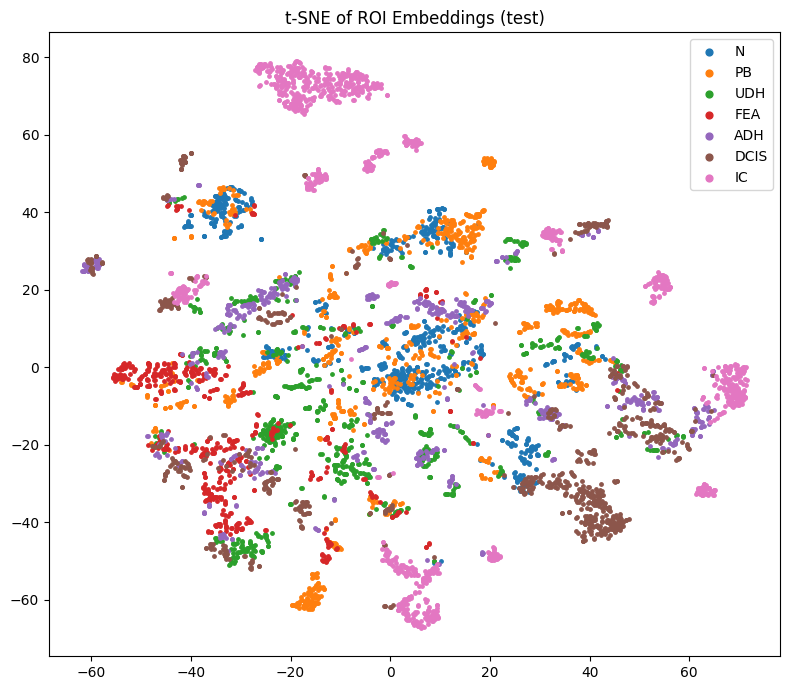

Saved PNG: /content/drive/MyDrive/BRACS/Viz/tsne_plot_test.png


In [3]:
# ============================
# ROI Embeddings → t-SNE Plot
# ============================
import os, math, random, glob, json
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Mount Drive (Colab) ---
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# --- Config ---
DRIVE_ROOT  = Path("/content/drive/MyDrive")   # set to your Shared Drive if needed
EMB_ROOT    = DRIVE_ROOT / "BRACS" / "ROIs"    # where your ROI .pt files were saved
OUT_DIR     = DRIVE_ROOT / "BRACS" / "Viz"
OUT_DIR.mkdir(parents=True, exist_ok=True)

SPLITS      = ["test"]         # or ["train","val","test"]
SUBTYPES    = ["0_N","1_PB","2_UDH","3_FEA","4_ADH","5_DCIS","6_IC"]
NAME_MAP    = {"0_N":"N","1_PB":"PB","2_UDH":"UDH","3_FEA":"FEA","4_ADH":"ADH","5_DCIS":"DCIS","6_IC":"IC"}

# Sampling knobs (tune for runtime vs detail)
MAX_TOTAL_POINTS   = 15000      # total points across all classes
MAX_PER_CLASS      = 3000       # cap per subtype
MAX_PER_ROI        = 20         # cap per ROI file
SEED               = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

def l2_normalize(x: np.ndarray, eps=1e-12) -> np.ndarray:
    n = np.linalg.norm(x, axis=1, keepdims=True)
    return x / np.maximum(n, eps)

def collect_embeddings(split: str):
    X, y = [], []
    per_class_count = {c:0 for c in SUBTYPES}
    total = 0

    for subtype in SUBTYPES:
        class_dir = EMB_ROOT / split / subtype
        if not class_dir.exists():
            continue
        # Shuffle to avoid bias
        files = list(class_dir.glob("*.pt"))
        random.shuffle(files)

        for f in files:
            if total >= MAX_TOTAL_POINTS or per_class_count[subtype] >= MAX_PER_CLASS:
                break
            try:
                payload = torch.load(f, map_location="cpu")
                E = payload.get("embeddings", None)
                if E is None or E.numel() == 0:
                    continue
                E = E.numpy() if isinstance(E, torch.Tensor) else E
                # sample up to MAX_PER_ROI rows from this ROI
                n = E.shape[0]
                take = min(MAX_PER_ROI, n)
                idx = np.random.choice(n, size=take, replace=False)
                Ei = E[idx]
                # room left for this class and globally
                room_class = MAX_PER_CLASS - per_class_count[subtype]
                room_total = MAX_TOTAL_POINTS - total
                if room_class <= 0 or room_total <= 0:
                    break
                keep = min(take, room_class, room_total)
                Ei = Ei[:keep]

                X.append(Ei)
                y += [subtype]*Ei.shape[0]
                per_class_count[subtype] += Ei.shape[0]
                total += Ei.shape[0]
            except Exception as e:
                print(f"[WARN] Could not read {f.name}: {e}")
                continue

    if not X:
        return np.zeros((0,0), dtype=np.float32), []
    X = np.vstack(X).astype(np.float32)
    return X, y

def tsne_perplexity(n_points: int) -> int:
    # Common heuristic: between 5 and 50; keep < (N-1)/3
    if n_points < 500:
        return 15
    if n_points < 2000:
        return 30
    return min(50, max(5, (n_points - 1)//3))

def run_tsne_plot(split: str):
    X, y = collect_embeddings(split)
    if X.size == 0:
        print(f"[SKIP] No embeddings found for split={split}")
        return

    print(f"[INFO] Collected: {X.shape[0]} points, dim={X.shape[1]} (split={split})")

    # L2-normalize (standard for retrieval features)
    Xn = l2_normalize(X)

    # PCA -> 50D (whiten) for denoising & speed
    n_comp = min(50, Xn.shape[1], Xn.shape[0])
    Xp = PCA(n_components=n_comp, whiten=True, random_state=SEED).fit_transform(Xn)

    # t-SNE 2D
    perplex = tsne_perplexity(Xp.shape[0])  # keep your helper
    tsne = TSNE(
        n_components=2,
        perplexity=perplex,
        init="pca",
        learning_rate="auto",   # keep if your version supports it; otherwise set a number (e.g., 200)
        n_iter=1000,
        random_state=SEED,
        verbose=1,
        # method="barnes_hut",  # optional: explicit; good default for N up to ~50k
        # angle=0.5,            # optional: accuracy/speed trade-off for Barnes–Hut
    )
    Z = tsne.fit_transform(Xp)  # [N,2]

    # Save coordinates to Drive for downstream analysis
    df = pd.DataFrame({
        "x": Z[:,0],
        "y": Z[:,1],
        "subtype": y,
        "label": [NAME_MAP.get(c, c) for c in y],
    })
    csv_path = OUT_DIR / f"tsne_coords_{split}.csv"
    df.to_csv(csv_path, index=False)
    print("Saved CSV:", csv_path)

    # Plot (default color cycle; one plot only)
    plt.figure(figsize=(8, 7))
    for subtype in SUBTYPES:
        mask = (df["subtype"] == subtype).values
        if mask.sum() == 0:
            continue
        plt.scatter(df.loc[mask, "x"], df.loc[mask, "y"], s=6, label=NAME_MAP[subtype])
    plt.title(f"t-SNE of ROI Embeddings ({split})")
    plt.legend(markerscale=2)
    plt.tight_layout()
    fig_path = OUT_DIR / f"tsne_plot_{split}.png"
    plt.savefig(fig_path, dpi=200)
    plt.show()
    print("Saved PNG:", fig_path)

for split in SPLITS:
    run_tsne_plot(split)


In [6]:
# ========= Quick sanity on ROI embeddings =========
import os, random, numpy as np, pandas as pd
from pathlib import Path
import torch
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_score, davies_bouldin_score
from itertools import combinations

# --- Config ---
DRIVE_ROOT  = Path("/content/drive/MyDrive")
EMB_ROOT    = DRIVE_ROOT / "BRACS" / "ROIs"     # .../{split}/{subtype}/*.pt
SPLIT       = "test"                              # or "test"
SUBTYPES    = ["0_N","1_PB","2_UDH","3_FEA","4_ADH","5_DCIS","6_IC"]
NAME_MAP    = {"0_N":"N","1_PB":"PB","2_UDH":"UDH","3_FEA":"FEA","4_ADH":"ADH","5_DCIS":"DCIS","6_IC":"IC"}

MAX_TOTAL   = 12000         # total tiles to sample
MAX_PER_C   = 2000          # per class cap
MAX_PER_ROI = 20            # per ROI cap
SEED        = 0
rng = np.random.default_rng(SEED); random.seed(SEED)

def load_sample(split=SPLIT):
    X, y = [], []
    per_c = {c:0 for c in SUBTYPES}
    total = 0
    for c in SUBTYPES:
        d = EMB_ROOT / split / c
        if not d.exists(): continue
        files = list(d.glob("*.pt"))
        random.shuffle(files)
        for f in files:
            if total >= MAX_TOTAL or per_c[c] >= MAX_PER_C: break
            try:
                payload = torch.load(f, map_location="cpu")
                E = payload["embeddings"].numpy() if isinstance(payload["embeddings"], torch.Tensor) else payload["embeddings"]
                n = E.shape[0]
                take = min(MAX_PER_ROI, n, MAX_PER_C - per_c[c], MAX_TOTAL - total)
                if take <= 0: break
                idx = rng.choice(n, size=take, replace=False)
                X.append(E[idx])
                y += [c]*take
                per_c[c] += take; total += take
            except Exception as e:
                print("[WARN] skip", f.name, e)
    if not X:
        return np.zeros((0,0), np.float32), []
    X = np.vstack(X).astype(np.float32)
    return X, np.array(y)

def pca50(X, seed=SEED):
    d = min(50, X.shape[1], max(10, X.shape[0]//5))
    return PCA(n_components=d, whiten=True, random_state=seed).fit_transform(normalize(X, norm="l2"))

def knn_purity(X, y, k_list=(1,5,10)):
    # micro-averaged same-label fraction among k-NN (leave-one-out)
    from sklearn.metrics.pairwise import cosine_similarity
    Z = normalize(X, norm='l2')
    S = cosine_similarity(Z, Z); np.fill_diagonal(S, -1)
    order = np.argsort(-S, axis=1)
    out = {}
    for k in k_list:
        topk = order[:, :k]
        hits = [(y[topk[i]] == y[i]).any() for i in range(len(y))]
        out[f"recall@{k}"] = float(np.mean(hits))
        purity = np.mean([(y[topk[i]] == y[i]).mean() for i in range(len(y))])
        out[f"purity@{k}"] = float(purity)
    return out

def centroid_geometry(X, y):
    # pairwise cosine distances between class centroids; also intra-class spread
    Z = normalize(X, norm='l2')
    classes = sorted(set(y))
    mu = {c: Z[y==c].mean(axis=0) for c in classes}
    # normalize centroids
    mu = {c: mu[c]/np.linalg.norm(mu[c]) for c in classes}
    # inter-centroid cosine distances
    C = []
    for a,b in combinations(classes, 2):
        C.append((a,b, float(1 - np.dot(mu[a], mu[b]))))
    # intra-class spread (mean cosine dist to centroid)
    spread = {c: float(np.mean(1 - (Z[y==c] @ mu[c]))) for c in classes}
    return C, spread

# ---- Run ----
X, y = load_sample(SPLIT)
print(f"[INFO] {SPLIT}: sampled {X.shape[0]} tiles, dim={X.shape[1]}; class counts:",
      {c:int((y==c).sum()) for c in SUBTYPES})

# Evaluate in PCA-50 (more stable for these indices)
Xp = pca50(X)

# k-NN purity / recall@k in original space (cosine) using X (optional: use Xp)
metrics_knn = knn_purity(X, y, k_list=(1,5,10))
print("[k-NN] ", metrics_knn)

# Linear probe (train/val split within SPLIT for a quick check)
Xtr, Xte, ytr, yte = train_test_split(Xp, y, test_size=0.3, stratify=y, random_state=SEED)
clf = LogisticRegression(max_iter=2000, multi_class='ovr').fit(Xtr, ytr)
lin_acc = accuracy_score(yte, clf.predict(Xte))
print(f"[Linear-Probe LogReg@PCA-50] acc={lin_acc:.3f}  (chance ~ {1/len(SUBTYPES):.3f})")

# Unsupervised indices
sil = silhouette_score(Xp, y, metric='euclidean')
db  = davies_bouldin_score(Xp, y)
print(f"[Clustering Indices] silhouette={sil:.3f}  (higher better),  DB={db:.3f} (lower better)")

# Centroid geometry
C, spread = centroid_geometry(X)
# summarize min inter-class vs. max intra-class
min_inter = min(c for _,_,c in C) if C else np.nan
max_intra = max(spread.values()) if spread else np.nan
print(f"[Centroids] min inter-class cos-dist = {min_inter:.3f} ; max intra-class cos-dist = {max_intra:.3f}")


[INFO] test: sampled 5996 tiles, dim=1536; class counts: {'0_N': 778, '1_PB': 1006, '2_UDH': 822, '3_FEA': 579, '4_ADH': 706, '5_DCIS': 890, '6_IC': 1215}
[k-NN]  {'recall@1': 0.9452968645763843, 'purity@1': 0.9452968645763843, 'recall@5': 0.9921614409606404, 'purity@5': 0.8555703802535023, 'recall@10': 0.9969979986657772, 'purity@10': 0.7895430286857904}
[Linear-Probe LogReg@PCA-50] acc=0.708  (chance ~ 0.143)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[Clustering Indices] silhouette=-0.021  (higher better),  DB=7.430 (lower better)


TypeError: centroid_geometry() missing 1 required positional argument: 'y'